##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 26:44

   24576/84125825 [..............................] - ETA: 17:41

   57344/84125825 [..............................] - ETA: 11:21

   73728/84125825 [..............................] - ETA: 11:47

  122880/84125825 [..............................] - ETA: 8:49 

  172032/84125825 [..............................] - ETA: 7:35

  237568/84125825 [..............................] - ETA: 6:24

  335872/84125825 [..............................] - ETA: 5:10

  466944/84125825 [..............................] - ETA: 4:10

  614400/84125825 [..............................] - ETA: 3:31

  811008/84125825 [..............................] - ETA: 2:55

 1073152/84125825 [..............................] - ETA: 2:24

 1417216/84125825 [..............................] - ETA: 1:58

 1843200/84125825 [..............................] - ETA: 1:37

 2351104/84125825 [..............................] - ETA: 1:21

 2973696/84125825 [>.............................] - ETA: 1:08

 3629056/84125825 [>.............................] - ETA: 56s 

 3743744/84125825 [>.............................] - ETA: 56s

 4448256/84125825 [>.............................] - ETA: 48s

 4694016/84125825 [>.............................] - ETA: 47s

 5398528/84125825 [>.............................] - ETA: 41s

 5791744/84125825 [=>............................] - ETA: 40s

 6512640/84125825 [=>............................] - ETA: 36s

 7020544/84125825 [=>............................] - ETA: 34s

 7708672/84125825 [=>............................] - ETA: 31s

 8249344/84125825 [=>............................] - ETA: 29s

 8544256/84125825 [==>...........................] - ETA: 28s

 9150464/84125825 [==>...........................] - ETA: 27s

 9822208/84125825 [==>...........................] - ETA: 25s

10199040/84125825 [==>...........................] - ETA: 24s

10772480/84125825 [==>...........................] - ETA: 23s

11476992/84125825 [===>..........................] - ETA: 22s

12001280/84125825 [===>..........................] - ETA: 21s

12574720/84125825 [===>..........................] - ETA: 20s

13279232/84125825 [===>..........................] - ETA: 19s

13950976/84125825 [===>..........................] - ETA: 18s

14573568/84125825 [====>.........................] - ETA: 18s

15245312/84125825 [====>.........................] - ETA: 17s

15867904/84125825 [====>.........................] - ETA: 16s

16556032/84125825 [====>.........................] - ETA: 16s

17145856/84125825 [=====>........................] - ETA: 15s

17817600/84125825 [=====>........................] - ETA: 15s

18407424/84125825 [=====>........................] - ETA: 14s

19079168/84125825 [=====>........................] - ETA: 14s

19668992/84125825 [======>.......................] - ETA: 13s

20258816/84125825 [======>.......................] - ETA: 13s

20865024/84125825 [======>.......................] - ETA: 13s

21438464/84125825 [======>.......................] - ETA: 12s

22110208/84125825 [======>.......................] - ETA: 12s

22700032/84125825 [=======>......................] - ETA: 12s

23322624/84125825 [=======>......................] - ETA: 11s

23961600/84125825 [=======>......................] - ETA: 11s

24485888/84125825 [=======>......................] - ETA: 11s

25157632/84125825 [=======>......................] - ETA: 11s

25747456/84125825 [========>.....................] - ETA: 10s

26419200/84125825 [========>.....................] - ETA: 10s

27009024/84125825 [========>.....................] - ETA: 10s

27533312/84125825 [========>.....................] - ETA: 10s

28188672/84125825 [=========>....................] - ETA: 9s 

28794880/84125825 [=========>....................] - ETA: 9s

29466624/84125825 [=========>....................] - ETA: 9s

30056448/84125825 [=========>....................] - ETA: 9s

30613504/84125825 [=========>....................] - ETA: 9s

31301632/84125825 [==========>...................] - ETA: 8s

31924224/84125825 [==========>...................] - ETA: 8s

32497664/84125825 [==========>...................] - ETA: 8s

33071104/84125825 [==========>...................] - ETA: 8s

33677312/84125825 [===========>..................] - ETA: 8s

34332672/84125825 [===========>..................] - ETA: 7s

34840576/84125825 [===========>..................] - ETA: 7s

35397632/84125825 [===========>..................] - ETA: 7s

36069376/84125825 [===========>..................] - ETA: 7s

36626432/84125825 [============>.................] - ETA: 7s

37265408/84125825 [============>.................] - ETA: 7s

37888000/84125825 [============>.................] - ETA: 7s

38526976/84125825 [============>.................] - ETA: 6s

39116800/84125825 [============>.................] - ETA: 6s

39657472/84125825 [=============>................] - ETA: 6s

40198144/84125825 [=============>................] - ETA: 6s

40837120/84125825 [=============>................] - ETA: 6s

41426944/84125825 [=============>................] - ETA: 6s

41984000/84125825 [=============>................] - ETA: 6s

42606592/84125825 [==============>...............] - ETA: 6s

43196416/84125825 [==============>...............] - ETA: 5s

43786240/84125825 [==============>...............] - ETA: 5s

44376064/84125825 [==============>...............] - ETA: 5s

44949504/84125825 [===============>..............] - ETA: 5s

45473792/84125825 [===============>..............] - ETA: 5s

46063616/84125825 [===============>..............] - ETA: 5s

46505984/84125825 [===============>..............] - ETA: 5s

47128576/84125825 [===============>..............] - ETA: 5s

47669248/84125825 [===============>..............] - ETA: 5s

48259072/84125825 [================>.............] - ETA: 5s

48766976/84125825 [================>.............] - ETA: 4s

49340416/84125825 [================>.............] - ETA: 4s

49995776/84125825 [================>.............] - ETA: 4s

50536448/84125825 [=================>............] - ETA: 4s

51109888/84125825 [=================>............] - ETA: 4s

51781632/84125825 [=================>............] - ETA: 4s

52322304/84125825 [=================>............] - ETA: 4s

52994048/84125825 [=================>............] - ETA: 4s

53567488/84125825 [==================>...........] - ETA: 4s

54140928/84125825 [==================>...........] - ETA: 4s

54812672/84125825 [==================>...........] - ETA: 3s

55353344/84125825 [==================>...........] - ETA: 3s

55975936/84125825 [==================>...........] - ETA: 3s

56582144/84125825 [===================>..........] - ETA: 3s

57122816/84125825 [===================>..........] - ETA: 3s

57761792/84125825 [===================>..........] - ETA: 3s

58351616/84125825 [===================>..........] - ETA: 3s

58892288/84125825 [====================>.........] - ETA: 3s

59547648/84125825 [====================>.........] - ETA: 3s

60137472/84125825 [====================>.........] - ETA: 3s

60661760/84125825 [====================>.........] - ETA: 3s

61284352/84125825 [====================>.........] - ETA: 2s

61857792/84125825 [=====================>........] - ETA: 2s

62431232/84125825 [=====================>........] - ETA: 2s

62922752/84125825 [=====================>........] - ETA: 2s

63447040/84125825 [=====================>........] - ETA: 2s

63954944/84125825 [=====================>........] - ETA: 2s

64462848/84125825 [=====================>........] - ETA: 2s

65101824/84125825 [======================>.......] - ETA: 2s

65708032/84125825 [======================>.......] - ETA: 2s

66363392/84125825 [======================>.......] - ETA: 2s

66936832/84125825 [======================>.......] - ETA: 2s

67477504/84125825 [=======================>......] - ETA: 2s

68132864/84125825 [=======================>......] - ETA: 1s

68739072/84125825 [=======================>......] - ETA: 1s

69263360/84125825 [=======================>......] - ETA: 1s

69918720/84125825 [=======================>......] - ETA: 1s

70524928/84125825 [========================>.....] - ETA: 1s

71196672/84125825 [========================>.....] - ETA: 1s

71786496/84125825 [========================>.....] - ETA: 1s

72441856/84125825 [========================>.....] - ETA: 1s

73048064/84125825 [=========================>....] - ETA: 1s

73703424/84125825 [=========================>....] - ETA: 1s

74309632/84125825 [=========================>....] - ETA: 1s

74964992/84125825 [=========================>....] - ETA: 1s

75571200/84125825 [=========================>....] - ETA: 1s

76079104/84125825 [==========================>...] - ETA: 0s

76750848/84125825 [==========================>...] - ETA: 0s

77340672/84125825 [==========================>...] - ETA: 0s

77864960/84125825 [==========================>...] - ETA: 0s

78520320/84125825 [===========================>..] - ETA: 0s

79126528/84125825 [===========================>..] - ETA: 0s

79765504/84125825 [===========================>..] - ETA: 0s

80388096/84125825 [===========================>..] - ETA: 0s

80945152/84125825 [===========================>..] - ETA: 0s

81567744/84125825 [============================>.] - ETA: 0s

82157568/84125825 [============================>.] - ETA: 0s

82829312/84125825 [============================>.] - ETA: 0s

83419136/84125825 [============================>.] - ETA: 0s

84008960/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 10s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.27966386]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

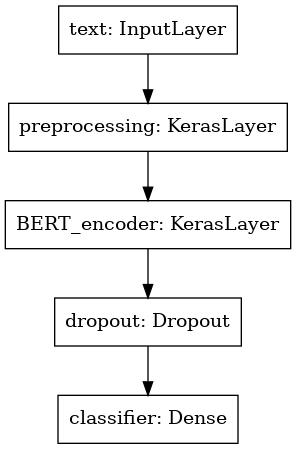

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 59:25 - loss: 0.5989 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:15 - loss: 0.8180 - binary_accuracy: 0.5625 

  3/625 [..............................] - ETA: 1:14 - loss: 0.8958 - binary_accuracy: 0.5312

  4/625 [..............................] - ETA: 1:12 - loss: 0.8809 - binary_accuracy: 0.5547

  5/625 [..............................] - ETA: 1:11 - loss: 0.8717 - binary_accuracy: 0.5500

  6/625 [..............................] - ETA: 1:11 - loss: 0.8637 - binary_accuracy: 0.5573

  7/625 [..............................] - ETA: 1:11 - loss: 0.8399 - binary_accuracy: 0.5670

  8/625 [..............................] - ETA: 1:10 - loss: 0.8219 - binary_accuracy: 0.5742

  9/625 [..............................] - ETA: 1:10 - loss: 0.8276 - binary_accuracy: 0.5694

 10/625 [..............................] - ETA: 1:10 - loss: 0.8506 - binary_accuracy: 0.5469

 11/625 [..............................] - ETA: 1:10 - loss: 0.8818 - binary_accuracy: 0.5341

 12/625 [..............................] - ETA: 1:10 - loss: 0.9050 - binary_accuracy: 0.5182

 13/625 [..............................] - ETA: 1:09 - loss: 0.9115 - binary_accuracy: 0.5144

 14/625 [..............................] - ETA: 1:09 - loss: 0.9052 - binary_accuracy: 0.5179

 15/625 [..............................] - ETA: 1:09 - loss: 0.9004 - binary_accuracy: 0.5188

 16/625 [..............................] - ETA: 1:09 - loss: 0.8799 - binary_accuracy: 0.5312

 17/625 [..............................] - ETA: 1:09 - loss: 0.8872 - binary_accuracy: 0.5239

 18/625 [..............................] - ETA: 1:09 - loss: 0.8848 - binary_accuracy: 0.5260

 19/625 [..............................] - ETA: 1:09 - loss: 0.8843 - binary_accuracy: 0.5263

 20/625 [..............................] - ETA: 1:09 - loss: 0.8834 - binary_accuracy: 0.5250

 21/625 [>.............................] - ETA: 1:09 - loss: 0.8784 - binary_accuracy: 0.5238

 22/625 [>.............................] - ETA: 1:08 - loss: 0.8755 - binary_accuracy: 0.5213

 23/625 [>.............................] - ETA: 1:08 - loss: 0.8679 - binary_accuracy: 0.5217

 24/625 [>.............................] - ETA: 1:08 - loss: 0.8564 - binary_accuracy: 0.5312

 25/625 [>.............................] - ETA: 1:08 - loss: 0.8539 - binary_accuracy: 0.5250

 26/625 [>.............................] - ETA: 1:08 - loss: 0.8482 - binary_accuracy: 0.5228

 27/625 [>.............................] - ETA: 1:08 - loss: 0.8477 - binary_accuracy: 0.5162

 28/625 [>.............................] - ETA: 1:08 - loss: 0.8434 - binary_accuracy: 0.5156

 29/625 [>.............................] - ETA: 1:08 - loss: 0.8420 - binary_accuracy: 0.5108

 30/625 [>.............................] - ETA: 1:08 - loss: 0.8395 - binary_accuracy: 0.5073

 31/625 [>.............................] - ETA: 1:08 - loss: 0.8330 - binary_accuracy: 0.5101

 32/625 [>.............................] - ETA: 1:07 - loss: 0.8298 - binary_accuracy: 0.5088

 33/625 [>.............................] - ETA: 1:07 - loss: 0.8273 - binary_accuracy: 0.5104

 34/625 [>.............................] - ETA: 1:07 - loss: 0.8246 - binary_accuracy: 0.5092

 35/625 [>.............................] - ETA: 1:07 - loss: 0.8207 - binary_accuracy: 0.5125

 36/625 [>.............................] - ETA: 1:07 - loss: 0.8152 - binary_accuracy: 0.5139

 37/625 [>.............................] - ETA: 1:07 - loss: 0.8121 - binary_accuracy: 0.5152

 38/625 [>.............................] - ETA: 1:07 - loss: 0.8071 - binary_accuracy: 0.5181

 39/625 [>.............................] - ETA: 1:07 - loss: 0.8048 - binary_accuracy: 0.5176

 40/625 [>.............................] - ETA: 1:07 - loss: 0.8001 - binary_accuracy: 0.5180

 41/625 [>.............................] - ETA: 1:06 - loss: 0.7989 - binary_accuracy: 0.5198

 42/625 [=>............................] - ETA: 1:06 - loss: 0.7988 - binary_accuracy: 0.5193

 43/625 [=>............................] - ETA: 1:06 - loss: 0.7975 - binary_accuracy: 0.5203

 44/625 [=>............................] - ETA: 1:06 - loss: 0.7934 - binary_accuracy: 0.5206

 45/625 [=>............................] - ETA: 1:06 - loss: 0.7928 - binary_accuracy: 0.5201

 46/625 [=>............................] - ETA: 1:06 - loss: 0.7909 - binary_accuracy: 0.5217

 47/625 [=>............................] - ETA: 1:06 - loss: 0.7897 - binary_accuracy: 0.5219

 48/625 [=>............................] - ETA: 1:06 - loss: 0.7878 - binary_accuracy: 0.5247

 49/625 [=>............................] - ETA: 1:05 - loss: 0.7859 - binary_accuracy: 0.5268

 50/625 [=>............................] - ETA: 1:05 - loss: 0.7842 - binary_accuracy: 0.5281

 51/625 [=>............................] - ETA: 1:05 - loss: 0.7821 - binary_accuracy: 0.5288

 52/625 [=>............................] - ETA: 1:05 - loss: 0.7794 - binary_accuracy: 0.5306

 53/625 [=>............................] - ETA: 1:05 - loss: 0.7784 - binary_accuracy: 0.5307

 54/625 [=>............................] - ETA: 1:05 - loss: 0.7760 - binary_accuracy: 0.5312

 55/625 [=>............................] - ETA: 1:05 - loss: 0.7750 - binary_accuracy: 0.5284

 56/625 [=>............................] - ETA: 1:04 - loss: 0.7729 - binary_accuracy: 0.5290

 57/625 [=>............................] - ETA: 1:04 - loss: 0.7709 - binary_accuracy: 0.5307

 58/625 [=>............................] - ETA: 1:04 - loss: 0.7687 - binary_accuracy: 0.5291

 59/625 [=>............................] - ETA: 1:04 - loss: 0.7666 - binary_accuracy: 0.5307

 60/625 [=>............................] - ETA: 1:04 - loss: 0.7641 - binary_accuracy: 0.5328

 61/625 [=>............................] - ETA: 1:04 - loss: 0.7603 - binary_accuracy: 0.5359

 62/625 [=>............................] - ETA: 1:04 - loss: 0.7584 - binary_accuracy: 0.5383

 63/625 [==>...........................] - ETA: 1:03 - loss: 0.7578 - binary_accuracy: 0.5387

 64/625 [==>...........................] - ETA: 1:03 - loss: 0.7557 - binary_accuracy: 0.5391

 65/625 [==>...........................] - ETA: 1:03 - loss: 0.7545 - binary_accuracy: 0.5394

 66/625 [==>...........................] - ETA: 1:03 - loss: 0.7526 - binary_accuracy: 0.5407

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.7507 - binary_accuracy: 0.5429

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.7497 - binary_accuracy: 0.5441

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.7480 - binary_accuracy: 0.5448

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.7469 - binary_accuracy: 0.5451

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.7447 - binary_accuracy: 0.5480

 72/625 [==>...........................] - ETA: 1:02 - loss: 0.7439 - binary_accuracy: 0.5477

 73/625 [==>...........................] - ETA: 1:02 - loss: 0.7430 - binary_accuracy: 0.5479

 74/625 [==>...........................] - ETA: 1:02 - loss: 0.7414 - binary_accuracy: 0.5486

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.7402 - binary_accuracy: 0.5475

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.7394 - binary_accuracy: 0.5461

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.7374 - binary_accuracy: 0.5475

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.7354 - binary_accuracy: 0.5481

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.7328 - binary_accuracy: 0.5506

 80/625 [==>...........................] - ETA: 1:01 - loss: 0.7312 - binary_accuracy: 0.5516

 81/625 [==>...........................] - ETA: 1:01 - loss: 0.7288 - binary_accuracy: 0.5532

 82/625 [==>...........................] - ETA: 1:01 - loss: 0.7265 - binary_accuracy: 0.5549

 83/625 [==>...........................] - ETA: 1:01 - loss: 0.7259 - binary_accuracy: 0.5561

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.7238 - binary_accuracy: 0.5580

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.7236 - binary_accuracy: 0.5599

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.7225 - binary_accuracy: 0.5614

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.7205 - binary_accuracy: 0.5618

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.7191 - binary_accuracy: 0.5614

 89/625 [===>..........................] - ETA: 1:00 - loss: 0.7191 - binary_accuracy: 0.5611

 90/625 [===>..........................] - ETA: 1:00 - loss: 0.7179 - binary_accuracy: 0.5615

 91/625 [===>..........................] - ETA: 1:00 - loss: 0.7174 - binary_accuracy: 0.5628

 92/625 [===>..........................] - ETA: 1:00 - loss: 0.7161 - binary_accuracy: 0.5642

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.7148 - binary_accuracy: 0.5645

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.7138 - binary_accuracy: 0.5655

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.7136 - binary_accuracy: 0.5664

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.7121 - binary_accuracy: 0.5684

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.7100 - binary_accuracy: 0.5696

 98/625 [===>..........................] - ETA: 59s - loss: 0.7091 - binary_accuracy: 0.5695 

 99/625 [===>..........................] - ETA: 59s - loss: 0.7080 - binary_accuracy: 0.5701

100/625 [===>..........................] - ETA: 59s - loss: 0.7066 - binary_accuracy: 0.5716

101/625 [===>..........................] - ETA: 59s - loss: 0.7060 - binary_accuracy: 0.5721

102/625 [===>..........................] - ETA: 59s - loss: 0.7048 - binary_accuracy: 0.5726

103/625 [===>..........................] - ETA: 59s - loss: 0.7032 - binary_accuracy: 0.5731

104/625 [===>..........................] - ETA: 59s - loss: 0.7017 - binary_accuracy: 0.5742

105/625 [====>.........................] - ETA: 59s - loss: 0.7000 - binary_accuracy: 0.5762

106/625 [====>.........................] - ETA: 59s - loss: 0.6988 - binary_accuracy: 0.5775

107/625 [====>.........................] - ETA: 58s - loss: 0.6978 - binary_accuracy: 0.5780

108/625 [====>.........................] - ETA: 58s - loss: 0.6967 - binary_accuracy: 0.5781

109/625 [====>.........................] - ETA: 58s - loss: 0.6962 - binary_accuracy: 0.5786

110/625 [====>.........................] - ETA: 58s - loss: 0.6961 - binary_accuracy: 0.5781

111/625 [====>.........................] - ETA: 58s - loss: 0.6944 - binary_accuracy: 0.5794

112/625 [====>.........................] - ETA: 58s - loss: 0.6931 - binary_accuracy: 0.5804

113/625 [====>.........................] - ETA: 58s - loss: 0.6924 - binary_accuracy: 0.5821

114/625 [====>.........................] - ETA: 58s - loss: 0.6920 - binary_accuracy: 0.5822

115/625 [====>.........................] - ETA: 58s - loss: 0.6900 - binary_accuracy: 0.5837

116/625 [====>.........................] - ETA: 57s - loss: 0.6891 - binary_accuracy: 0.5835

117/625 [====>.........................] - ETA: 57s - loss: 0.6882 - binary_accuracy: 0.5841

118/625 [====>.........................] - ETA: 57s - loss: 0.6869 - binary_accuracy: 0.5853

119/625 [====>.........................] - ETA: 57s - loss: 0.6852 - binary_accuracy: 0.5869

120/625 [====>.........................] - ETA: 57s - loss: 0.6841 - binary_accuracy: 0.5885

121/625 [====>.........................] - ETA: 57s - loss: 0.6839 - binary_accuracy: 0.5881

122/625 [====>.........................] - ETA: 57s - loss: 0.6826 - binary_accuracy: 0.5891

123/625 [====>.........................] - ETA: 57s - loss: 0.6813 - binary_accuracy: 0.5899

124/625 [====>.........................] - ETA: 57s - loss: 0.6798 - binary_accuracy: 0.5905

125/625 [=====>........................] - ETA: 56s - loss: 0.6796 - binary_accuracy: 0.5913

126/625 [=====>........................] - ETA: 56s - loss: 0.6786 - binary_accuracy: 0.5923

127/625 [=====>........................] - ETA: 56s - loss: 0.6771 - binary_accuracy: 0.5940

128/625 [=====>........................] - ETA: 56s - loss: 0.6754 - binary_accuracy: 0.5952

129/625 [=====>........................] - ETA: 56s - loss: 0.6747 - binary_accuracy: 0.5974

130/625 [=====>........................] - ETA: 56s - loss: 0.6744 - binary_accuracy: 0.5974

131/625 [=====>........................] - ETA: 56s - loss: 0.6733 - binary_accuracy: 0.5983

132/625 [=====>........................] - ETA: 56s - loss: 0.6721 - binary_accuracy: 0.5994

133/625 [=====>........................] - ETA: 56s - loss: 0.6707 - binary_accuracy: 0.6010

134/625 [=====>........................] - ETA: 55s - loss: 0.6699 - binary_accuracy: 0.6026

135/625 [=====>........................] - ETA: 55s - loss: 0.6688 - binary_accuracy: 0.6032

136/625 [=====>........................] - ETA: 55s - loss: 0.6669 - binary_accuracy: 0.6048

137/625 [=====>........................] - ETA: 55s - loss: 0.6654 - binary_accuracy: 0.6061

138/625 [=====>........................] - ETA: 55s - loss: 0.6642 - binary_accuracy: 0.6067

139/625 [=====>........................] - ETA: 55s - loss: 0.6629 - binary_accuracy: 0.6072

140/625 [=====>........................] - ETA: 55s - loss: 0.6629 - binary_accuracy: 0.6076

141/625 [=====>........................] - ETA: 55s - loss: 0.6615 - binary_accuracy: 0.6082

142/625 [=====>........................] - ETA: 55s - loss: 0.6603 - binary_accuracy: 0.6085

143/625 [=====>........................] - ETA: 54s - loss: 0.6596 - binary_accuracy: 0.6097

144/625 [=====>........................] - ETA: 54s - loss: 0.6586 - binary_accuracy: 0.6105

145/625 [=====>........................] - ETA: 54s - loss: 0.6574 - binary_accuracy: 0.6116

146/625 [======>.......................] - ETA: 54s - loss: 0.6567 - binary_accuracy: 0.6119

147/625 [======>.......................] - ETA: 54s - loss: 0.6556 - binary_accuracy: 0.6125

148/625 [======>.......................] - ETA: 54s - loss: 0.6549 - binary_accuracy: 0.6132

149/625 [======>.......................] - ETA: 54s - loss: 0.6533 - binary_accuracy: 0.6149

150/625 [======>.......................] - ETA: 54s - loss: 0.6530 - binary_accuracy: 0.6154

151/625 [======>.......................] - ETA: 53s - loss: 0.6518 - binary_accuracy: 0.6169

152/625 [======>.......................] - ETA: 53s - loss: 0.6516 - binary_accuracy: 0.6174

153/625 [======>.......................] - ETA: 53s - loss: 0.6506 - binary_accuracy: 0.6172

154/625 [======>.......................] - ETA: 53s - loss: 0.6503 - binary_accuracy: 0.6173

155/625 [======>.......................] - ETA: 53s - loss: 0.6491 - binary_accuracy: 0.6173

156/625 [======>.......................] - ETA: 53s - loss: 0.6475 - binary_accuracy: 0.6184

157/625 [======>.......................] - ETA: 53s - loss: 0.6473 - binary_accuracy: 0.6186

158/625 [======>.......................] - ETA: 53s - loss: 0.6468 - binary_accuracy: 0.6195

159/625 [======>.......................] - ETA: 53s - loss: 0.6460 - binary_accuracy: 0.6207

160/625 [======>.......................] - ETA: 52s - loss: 0.6450 - binary_accuracy: 0.6213

161/625 [======>.......................] - ETA: 52s - loss: 0.6434 - binary_accuracy: 0.6229

162/625 [======>.......................] - ETA: 52s - loss: 0.6424 - binary_accuracy: 0.6238

163/625 [======>.......................] - ETA: 52s - loss: 0.6411 - binary_accuracy: 0.6246

164/625 [======>.......................] - ETA: 52s - loss: 0.6406 - binary_accuracy: 0.6244

165/625 [======>.......................] - ETA: 52s - loss: 0.6396 - binary_accuracy: 0.6254

166/625 [======>.......................] - ETA: 52s - loss: 0.6394 - binary_accuracy: 0.6256

167/625 [=======>......................] - ETA: 52s - loss: 0.6387 - binary_accuracy: 0.6257

168/625 [=======>......................] - ETA: 51s - loss: 0.6383 - binary_accuracy: 0.6256

169/625 [=======>......................] - ETA: 51s - loss: 0.6369 - binary_accuracy: 0.6265

170/625 [=======>......................] - ETA: 51s - loss: 0.6357 - binary_accuracy: 0.6272

171/625 [=======>......................] - ETA: 51s - loss: 0.6354 - binary_accuracy: 0.6279

172/625 [=======>......................] - ETA: 51s - loss: 0.6336 - binary_accuracy: 0.6294

173/625 [=======>......................] - ETA: 51s - loss: 0.6325 - binary_accuracy: 0.6304

174/625 [=======>......................] - ETA: 51s - loss: 0.6309 - binary_accuracy: 0.6316

175/625 [=======>......................] - ETA: 51s - loss: 0.6296 - binary_accuracy: 0.6330

176/625 [=======>......................] - ETA: 51s - loss: 0.6294 - binary_accuracy: 0.6326

177/625 [=======>......................] - ETA: 50s - loss: 0.6287 - binary_accuracy: 0.6331

178/625 [=======>......................] - ETA: 50s - loss: 0.6281 - binary_accuracy: 0.6340

179/625 [=======>......................] - ETA: 50s - loss: 0.6270 - binary_accuracy: 0.6344

180/625 [=======>......................] - ETA: 50s - loss: 0.6260 - binary_accuracy: 0.6349

181/625 [=======>......................] - ETA: 50s - loss: 0.6249 - binary_accuracy: 0.6354

182/625 [=======>......................] - ETA: 50s - loss: 0.6242 - binary_accuracy: 0.6362

183/625 [=======>......................] - ETA: 50s - loss: 0.6244 - binary_accuracy: 0.6363

184/625 [=======>......................] - ETA: 50s - loss: 0.6234 - binary_accuracy: 0.6372

185/625 [=======>......................] - ETA: 50s - loss: 0.6217 - binary_accuracy: 0.6382

186/625 [=======>......................] - ETA: 49s - loss: 0.6212 - binary_accuracy: 0.6386

187/625 [=======>......................] - ETA: 49s - loss: 0.6199 - binary_accuracy: 0.6397

188/625 [========>.....................] - ETA: 49s - loss: 0.6180 - binary_accuracy: 0.6413

189/625 [========>.....................] - ETA: 49s - loss: 0.6168 - binary_accuracy: 0.6427

190/625 [========>.....................] - ETA: 49s - loss: 0.6166 - binary_accuracy: 0.6426

191/625 [========>.....................] - ETA: 49s - loss: 0.6155 - binary_accuracy: 0.6433

192/625 [========>.....................] - ETA: 49s - loss: 0.6145 - binary_accuracy: 0.6437

193/625 [========>.....................] - ETA: 49s - loss: 0.6137 - binary_accuracy: 0.6439

194/625 [========>.....................] - ETA: 48s - loss: 0.6133 - binary_accuracy: 0.6442

195/625 [========>.....................] - ETA: 48s - loss: 0.6124 - binary_accuracy: 0.6449

196/625 [========>.....................] - ETA: 48s - loss: 0.6130 - binary_accuracy: 0.6449

197/625 [========>.....................] - ETA: 48s - loss: 0.6125 - binary_accuracy: 0.6453

198/625 [========>.....................] - ETA: 48s - loss: 0.6116 - binary_accuracy: 0.6458

199/625 [========>.....................] - ETA: 48s - loss: 0.6113 - binary_accuracy: 0.6460

200/625 [========>.....................] - ETA: 48s - loss: 0.6100 - binary_accuracy: 0.6472

201/625 [========>.....................] - ETA: 48s - loss: 0.6103 - binary_accuracy: 0.6472

202/625 [========>.....................] - ETA: 47s - loss: 0.6086 - binary_accuracy: 0.6485

203/625 [========>.....................] - ETA: 47s - loss: 0.6082 - binary_accuracy: 0.6489

204/625 [========>.....................] - ETA: 47s - loss: 0.6075 - binary_accuracy: 0.6497

205/625 [========>.....................] - ETA: 47s - loss: 0.6066 - binary_accuracy: 0.6506

206/625 [========>.....................] - ETA: 47s - loss: 0.6060 - binary_accuracy: 0.6511

207/625 [========>.....................] - ETA: 47s - loss: 0.6055 - binary_accuracy: 0.6517

208/625 [========>.....................] - ETA: 47s - loss: 0.6053 - binary_accuracy: 0.6517

209/625 [=========>....................] - ETA: 47s - loss: 0.6043 - binary_accuracy: 0.6527

210/625 [=========>....................] - ETA: 47s - loss: 0.6040 - binary_accuracy: 0.6527

211/625 [=========>....................] - ETA: 46s - loss: 0.6031 - binary_accuracy: 0.6528

212/625 [=========>....................] - ETA: 46s - loss: 0.6026 - binary_accuracy: 0.6534

213/625 [=========>....................] - ETA: 46s - loss: 0.6017 - binary_accuracy: 0.6540

214/625 [=========>....................] - ETA: 46s - loss: 0.6005 - binary_accuracy: 0.6548

215/625 [=========>....................] - ETA: 46s - loss: 0.6001 - binary_accuracy: 0.6551

216/625 [=========>....................] - ETA: 46s - loss: 0.6002 - binary_accuracy: 0.6551

217/625 [=========>....................] - ETA: 46s - loss: 0.5996 - binary_accuracy: 0.6557

218/625 [=========>....................] - ETA: 46s - loss: 0.5981 - binary_accuracy: 0.6567

219/625 [=========>....................] - ETA: 46s - loss: 0.5980 - binary_accuracy: 0.6572

220/625 [=========>....................] - ETA: 45s - loss: 0.5975 - binary_accuracy: 0.6578

221/625 [=========>....................] - ETA: 45s - loss: 0.5967 - binary_accuracy: 0.6582

222/625 [=========>....................] - ETA: 45s - loss: 0.5956 - binary_accuracy: 0.6589

223/625 [=========>....................] - ETA: 45s - loss: 0.5952 - binary_accuracy: 0.6599

224/625 [=========>....................] - ETA: 45s - loss: 0.5957 - binary_accuracy: 0.6600

225/625 [=========>....................] - ETA: 45s - loss: 0.5951 - binary_accuracy: 0.6604

226/625 [=========>....................] - ETA: 45s - loss: 0.5937 - binary_accuracy: 0.6612

227/625 [=========>....................] - ETA: 45s - loss: 0.5924 - binary_accuracy: 0.6622

228/625 [=========>....................] - ETA: 44s - loss: 0.5915 - binary_accuracy: 0.6628

229/625 [=========>....................] - ETA: 44s - loss: 0.5913 - binary_accuracy: 0.6628

230/625 [==========>...................] - ETA: 44s - loss: 0.5905 - binary_accuracy: 0.6633

231/625 [==========>...................] - ETA: 44s - loss: 0.5898 - binary_accuracy: 0.6638

232/625 [==========>...................] - ETA: 44s - loss: 0.5887 - binary_accuracy: 0.6649

233/625 [==========>...................] - ETA: 44s - loss: 0.5878 - binary_accuracy: 0.6656

234/625 [==========>...................] - ETA: 44s - loss: 0.5872 - binary_accuracy: 0.6659

235/625 [==========>...................] - ETA: 44s - loss: 0.5864 - binary_accuracy: 0.6662

236/625 [==========>...................] - ETA: 44s - loss: 0.5868 - binary_accuracy: 0.6662

237/625 [==========>...................] - ETA: 43s - loss: 0.5861 - binary_accuracy: 0.6667

238/625 [==========>...................] - ETA: 43s - loss: 0.5846 - binary_accuracy: 0.6678

239/625 [==========>...................] - ETA: 43s - loss: 0.5851 - binary_accuracy: 0.6674

240/625 [==========>...................] - ETA: 43s - loss: 0.5839 - binary_accuracy: 0.6685

241/625 [==========>...................] - ETA: 43s - loss: 0.5834 - binary_accuracy: 0.6690

242/625 [==========>...................] - ETA: 43s - loss: 0.5820 - binary_accuracy: 0.6701

243/625 [==========>...................] - ETA: 43s - loss: 0.5812 - binary_accuracy: 0.6705

244/625 [==========>...................] - ETA: 43s - loss: 0.5808 - binary_accuracy: 0.6706

245/625 [==========>...................] - ETA: 43s - loss: 0.5803 - binary_accuracy: 0.6712

246/625 [==========>...................] - ETA: 42s - loss: 0.5794 - binary_accuracy: 0.6720

247/625 [==========>...................] - ETA: 42s - loss: 0.5784 - binary_accuracy: 0.6726

248/625 [==========>...................] - ETA: 42s - loss: 0.5784 - binary_accuracy: 0.6730

249/625 [==========>...................] - ETA: 42s - loss: 0.5775 - binary_accuracy: 0.6736

250/625 [===========>..................] - ETA: 42s - loss: 0.5772 - binary_accuracy: 0.6735

251/625 [===========>..................] - ETA: 42s - loss: 0.5774 - binary_accuracy: 0.6737

252/625 [===========>..................] - ETA: 42s - loss: 0.5764 - binary_accuracy: 0.6744

253/625 [===========>..................] - ETA: 42s - loss: 0.5758 - binary_accuracy: 0.6748

254/625 [===========>..................] - ETA: 41s - loss: 0.5760 - binary_accuracy: 0.6751

255/625 [===========>..................] - ETA: 41s - loss: 0.5754 - binary_accuracy: 0.6756

256/625 [===========>..................] - ETA: 41s - loss: 0.5759 - binary_accuracy: 0.6759

257/625 [===========>..................] - ETA: 41s - loss: 0.5753 - binary_accuracy: 0.6767

258/625 [===========>..................] - ETA: 41s - loss: 0.5746 - binary_accuracy: 0.6773

259/625 [===========>..................] - ETA: 41s - loss: 0.5740 - binary_accuracy: 0.6775

260/625 [===========>..................] - ETA: 41s - loss: 0.5739 - binary_accuracy: 0.6778

261/625 [===========>..................] - ETA: 41s - loss: 0.5731 - binary_accuracy: 0.6784

262/625 [===========>..................] - ETA: 41s - loss: 0.5726 - binary_accuracy: 0.6786

263/625 [===========>..................] - ETA: 40s - loss: 0.5729 - binary_accuracy: 0.6786

264/625 [===========>..................] - ETA: 40s - loss: 0.5723 - binary_accuracy: 0.6789

265/625 [===========>..................] - ETA: 40s - loss: 0.5714 - binary_accuracy: 0.6792

266/625 [===========>..................] - ETA: 40s - loss: 0.5705 - binary_accuracy: 0.6797

267/625 [===========>..................] - ETA: 40s - loss: 0.5700 - binary_accuracy: 0.6801

268/625 [===========>..................] - ETA: 40s - loss: 0.5692 - binary_accuracy: 0.6809

269/625 [===========>..................] - ETA: 40s - loss: 0.5686 - binary_accuracy: 0.6813

270/625 [===========>..................] - ETA: 40s - loss: 0.5682 - binary_accuracy: 0.6815

271/625 [============>.................] - ETA: 40s - loss: 0.5678 - binary_accuracy: 0.6817

272/625 [============>.................] - ETA: 39s - loss: 0.5673 - binary_accuracy: 0.6822

273/625 [============>.................] - ETA: 39s - loss: 0.5677 - binary_accuracy: 0.6818

274/625 [============>.................] - ETA: 39s - loss: 0.5676 - binary_accuracy: 0.6819

275/625 [============>.................] - ETA: 39s - loss: 0.5673 - binary_accuracy: 0.6823

276/625 [============>.................] - ETA: 39s - loss: 0.5668 - binary_accuracy: 0.6825

277/625 [============>.................] - ETA: 39s - loss: 0.5658 - binary_accuracy: 0.6833

278/625 [============>.................] - ETA: 39s - loss: 0.5651 - binary_accuracy: 0.6838

279/625 [============>.................] - ETA: 39s - loss: 0.5646 - binary_accuracy: 0.6840

280/625 [============>.................] - ETA: 39s - loss: 0.5639 - binary_accuracy: 0.6846

281/625 [============>.................] - ETA: 38s - loss: 0.5634 - binary_accuracy: 0.6849

282/625 [============>.................] - ETA: 38s - loss: 0.5637 - binary_accuracy: 0.6850

283/625 [============>.................] - ETA: 38s - loss: 0.5632 - binary_accuracy: 0.6853

284/625 [============>.................] - ETA: 38s - loss: 0.5623 - binary_accuracy: 0.6857

285/625 [============>.................] - ETA: 38s - loss: 0.5623 - binary_accuracy: 0.6859

286/625 [============>.................] - ETA: 38s - loss: 0.5624 - binary_accuracy: 0.6858

287/625 [============>.................] - ETA: 38s - loss: 0.5622 - binary_accuracy: 0.6860

288/625 [============>.................] - ETA: 38s - loss: 0.5626 - binary_accuracy: 0.6859

289/625 [============>.................] - ETA: 37s - loss: 0.5623 - binary_accuracy: 0.6864

290/625 [============>.................] - ETA: 37s - loss: 0.5619 - binary_accuracy: 0.6867

291/625 [============>.................] - ETA: 37s - loss: 0.5616 - binary_accuracy: 0.6872

292/625 [=============>................] - ETA: 37s - loss: 0.5613 - binary_accuracy: 0.6873

293/625 [=============>................] - ETA: 37s - loss: 0.5609 - binary_accuracy: 0.6876

294/625 [=============>................] - ETA: 37s - loss: 0.5607 - binary_accuracy: 0.6880

295/625 [=============>................] - ETA: 37s - loss: 0.5604 - binary_accuracy: 0.6883

296/625 [=============>................] - ETA: 37s - loss: 0.5601 - binary_accuracy: 0.6887

297/625 [=============>................] - ETA: 37s - loss: 0.5594 - binary_accuracy: 0.6889

298/625 [=============>................] - ETA: 36s - loss: 0.5588 - binary_accuracy: 0.6896

299/625 [=============>................] - ETA: 36s - loss: 0.5585 - binary_accuracy: 0.6897

300/625 [=============>................] - ETA: 36s - loss: 0.5582 - binary_accuracy: 0.6899

301/625 [=============>................] - ETA: 36s - loss: 0.5578 - binary_accuracy: 0.6905

302/625 [=============>................] - ETA: 36s - loss: 0.5577 - binary_accuracy: 0.6905

303/625 [=============>................] - ETA: 36s - loss: 0.5573 - binary_accuracy: 0.6906

304/625 [=============>................] - ETA: 36s - loss: 0.5565 - binary_accuracy: 0.6910

305/625 [=============>................] - ETA: 36s - loss: 0.5563 - binary_accuracy: 0.6912

306/625 [=============>................] - ETA: 36s - loss: 0.5565 - binary_accuracy: 0.6911

307/625 [=============>................] - ETA: 35s - loss: 0.5561 - binary_accuracy: 0.6913

308/625 [=============>................] - ETA: 35s - loss: 0.5563 - binary_accuracy: 0.6912

309/625 [=============>................] - ETA: 35s - loss: 0.5560 - binary_accuracy: 0.6913

310/625 [=============>................] - ETA: 35s - loss: 0.5555 - binary_accuracy: 0.6916

311/625 [=============>................] - ETA: 35s - loss: 0.5554 - binary_accuracy: 0.6920

312/625 [=============>................] - ETA: 35s - loss: 0.5547 - binary_accuracy: 0.6924

313/625 [==============>...............] - ETA: 35s - loss: 0.5541 - binary_accuracy: 0.6931

314/625 [==============>...............] - ETA: 35s - loss: 0.5535 - binary_accuracy: 0.6937

315/625 [==============>...............] - ETA: 35s - loss: 0.5528 - binary_accuracy: 0.6941

316/625 [==============>...............] - ETA: 34s - loss: 0.5522 - binary_accuracy: 0.6946

317/625 [==============>...............] - ETA: 34s - loss: 0.5515 - binary_accuracy: 0.6950

318/625 [==============>...............] - ETA: 34s - loss: 0.5511 - binary_accuracy: 0.6953

319/625 [==============>...............] - ETA: 34s - loss: 0.5508 - binary_accuracy: 0.6956

320/625 [==============>...............] - ETA: 34s - loss: 0.5509 - binary_accuracy: 0.6956

321/625 [==============>...............] - ETA: 34s - loss: 0.5508 - binary_accuracy: 0.6959

322/625 [==============>...............] - ETA: 34s - loss: 0.5509 - binary_accuracy: 0.6959

323/625 [==============>...............] - ETA: 34s - loss: 0.5500 - binary_accuracy: 0.6965

324/625 [==============>...............] - ETA: 33s - loss: 0.5494 - binary_accuracy: 0.6970

325/625 [==============>...............] - ETA: 33s - loss: 0.5499 - binary_accuracy: 0.6968

326/625 [==============>...............] - ETA: 33s - loss: 0.5496 - binary_accuracy: 0.6971

327/625 [==============>...............] - ETA: 33s - loss: 0.5489 - binary_accuracy: 0.6974

328/625 [==============>...............] - ETA: 33s - loss: 0.5488 - binary_accuracy: 0.6975

329/625 [==============>...............] - ETA: 33s - loss: 0.5486 - binary_accuracy: 0.6979

330/625 [==============>...............] - ETA: 33s - loss: 0.5479 - binary_accuracy: 0.6981

331/625 [==============>...............] - ETA: 33s - loss: 0.5477 - binary_accuracy: 0.6984

332/625 [==============>...............] - ETA: 33s - loss: 0.5474 - binary_accuracy: 0.6982

333/625 [==============>...............] - ETA: 32s - loss: 0.5484 - binary_accuracy: 0.6978

334/625 [===============>..............] - ETA: 32s - loss: 0.5486 - binary_accuracy: 0.6977

335/625 [===============>..............] - ETA: 32s - loss: 0.5485 - binary_accuracy: 0.6976

336/625 [===============>..............] - ETA: 32s - loss: 0.5484 - binary_accuracy: 0.6975

337/625 [===============>..............] - ETA: 32s - loss: 0.5483 - binary_accuracy: 0.6976

338/625 [===============>..............] - ETA: 32s - loss: 0.5486 - binary_accuracy: 0.6977

339/625 [===============>..............] - ETA: 32s - loss: 0.5480 - binary_accuracy: 0.6982

340/625 [===============>..............] - ETA: 32s - loss: 0.5475 - binary_accuracy: 0.6985

341/625 [===============>..............] - ETA: 32s - loss: 0.5473 - binary_accuracy: 0.6989

342/625 [===============>..............] - ETA: 31s - loss: 0.5469 - binary_accuracy: 0.6994

343/625 [===============>..............] - ETA: 31s - loss: 0.5465 - binary_accuracy: 0.6996

344/625 [===============>..............] - ETA: 31s - loss: 0.5457 - binary_accuracy: 0.7002

345/625 [===============>..............] - ETA: 31s - loss: 0.5454 - binary_accuracy: 0.7003

346/625 [===============>..............] - ETA: 31s - loss: 0.5457 - binary_accuracy: 0.7001

347/625 [===============>..............] - ETA: 31s - loss: 0.5451 - binary_accuracy: 0.7006

348/625 [===============>..............] - ETA: 31s - loss: 0.5451 - binary_accuracy: 0.7003

349/625 [===============>..............] - ETA: 31s - loss: 0.5450 - binary_accuracy: 0.7006

350/625 [===============>..............] - ETA: 31s - loss: 0.5445 - binary_accuracy: 0.7009

351/625 [===============>..............] - ETA: 30s - loss: 0.5439 - binary_accuracy: 0.7012

352/625 [===============>..............] - ETA: 30s - loss: 0.5437 - binary_accuracy: 0.7015

353/625 [===============>..............] - ETA: 30s - loss: 0.5439 - binary_accuracy: 0.7016

354/625 [===============>..............] - ETA: 30s - loss: 0.5430 - binary_accuracy: 0.7022

355/625 [================>.............] - ETA: 30s - loss: 0.5426 - binary_accuracy: 0.7024

356/625 [================>.............] - ETA: 30s - loss: 0.5422 - binary_accuracy: 0.7028

357/625 [================>.............] - ETA: 30s - loss: 0.5415 - binary_accuracy: 0.7032

358/625 [================>.............] - ETA: 30s - loss: 0.5410 - binary_accuracy: 0.7033

359/625 [================>.............] - ETA: 30s - loss: 0.5405 - binary_accuracy: 0.7037

360/625 [================>.............] - ETA: 29s - loss: 0.5401 - binary_accuracy: 0.7042

361/625 [================>.............] - ETA: 29s - loss: 0.5396 - binary_accuracy: 0.7044

362/625 [================>.............] - ETA: 29s - loss: 0.5389 - binary_accuracy: 0.7048

363/625 [================>.............] - ETA: 29s - loss: 0.5384 - binary_accuracy: 0.7051

364/625 [================>.............] - ETA: 29s - loss: 0.5379 - binary_accuracy: 0.7056

365/625 [================>.............] - ETA: 29s - loss: 0.5372 - binary_accuracy: 0.7061

366/625 [================>.............] - ETA: 29s - loss: 0.5367 - binary_accuracy: 0.7065

367/625 [================>.............] - ETA: 29s - loss: 0.5360 - binary_accuracy: 0.7069

368/625 [================>.............] - ETA: 29s - loss: 0.5357 - binary_accuracy: 0.7074

369/625 [================>.............] - ETA: 28s - loss: 0.5353 - binary_accuracy: 0.7075

370/625 [================>.............] - ETA: 28s - loss: 0.5352 - binary_accuracy: 0.7076

371/625 [================>.............] - ETA: 28s - loss: 0.5346 - binary_accuracy: 0.7081

372/625 [================>.............] - ETA: 28s - loss: 0.5343 - binary_accuracy: 0.7083

373/625 [================>.............] - ETA: 28s - loss: 0.5338 - binary_accuracy: 0.7087

374/625 [================>.............] - ETA: 28s - loss: 0.5336 - binary_accuracy: 0.7090

375/625 [=================>............] - ETA: 28s - loss: 0.5332 - binary_accuracy: 0.7093

376/625 [=================>............] - ETA: 28s - loss: 0.5328 - binary_accuracy: 0.7095

377/625 [=================>............] - ETA: 28s - loss: 0.5330 - binary_accuracy: 0.7095

378/625 [=================>............] - ETA: 27s - loss: 0.5327 - binary_accuracy: 0.7097

379/625 [=================>............] - ETA: 27s - loss: 0.5322 - binary_accuracy: 0.7101

380/625 [=================>............] - ETA: 27s - loss: 0.5322 - binary_accuracy: 0.7101

381/625 [=================>............] - ETA: 27s - loss: 0.5314 - binary_accuracy: 0.7106

382/625 [=================>............] - ETA: 27s - loss: 0.5308 - binary_accuracy: 0.7111

383/625 [=================>............] - ETA: 27s - loss: 0.5302 - binary_accuracy: 0.7113

384/625 [=================>............] - ETA: 27s - loss: 0.5303 - binary_accuracy: 0.7114

385/625 [=================>............] - ETA: 27s - loss: 0.5304 - binary_accuracy: 0.7114

386/625 [=================>............] - ETA: 27s - loss: 0.5303 - binary_accuracy: 0.7117

387/625 [=================>............] - ETA: 26s - loss: 0.5303 - binary_accuracy: 0.7120

388/625 [=================>............] - ETA: 26s - loss: 0.5301 - binary_accuracy: 0.7122

389/625 [=================>............] - ETA: 26s - loss: 0.5293 - binary_accuracy: 0.7129

390/625 [=================>............] - ETA: 26s - loss: 0.5290 - binary_accuracy: 0.7129

391/625 [=================>............] - ETA: 26s - loss: 0.5284 - binary_accuracy: 0.7132

392/625 [=================>............] - ETA: 26s - loss: 0.5284 - binary_accuracy: 0.7134

393/625 [=================>............] - ETA: 26s - loss: 0.5286 - binary_accuracy: 0.7134

394/625 [=================>............] - ETA: 26s - loss: 0.5278 - binary_accuracy: 0.7139

395/625 [=================>............] - ETA: 26s - loss: 0.5276 - binary_accuracy: 0.7142

396/625 [==================>...........] - ETA: 25s - loss: 0.5277 - binary_accuracy: 0.7143

397/625 [==================>...........] - ETA: 25s - loss: 0.5276 - binary_accuracy: 0.7145

398/625 [==================>...........] - ETA: 25s - loss: 0.5272 - binary_accuracy: 0.7147

399/625 [==================>...........] - ETA: 25s - loss: 0.5268 - binary_accuracy: 0.7151

400/625 [==================>...........] - ETA: 25s - loss: 0.5268 - binary_accuracy: 0.7153

401/625 [==================>...........] - ETA: 25s - loss: 0.5263 - binary_accuracy: 0.7156

402/625 [==================>...........] - ETA: 25s - loss: 0.5265 - binary_accuracy: 0.7159

403/625 [==================>...........] - ETA: 25s - loss: 0.5259 - binary_accuracy: 0.7162

404/625 [==================>...........] - ETA: 24s - loss: 0.5260 - binary_accuracy: 0.7164

405/625 [==================>...........] - ETA: 24s - loss: 0.5255 - binary_accuracy: 0.7167

406/625 [==================>...........] - ETA: 24s - loss: 0.5257 - binary_accuracy: 0.7168

407/625 [==================>...........] - ETA: 24s - loss: 0.5255 - binary_accuracy: 0.7170

408/625 [==================>...........] - ETA: 24s - loss: 0.5251 - binary_accuracy: 0.7172

409/625 [==================>...........] - ETA: 24s - loss: 0.5247 - binary_accuracy: 0.7176

410/625 [==================>...........] - ETA: 24s - loss: 0.5245 - binary_accuracy: 0.7177

411/625 [==================>...........] - ETA: 24s - loss: 0.5242 - binary_accuracy: 0.7179

412/625 [==================>...........] - ETA: 24s - loss: 0.5237 - binary_accuracy: 0.7181

413/625 [==================>...........] - ETA: 23s - loss: 0.5235 - binary_accuracy: 0.7182

414/625 [==================>...........] - ETA: 23s - loss: 0.5241 - binary_accuracy: 0.7180

415/625 [==================>...........] - ETA: 23s - loss: 0.5238 - binary_accuracy: 0.7184

416/625 [==================>...........] - ETA: 23s - loss: 0.5232 - binary_accuracy: 0.7188

417/625 [===================>..........] - ETA: 23s - loss: 0.5230 - binary_accuracy: 0.7188

418/625 [===================>..........] - ETA: 23s - loss: 0.5228 - binary_accuracy: 0.7189

419/625 [===================>..........] - ETA: 23s - loss: 0.5227 - binary_accuracy: 0.7190

420/625 [===================>..........] - ETA: 23s - loss: 0.5225 - binary_accuracy: 0.7193

421/625 [===================>..........] - ETA: 23s - loss: 0.5221 - binary_accuracy: 0.7197

422/625 [===================>..........] - ETA: 22s - loss: 0.5218 - binary_accuracy: 0.7197

423/625 [===================>..........] - ETA: 22s - loss: 0.5216 - binary_accuracy: 0.7199

424/625 [===================>..........] - ETA: 22s - loss: 0.5214 - binary_accuracy: 0.7201

425/625 [===================>..........] - ETA: 22s - loss: 0.5210 - binary_accuracy: 0.7203

426/625 [===================>..........] - ETA: 22s - loss: 0.5215 - binary_accuracy: 0.7201

427/625 [===================>..........] - ETA: 22s - loss: 0.5212 - binary_accuracy: 0.7201

428/625 [===================>..........] - ETA: 22s - loss: 0.5208 - binary_accuracy: 0.7205

429/625 [===================>..........] - ETA: 22s - loss: 0.5204 - binary_accuracy: 0.7206

430/625 [===================>..........] - ETA: 22s - loss: 0.5198 - binary_accuracy: 0.7211

431/625 [===================>..........] - ETA: 21s - loss: 0.5194 - binary_accuracy: 0.7213

432/625 [===================>..........] - ETA: 21s - loss: 0.5193 - binary_accuracy: 0.7214

433/625 [===================>..........] - ETA: 21s - loss: 0.5192 - binary_accuracy: 0.7215

434/625 [===================>..........] - ETA: 21s - loss: 0.5193 - binary_accuracy: 0.7217

435/625 [===================>..........] - ETA: 21s - loss: 0.5188 - binary_accuracy: 0.7222

436/625 [===================>..........] - ETA: 21s - loss: 0.5184 - binary_accuracy: 0.7224

437/625 [===================>..........] - ETA: 21s - loss: 0.5181 - binary_accuracy: 0.7226

438/625 [====================>.........] - ETA: 21s - loss: 0.5178 - binary_accuracy: 0.7230

439/625 [====================>.........] - ETA: 21s - loss: 0.5176 - binary_accuracy: 0.7233

440/625 [====================>.........] - ETA: 20s - loss: 0.5173 - binary_accuracy: 0.7234

441/625 [====================>.........] - ETA: 20s - loss: 0.5168 - binary_accuracy: 0.7238

442/625 [====================>.........] - ETA: 20s - loss: 0.5169 - binary_accuracy: 0.7238

443/625 [====================>.........] - ETA: 20s - loss: 0.5165 - binary_accuracy: 0.7239

444/625 [====================>.........] - ETA: 20s - loss: 0.5162 - binary_accuracy: 0.7240

445/625 [====================>.........] - ETA: 20s - loss: 0.5155 - binary_accuracy: 0.7242

446/625 [====================>.........] - ETA: 20s - loss: 0.5151 - binary_accuracy: 0.7245

447/625 [====================>.........] - ETA: 20s - loss: 0.5147 - binary_accuracy: 0.7248

448/625 [====================>.........] - ETA: 20s - loss: 0.5141 - binary_accuracy: 0.7252

449/625 [====================>.........] - ETA: 19s - loss: 0.5136 - binary_accuracy: 0.7255

450/625 [====================>.........] - ETA: 19s - loss: 0.5138 - binary_accuracy: 0.7255

451/625 [====================>.........] - ETA: 19s - loss: 0.5134 - binary_accuracy: 0.7257

452/625 [====================>.........] - ETA: 19s - loss: 0.5130 - binary_accuracy: 0.7261

453/625 [====================>.........] - ETA: 19s - loss: 0.5125 - binary_accuracy: 0.7264

454/625 [====================>.........] - ETA: 19s - loss: 0.5122 - binary_accuracy: 0.7266

455/625 [====================>.........] - ETA: 19s - loss: 0.5120 - binary_accuracy: 0.7268

456/625 [====================>.........] - ETA: 19s - loss: 0.5121 - binary_accuracy: 0.7268

457/625 [====================>.........] - ETA: 19s - loss: 0.5120 - binary_accuracy: 0.7268

458/625 [====================>.........] - ETA: 18s - loss: 0.5115 - binary_accuracy: 0.7272

459/625 [=====================>........] - ETA: 18s - loss: 0.5114 - binary_accuracy: 0.7273

460/625 [=====================>........] - ETA: 18s - loss: 0.5108 - binary_accuracy: 0.7274

461/625 [=====================>........] - ETA: 18s - loss: 0.5109 - binary_accuracy: 0.7274

462/625 [=====================>........] - ETA: 18s - loss: 0.5105 - binary_accuracy: 0.7278

463/625 [=====================>........] - ETA: 18s - loss: 0.5103 - binary_accuracy: 0.7281

464/625 [=====================>........] - ETA: 18s - loss: 0.5103 - binary_accuracy: 0.7282

465/625 [=====================>........] - ETA: 18s - loss: 0.5100 - binary_accuracy: 0.7286

466/625 [=====================>........] - ETA: 17s - loss: 0.5098 - binary_accuracy: 0.7285

467/625 [=====================>........] - ETA: 17s - loss: 0.5096 - binary_accuracy: 0.7287

468/625 [=====================>........] - ETA: 17s - loss: 0.5093 - binary_accuracy: 0.7290

469/625 [=====================>........] - ETA: 17s - loss: 0.5088 - binary_accuracy: 0.7293

470/625 [=====================>........] - ETA: 17s - loss: 0.5085 - binary_accuracy: 0.7295

471/625 [=====================>........] - ETA: 17s - loss: 0.5079 - binary_accuracy: 0.7299

472/625 [=====================>........] - ETA: 17s - loss: 0.5079 - binary_accuracy: 0.7299

473/625 [=====================>........] - ETA: 17s - loss: 0.5075 - binary_accuracy: 0.7302

474/625 [=====================>........] - ETA: 17s - loss: 0.5073 - binary_accuracy: 0.7303

475/625 [=====================>........] - ETA: 16s - loss: 0.5072 - binary_accuracy: 0.7304

476/625 [=====================>........] - ETA: 16s - loss: 0.5067 - binary_accuracy: 0.7306

477/625 [=====================>........] - ETA: 16s - loss: 0.5066 - binary_accuracy: 0.7306

478/625 [=====================>........] - ETA: 16s - loss: 0.5063 - binary_accuracy: 0.7307

479/625 [=====================>........] - ETA: 16s - loss: 0.5065 - binary_accuracy: 0.7308

480/625 [======================>.......] - ETA: 16s - loss: 0.5060 - binary_accuracy: 0.7311

481/625 [======================>.......] - ETA: 16s - loss: 0.5062 - binary_accuracy: 0.7312

482/625 [======================>.......] - ETA: 16s - loss: 0.5061 - binary_accuracy: 0.7314

483/625 [======================>.......] - ETA: 16s - loss: 0.5059 - binary_accuracy: 0.7315

484/625 [======================>.......] - ETA: 15s - loss: 0.5054 - binary_accuracy: 0.7319

485/625 [======================>.......] - ETA: 15s - loss: 0.5051 - binary_accuracy: 0.7320

486/625 [======================>.......] - ETA: 15s - loss: 0.5047 - binary_accuracy: 0.7322

487/625 [======================>.......] - ETA: 15s - loss: 0.5046 - binary_accuracy: 0.7323

488/625 [======================>.......] - ETA: 15s - loss: 0.5041 - binary_accuracy: 0.7327

489/625 [======================>.......] - ETA: 15s - loss: 0.5035 - binary_accuracy: 0.7330

490/625 [======================>.......] - ETA: 15s - loss: 0.5033 - binary_accuracy: 0.7332

491/625 [======================>.......] - ETA: 15s - loss: 0.5028 - binary_accuracy: 0.7335

492/625 [======================>.......] - ETA: 15s - loss: 0.5023 - binary_accuracy: 0.7339

493/625 [======================>.......] - ETA: 14s - loss: 0.5018 - binary_accuracy: 0.7342

494/625 [======================>.......] - ETA: 14s - loss: 0.5016 - binary_accuracy: 0.7343

495/625 [======================>.......] - ETA: 14s - loss: 0.5011 - binary_accuracy: 0.7348

496/625 [======================>.......] - ETA: 14s - loss: 0.5009 - binary_accuracy: 0.7350

497/625 [======================>.......] - ETA: 14s - loss: 0.5007 - binary_accuracy: 0.7351

498/625 [======================>.......] - ETA: 14s - loss: 0.5008 - binary_accuracy: 0.7351

499/625 [======================>.......] - ETA: 14s - loss: 0.5004 - binary_accuracy: 0.7353

500/625 [=======================>......] - ETA: 14s - loss: 0.5001 - binary_accuracy: 0.7354

501/625 [=======================>......] - ETA: 14s - loss: 0.4999 - binary_accuracy: 0.7354

502/625 [=======================>......] - ETA: 13s - loss: 0.4997 - binary_accuracy: 0.7356

503/625 [=======================>......] - ETA: 13s - loss: 0.4997 - binary_accuracy: 0.7356

504/625 [=======================>......] - ETA: 13s - loss: 0.4994 - binary_accuracy: 0.7358

505/625 [=======================>......] - ETA: 13s - loss: 0.4991 - binary_accuracy: 0.7360

506/625 [=======================>......] - ETA: 13s - loss: 0.4994 - binary_accuracy: 0.7360

507/625 [=======================>......] - ETA: 13s - loss: 0.4990 - binary_accuracy: 0.7362

508/625 [=======================>......] - ETA: 13s - loss: 0.4989 - binary_accuracy: 0.7363

509/625 [=======================>......] - ETA: 13s - loss: 0.4988 - binary_accuracy: 0.7364

510/625 [=======================>......] - ETA: 13s - loss: 0.4986 - binary_accuracy: 0.7366

511/625 [=======================>......] - ETA: 12s - loss: 0.4980 - binary_accuracy: 0.7370

512/625 [=======================>......] - ETA: 12s - loss: 0.4977 - binary_accuracy: 0.7373

513/625 [=======================>......] - ETA: 12s - loss: 0.4973 - binary_accuracy: 0.7374

514/625 [=======================>......] - ETA: 12s - loss: 0.4974 - binary_accuracy: 0.7372

515/625 [=======================>......] - ETA: 12s - loss: 0.4973 - binary_accuracy: 0.7373

516/625 [=======================>......] - ETA: 12s - loss: 0.4969 - binary_accuracy: 0.7375

517/625 [=======================>......] - ETA: 12s - loss: 0.4971 - binary_accuracy: 0.7374

518/625 [=======================>......] - ETA: 12s - loss: 0.4971 - binary_accuracy: 0.7375

519/625 [=======================>......] - ETA: 12s - loss: 0.4969 - binary_accuracy: 0.7377

520/625 [=======================>......] - ETA: 11s - loss: 0.4969 - binary_accuracy: 0.7377

521/625 [========================>.....] - ETA: 11s - loss: 0.4966 - binary_accuracy: 0.7378

522/625 [========================>.....] - ETA: 11s - loss: 0.4964 - binary_accuracy: 0.7378

523/625 [========================>.....] - ETA: 11s - loss: 0.4963 - binary_accuracy: 0.7378

524/625 [========================>.....] - ETA: 11s - loss: 0.4960 - binary_accuracy: 0.7379

525/625 [========================>.....] - ETA: 11s - loss: 0.4961 - binary_accuracy: 0.7380

526/625 [========================>.....] - ETA: 11s - loss: 0.4959 - binary_accuracy: 0.7382

527/625 [========================>.....] - ETA: 11s - loss: 0.4958 - binary_accuracy: 0.7385

528/625 [========================>.....] - ETA: 10s - loss: 0.4961 - binary_accuracy: 0.7385

529/625 [========================>.....] - ETA: 10s - loss: 0.4958 - binary_accuracy: 0.7387

530/625 [========================>.....] - ETA: 10s - loss: 0.4956 - binary_accuracy: 0.7387

531/625 [========================>.....] - ETA: 10s - loss: 0.4955 - binary_accuracy: 0.7389

532/625 [========================>.....] - ETA: 10s - loss: 0.4955 - binary_accuracy: 0.7390

533/625 [========================>.....] - ETA: 10s - loss: 0.4953 - binary_accuracy: 0.7391

534/625 [========================>.....] - ETA: 10s - loss: 0.4952 - binary_accuracy: 0.7392

535/625 [========================>.....] - ETA: 10s - loss: 0.4950 - binary_accuracy: 0.7393

536/625 [========================>.....] - ETA: 10s - loss: 0.4949 - binary_accuracy: 0.7395

537/625 [========================>.....] - ETA: 9s - loss: 0.4947 - binary_accuracy: 0.7397 

538/625 [========================>.....] - ETA: 9s - loss: 0.4946 - binary_accuracy: 0.7398

539/625 [========================>.....] - ETA: 9s - loss: 0.4943 - binary_accuracy: 0.7400

540/625 [========================>.....] - ETA: 9s - loss: 0.4941 - binary_accuracy: 0.7402

541/625 [========================>.....] - ETA: 9s - loss: 0.4939 - binary_accuracy: 0.7402

542/625 [=========================>....] - ETA: 9s - loss: 0.4936 - binary_accuracy: 0.7405

543/625 [=========================>....] - ETA: 9s - loss: 0.4936 - binary_accuracy: 0.7408

544/625 [=========================>....] - ETA: 9s - loss: 0.4938 - binary_accuracy: 0.7408

545/625 [=========================>....] - ETA: 9s - loss: 0.4935 - binary_accuracy: 0.7409

546/625 [=========================>....] - ETA: 8s - loss: 0.4932 - binary_accuracy: 0.7410

547/625 [=========================>....] - ETA: 8s - loss: 0.4934 - binary_accuracy: 0.7410

548/625 [=========================>....] - ETA: 8s - loss: 0.4932 - binary_accuracy: 0.7411

549/625 [=========================>....] - ETA: 8s - loss: 0.4929 - binary_accuracy: 0.7412

550/625 [=========================>....] - ETA: 8s - loss: 0.4929 - binary_accuracy: 0.7412

551/625 [=========================>....] - ETA: 8s - loss: 0.4926 - binary_accuracy: 0.7413

552/625 [=========================>....] - ETA: 8s - loss: 0.4927 - binary_accuracy: 0.7413

553/625 [=========================>....] - ETA: 8s - loss: 0.4924 - binary_accuracy: 0.7416

554/625 [=========================>....] - ETA: 8s - loss: 0.4923 - binary_accuracy: 0.7418

555/625 [=========================>....] - ETA: 7s - loss: 0.4919 - binary_accuracy: 0.7419

556/625 [=========================>....] - ETA: 7s - loss: 0.4918 - binary_accuracy: 0.7420

557/625 [=========================>....] - ETA: 7s - loss: 0.4914 - binary_accuracy: 0.7421

558/625 [=========================>....] - ETA: 7s - loss: 0.4914 - binary_accuracy: 0.7420

559/625 [=========================>....] - ETA: 7s - loss: 0.4912 - binary_accuracy: 0.7422

560/625 [=========================>....] - ETA: 7s - loss: 0.4908 - binary_accuracy: 0.7426

561/625 [=========================>....] - ETA: 7s - loss: 0.4909 - binary_accuracy: 0.7426

562/625 [=========================>....] - ETA: 7s - loss: 0.4908 - binary_accuracy: 0.7428

563/625 [==========================>...] - ETA: 7s - loss: 0.4906 - binary_accuracy: 0.7430

564/625 [==========================>...] - ETA: 6s - loss: 0.4904 - binary_accuracy: 0.7432

565/625 [==========================>...] - ETA: 6s - loss: 0.4904 - binary_accuracy: 0.7434

566/625 [==========================>...] - ETA: 6s - loss: 0.4902 - binary_accuracy: 0.7436

567/625 [==========================>...] - ETA: 6s - loss: 0.4904 - binary_accuracy: 0.7434

568/625 [==========================>...] - ETA: 6s - loss: 0.4901 - binary_accuracy: 0.7435

569/625 [==========================>...] - ETA: 6s - loss: 0.4897 - binary_accuracy: 0.7438

570/625 [==========================>...] - ETA: 6s - loss: 0.4897 - binary_accuracy: 0.7437

571/625 [==========================>...] - ETA: 6s - loss: 0.4897 - binary_accuracy: 0.7438

572/625 [==========================>...] - ETA: 6s - loss: 0.4895 - binary_accuracy: 0.7439

573/625 [==========================>...] - ETA: 5s - loss: 0.4891 - binary_accuracy: 0.7441

574/625 [==========================>...] - ETA: 5s - loss: 0.4890 - binary_accuracy: 0.7441

575/625 [==========================>...] - ETA: 5s - loss: 0.4891 - binary_accuracy: 0.7441

576/625 [==========================>...] - ETA: 5s - loss: 0.4893 - binary_accuracy: 0.7439

577/625 [==========================>...] - ETA: 5s - loss: 0.4893 - binary_accuracy: 0.7439

578/625 [==========================>...] - ETA: 5s - loss: 0.4892 - binary_accuracy: 0.7439

579/625 [==========================>...] - ETA: 5s - loss: 0.4895 - binary_accuracy: 0.7440

580/625 [==========================>...] - ETA: 5s - loss: 0.4894 - binary_accuracy: 0.7440

581/625 [==========================>...] - ETA: 4s - loss: 0.4892 - binary_accuracy: 0.7442

582/625 [==========================>...] - ETA: 4s - loss: 0.4893 - binary_accuracy: 0.7441

583/625 [==========================>...] - ETA: 4s - loss: 0.4892 - binary_accuracy: 0.7442

584/625 [===========================>..] - ETA: 4s - loss: 0.4890 - binary_accuracy: 0.7441

585/625 [===========================>..] - ETA: 4s - loss: 0.4886 - binary_accuracy: 0.7443

586/625 [===========================>..] - ETA: 4s - loss: 0.4887 - binary_accuracy: 0.7442

587/625 [===========================>..] - ETA: 4s - loss: 0.4887 - binary_accuracy: 0.7441

588/625 [===========================>..] - ETA: 4s - loss: 0.4883 - binary_accuracy: 0.7444

589/625 [===========================>..] - ETA: 4s - loss: 0.4880 - binary_accuracy: 0.7446

590/625 [===========================>..] - ETA: 3s - loss: 0.4877 - binary_accuracy: 0.7448

591/625 [===========================>..] - ETA: 3s - loss: 0.4875 - binary_accuracy: 0.7450

592/625 [===========================>..] - ETA: 3s - loss: 0.4871 - binary_accuracy: 0.7452

593/625 [===========================>..] - ETA: 3s - loss: 0.4868 - binary_accuracy: 0.7454

594/625 [===========================>..] - ETA: 3s - loss: 0.4867 - binary_accuracy: 0.7455

595/625 [===========================>..] - ETA: 3s - loss: 0.4864 - binary_accuracy: 0.7459

596/625 [===========================>..] - ETA: 3s - loss: 0.4864 - binary_accuracy: 0.7460

597/625 [===========================>..] - ETA: 3s - loss: 0.4861 - binary_accuracy: 0.7462

598/625 [===========================>..] - ETA: 3s - loss: 0.4859 - binary_accuracy: 0.7463

599/625 [===========================>..] - ETA: 2s - loss: 0.4861 - binary_accuracy: 0.7463

600/625 [===========================>..] - ETA: 2s - loss: 0.4860 - binary_accuracy: 0.7464

601/625 [===========================>..] - ETA: 2s - loss: 0.4858 - binary_accuracy: 0.7464

602/625 [===========================>..] - ETA: 2s - loss: 0.4856 - binary_accuracy: 0.7465

603/625 [===========================>..] - ETA: 2s - loss: 0.4854 - binary_accuracy: 0.7466

604/625 [===========================>..] - ETA: 2s - loss: 0.4854 - binary_accuracy: 0.7466

605/625 [============================>.] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.7466

606/625 [============================>.] - ETA: 2s - loss: 0.4856 - binary_accuracy: 0.7466

607/625 [============================>.] - ETA: 2s - loss: 0.4851 - binary_accuracy: 0.7470

608/625 [============================>.] - ETA: 1s - loss: 0.4852 - binary_accuracy: 0.7470

609/625 [============================>.] - ETA: 1s - loss: 0.4847 - binary_accuracy: 0.7473

610/625 [============================>.] - ETA: 1s - loss: 0.4845 - binary_accuracy: 0.7475

611/625 [============================>.] - ETA: 1s - loss: 0.4843 - binary_accuracy: 0.7476

612/625 [============================>.] - ETA: 1s - loss: 0.4839 - binary_accuracy: 0.7479

613/625 [============================>.] - ETA: 1s - loss: 0.4842 - binary_accuracy: 0.7478

614/625 [============================>.] - ETA: 1s - loss: 0.4839 - binary_accuracy: 0.7479

615/625 [============================>.] - ETA: 1s - loss: 0.4840 - binary_accuracy: 0.7480

616/625 [============================>.] - ETA: 1s - loss: 0.4837 - binary_accuracy: 0.7483

617/625 [============================>.] - ETA: 0s - loss: 0.4837 - binary_accuracy: 0.7482

618/625 [============================>.] - ETA: 0s - loss: 0.4836 - binary_accuracy: 0.7483

619/625 [============================>.] - ETA: 0s - loss: 0.4833 - binary_accuracy: 0.7484

620/625 [============================>.] - ETA: 0s - loss: 0.4832 - binary_accuracy: 0.7484

621/625 [============================>.] - ETA: 0s - loss: 0.4833 - binary_accuracy: 0.7484

622/625 [============================>.] - ETA: 0s - loss: 0.4832 - binary_accuracy: 0.7484

623/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7487

624/625 [============================>.] - ETA: 0s - loss: 0.4828 - binary_accuracy: 0.7488

625/625 [==============================] - ETA: 0s - loss: 0.4826 - binary_accuracy: 0.7490

625/625 [==============================] - 88s 132ms/step - loss: 0.4826 - binary_accuracy: 0.7490 - val_loss: 0.4323 - val_binary_accuracy: 0.8298


Epoch 2/5
  1/625 [..............................] - ETA: 1:12 - loss: 0.7124 - binary_accuracy: 0.8125

  2/625 [..............................] - ETA: 1:15 - loss: 0.5929 - binary_accuracy: 0.8281

  3/625 [..............................] - ETA: 1:14 - loss: 0.5371 - binary_accuracy: 0.8333

  4/625 [..............................] - ETA: 1:12 - loss: 0.4727 - binary_accuracy: 0.8516

  5/625 [..............................] - ETA: 1:12 - loss: 0.4358 - binary_accuracy: 0.8438

  6/625 [..............................] - ETA: 1:12 - loss: 0.4449 - binary_accuracy: 0.8438

  7/625 [..............................] - ETA: 1:12 - loss: 0.4227 - binary_accuracy: 0.8482

  8/625 [..............................] - ETA: 1:11 - loss: 0.4317 - binary_accuracy: 0.8359

  9/625 [..............................] - ETA: 1:11 - loss: 0.4450 - binary_accuracy: 0.8264

 10/625 [..............................] - ETA: 1:11 - loss: 0.4588 - binary_accuracy: 0.8156

 11/625 [..............................] - ETA: 1:11 - loss: 0.4674 - binary_accuracy: 0.8011

 12/625 [..............................] - ETA: 1:11 - loss: 0.4507 - binary_accuracy: 0.8099

 13/625 [..............................] - ETA: 1:10 - loss: 0.4476 - binary_accuracy: 0.8101

 14/625 [..............................] - ETA: 1:10 - loss: 0.4471 - binary_accuracy: 0.8058

 15/625 [..............................] - ETA: 1:10 - loss: 0.4345 - binary_accuracy: 0.8083

 16/625 [..............................] - ETA: 1:10 - loss: 0.4437 - binary_accuracy: 0.8047

 17/625 [..............................] - ETA: 1:10 - loss: 0.4348 - binary_accuracy: 0.8107

 18/625 [..............................] - ETA: 1:10 - loss: 0.4398 - binary_accuracy: 0.8056

 19/625 [..............................] - ETA: 1:10 - loss: 0.4506 - binary_accuracy: 0.8043

 20/625 [..............................] - ETA: 1:09 - loss: 0.4475 - binary_accuracy: 0.8062

 21/625 [>.............................] - ETA: 1:09 - loss: 0.4456 - binary_accuracy: 0.8080

 22/625 [>.............................] - ETA: 1:09 - loss: 0.4510 - binary_accuracy: 0.8068

 23/625 [>.............................] - ETA: 1:09 - loss: 0.4447 - binary_accuracy: 0.8098

 24/625 [>.............................] - ETA: 1:09 - loss: 0.4317 - binary_accuracy: 0.8151

 25/625 [>.............................] - ETA: 1:09 - loss: 0.4284 - binary_accuracy: 0.8125

 26/625 [>.............................] - ETA: 1:09 - loss: 0.4420 - binary_accuracy: 0.8041

 27/625 [>.............................] - ETA: 1:08 - loss: 0.4368 - binary_accuracy: 0.8044

 28/625 [>.............................] - ETA: 1:08 - loss: 0.4363 - binary_accuracy: 0.8013

 29/625 [>.............................] - ETA: 1:08 - loss: 0.4350 - binary_accuracy: 0.8017

 30/625 [>.............................] - ETA: 1:08 - loss: 0.4327 - binary_accuracy: 0.8042

 31/625 [>.............................] - ETA: 1:08 - loss: 0.4311 - binary_accuracy: 0.8034

 32/625 [>.............................] - ETA: 1:08 - loss: 0.4275 - binary_accuracy: 0.8057

 33/625 [>.............................] - ETA: 1:08 - loss: 0.4216 - binary_accuracy: 0.8087

 34/625 [>.............................] - ETA: 1:08 - loss: 0.4244 - binary_accuracy: 0.8070

 35/625 [>.............................] - ETA: 1:08 - loss: 0.4273 - binary_accuracy: 0.8062

 36/625 [>.............................] - ETA: 1:07 - loss: 0.4225 - binary_accuracy: 0.8082

 37/625 [>.............................] - ETA: 1:07 - loss: 0.4196 - binary_accuracy: 0.8100

 38/625 [>.............................] - ETA: 1:07 - loss: 0.4165 - binary_accuracy: 0.8109

 39/625 [>.............................] - ETA: 1:07 - loss: 0.4174 - binary_accuracy: 0.8109

 40/625 [>.............................] - ETA: 1:07 - loss: 0.4122 - binary_accuracy: 0.8148

 41/625 [>.............................] - ETA: 1:07 - loss: 0.4111 - binary_accuracy: 0.8155

 42/625 [=>............................] - ETA: 1:07 - loss: 0.4105 - binary_accuracy: 0.8155

 43/625 [=>............................] - ETA: 1:07 - loss: 0.4119 - binary_accuracy: 0.8140

 44/625 [=>............................] - ETA: 1:07 - loss: 0.4116 - binary_accuracy: 0.8125

 45/625 [=>............................] - ETA: 1:06 - loss: 0.4070 - binary_accuracy: 0.8146

 46/625 [=>............................] - ETA: 1:06 - loss: 0.4042 - binary_accuracy: 0.8166

 47/625 [=>............................] - ETA: 1:06 - loss: 0.4029 - binary_accuracy: 0.8152

 48/625 [=>............................] - ETA: 1:06 - loss: 0.4041 - binary_accuracy: 0.8145

 49/625 [=>............................] - ETA: 1:06 - loss: 0.4029 - binary_accuracy: 0.8138

 50/625 [=>............................] - ETA: 1:06 - loss: 0.3995 - binary_accuracy: 0.8169

 51/625 [=>............................] - ETA: 1:06 - loss: 0.4008 - binary_accuracy: 0.8162

 52/625 [=>............................] - ETA: 1:06 - loss: 0.3991 - binary_accuracy: 0.8173

 53/625 [=>............................] - ETA: 1:05 - loss: 0.3996 - binary_accuracy: 0.8172

 54/625 [=>............................] - ETA: 1:05 - loss: 0.3986 - binary_accuracy: 0.8160

 55/625 [=>............................] - ETA: 1:05 - loss: 0.3978 - binary_accuracy: 0.8159

 56/625 [=>............................] - ETA: 1:05 - loss: 0.3989 - binary_accuracy: 0.8153

 57/625 [=>............................] - ETA: 1:05 - loss: 0.3980 - binary_accuracy: 0.8158

 58/625 [=>............................] - ETA: 1:05 - loss: 0.3950 - binary_accuracy: 0.8163

 59/625 [=>............................] - ETA: 1:05 - loss: 0.3976 - binary_accuracy: 0.8151

 60/625 [=>............................] - ETA: 1:05 - loss: 0.3982 - binary_accuracy: 0.8141

 61/625 [=>............................] - ETA: 1:04 - loss: 0.3956 - binary_accuracy: 0.8161

 62/625 [=>............................] - ETA: 1:04 - loss: 0.3970 - binary_accuracy: 0.8155

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.3957 - binary_accuracy: 0.8165

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.3967 - binary_accuracy: 0.8159

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.3955 - binary_accuracy: 0.8183

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.3975 - binary_accuracy: 0.8168

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.3975 - binary_accuracy: 0.8167

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.3963 - binary_accuracy: 0.8166

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.3956 - binary_accuracy: 0.8170

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.3940 - binary_accuracy: 0.8174

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.3935 - binary_accuracy: 0.8173

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.3924 - binary_accuracy: 0.8181

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.3918 - binary_accuracy: 0.8185

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.3906 - binary_accuracy: 0.8188

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.3919 - binary_accuracy: 0.8183

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.3900 - binary_accuracy: 0.8199

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.3906 - binary_accuracy: 0.8202

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.3906 - binary_accuracy: 0.8217

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.3880 - binary_accuracy: 0.8236

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.3858 - binary_accuracy: 0.8250

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.3837 - binary_accuracy: 0.8264

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.3830 - binary_accuracy: 0.8266

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.3819 - binary_accuracy: 0.8268

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.3820 - binary_accuracy: 0.8251

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.3811 - binary_accuracy: 0.8254

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.3793 - binary_accuracy: 0.8256

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.3800 - binary_accuracy: 0.8247

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.3821 - binary_accuracy: 0.8232

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.3822 - binary_accuracy: 0.8223

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.3830 - binary_accuracy: 0.8219

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.3846 - binary_accuracy: 0.8211

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.3828 - binary_accuracy: 0.8220

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.3804 - binary_accuracy: 0.8233

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.3803 - binary_accuracy: 0.8231

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.3808 - binary_accuracy: 0.8230

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.3811 - binary_accuracy: 0.8232

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.3809 - binary_accuracy: 0.8231

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.3795 - binary_accuracy: 0.8237

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.3795 - binary_accuracy: 0.8235

100/625 [===>..........................] - ETA: 1:00 - loss: 0.3792 - binary_accuracy: 0.8244

101/625 [===>..........................] - ETA: 1:00 - loss: 0.3796 - binary_accuracy: 0.8239

102/625 [===>..........................] - ETA: 1:00 - loss: 0.3787 - binary_accuracy: 0.8248

103/625 [===>..........................] - ETA: 1:00 - loss: 0.3778 - binary_accuracy: 0.8246

104/625 [===>..........................] - ETA: 59s - loss: 0.3779 - binary_accuracy: 0.8248 

105/625 [====>.........................] - ETA: 59s - loss: 0.3778 - binary_accuracy: 0.8241

106/625 [====>.........................] - ETA: 59s - loss: 0.3770 - binary_accuracy: 0.8249

107/625 [====>.........................] - ETA: 59s - loss: 0.3764 - binary_accuracy: 0.8254

108/625 [====>.........................] - ETA: 59s - loss: 0.3750 - binary_accuracy: 0.8261

109/625 [====>.........................] - ETA: 59s - loss: 0.3756 - binary_accuracy: 0.8257

110/625 [====>.........................] - ETA: 59s - loss: 0.3760 - binary_accuracy: 0.8253

111/625 [====>.........................] - ETA: 59s - loss: 0.3744 - binary_accuracy: 0.8263

112/625 [====>.........................] - ETA: 59s - loss: 0.3747 - binary_accuracy: 0.8265

113/625 [====>.........................] - ETA: 58s - loss: 0.3743 - binary_accuracy: 0.8272

114/625 [====>.........................] - ETA: 58s - loss: 0.3738 - binary_accuracy: 0.8270

115/625 [====>.........................] - ETA: 58s - loss: 0.3737 - binary_accuracy: 0.8277

116/625 [====>.........................] - ETA: 58s - loss: 0.3740 - binary_accuracy: 0.8281

117/625 [====>.........................] - ETA: 58s - loss: 0.3741 - binary_accuracy: 0.8275

118/625 [====>.........................] - ETA: 58s - loss: 0.3732 - binary_accuracy: 0.8279

119/625 [====>.........................] - ETA: 58s - loss: 0.3734 - binary_accuracy: 0.8277

120/625 [====>.........................] - ETA: 58s - loss: 0.3731 - binary_accuracy: 0.8281

121/625 [====>.........................] - ETA: 58s - loss: 0.3734 - binary_accuracy: 0.8280

122/625 [====>.........................] - ETA: 57s - loss: 0.3748 - binary_accuracy: 0.8271

123/625 [====>.........................] - ETA: 57s - loss: 0.3748 - binary_accuracy: 0.8272

124/625 [====>.........................] - ETA: 57s - loss: 0.3733 - binary_accuracy: 0.8279

125/625 [=====>........................] - ETA: 57s - loss: 0.3733 - binary_accuracy: 0.8278

126/625 [=====>........................] - ETA: 57s - loss: 0.3728 - binary_accuracy: 0.8281

127/625 [=====>........................] - ETA: 57s - loss: 0.3713 - binary_accuracy: 0.8295

128/625 [=====>........................] - ETA: 57s - loss: 0.3708 - binary_accuracy: 0.8298

129/625 [=====>........................] - ETA: 57s - loss: 0.3705 - binary_accuracy: 0.8299

130/625 [=====>........................] - ETA: 56s - loss: 0.3715 - binary_accuracy: 0.8300

131/625 [=====>........................] - ETA: 56s - loss: 0.3702 - binary_accuracy: 0.8306

132/625 [=====>........................] - ETA: 56s - loss: 0.3712 - binary_accuracy: 0.8303

133/625 [=====>........................] - ETA: 56s - loss: 0.3701 - binary_accuracy: 0.8308

134/625 [=====>........................] - ETA: 56s - loss: 0.3716 - binary_accuracy: 0.8307

135/625 [=====>........................] - ETA: 56s - loss: 0.3710 - binary_accuracy: 0.8313

136/625 [=====>........................] - ETA: 56s - loss: 0.3696 - binary_accuracy: 0.8318

137/625 [=====>........................] - ETA: 56s - loss: 0.3688 - binary_accuracy: 0.8326

138/625 [=====>........................] - ETA: 56s - loss: 0.3687 - binary_accuracy: 0.8327

139/625 [=====>........................] - ETA: 55s - loss: 0.3678 - binary_accuracy: 0.8330

140/625 [=====>........................] - ETA: 55s - loss: 0.3674 - binary_accuracy: 0.8333

141/625 [=====>........................] - ETA: 55s - loss: 0.3669 - binary_accuracy: 0.8331

142/625 [=====>........................] - ETA: 55s - loss: 0.3662 - binary_accuracy: 0.8336

143/625 [=====>........................] - ETA: 55s - loss: 0.3678 - binary_accuracy: 0.8337

144/625 [=====>........................] - ETA: 55s - loss: 0.3695 - binary_accuracy: 0.8331

145/625 [=====>........................] - ETA: 55s - loss: 0.3700 - binary_accuracy: 0.8328

146/625 [======>.......................] - ETA: 55s - loss: 0.3701 - binary_accuracy: 0.8324

147/625 [======>.......................] - ETA: 54s - loss: 0.3706 - binary_accuracy: 0.8323

148/625 [======>.......................] - ETA: 54s - loss: 0.3706 - binary_accuracy: 0.8321

149/625 [======>.......................] - ETA: 54s - loss: 0.3700 - binary_accuracy: 0.8324

150/625 [======>.......................] - ETA: 54s - loss: 0.3713 - binary_accuracy: 0.8315

151/625 [======>.......................] - ETA: 54s - loss: 0.3700 - binary_accuracy: 0.8326

152/625 [======>.......................] - ETA: 54s - loss: 0.3711 - binary_accuracy: 0.8322

153/625 [======>.......................] - ETA: 54s - loss: 0.3703 - binary_accuracy: 0.8329

154/625 [======>.......................] - ETA: 54s - loss: 0.3700 - binary_accuracy: 0.8332

155/625 [======>.......................] - ETA: 54s - loss: 0.3707 - binary_accuracy: 0.8329

156/625 [======>.......................] - ETA: 53s - loss: 0.3694 - binary_accuracy: 0.8335

157/625 [======>.......................] - ETA: 53s - loss: 0.3706 - binary_accuracy: 0.8326

158/625 [======>.......................] - ETA: 53s - loss: 0.3709 - binary_accuracy: 0.8327

159/625 [======>.......................] - ETA: 53s - loss: 0.3700 - binary_accuracy: 0.8333

160/625 [======>.......................] - ETA: 53s - loss: 0.3695 - binary_accuracy: 0.8334

161/625 [======>.......................] - ETA: 53s - loss: 0.3688 - binary_accuracy: 0.8339

162/625 [======>.......................] - ETA: 53s - loss: 0.3681 - binary_accuracy: 0.8343

163/625 [======>.......................] - ETA: 53s - loss: 0.3675 - binary_accuracy: 0.8345

164/625 [======>.......................] - ETA: 52s - loss: 0.3675 - binary_accuracy: 0.8344

165/625 [======>.......................] - ETA: 52s - loss: 0.3678 - binary_accuracy: 0.8343

166/625 [======>.......................] - ETA: 52s - loss: 0.3673 - binary_accuracy: 0.8341

167/625 [=======>......................] - ETA: 52s - loss: 0.3675 - binary_accuracy: 0.8340

168/625 [=======>......................] - ETA: 52s - loss: 0.3672 - binary_accuracy: 0.8339

169/625 [=======>......................] - ETA: 52s - loss: 0.3663 - binary_accuracy: 0.8343

170/625 [=======>......................] - ETA: 52s - loss: 0.3664 - binary_accuracy: 0.8344

171/625 [=======>......................] - ETA: 52s - loss: 0.3666 - binary_accuracy: 0.8342

172/625 [=======>......................] - ETA: 52s - loss: 0.3655 - binary_accuracy: 0.8347

173/625 [=======>......................] - ETA: 51s - loss: 0.3657 - binary_accuracy: 0.8349

174/625 [=======>......................] - ETA: 51s - loss: 0.3650 - binary_accuracy: 0.8353

175/625 [=======>......................] - ETA: 51s - loss: 0.3651 - binary_accuracy: 0.8357

176/625 [=======>......................] - ETA: 51s - loss: 0.3653 - binary_accuracy: 0.8359

177/625 [=======>......................] - ETA: 51s - loss: 0.3650 - binary_accuracy: 0.8360

178/625 [=======>......................] - ETA: 51s - loss: 0.3651 - binary_accuracy: 0.8355

179/625 [=======>......................] - ETA: 51s - loss: 0.3647 - binary_accuracy: 0.8354

180/625 [=======>......................] - ETA: 51s - loss: 0.3646 - binary_accuracy: 0.8351

181/625 [=======>......................] - ETA: 51s - loss: 0.3639 - binary_accuracy: 0.8351

182/625 [=======>......................] - ETA: 50s - loss: 0.3636 - binary_accuracy: 0.8353

183/625 [=======>......................] - ETA: 50s - loss: 0.3630 - binary_accuracy: 0.8359

184/625 [=======>......................] - ETA: 50s - loss: 0.3632 - binary_accuracy: 0.8354

185/625 [=======>......................] - ETA: 50s - loss: 0.3628 - binary_accuracy: 0.8356

186/625 [=======>......................] - ETA: 50s - loss: 0.3622 - binary_accuracy: 0.8360

187/625 [=======>......................] - ETA: 50s - loss: 0.3613 - binary_accuracy: 0.8366

188/625 [========>.....................] - ETA: 50s - loss: 0.3603 - binary_accuracy: 0.8371

189/625 [========>.....................] - ETA: 50s - loss: 0.3597 - binary_accuracy: 0.8373

190/625 [========>.....................] - ETA: 49s - loss: 0.3606 - binary_accuracy: 0.8372

191/625 [========>.....................] - ETA: 49s - loss: 0.3600 - binary_accuracy: 0.8377

192/625 [========>.....................] - ETA: 49s - loss: 0.3593 - binary_accuracy: 0.8381

193/625 [========>.....................] - ETA: 49s - loss: 0.3597 - binary_accuracy: 0.8382

194/625 [========>.....................] - ETA: 49s - loss: 0.3604 - binary_accuracy: 0.8376

195/625 [========>.....................] - ETA: 49s - loss: 0.3605 - binary_accuracy: 0.8377

196/625 [========>.....................] - ETA: 49s - loss: 0.3623 - binary_accuracy: 0.8369

197/625 [========>.....................] - ETA: 49s - loss: 0.3624 - binary_accuracy: 0.8371

198/625 [========>.....................] - ETA: 49s - loss: 0.3622 - binary_accuracy: 0.8374

199/625 [========>.....................] - ETA: 48s - loss: 0.3625 - binary_accuracy: 0.8370

200/625 [========>.....................] - ETA: 48s - loss: 0.3620 - binary_accuracy: 0.8372

201/625 [========>.....................] - ETA: 48s - loss: 0.3631 - binary_accuracy: 0.8364

202/625 [========>.....................] - ETA: 48s - loss: 0.3627 - binary_accuracy: 0.8366

203/625 [========>.....................] - ETA: 48s - loss: 0.3621 - binary_accuracy: 0.8368

204/625 [========>.....................] - ETA: 48s - loss: 0.3617 - binary_accuracy: 0.8372

205/625 [========>.....................] - ETA: 48s - loss: 0.3619 - binary_accuracy: 0.8366

206/625 [========>.....................] - ETA: 48s - loss: 0.3622 - binary_accuracy: 0.8368

207/625 [========>.....................] - ETA: 48s - loss: 0.3630 - binary_accuracy: 0.8365

208/625 [========>.....................] - ETA: 47s - loss: 0.3635 - binary_accuracy: 0.8361

209/625 [=========>....................] - ETA: 47s - loss: 0.3632 - binary_accuracy: 0.8363

210/625 [=========>....................] - ETA: 47s - loss: 0.3638 - binary_accuracy: 0.8360

211/625 [=========>....................] - ETA: 47s - loss: 0.3634 - binary_accuracy: 0.8363

212/625 [=========>....................] - ETA: 47s - loss: 0.3637 - binary_accuracy: 0.8364

213/625 [=========>....................] - ETA: 47s - loss: 0.3635 - binary_accuracy: 0.8364

214/625 [=========>....................] - ETA: 47s - loss: 0.3628 - binary_accuracy: 0.8366

215/625 [=========>....................] - ETA: 47s - loss: 0.3632 - binary_accuracy: 0.8363

216/625 [=========>....................] - ETA: 46s - loss: 0.3629 - binary_accuracy: 0.8364

217/625 [=========>....................] - ETA: 46s - loss: 0.3623 - binary_accuracy: 0.8368

218/625 [=========>....................] - ETA: 46s - loss: 0.3619 - binary_accuracy: 0.8370

219/625 [=========>....................] - ETA: 46s - loss: 0.3619 - binary_accuracy: 0.8372

220/625 [=========>....................] - ETA: 46s - loss: 0.3625 - binary_accuracy: 0.8374

221/625 [=========>....................] - ETA: 46s - loss: 0.3619 - binary_accuracy: 0.8375

222/625 [=========>....................] - ETA: 46s - loss: 0.3614 - binary_accuracy: 0.8378

223/625 [=========>....................] - ETA: 46s - loss: 0.3613 - binary_accuracy: 0.8381

224/625 [=========>....................] - ETA: 46s - loss: 0.3623 - binary_accuracy: 0.8376

225/625 [=========>....................] - ETA: 45s - loss: 0.3624 - binary_accuracy: 0.8376

226/625 [=========>....................] - ETA: 45s - loss: 0.3619 - binary_accuracy: 0.8378

227/625 [=========>....................] - ETA: 45s - loss: 0.3610 - binary_accuracy: 0.8382

228/625 [=========>....................] - ETA: 45s - loss: 0.3607 - binary_accuracy: 0.8383

229/625 [=========>....................] - ETA: 45s - loss: 0.3605 - binary_accuracy: 0.8383

230/625 [==========>...................] - ETA: 45s - loss: 0.3603 - binary_accuracy: 0.8383

231/625 [==========>...................] - ETA: 45s - loss: 0.3600 - binary_accuracy: 0.8385

232/625 [==========>...................] - ETA: 45s - loss: 0.3595 - binary_accuracy: 0.8386

233/625 [==========>...................] - ETA: 44s - loss: 0.3592 - binary_accuracy: 0.8389

234/625 [==========>...................] - ETA: 44s - loss: 0.3590 - binary_accuracy: 0.8391

235/625 [==========>...................] - ETA: 44s - loss: 0.3588 - binary_accuracy: 0.8391

236/625 [==========>...................] - ETA: 44s - loss: 0.3595 - binary_accuracy: 0.8386

237/625 [==========>...................] - ETA: 44s - loss: 0.3588 - binary_accuracy: 0.8389

238/625 [==========>...................] - ETA: 44s - loss: 0.3575 - binary_accuracy: 0.8395

239/625 [==========>...................] - ETA: 44s - loss: 0.3583 - binary_accuracy: 0.8392

240/625 [==========>...................] - ETA: 44s - loss: 0.3573 - binary_accuracy: 0.8397

241/625 [==========>...................] - ETA: 44s - loss: 0.3570 - binary_accuracy: 0.8397

242/625 [==========>...................] - ETA: 43s - loss: 0.3562 - binary_accuracy: 0.8401

243/625 [==========>...................] - ETA: 43s - loss: 0.3562 - binary_accuracy: 0.8401

244/625 [==========>...................] - ETA: 43s - loss: 0.3562 - binary_accuracy: 0.8400

245/625 [==========>...................] - ETA: 43s - loss: 0.3565 - binary_accuracy: 0.8401

246/625 [==========>...................] - ETA: 43s - loss: 0.3558 - binary_accuracy: 0.8404

247/625 [==========>...................] - ETA: 43s - loss: 0.3554 - binary_accuracy: 0.8408

248/625 [==========>...................] - ETA: 43s - loss: 0.3557 - binary_accuracy: 0.8407

249/625 [==========>...................] - ETA: 43s - loss: 0.3554 - binary_accuracy: 0.8407

250/625 [===========>..................] - ETA: 42s - loss: 0.3552 - binary_accuracy: 0.8406

251/625 [===========>..................] - ETA: 42s - loss: 0.3562 - binary_accuracy: 0.8405

252/625 [===========>..................] - ETA: 42s - loss: 0.3553 - binary_accuracy: 0.8410

253/625 [===========>..................] - ETA: 42s - loss: 0.3551 - binary_accuracy: 0.8408

254/625 [===========>..................] - ETA: 42s - loss: 0.3546 - binary_accuracy: 0.8410

255/625 [===========>..................] - ETA: 42s - loss: 0.3546 - binary_accuracy: 0.8411

256/625 [===========>..................] - ETA: 42s - loss: 0.3558 - binary_accuracy: 0.8407

257/625 [===========>..................] - ETA: 42s - loss: 0.3560 - binary_accuracy: 0.8407

258/625 [===========>..................] - ETA: 41s - loss: 0.3555 - binary_accuracy: 0.8407

259/625 [===========>..................] - ETA: 41s - loss: 0.3550 - binary_accuracy: 0.8410

260/625 [===========>..................] - ETA: 41s - loss: 0.3557 - binary_accuracy: 0.8410

261/625 [===========>..................] - ETA: 41s - loss: 0.3550 - binary_accuracy: 0.8414

262/625 [===========>..................] - ETA: 41s - loss: 0.3544 - binary_accuracy: 0.8415

263/625 [===========>..................] - ETA: 41s - loss: 0.3549 - binary_accuracy: 0.8411

264/625 [===========>..................] - ETA: 41s - loss: 0.3549 - binary_accuracy: 0.8411

265/625 [===========>..................] - ETA: 41s - loss: 0.3543 - binary_accuracy: 0.8414

266/625 [===========>..................] - ETA: 41s - loss: 0.3537 - binary_accuracy: 0.8419

267/625 [===========>..................] - ETA: 40s - loss: 0.3531 - binary_accuracy: 0.8423

268/625 [===========>..................] - ETA: 40s - loss: 0.3524 - binary_accuracy: 0.8428

269/625 [===========>..................] - ETA: 40s - loss: 0.3521 - binary_accuracy: 0.8433

270/625 [===========>..................] - ETA: 40s - loss: 0.3523 - binary_accuracy: 0.8432

271/625 [============>.................] - ETA: 40s - loss: 0.3523 - binary_accuracy: 0.8431

272/625 [============>.................] - ETA: 40s - loss: 0.3522 - binary_accuracy: 0.8432

273/625 [============>.................] - ETA: 40s - loss: 0.3531 - binary_accuracy: 0.8427

274/625 [============>.................] - ETA: 40s - loss: 0.3534 - binary_accuracy: 0.8426

275/625 [============>.................] - ETA: 40s - loss: 0.3533 - binary_accuracy: 0.8426

276/625 [============>.................] - ETA: 39s - loss: 0.3531 - binary_accuracy: 0.8426

277/625 [============>.................] - ETA: 39s - loss: 0.3527 - binary_accuracy: 0.8428

278/625 [============>.................] - ETA: 39s - loss: 0.3522 - binary_accuracy: 0.8432

279/625 [============>.................] - ETA: 39s - loss: 0.3518 - binary_accuracy: 0.8433

280/625 [============>.................] - ETA: 39s - loss: 0.3515 - binary_accuracy: 0.8436

281/625 [============>.................] - ETA: 39s - loss: 0.3514 - binary_accuracy: 0.8438

282/625 [============>.................] - ETA: 39s - loss: 0.3522 - binary_accuracy: 0.8434

283/625 [============>.................] - ETA: 39s - loss: 0.3519 - binary_accuracy: 0.8438

284/625 [============>.................] - ETA: 39s - loss: 0.3512 - binary_accuracy: 0.8440

285/625 [============>.................] - ETA: 38s - loss: 0.3512 - binary_accuracy: 0.8440

286/625 [============>.................] - ETA: 38s - loss: 0.3512 - binary_accuracy: 0.8438

287/625 [============>.................] - ETA: 38s - loss: 0.3510 - binary_accuracy: 0.8436

288/625 [============>.................] - ETA: 38s - loss: 0.3521 - binary_accuracy: 0.8432

289/625 [============>.................] - ETA: 38s - loss: 0.3521 - binary_accuracy: 0.8432

290/625 [============>.................] - ETA: 38s - loss: 0.3517 - binary_accuracy: 0.8432

291/625 [============>.................] - ETA: 38s - loss: 0.3515 - binary_accuracy: 0.8433

292/625 [=============>................] - ETA: 38s - loss: 0.3510 - binary_accuracy: 0.8436

293/625 [=============>................] - ETA: 37s - loss: 0.3511 - binary_accuracy: 0.8438

294/625 [=============>................] - ETA: 37s - loss: 0.3517 - binary_accuracy: 0.8433

295/625 [=============>................] - ETA: 37s - loss: 0.3515 - binary_accuracy: 0.8433

296/625 [=============>................] - ETA: 37s - loss: 0.3515 - binary_accuracy: 0.8435

297/625 [=============>................] - ETA: 37s - loss: 0.3510 - binary_accuracy: 0.8438

298/625 [=============>................] - ETA: 37s - loss: 0.3510 - binary_accuracy: 0.8439

299/625 [=============>................] - ETA: 37s - loss: 0.3511 - binary_accuracy: 0.8438

300/625 [=============>................] - ETA: 37s - loss: 0.3512 - binary_accuracy: 0.8436

301/625 [=============>................] - ETA: 37s - loss: 0.3510 - binary_accuracy: 0.8438

302/625 [=============>................] - ETA: 36s - loss: 0.3514 - binary_accuracy: 0.8439

303/625 [=============>................] - ETA: 36s - loss: 0.3518 - binary_accuracy: 0.8436

304/625 [=============>................] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8441

305/625 [=============>................] - ETA: 36s - loss: 0.3514 - binary_accuracy: 0.8439

306/625 [=============>................] - ETA: 36s - loss: 0.3521 - binary_accuracy: 0.8438

307/625 [=============>................] - ETA: 36s - loss: 0.3518 - binary_accuracy: 0.8440

308/625 [=============>................] - ETA: 36s - loss: 0.3521 - binary_accuracy: 0.8436

309/625 [=============>................] - ETA: 36s - loss: 0.3519 - binary_accuracy: 0.8440

310/625 [=============>................] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8441

311/625 [=============>................] - ETA: 35s - loss: 0.3511 - binary_accuracy: 0.8442

312/625 [=============>................] - ETA: 35s - loss: 0.3512 - binary_accuracy: 0.8440

313/625 [==============>...............] - ETA: 35s - loss: 0.3510 - binary_accuracy: 0.8441

314/625 [==============>...............] - ETA: 35s - loss: 0.3508 - binary_accuracy: 0.8443

315/625 [==============>...............] - ETA: 35s - loss: 0.3504 - binary_accuracy: 0.8446

316/625 [==============>...............] - ETA: 35s - loss: 0.3501 - binary_accuracy: 0.8448

317/625 [==============>...............] - ETA: 35s - loss: 0.3496 - binary_accuracy: 0.8449

318/625 [==============>...............] - ETA: 35s - loss: 0.3493 - binary_accuracy: 0.8450

319/625 [==============>...............] - ETA: 34s - loss: 0.3494 - binary_accuracy: 0.8450

320/625 [==============>...............] - ETA: 34s - loss: 0.3499 - binary_accuracy: 0.8448

321/625 [==============>...............] - ETA: 34s - loss: 0.3504 - binary_accuracy: 0.8445

322/625 [==============>...............] - ETA: 34s - loss: 0.3502 - binary_accuracy: 0.8448

323/625 [==============>...............] - ETA: 34s - loss: 0.3496 - binary_accuracy: 0.8451

324/625 [==============>...............] - ETA: 34s - loss: 0.3492 - binary_accuracy: 0.8453

325/625 [==============>...............] - ETA: 34s - loss: 0.3496 - binary_accuracy: 0.8452

326/625 [==============>...............] - ETA: 34s - loss: 0.3494 - binary_accuracy: 0.8452

327/625 [==============>...............] - ETA: 34s - loss: 0.3492 - binary_accuracy: 0.8451

328/625 [==============>...............] - ETA: 33s - loss: 0.3491 - binary_accuracy: 0.8452

329/625 [==============>...............] - ETA: 33s - loss: 0.3493 - binary_accuracy: 0.8451

330/625 [==============>...............] - ETA: 33s - loss: 0.3492 - binary_accuracy: 0.8451

331/625 [==============>...............] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8448

332/625 [==============>...............] - ETA: 33s - loss: 0.3495 - binary_accuracy: 0.8450

333/625 [==============>...............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8445

334/625 [===============>..............] - ETA: 33s - loss: 0.3504 - binary_accuracy: 0.8441

335/625 [===============>..............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8439

336/625 [===============>..............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8439

337/625 [===============>..............] - ETA: 32s - loss: 0.3503 - binary_accuracy: 0.8438

338/625 [===============>..............] - ETA: 32s - loss: 0.3507 - binary_accuracy: 0.8437

339/625 [===============>..............] - ETA: 32s - loss: 0.3505 - binary_accuracy: 0.8438

340/625 [===============>..............] - ETA: 32s - loss: 0.3506 - binary_accuracy: 0.8438

341/625 [===============>..............] - ETA: 32s - loss: 0.3507 - binary_accuracy: 0.8438

342/625 [===============>..............] - ETA: 32s - loss: 0.3507 - binary_accuracy: 0.8438

343/625 [===============>..............] - ETA: 32s - loss: 0.3505 - binary_accuracy: 0.8439

344/625 [===============>..............] - ETA: 32s - loss: 0.3499 - binary_accuracy: 0.8444

345/625 [===============>..............] - ETA: 32s - loss: 0.3502 - binary_accuracy: 0.8442

346/625 [===============>..............] - ETA: 31s - loss: 0.3505 - binary_accuracy: 0.8441

347/625 [===============>..............] - ETA: 31s - loss: 0.3500 - binary_accuracy: 0.8445

348/625 [===============>..............] - ETA: 31s - loss: 0.3500 - binary_accuracy: 0.8444

349/625 [===============>..............] - ETA: 31s - loss: 0.3500 - binary_accuracy: 0.8445

350/625 [===============>..............] - ETA: 31s - loss: 0.3494 - binary_accuracy: 0.8447

351/625 [===============>..............] - ETA: 31s - loss: 0.3489 - binary_accuracy: 0.8449

352/625 [===============>..............] - ETA: 31s - loss: 0.3490 - binary_accuracy: 0.8450

353/625 [===============>..............] - ETA: 31s - loss: 0.3494 - binary_accuracy: 0.8447

354/625 [===============>..............] - ETA: 31s - loss: 0.3489 - binary_accuracy: 0.8450

355/625 [================>.............] - ETA: 30s - loss: 0.3487 - binary_accuracy: 0.8450

356/625 [================>.............] - ETA: 30s - loss: 0.3487 - binary_accuracy: 0.8452

357/625 [================>.............] - ETA: 30s - loss: 0.3481 - binary_accuracy: 0.8453

358/625 [================>.............] - ETA: 30s - loss: 0.3477 - binary_accuracy: 0.8455

359/625 [================>.............] - ETA: 30s - loss: 0.3475 - binary_accuracy: 0.8456

360/625 [================>.............] - ETA: 30s - loss: 0.3477 - binary_accuracy: 0.8457

361/625 [================>.............] - ETA: 30s - loss: 0.3475 - binary_accuracy: 0.8457

362/625 [================>.............] - ETA: 30s - loss: 0.3473 - binary_accuracy: 0.8459

363/625 [================>.............] - ETA: 29s - loss: 0.3470 - binary_accuracy: 0.8461

364/625 [================>.............] - ETA: 29s - loss: 0.3469 - binary_accuracy: 0.8461

365/625 [================>.............] - ETA: 29s - loss: 0.3465 - binary_accuracy: 0.8463

366/625 [================>.............] - ETA: 29s - loss: 0.3461 - binary_accuracy: 0.8466

367/625 [================>.............] - ETA: 29s - loss: 0.3455 - binary_accuracy: 0.8468

368/625 [================>.............] - ETA: 29s - loss: 0.3455 - binary_accuracy: 0.8467

369/625 [================>.............] - ETA: 29s - loss: 0.3452 - binary_accuracy: 0.8467

370/625 [================>.............] - ETA: 29s - loss: 0.3455 - binary_accuracy: 0.8466

371/625 [================>.............] - ETA: 29s - loss: 0.3453 - binary_accuracy: 0.8467

372/625 [================>.............] - ETA: 28s - loss: 0.3452 - binary_accuracy: 0.8467

373/625 [================>.............] - ETA: 28s - loss: 0.3447 - binary_accuracy: 0.8468

374/625 [================>.............] - ETA: 28s - loss: 0.3450 - binary_accuracy: 0.8468

375/625 [=================>............] - ETA: 28s - loss: 0.3449 - binary_accuracy: 0.8471

376/625 [=================>............] - ETA: 28s - loss: 0.3448 - binary_accuracy: 0.8472

377/625 [=================>............] - ETA: 28s - loss: 0.3448 - binary_accuracy: 0.8472

378/625 [=================>............] - ETA: 28s - loss: 0.3445 - binary_accuracy: 0.8472

379/625 [=================>............] - ETA: 28s - loss: 0.3439 - binary_accuracy: 0.8475

380/625 [=================>............] - ETA: 28s - loss: 0.3441 - binary_accuracy: 0.8475

381/625 [=================>............] - ETA: 27s - loss: 0.3434 - binary_accuracy: 0.8479

382/625 [=================>............] - ETA: 27s - loss: 0.3430 - binary_accuracy: 0.8480

383/625 [=================>............] - ETA: 27s - loss: 0.3426 - binary_accuracy: 0.8481

384/625 [=================>............] - ETA: 27s - loss: 0.3428 - binary_accuracy: 0.8481

385/625 [=================>............] - ETA: 27s - loss: 0.3429 - binary_accuracy: 0.8477

386/625 [=================>............] - ETA: 27s - loss: 0.3428 - binary_accuracy: 0.8478

387/625 [=================>............] - ETA: 27s - loss: 0.3427 - binary_accuracy: 0.8479

388/625 [=================>............] - ETA: 27s - loss: 0.3424 - binary_accuracy: 0.8481

389/625 [=================>............] - ETA: 27s - loss: 0.3419 - binary_accuracy: 0.8484

390/625 [=================>............] - ETA: 26s - loss: 0.3415 - binary_accuracy: 0.8483

391/625 [=================>............] - ETA: 26s - loss: 0.3411 - binary_accuracy: 0.8485

392/625 [=================>............] - ETA: 26s - loss: 0.3413 - binary_accuracy: 0.8485

393/625 [=================>............] - ETA: 26s - loss: 0.3419 - binary_accuracy: 0.8483

394/625 [=================>............] - ETA: 26s - loss: 0.3412 - binary_accuracy: 0.8486

395/625 [=================>............] - ETA: 26s - loss: 0.3409 - binary_accuracy: 0.8488

396/625 [==================>...........] - ETA: 26s - loss: 0.3414 - binary_accuracy: 0.8486

397/625 [==================>...........] - ETA: 26s - loss: 0.3415 - binary_accuracy: 0.8487

398/625 [==================>...........] - ETA: 25s - loss: 0.3413 - binary_accuracy: 0.8489

399/625 [==================>...........] - ETA: 25s - loss: 0.3409 - binary_accuracy: 0.8492

400/625 [==================>...........] - ETA: 25s - loss: 0.3407 - binary_accuracy: 0.8491

401/625 [==================>...........] - ETA: 25s - loss: 0.3406 - binary_accuracy: 0.8492

402/625 [==================>...........] - ETA: 25s - loss: 0.3411 - binary_accuracy: 0.8490

403/625 [==================>...........] - ETA: 25s - loss: 0.3410 - binary_accuracy: 0.8490

404/625 [==================>...........] - ETA: 25s - loss: 0.3414 - binary_accuracy: 0.8489

405/625 [==================>...........] - ETA: 25s - loss: 0.3409 - binary_accuracy: 0.8491

406/625 [==================>...........] - ETA: 25s - loss: 0.3416 - binary_accuracy: 0.8490

407/625 [==================>...........] - ETA: 24s - loss: 0.3414 - binary_accuracy: 0.8490

408/625 [==================>...........] - ETA: 24s - loss: 0.3412 - binary_accuracy: 0.8490

409/625 [==================>...........] - ETA: 24s - loss: 0.3410 - binary_accuracy: 0.8492

410/625 [==================>...........] - ETA: 24s - loss: 0.3411 - binary_accuracy: 0.8492

411/625 [==================>...........] - ETA: 24s - loss: 0.3409 - binary_accuracy: 0.8493

412/625 [==================>...........] - ETA: 24s - loss: 0.3405 - binary_accuracy: 0.8494

413/625 [==================>...........] - ETA: 24s - loss: 0.3405 - binary_accuracy: 0.8495

414/625 [==================>...........] - ETA: 24s - loss: 0.3414 - binary_accuracy: 0.8489

415/625 [==================>...........] - ETA: 24s - loss: 0.3413 - binary_accuracy: 0.8489

416/625 [==================>...........] - ETA: 23s - loss: 0.3410 - binary_accuracy: 0.8489

417/625 [===================>..........] - ETA: 23s - loss: 0.3410 - binary_accuracy: 0.8489

418/625 [===================>..........] - ETA: 23s - loss: 0.3409 - binary_accuracy: 0.8489

419/625 [===================>..........] - ETA: 23s - loss: 0.3409 - binary_accuracy: 0.8487

420/625 [===================>..........] - ETA: 23s - loss: 0.3408 - binary_accuracy: 0.8487

421/625 [===================>..........] - ETA: 23s - loss: 0.3407 - binary_accuracy: 0.8488

422/625 [===================>..........] - ETA: 23s - loss: 0.3404 - binary_accuracy: 0.8489

423/625 [===================>..........] - ETA: 23s - loss: 0.3402 - binary_accuracy: 0.8491

424/625 [===================>..........] - ETA: 23s - loss: 0.3404 - binary_accuracy: 0.8491

425/625 [===================>..........] - ETA: 22s - loss: 0.3402 - binary_accuracy: 0.8491

426/625 [===================>..........] - ETA: 22s - loss: 0.3408 - binary_accuracy: 0.8490

427/625 [===================>..........] - ETA: 22s - loss: 0.3405 - binary_accuracy: 0.8489

428/625 [===================>..........] - ETA: 22s - loss: 0.3402 - binary_accuracy: 0.8490

429/625 [===================>..........] - ETA: 22s - loss: 0.3401 - binary_accuracy: 0.8491

430/625 [===================>..........] - ETA: 22s - loss: 0.3397 - binary_accuracy: 0.8494

431/625 [===================>..........] - ETA: 22s - loss: 0.3395 - binary_accuracy: 0.8494

432/625 [===================>..........] - ETA: 22s - loss: 0.3397 - binary_accuracy: 0.8494

433/625 [===================>..........] - ETA: 21s - loss: 0.3396 - binary_accuracy: 0.8493

434/625 [===================>..........] - ETA: 21s - loss: 0.3398 - binary_accuracy: 0.8492

435/625 [===================>..........] - ETA: 21s - loss: 0.3395 - binary_accuracy: 0.8494

436/625 [===================>..........] - ETA: 21s - loss: 0.3392 - binary_accuracy: 0.8495

437/625 [===================>..........] - ETA: 21s - loss: 0.3389 - binary_accuracy: 0.8496

438/625 [====================>.........] - ETA: 21s - loss: 0.3389 - binary_accuracy: 0.8497

439/625 [====================>.........] - ETA: 21s - loss: 0.3385 - binary_accuracy: 0.8499

440/625 [====================>.........] - ETA: 21s - loss: 0.3386 - binary_accuracy: 0.8497

441/625 [====================>.........] - ETA: 21s - loss: 0.3382 - binary_accuracy: 0.8498

442/625 [====================>.........] - ETA: 20s - loss: 0.3386 - binary_accuracy: 0.8496

443/625 [====================>.........] - ETA: 20s - loss: 0.3387 - binary_accuracy: 0.8493

444/625 [====================>.........] - ETA: 20s - loss: 0.3385 - binary_accuracy: 0.8495

445/625 [====================>.........] - ETA: 20s - loss: 0.3382 - binary_accuracy: 0.8496

446/625 [====================>.........] - ETA: 20s - loss: 0.3380 - binary_accuracy: 0.8496

447/625 [====================>.........] - ETA: 20s - loss: 0.3377 - binary_accuracy: 0.8498

448/625 [====================>.........] - ETA: 20s - loss: 0.3373 - binary_accuracy: 0.8500

449/625 [====================>.........] - ETA: 20s - loss: 0.3370 - binary_accuracy: 0.8501

450/625 [====================>.........] - ETA: 20s - loss: 0.3375 - binary_accuracy: 0.8501

451/625 [====================>.........] - ETA: 19s - loss: 0.3374 - binary_accuracy: 0.8503

452/625 [====================>.........] - ETA: 19s - loss: 0.3372 - binary_accuracy: 0.8504

453/625 [====================>.........] - ETA: 19s - loss: 0.3369 - binary_accuracy: 0.8505

454/625 [====================>.........] - ETA: 19s - loss: 0.3366 - binary_accuracy: 0.8507

455/625 [====================>.........] - ETA: 19s - loss: 0.3366 - binary_accuracy: 0.8508

456/625 [====================>.........] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8509

457/625 [====================>.........] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8508

458/625 [====================>.........] - ETA: 19s - loss: 0.3363 - binary_accuracy: 0.8509

459/625 [=====================>........] - ETA: 18s - loss: 0.3364 - binary_accuracy: 0.8508

460/625 [=====================>........] - ETA: 18s - loss: 0.3361 - binary_accuracy: 0.8509

461/625 [=====================>........] - ETA: 18s - loss: 0.3366 - binary_accuracy: 0.8507

462/625 [=====================>........] - ETA: 18s - loss: 0.3366 - binary_accuracy: 0.8507

463/625 [=====================>........] - ETA: 18s - loss: 0.3366 - binary_accuracy: 0.8506

464/625 [=====================>........] - ETA: 18s - loss: 0.3368 - binary_accuracy: 0.8507

465/625 [=====================>........] - ETA: 18s - loss: 0.3365 - binary_accuracy: 0.8507

466/625 [=====================>........] - ETA: 18s - loss: 0.3364 - binary_accuracy: 0.8505

467/625 [=====================>........] - ETA: 18s - loss: 0.3363 - binary_accuracy: 0.8506

468/625 [=====================>........] - ETA: 17s - loss: 0.3360 - binary_accuracy: 0.8508

469/625 [=====================>........] - ETA: 17s - loss: 0.3357 - binary_accuracy: 0.8509

470/625 [=====================>........] - ETA: 17s - loss: 0.3356 - binary_accuracy: 0.8510

471/625 [=====================>........] - ETA: 17s - loss: 0.3353 - binary_accuracy: 0.8511

472/625 [=====================>........] - ETA: 17s - loss: 0.3354 - binary_accuracy: 0.8512

473/625 [=====================>........] - ETA: 17s - loss: 0.3352 - binary_accuracy: 0.8513

474/625 [=====================>........] - ETA: 17s - loss: 0.3350 - binary_accuracy: 0.8514

475/625 [=====================>........] - ETA: 17s - loss: 0.3351 - binary_accuracy: 0.8514

476/625 [=====================>........] - ETA: 17s - loss: 0.3347 - binary_accuracy: 0.8516

477/625 [=====================>........] - ETA: 16s - loss: 0.3348 - binary_accuracy: 0.8513

478/625 [=====================>........] - ETA: 16s - loss: 0.3348 - binary_accuracy: 0.8512

479/625 [=====================>........] - ETA: 16s - loss: 0.3350 - binary_accuracy: 0.8511

480/625 [======================>.......] - ETA: 16s - loss: 0.3347 - binary_accuracy: 0.8511

481/625 [======================>.......] - ETA: 16s - loss: 0.3349 - binary_accuracy: 0.8510

482/625 [======================>.......] - ETA: 16s - loss: 0.3350 - binary_accuracy: 0.8508

483/625 [======================>.......] - ETA: 16s - loss: 0.3353 - binary_accuracy: 0.8507

484/625 [======================>.......] - ETA: 16s - loss: 0.3352 - binary_accuracy: 0.8507

485/625 [======================>.......] - ETA: 16s - loss: 0.3353 - binary_accuracy: 0.8506

486/625 [======================>.......] - ETA: 15s - loss: 0.3350 - binary_accuracy: 0.8506

487/625 [======================>.......] - ETA: 15s - loss: 0.3350 - binary_accuracy: 0.8506

488/625 [======================>.......] - ETA: 15s - loss: 0.3345 - binary_accuracy: 0.8508

489/625 [======================>.......] - ETA: 15s - loss: 0.3342 - binary_accuracy: 0.8509

490/625 [======================>.......] - ETA: 15s - loss: 0.3341 - binary_accuracy: 0.8510

491/625 [======================>.......] - ETA: 15s - loss: 0.3338 - binary_accuracy: 0.8512

492/625 [======================>.......] - ETA: 15s - loss: 0.3332 - binary_accuracy: 0.8514

493/625 [======================>.......] - ETA: 15s - loss: 0.3329 - binary_accuracy: 0.8515

494/625 [======================>.......] - ETA: 14s - loss: 0.3332 - binary_accuracy: 0.8515

495/625 [======================>.......] - ETA: 14s - loss: 0.3328 - binary_accuracy: 0.8517

496/625 [======================>.......] - ETA: 14s - loss: 0.3327 - binary_accuracy: 0.8518

497/625 [======================>.......] - ETA: 14s - loss: 0.3326 - binary_accuracy: 0.8518

498/625 [======================>.......] - ETA: 14s - loss: 0.3328 - binary_accuracy: 0.8517

499/625 [======================>.......] - ETA: 14s - loss: 0.3325 - binary_accuracy: 0.8518

500/625 [=======================>......] - ETA: 14s - loss: 0.3324 - binary_accuracy: 0.8519

501/625 [=======================>......] - ETA: 14s - loss: 0.3325 - binary_accuracy: 0.8519

502/625 [=======================>......] - ETA: 14s - loss: 0.3326 - binary_accuracy: 0.8517

503/625 [=======================>......] - ETA: 13s - loss: 0.3325 - binary_accuracy: 0.8517

504/625 [=======================>......] - ETA: 13s - loss: 0.3320 - binary_accuracy: 0.8520

505/625 [=======================>......] - ETA: 13s - loss: 0.3318 - binary_accuracy: 0.8520

506/625 [=======================>......] - ETA: 13s - loss: 0.3321 - binary_accuracy: 0.8520

507/625 [=======================>......] - ETA: 13s - loss: 0.3318 - binary_accuracy: 0.8520

508/625 [=======================>......] - ETA: 13s - loss: 0.3318 - binary_accuracy: 0.8521

509/625 [=======================>......] - ETA: 13s - loss: 0.3316 - binary_accuracy: 0.8521

510/625 [=======================>......] - ETA: 13s - loss: 0.3315 - binary_accuracy: 0.8521

511/625 [=======================>......] - ETA: 13s - loss: 0.3311 - binary_accuracy: 0.8524

512/625 [=======================>......] - ETA: 12s - loss: 0.3310 - binary_accuracy: 0.8525

513/625 [=======================>......] - ETA: 12s - loss: 0.3308 - binary_accuracy: 0.8526

514/625 [=======================>......] - ETA: 12s - loss: 0.3310 - binary_accuracy: 0.8524

515/625 [=======================>......] - ETA: 12s - loss: 0.3309 - binary_accuracy: 0.8525

516/625 [=======================>......] - ETA: 12s - loss: 0.3307 - binary_accuracy: 0.8525

517/625 [=======================>......] - ETA: 12s - loss: 0.3307 - binary_accuracy: 0.8526

518/625 [=======================>......] - ETA: 12s - loss: 0.3311 - binary_accuracy: 0.8524

519/625 [=======================>......] - ETA: 12s - loss: 0.3307 - binary_accuracy: 0.8525

520/625 [=======================>......] - ETA: 11s - loss: 0.3306 - binary_accuracy: 0.8525

521/625 [========================>.....] - ETA: 11s - loss: 0.3305 - binary_accuracy: 0.8524

522/625 [========================>.....] - ETA: 11s - loss: 0.3303 - binary_accuracy: 0.8524

523/625 [========================>.....] - ETA: 11s - loss: 0.3302 - binary_accuracy: 0.8524

524/625 [========================>.....] - ETA: 11s - loss: 0.3301 - binary_accuracy: 0.8525

525/625 [========================>.....] - ETA: 11s - loss: 0.3303 - binary_accuracy: 0.8525

526/625 [========================>.....] - ETA: 11s - loss: 0.3300 - binary_accuracy: 0.8527

527/625 [========================>.....] - ETA: 11s - loss: 0.3303 - binary_accuracy: 0.8527

528/625 [========================>.....] - ETA: 11s - loss: 0.3311 - binary_accuracy: 0.8525

529/625 [========================>.....] - ETA: 10s - loss: 0.3309 - binary_accuracy: 0.8526

530/625 [========================>.....] - ETA: 10s - loss: 0.3307 - binary_accuracy: 0.8527

531/625 [========================>.....] - ETA: 10s - loss: 0.3308 - binary_accuracy: 0.8526

532/625 [========================>.....] - ETA: 10s - loss: 0.3310 - binary_accuracy: 0.8525

533/625 [========================>.....] - ETA: 10s - loss: 0.3313 - binary_accuracy: 0.8524

534/625 [========================>.....] - ETA: 10s - loss: 0.3314 - binary_accuracy: 0.8524

535/625 [========================>.....] - ETA: 10s - loss: 0.3313 - binary_accuracy: 0.8523

536/625 [========================>.....] - ETA: 10s - loss: 0.3313 - binary_accuracy: 0.8524

537/625 [========================>.....] - ETA: 10s - loss: 0.3313 - binary_accuracy: 0.8525

538/625 [========================>.....] - ETA: 9s - loss: 0.3315 - binary_accuracy: 0.8524 

539/625 [========================>.....] - ETA: 9s - loss: 0.3313 - binary_accuracy: 0.8525

540/625 [========================>.....] - ETA: 9s - loss: 0.3311 - binary_accuracy: 0.8527

541/625 [========================>.....] - ETA: 9s - loss: 0.3309 - binary_accuracy: 0.8527

542/625 [=========================>....] - ETA: 9s - loss: 0.3307 - binary_accuracy: 0.8527

543/625 [=========================>....] - ETA: 9s - loss: 0.3308 - binary_accuracy: 0.8527

544/625 [=========================>....] - ETA: 9s - loss: 0.3309 - binary_accuracy: 0.8527

545/625 [=========================>....] - ETA: 9s - loss: 0.3305 - binary_accuracy: 0.8529

546/625 [=========================>....] - ETA: 9s - loss: 0.3304 - binary_accuracy: 0.8529

547/625 [=========================>....] - ETA: 8s - loss: 0.3303 - binary_accuracy: 0.8529

548/625 [=========================>....] - ETA: 8s - loss: 0.3302 - binary_accuracy: 0.8529

549/625 [=========================>....] - ETA: 8s - loss: 0.3299 - binary_accuracy: 0.8530

550/625 [=========================>....] - ETA: 8s - loss: 0.3300 - binary_accuracy: 0.8530

551/625 [=========================>....] - ETA: 8s - loss: 0.3299 - binary_accuracy: 0.8532

552/625 [=========================>....] - ETA: 8s - loss: 0.3301 - binary_accuracy: 0.8531

553/625 [=========================>....] - ETA: 8s - loss: 0.3300 - binary_accuracy: 0.8532

554/625 [=========================>....] - ETA: 8s - loss: 0.3298 - binary_accuracy: 0.8533

555/625 [=========================>....] - ETA: 8s - loss: 0.3295 - binary_accuracy: 0.8534

556/625 [=========================>....] - ETA: 7s - loss: 0.3296 - binary_accuracy: 0.8534

557/625 [=========================>....] - ETA: 7s - loss: 0.3294 - binary_accuracy: 0.8533

558/625 [=========================>....] - ETA: 7s - loss: 0.3295 - binary_accuracy: 0.8533

559/625 [=========================>....] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8532

560/625 [=========================>....] - ETA: 7s - loss: 0.3291 - binary_accuracy: 0.8532

561/625 [=========================>....] - ETA: 7s - loss: 0.3294 - binary_accuracy: 0.8531

562/625 [=========================>....] - ETA: 7s - loss: 0.3295 - binary_accuracy: 0.8531

563/625 [==========================>...] - ETA: 7s - loss: 0.3293 - binary_accuracy: 0.8533

564/625 [==========================>...] - ETA: 6s - loss: 0.3293 - binary_accuracy: 0.8533

565/625 [==========================>...] - ETA: 6s - loss: 0.3294 - binary_accuracy: 0.8533

566/625 [==========================>...] - ETA: 6s - loss: 0.3293 - binary_accuracy: 0.8533

567/625 [==========================>...] - ETA: 6s - loss: 0.3295 - binary_accuracy: 0.8531

568/625 [==========================>...] - ETA: 6s - loss: 0.3294 - binary_accuracy: 0.8532

569/625 [==========================>...] - ETA: 6s - loss: 0.3290 - binary_accuracy: 0.8534

570/625 [==========================>...] - ETA: 6s - loss: 0.3290 - binary_accuracy: 0.8533

571/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8533

572/625 [==========================>...] - ETA: 6s - loss: 0.3288 - binary_accuracy: 0.8534

573/625 [==========================>...] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8535

574/625 [==========================>...] - ETA: 5s - loss: 0.3285 - binary_accuracy: 0.8535

575/625 [==========================>...] - ETA: 5s - loss: 0.3287 - binary_accuracy: 0.8533

576/625 [==========================>...] - ETA: 5s - loss: 0.3292 - binary_accuracy: 0.8529

577/625 [==========================>...] - ETA: 5s - loss: 0.3295 - binary_accuracy: 0.8528

578/625 [==========================>...] - ETA: 5s - loss: 0.3293 - binary_accuracy: 0.8529

579/625 [==========================>...] - ETA: 5s - loss: 0.3297 - binary_accuracy: 0.8528

580/625 [==========================>...] - ETA: 5s - loss: 0.3297 - binary_accuracy: 0.8527

581/625 [==========================>...] - ETA: 5s - loss: 0.3295 - binary_accuracy: 0.8528

582/625 [==========================>...] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8526

583/625 [==========================>...] - ETA: 4s - loss: 0.3299 - binary_accuracy: 0.8524

584/625 [===========================>..] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8526

585/625 [===========================>..] - ETA: 4s - loss: 0.3297 - binary_accuracy: 0.8527

586/625 [===========================>..] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8527

587/625 [===========================>..] - ETA: 4s - loss: 0.3301 - binary_accuracy: 0.8525

588/625 [===========================>..] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8526

589/625 [===========================>..] - ETA: 4s - loss: 0.3299 - binary_accuracy: 0.8527

590/625 [===========================>..] - ETA: 4s - loss: 0.3297 - binary_accuracy: 0.8527

591/625 [===========================>..] - ETA: 3s - loss: 0.3296 - binary_accuracy: 0.8528

592/625 [===========================>..] - ETA: 3s - loss: 0.3292 - binary_accuracy: 0.8530

593/625 [===========================>..] - ETA: 3s - loss: 0.3291 - binary_accuracy: 0.8531

594/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8532

595/625 [===========================>..] - ETA: 3s - loss: 0.3288 - binary_accuracy: 0.8533

596/625 [===========================>..] - ETA: 3s - loss: 0.3289 - binary_accuracy: 0.8532

597/625 [===========================>..] - ETA: 3s - loss: 0.3287 - binary_accuracy: 0.8532

598/625 [===========================>..] - ETA: 3s - loss: 0.3285 - binary_accuracy: 0.8534

599/625 [===========================>..] - ETA: 2s - loss: 0.3289 - binary_accuracy: 0.8532

600/625 [===========================>..] - ETA: 2s - loss: 0.3290 - binary_accuracy: 0.8532

601/625 [===========================>..] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8532

602/625 [===========================>..] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8532

603/625 [===========================>..] - ETA: 2s - loss: 0.3287 - binary_accuracy: 0.8532

604/625 [===========================>..] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8531

605/625 [============================>.] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8530

606/625 [============================>.] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8531

607/625 [============================>.] - ETA: 2s - loss: 0.3285 - binary_accuracy: 0.8533

608/625 [============================>.] - ETA: 1s - loss: 0.3288 - binary_accuracy: 0.8532

609/625 [============================>.] - ETA: 1s - loss: 0.3286 - binary_accuracy: 0.8534

610/625 [============================>.] - ETA: 1s - loss: 0.3285 - binary_accuracy: 0.8534

611/625 [============================>.] - ETA: 1s - loss: 0.3282 - binary_accuracy: 0.8535

612/625 [============================>.] - ETA: 1s - loss: 0.3278 - binary_accuracy: 0.8538

613/625 [============================>.] - ETA: 1s - loss: 0.3284 - binary_accuracy: 0.8535

614/625 [============================>.] - ETA: 1s - loss: 0.3282 - binary_accuracy: 0.8535

615/625 [============================>.] - ETA: 1s - loss: 0.3285 - binary_accuracy: 0.8535

616/625 [============================>.] - ETA: 1s - loss: 0.3283 - binary_accuracy: 0.8537

617/625 [============================>.] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8537

618/625 [============================>.] - ETA: 0s - loss: 0.3283 - binary_accuracy: 0.8537

619/625 [============================>.] - ETA: 0s - loss: 0.3280 - binary_accuracy: 0.8538

620/625 [============================>.] - ETA: 0s - loss: 0.3280 - binary_accuracy: 0.8538

621/625 [============================>.] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8536

622/625 [============================>.] - ETA: 0s - loss: 0.3285 - binary_accuracy: 0.8535

623/625 [============================>.] - ETA: 0s - loss: 0.3283 - binary_accuracy: 0.8536

624/625 [============================>.] - ETA: 0s - loss: 0.3281 - binary_accuracy: 0.8537

625/625 [==============================] - ETA: 0s - loss: 0.3281 - binary_accuracy: 0.8537

625/625 [==============================] - 83s 132ms/step - loss: 0.3281 - binary_accuracy: 0.8537 - val_loss: 0.3690 - val_binary_accuracy: 0.8438


Epoch 3/5
  1/625 [..............................] - ETA: 1:13 - loss: 0.4228 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:13 - loss: 0.3843 - binary_accuracy: 0.8594

  3/625 [..............................] - ETA: 1:12 - loss: 0.3855 - binary_accuracy: 0.8542

  4/625 [..............................] - ETA: 1:10 - loss: 0.3347 - binary_accuracy: 0.8750

  5/625 [..............................] - ETA: 1:10 - loss: 0.2906 - binary_accuracy: 0.9000

  6/625 [..............................] - ETA: 1:10 - loss: 0.2886 - binary_accuracy: 0.9010

  7/625 [..............................] - ETA: 1:10 - loss: 0.2763 - binary_accuracy: 0.9018

  8/625 [..............................] - ETA: 1:10 - loss: 0.2903 - binary_accuracy: 0.8828

  9/625 [..............................] - ETA: 1:09 - loss: 0.3089 - binary_accuracy: 0.8681

 10/625 [..............................] - ETA: 1:09 - loss: 0.3267 - binary_accuracy: 0.8594

 11/625 [..............................] - ETA: 1:09 - loss: 0.3406 - binary_accuracy: 0.8494

 12/625 [..............................] - ETA: 1:09 - loss: 0.3312 - binary_accuracy: 0.8490

 13/625 [..............................] - ETA: 1:09 - loss: 0.3309 - binary_accuracy: 0.8510

 14/625 [..............................] - ETA: 1:08 - loss: 0.3311 - binary_accuracy: 0.8482

 15/625 [..............................] - ETA: 1:08 - loss: 0.3217 - binary_accuracy: 0.8521

 16/625 [..............................] - ETA: 1:08 - loss: 0.3294 - binary_accuracy: 0.8516

 17/625 [..............................] - ETA: 1:08 - loss: 0.3222 - binary_accuracy: 0.8548

 18/625 [..............................] - ETA: 1:08 - loss: 0.3261 - binary_accuracy: 0.8542

 19/625 [..............................] - ETA: 1:08 - loss: 0.3411 - binary_accuracy: 0.8503

 20/625 [..............................] - ETA: 1:07 - loss: 0.3368 - binary_accuracy: 0.8531

 21/625 [>.............................] - ETA: 1:07 - loss: 0.3328 - binary_accuracy: 0.8527

 22/625 [>.............................] - ETA: 1:07 - loss: 0.3409 - binary_accuracy: 0.8466

 23/625 [>.............................] - ETA: 1:07 - loss: 0.3329 - binary_accuracy: 0.8519

 24/625 [>.............................] - ETA: 1:07 - loss: 0.3219 - binary_accuracy: 0.8581

 25/625 [>.............................] - ETA: 1:07 - loss: 0.3177 - binary_accuracy: 0.8587

 26/625 [>.............................] - ETA: 1:07 - loss: 0.3308 - binary_accuracy: 0.8558

 27/625 [>.............................] - ETA: 1:06 - loss: 0.3268 - binary_accuracy: 0.8576

 28/625 [>.............................] - ETA: 1:06 - loss: 0.3267 - binary_accuracy: 0.8594

 29/625 [>.............................] - ETA: 1:06 - loss: 0.3248 - binary_accuracy: 0.8578

 30/625 [>.............................] - ETA: 1:06 - loss: 0.3263 - binary_accuracy: 0.8552

 31/625 [>.............................] - ETA: 1:06 - loss: 0.3234 - binary_accuracy: 0.8569

 32/625 [>.............................] - ETA: 1:06 - loss: 0.3201 - binary_accuracy: 0.8594

 33/625 [>.............................] - ETA: 1:06 - loss: 0.3156 - binary_accuracy: 0.8617

 34/625 [>.............................] - ETA: 1:06 - loss: 0.3148 - binary_accuracy: 0.8612

 35/625 [>.............................] - ETA: 1:05 - loss: 0.3175 - binary_accuracy: 0.8580

 36/625 [>.............................] - ETA: 1:05 - loss: 0.3170 - binary_accuracy: 0.8585

 37/625 [>.............................] - ETA: 1:05 - loss: 0.3153 - binary_accuracy: 0.8606

 38/625 [>.............................] - ETA: 1:05 - loss: 0.3138 - binary_accuracy: 0.8610

 39/625 [>.............................] - ETA: 1:05 - loss: 0.3154 - binary_accuracy: 0.8606

 40/625 [>.............................] - ETA: 1:05 - loss: 0.3097 - binary_accuracy: 0.8641

 41/625 [>.............................] - ETA: 1:05 - loss: 0.3091 - binary_accuracy: 0.8636

 42/625 [=>............................] - ETA: 1:05 - loss: 0.3083 - binary_accuracy: 0.8638

 43/625 [=>............................] - ETA: 1:04 - loss: 0.3142 - binary_accuracy: 0.8619

 44/625 [=>............................] - ETA: 1:04 - loss: 0.3172 - binary_accuracy: 0.8594

 45/625 [=>............................] - ETA: 1:04 - loss: 0.3141 - binary_accuracy: 0.8611

 46/625 [=>............................] - ETA: 1:04 - loss: 0.3115 - binary_accuracy: 0.8621

 47/625 [=>............................] - ETA: 1:04 - loss: 0.3109 - binary_accuracy: 0.8617

 48/625 [=>............................] - ETA: 1:04 - loss: 0.3127 - binary_accuracy: 0.8600

 49/625 [=>............................] - ETA: 1:04 - loss: 0.3129 - binary_accuracy: 0.8591

 50/625 [=>............................] - ETA: 1:04 - loss: 0.3106 - binary_accuracy: 0.8606

 51/625 [=>............................] - ETA: 1:03 - loss: 0.3139 - binary_accuracy: 0.8603

 52/625 [=>............................] - ETA: 1:03 - loss: 0.3115 - binary_accuracy: 0.8618

 53/625 [=>............................] - ETA: 1:03 - loss: 0.3122 - binary_accuracy: 0.8620

 54/625 [=>............................] - ETA: 1:03 - loss: 0.3103 - binary_accuracy: 0.8628

 55/625 [=>............................] - ETA: 1:03 - loss: 0.3088 - binary_accuracy: 0.8636

 56/625 [=>............................] - ETA: 1:03 - loss: 0.3099 - binary_accuracy: 0.8627

 57/625 [=>............................] - ETA: 1:03 - loss: 0.3090 - binary_accuracy: 0.8635

 58/625 [=>............................] - ETA: 1:03 - loss: 0.3057 - binary_accuracy: 0.8653

 59/625 [=>............................] - ETA: 1:02 - loss: 0.3059 - binary_accuracy: 0.8649

 60/625 [=>............................] - ETA: 1:02 - loss: 0.3074 - binary_accuracy: 0.8641

 61/625 [=>............................] - ETA: 1:02 - loss: 0.3062 - binary_accuracy: 0.8648

 62/625 [=>............................] - ETA: 1:02 - loss: 0.3055 - binary_accuracy: 0.8654

 63/625 [==>...........................] - ETA: 1:02 - loss: 0.3043 - binary_accuracy: 0.8656

 64/625 [==>...........................] - ETA: 1:02 - loss: 0.3061 - binary_accuracy: 0.8657

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.3050 - binary_accuracy: 0.8668

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.3052 - binary_accuracy: 0.8674

 67/625 [==>...........................] - ETA: 1:01 - loss: 0.3046 - binary_accuracy: 0.8671

 68/625 [==>...........................] - ETA: 1:01 - loss: 0.3041 - binary_accuracy: 0.8676

 69/625 [==>...........................] - ETA: 1:01 - loss: 0.3054 - binary_accuracy: 0.8664

 70/625 [==>...........................] - ETA: 1:01 - loss: 0.3040 - binary_accuracy: 0.8665

 71/625 [==>...........................] - ETA: 1:01 - loss: 0.3029 - binary_accuracy: 0.8666

 72/625 [==>...........................] - ETA: 1:01 - loss: 0.3010 - binary_accuracy: 0.8672

 73/625 [==>...........................] - ETA: 1:01 - loss: 0.3020 - binary_accuracy: 0.8664

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.3040 - binary_accuracy: 0.8661

 75/625 [==>...........................] - ETA: 1:00 - loss: 0.3060 - binary_accuracy: 0.8654

 76/625 [==>...........................] - ETA: 1:00 - loss: 0.3047 - binary_accuracy: 0.8664

 77/625 [==>...........................] - ETA: 1:00 - loss: 0.3049 - binary_accuracy: 0.8665

 78/625 [==>...........................] - ETA: 1:00 - loss: 0.3057 - binary_accuracy: 0.8662

 79/625 [==>...........................] - ETA: 1:00 - loss: 0.3041 - binary_accuracy: 0.8671

 80/625 [==>...........................] - ETA: 1:00 - loss: 0.3013 - binary_accuracy: 0.8687

 81/625 [==>...........................] - ETA: 1:00 - loss: 0.2988 - binary_accuracy: 0.8700

 82/625 [==>...........................] - ETA: 1:00 - loss: 0.2970 - binary_accuracy: 0.8712

 83/625 [==>...........................] - ETA: 59s - loss: 0.2962 - binary_accuracy: 0.8716 

 84/625 [===>..........................] - ETA: 59s - loss: 0.2959 - binary_accuracy: 0.8713

 85/625 [===>..........................] - ETA: 59s - loss: 0.2955 - binary_accuracy: 0.8721

 86/625 [===>..........................] - ETA: 59s - loss: 0.2939 - binary_accuracy: 0.8732

 87/625 [===>..........................] - ETA: 59s - loss: 0.2935 - binary_accuracy: 0.8732

 88/625 [===>..........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8736

 89/625 [===>..........................] - ETA: 59s - loss: 0.2927 - binary_accuracy: 0.8736

 90/625 [===>..........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8733

 91/625 [===>..........................] - ETA: 59s - loss: 0.2940 - binary_accuracy: 0.8726

 92/625 [===>..........................] - ETA: 58s - loss: 0.2927 - binary_accuracy: 0.8733

 93/625 [===>..........................] - ETA: 58s - loss: 0.2915 - binary_accuracy: 0.8737

 94/625 [===>..........................] - ETA: 58s - loss: 0.2920 - binary_accuracy: 0.8730

 95/625 [===>..........................] - ETA: 58s - loss: 0.2925 - binary_accuracy: 0.8734

 96/625 [===>..........................] - ETA: 58s - loss: 0.2930 - binary_accuracy: 0.8734

 97/625 [===>..........................] - ETA: 58s - loss: 0.2937 - binary_accuracy: 0.8737

 98/625 [===>..........................] - ETA: 58s - loss: 0.2929 - binary_accuracy: 0.8737

 99/625 [===>..........................] - ETA: 58s - loss: 0.2912 - binary_accuracy: 0.8747

100/625 [===>..........................] - ETA: 58s - loss: 0.2907 - binary_accuracy: 0.8747

101/625 [===>..........................] - ETA: 57s - loss: 0.2909 - binary_accuracy: 0.8747

102/625 [===>..........................] - ETA: 57s - loss: 0.2906 - binary_accuracy: 0.8753

103/625 [===>..........................] - ETA: 57s - loss: 0.2898 - binary_accuracy: 0.8756

104/625 [===>..........................] - ETA: 57s - loss: 0.2909 - binary_accuracy: 0.8750

105/625 [====>.........................] - ETA: 57s - loss: 0.2906 - binary_accuracy: 0.8744

106/625 [====>.........................] - ETA: 57s - loss: 0.2891 - binary_accuracy: 0.8747

107/625 [====>.........................] - ETA: 57s - loss: 0.2889 - binary_accuracy: 0.8750

108/625 [====>.........................] - ETA: 57s - loss: 0.2876 - binary_accuracy: 0.8759

109/625 [====>.........................] - ETA: 57s - loss: 0.2880 - binary_accuracy: 0.8753

110/625 [====>.........................] - ETA: 56s - loss: 0.2889 - binary_accuracy: 0.8750

111/625 [====>.........................] - ETA: 56s - loss: 0.2871 - binary_accuracy: 0.8761

112/625 [====>.........................] - ETA: 56s - loss: 0.2883 - binary_accuracy: 0.8761

113/625 [====>.........................] - ETA: 56s - loss: 0.2884 - binary_accuracy: 0.8761

114/625 [====>.........................] - ETA: 56s - loss: 0.2881 - binary_accuracy: 0.8761

115/625 [====>.........................] - ETA: 56s - loss: 0.2881 - binary_accuracy: 0.8764

116/625 [====>.........................] - ETA: 56s - loss: 0.2881 - binary_accuracy: 0.8763

117/625 [====>.........................] - ETA: 56s - loss: 0.2886 - binary_accuracy: 0.8755

118/625 [====>.........................] - ETA: 56s - loss: 0.2878 - binary_accuracy: 0.8753

119/625 [====>.........................] - ETA: 55s - loss: 0.2876 - binary_accuracy: 0.8750

120/625 [====>.........................] - ETA: 55s - loss: 0.2868 - binary_accuracy: 0.8753

121/625 [====>.........................] - ETA: 55s - loss: 0.2872 - binary_accuracy: 0.8753

122/625 [====>.........................] - ETA: 55s - loss: 0.2894 - binary_accuracy: 0.8742

123/625 [====>.........................] - ETA: 55s - loss: 0.2892 - binary_accuracy: 0.8740

124/625 [====>.........................] - ETA: 55s - loss: 0.2881 - binary_accuracy: 0.8747

125/625 [=====>........................] - ETA: 55s - loss: 0.2875 - binary_accuracy: 0.8750

126/625 [=====>........................] - ETA: 55s - loss: 0.2875 - binary_accuracy: 0.8750

127/625 [=====>........................] - ETA: 55s - loss: 0.2860 - binary_accuracy: 0.8757

128/625 [=====>........................] - ETA: 54s - loss: 0.2860 - binary_accuracy: 0.8762

129/625 [=====>........................] - ETA: 54s - loss: 0.2863 - binary_accuracy: 0.8760

130/625 [=====>........................] - ETA: 54s - loss: 0.2868 - binary_accuracy: 0.8752

131/625 [=====>........................] - ETA: 54s - loss: 0.2860 - binary_accuracy: 0.8757

132/625 [=====>........................] - ETA: 54s - loss: 0.2864 - binary_accuracy: 0.8750

133/625 [=====>........................] - ETA: 54s - loss: 0.2856 - binary_accuracy: 0.8752

134/625 [=====>........................] - ETA: 54s - loss: 0.2875 - binary_accuracy: 0.8745

135/625 [=====>........................] - ETA: 54s - loss: 0.2871 - binary_accuracy: 0.8748

136/625 [=====>........................] - ETA: 54s - loss: 0.2855 - binary_accuracy: 0.8755

137/625 [=====>........................] - ETA: 54s - loss: 0.2845 - binary_accuracy: 0.8761

138/625 [=====>........................] - ETA: 53s - loss: 0.2840 - binary_accuracy: 0.8761

139/625 [=====>........................] - ETA: 53s - loss: 0.2831 - binary_accuracy: 0.8768

140/625 [=====>........................] - ETA: 53s - loss: 0.2831 - binary_accuracy: 0.8770

141/625 [=====>........................] - ETA: 53s - loss: 0.2823 - binary_accuracy: 0.8772

142/625 [=====>........................] - ETA: 53s - loss: 0.2817 - binary_accuracy: 0.8774

143/625 [=====>........................] - ETA: 53s - loss: 0.2830 - binary_accuracy: 0.8774

144/625 [=====>........................] - ETA: 53s - loss: 0.2846 - binary_accuracy: 0.8765

145/625 [=====>........................] - ETA: 53s - loss: 0.2851 - binary_accuracy: 0.8761

146/625 [======>.......................] - ETA: 53s - loss: 0.2839 - binary_accuracy: 0.8767

147/625 [======>.......................] - ETA: 52s - loss: 0.2842 - binary_accuracy: 0.8769

148/625 [======>.......................] - ETA: 52s - loss: 0.2835 - binary_accuracy: 0.8773

149/625 [======>.......................] - ETA: 52s - loss: 0.2827 - binary_accuracy: 0.8775

150/625 [======>.......................] - ETA: 52s - loss: 0.2834 - binary_accuracy: 0.8775

151/625 [======>.......................] - ETA: 52s - loss: 0.2823 - binary_accuracy: 0.8783

152/625 [======>.......................] - ETA: 52s - loss: 0.2848 - binary_accuracy: 0.8775

153/625 [======>.......................] - ETA: 52s - loss: 0.2838 - binary_accuracy: 0.8781

154/625 [======>.......................] - ETA: 52s - loss: 0.2834 - binary_accuracy: 0.8780

155/625 [======>.......................] - ETA: 51s - loss: 0.2837 - binary_accuracy: 0.8780

156/625 [======>.......................] - ETA: 51s - loss: 0.2825 - binary_accuracy: 0.8788

157/625 [======>.......................] - ETA: 51s - loss: 0.2841 - binary_accuracy: 0.8780

158/625 [======>.......................] - ETA: 51s - loss: 0.2842 - binary_accuracy: 0.8780

159/625 [======>.......................] - ETA: 51s - loss: 0.2832 - binary_accuracy: 0.8783

160/625 [======>.......................] - ETA: 51s - loss: 0.2824 - binary_accuracy: 0.8789

161/625 [======>.......................] - ETA: 51s - loss: 0.2816 - binary_accuracy: 0.8795

162/625 [======>.......................] - ETA: 51s - loss: 0.2806 - binary_accuracy: 0.8800

163/625 [======>.......................] - ETA: 51s - loss: 0.2796 - binary_accuracy: 0.8802

164/625 [======>.......................] - ETA: 51s - loss: 0.2792 - binary_accuracy: 0.8800

165/625 [======>.......................] - ETA: 50s - loss: 0.2794 - binary_accuracy: 0.8801

166/625 [======>.......................] - ETA: 50s - loss: 0.2790 - binary_accuracy: 0.8801

167/625 [=======>......................] - ETA: 50s - loss: 0.2793 - binary_accuracy: 0.8797

168/625 [=======>......................] - ETA: 50s - loss: 0.2788 - binary_accuracy: 0.8798

169/625 [=======>......................] - ETA: 50s - loss: 0.2778 - binary_accuracy: 0.8804

170/625 [=======>......................] - ETA: 50s - loss: 0.2780 - binary_accuracy: 0.8803

171/625 [=======>......................] - ETA: 50s - loss: 0.2772 - binary_accuracy: 0.8808

172/625 [=======>......................] - ETA: 50s - loss: 0.2762 - binary_accuracy: 0.8812

173/625 [=======>......................] - ETA: 50s - loss: 0.2759 - binary_accuracy: 0.8810

174/625 [=======>......................] - ETA: 49s - loss: 0.2759 - binary_accuracy: 0.8811

175/625 [=======>......................] - ETA: 49s - loss: 0.2767 - binary_accuracy: 0.8811

176/625 [=======>......................] - ETA: 49s - loss: 0.2768 - binary_accuracy: 0.8810

177/625 [=======>......................] - ETA: 49s - loss: 0.2773 - binary_accuracy: 0.8812

178/625 [=======>......................] - ETA: 49s - loss: 0.2773 - binary_accuracy: 0.8808

179/625 [=======>......................] - ETA: 49s - loss: 0.2768 - binary_accuracy: 0.8811

180/625 [=======>......................] - ETA: 49s - loss: 0.2768 - binary_accuracy: 0.8813

181/625 [=======>......................] - ETA: 49s - loss: 0.2760 - binary_accuracy: 0.8816

182/625 [=======>......................] - ETA: 49s - loss: 0.2755 - binary_accuracy: 0.8817

183/625 [=======>......................] - ETA: 49s - loss: 0.2750 - binary_accuracy: 0.8818

184/625 [=======>......................] - ETA: 48s - loss: 0.2754 - binary_accuracy: 0.8818

185/625 [=======>......................] - ETA: 48s - loss: 0.2748 - binary_accuracy: 0.8819

186/625 [=======>......................] - ETA: 48s - loss: 0.2738 - binary_accuracy: 0.8824

187/625 [=======>......................] - ETA: 48s - loss: 0.2731 - binary_accuracy: 0.8829

188/625 [========>.....................] - ETA: 48s - loss: 0.2722 - binary_accuracy: 0.8835

189/625 [========>.....................] - ETA: 48s - loss: 0.2718 - binary_accuracy: 0.8839

190/625 [========>.....................] - ETA: 48s - loss: 0.2723 - binary_accuracy: 0.8834

191/625 [========>.....................] - ETA: 48s - loss: 0.2717 - binary_accuracy: 0.8837

192/625 [========>.....................] - ETA: 48s - loss: 0.2710 - binary_accuracy: 0.8840

193/625 [========>.....................] - ETA: 47s - loss: 0.2712 - binary_accuracy: 0.8842

194/625 [========>.....................] - ETA: 47s - loss: 0.2720 - binary_accuracy: 0.8839

195/625 [========>.....................] - ETA: 47s - loss: 0.2727 - binary_accuracy: 0.8837

196/625 [========>.....................] - ETA: 47s - loss: 0.2743 - binary_accuracy: 0.8833

197/625 [========>.....................] - ETA: 47s - loss: 0.2741 - binary_accuracy: 0.8832

198/625 [========>.....................] - ETA: 47s - loss: 0.2741 - binary_accuracy: 0.8835

199/625 [========>.....................] - ETA: 47s - loss: 0.2742 - binary_accuracy: 0.8832

200/625 [========>.....................] - ETA: 47s - loss: 0.2731 - binary_accuracy: 0.8838

201/625 [========>.....................] - ETA: 47s - loss: 0.2743 - binary_accuracy: 0.8831

202/625 [========>.....................] - ETA: 46s - loss: 0.2737 - binary_accuracy: 0.8835

203/625 [========>.....................] - ETA: 46s - loss: 0.2733 - binary_accuracy: 0.8838

204/625 [========>.....................] - ETA: 46s - loss: 0.2726 - binary_accuracy: 0.8842

205/625 [========>.....................] - ETA: 46s - loss: 0.2728 - binary_accuracy: 0.8838

206/625 [========>.....................] - ETA: 46s - loss: 0.2728 - binary_accuracy: 0.8840

207/625 [========>.....................] - ETA: 46s - loss: 0.2740 - binary_accuracy: 0.8838

208/625 [========>.....................] - ETA: 46s - loss: 0.2746 - binary_accuracy: 0.8836

209/625 [=========>....................] - ETA: 46s - loss: 0.2740 - binary_accuracy: 0.8840

210/625 [=========>....................] - ETA: 46s - loss: 0.2747 - binary_accuracy: 0.8836

211/625 [=========>....................] - ETA: 46s - loss: 0.2738 - binary_accuracy: 0.8840

212/625 [=========>....................] - ETA: 45s - loss: 0.2741 - binary_accuracy: 0.8840

213/625 [=========>....................] - ETA: 45s - loss: 0.2736 - binary_accuracy: 0.8841

214/625 [=========>....................] - ETA: 45s - loss: 0.2731 - binary_accuracy: 0.8841

215/625 [=========>....................] - ETA: 45s - loss: 0.2734 - binary_accuracy: 0.8839

216/625 [=========>....................] - ETA: 45s - loss: 0.2733 - binary_accuracy: 0.8838

217/625 [=========>....................] - ETA: 45s - loss: 0.2727 - binary_accuracy: 0.8842

218/625 [=========>....................] - ETA: 45s - loss: 0.2721 - binary_accuracy: 0.8846

219/625 [=========>....................] - ETA: 45s - loss: 0.2722 - binary_accuracy: 0.8847

220/625 [=========>....................] - ETA: 45s - loss: 0.2731 - binary_accuracy: 0.8847

221/625 [=========>....................] - ETA: 44s - loss: 0.2729 - binary_accuracy: 0.8848

222/625 [=========>....................] - ETA: 44s - loss: 0.2725 - binary_accuracy: 0.8850

223/625 [=========>....................] - ETA: 44s - loss: 0.2726 - binary_accuracy: 0.8851

224/625 [=========>....................] - ETA: 44s - loss: 0.2739 - binary_accuracy: 0.8843

225/625 [=========>....................] - ETA: 44s - loss: 0.2744 - binary_accuracy: 0.8843

226/625 [=========>....................] - ETA: 44s - loss: 0.2737 - binary_accuracy: 0.8843

227/625 [=========>....................] - ETA: 44s - loss: 0.2731 - binary_accuracy: 0.8846

228/625 [=========>....................] - ETA: 44s - loss: 0.2726 - binary_accuracy: 0.8846

229/625 [=========>....................] - ETA: 44s - loss: 0.2724 - binary_accuracy: 0.8847

230/625 [==========>...................] - ETA: 43s - loss: 0.2721 - binary_accuracy: 0.8849

231/625 [==========>...................] - ETA: 43s - loss: 0.2718 - binary_accuracy: 0.8849

232/625 [==========>...................] - ETA: 43s - loss: 0.2714 - binary_accuracy: 0.8852

233/625 [==========>...................] - ETA: 43s - loss: 0.2710 - binary_accuracy: 0.8853

234/625 [==========>...................] - ETA: 43s - loss: 0.2707 - binary_accuracy: 0.8857

235/625 [==========>...................] - ETA: 43s - loss: 0.2707 - binary_accuracy: 0.8858

236/625 [==========>...................] - ETA: 43s - loss: 0.2709 - binary_accuracy: 0.8855

237/625 [==========>...................] - ETA: 43s - loss: 0.2705 - binary_accuracy: 0.8857

238/625 [==========>...................] - ETA: 43s - loss: 0.2697 - binary_accuracy: 0.8860

239/625 [==========>...................] - ETA: 43s - loss: 0.2710 - binary_accuracy: 0.8855

240/625 [==========>...................] - ETA: 42s - loss: 0.2701 - binary_accuracy: 0.8859

241/625 [==========>...................] - ETA: 42s - loss: 0.2701 - binary_accuracy: 0.8859

242/625 [==========>...................] - ETA: 42s - loss: 0.2696 - binary_accuracy: 0.8860

243/625 [==========>...................] - ETA: 42s - loss: 0.2697 - binary_accuracy: 0.8855

244/625 [==========>...................] - ETA: 42s - loss: 0.2698 - binary_accuracy: 0.8855

245/625 [==========>...................] - ETA: 42s - loss: 0.2697 - binary_accuracy: 0.8856

246/625 [==========>...................] - ETA: 42s - loss: 0.2693 - binary_accuracy: 0.8855

247/625 [==========>...................] - ETA: 42s - loss: 0.2696 - binary_accuracy: 0.8851

248/625 [==========>...................] - ETA: 42s - loss: 0.2699 - binary_accuracy: 0.8850

249/625 [==========>...................] - ETA: 41s - loss: 0.2702 - binary_accuracy: 0.8848

250/625 [===========>..................] - ETA: 41s - loss: 0.2700 - binary_accuracy: 0.8849

251/625 [===========>..................] - ETA: 41s - loss: 0.2704 - binary_accuracy: 0.8846

252/625 [===========>..................] - ETA: 41s - loss: 0.2695 - binary_accuracy: 0.8850

253/625 [===========>..................] - ETA: 41s - loss: 0.2695 - binary_accuracy: 0.8853

254/625 [===========>..................] - ETA: 41s - loss: 0.2692 - binary_accuracy: 0.8855

255/625 [===========>..................] - ETA: 41s - loss: 0.2692 - binary_accuracy: 0.8855

256/625 [===========>..................] - ETA: 41s - loss: 0.2705 - binary_accuracy: 0.8851

257/625 [===========>..................] - ETA: 41s - loss: 0.2707 - binary_accuracy: 0.8852

258/625 [===========>..................] - ETA: 40s - loss: 0.2704 - binary_accuracy: 0.8853

259/625 [===========>..................] - ETA: 40s - loss: 0.2700 - binary_accuracy: 0.8856

260/625 [===========>..................] - ETA: 40s - loss: 0.2710 - binary_accuracy: 0.8853

261/625 [===========>..................] - ETA: 40s - loss: 0.2706 - binary_accuracy: 0.8855

262/625 [===========>..................] - ETA: 40s - loss: 0.2700 - binary_accuracy: 0.8857

263/625 [===========>..................] - ETA: 40s - loss: 0.2703 - binary_accuracy: 0.8855

264/625 [===========>..................] - ETA: 40s - loss: 0.2702 - binary_accuracy: 0.8853

265/625 [===========>..................] - ETA: 40s - loss: 0.2698 - binary_accuracy: 0.8855

266/625 [===========>..................] - ETA: 40s - loss: 0.2690 - binary_accuracy: 0.8859

267/625 [===========>..................] - ETA: 39s - loss: 0.2683 - binary_accuracy: 0.8862

268/625 [===========>..................] - ETA: 39s - loss: 0.2679 - binary_accuracy: 0.8865

269/625 [===========>..................] - ETA: 39s - loss: 0.2676 - binary_accuracy: 0.8867

270/625 [===========>..................] - ETA: 39s - loss: 0.2674 - binary_accuracy: 0.8868

271/625 [============>.................] - ETA: 39s - loss: 0.2674 - binary_accuracy: 0.8868

272/625 [============>.................] - ETA: 39s - loss: 0.2669 - binary_accuracy: 0.8869

273/625 [============>.................] - ETA: 39s - loss: 0.2675 - binary_accuracy: 0.8867

274/625 [============>.................] - ETA: 39s - loss: 0.2683 - binary_accuracy: 0.8864

275/625 [============>.................] - ETA: 39s - loss: 0.2683 - binary_accuracy: 0.8864

276/625 [============>.................] - ETA: 38s - loss: 0.2680 - binary_accuracy: 0.8867

277/625 [============>.................] - ETA: 38s - loss: 0.2675 - binary_accuracy: 0.8870

278/625 [============>.................] - ETA: 38s - loss: 0.2670 - binary_accuracy: 0.8873

279/625 [============>.................] - ETA: 38s - loss: 0.2669 - binary_accuracy: 0.8873

280/625 [============>.................] - ETA: 38s - loss: 0.2667 - binary_accuracy: 0.8874

281/625 [============>.................] - ETA: 38s - loss: 0.2675 - binary_accuracy: 0.8869

282/625 [============>.................] - ETA: 38s - loss: 0.2684 - binary_accuracy: 0.8866

283/625 [============>.................] - ETA: 38s - loss: 0.2679 - binary_accuracy: 0.8869

284/625 [============>.................] - ETA: 38s - loss: 0.2672 - binary_accuracy: 0.8871

285/625 [============>.................] - ETA: 37s - loss: 0.2675 - binary_accuracy: 0.8870

286/625 [============>.................] - ETA: 37s - loss: 0.2676 - binary_accuracy: 0.8870

287/625 [============>.................] - ETA: 37s - loss: 0.2678 - binary_accuracy: 0.8868

288/625 [============>.................] - ETA: 37s - loss: 0.2682 - binary_accuracy: 0.8865

289/625 [============>.................] - ETA: 37s - loss: 0.2679 - binary_accuracy: 0.8866

290/625 [============>.................] - ETA: 37s - loss: 0.2677 - binary_accuracy: 0.8864

291/625 [============>.................] - ETA: 37s - loss: 0.2674 - binary_accuracy: 0.8866

292/625 [=============>................] - ETA: 37s - loss: 0.2669 - binary_accuracy: 0.8869

293/625 [=============>................] - ETA: 37s - loss: 0.2667 - binary_accuracy: 0.8871

294/625 [=============>................] - ETA: 36s - loss: 0.2672 - binary_accuracy: 0.8869

295/625 [=============>................] - ETA: 36s - loss: 0.2673 - binary_accuracy: 0.8870

296/625 [=============>................] - ETA: 36s - loss: 0.2675 - binary_accuracy: 0.8870

297/625 [=============>................] - ETA: 36s - loss: 0.2670 - binary_accuracy: 0.8871

298/625 [=============>................] - ETA: 36s - loss: 0.2663 - binary_accuracy: 0.8875

299/625 [=============>................] - ETA: 36s - loss: 0.2664 - binary_accuracy: 0.8874

300/625 [=============>................] - ETA: 36s - loss: 0.2662 - binary_accuracy: 0.8875

301/625 [=============>................] - ETA: 36s - loss: 0.2659 - binary_accuracy: 0.8876

302/625 [=============>................] - ETA: 36s - loss: 0.2661 - binary_accuracy: 0.8875

303/625 [=============>................] - ETA: 35s - loss: 0.2665 - binary_accuracy: 0.8875

304/625 [=============>................] - ETA: 35s - loss: 0.2661 - binary_accuracy: 0.8877

305/625 [=============>................] - ETA: 35s - loss: 0.2663 - binary_accuracy: 0.8875

306/625 [=============>................] - ETA: 35s - loss: 0.2669 - binary_accuracy: 0.8875

307/625 [=============>................] - ETA: 35s - loss: 0.2667 - binary_accuracy: 0.8874

308/625 [=============>................] - ETA: 35s - loss: 0.2665 - binary_accuracy: 0.8874

309/625 [=============>................] - ETA: 35s - loss: 0.2665 - binary_accuracy: 0.8874

310/625 [=============>................] - ETA: 35s - loss: 0.2659 - binary_accuracy: 0.8876

311/625 [=============>................] - ETA: 35s - loss: 0.2659 - binary_accuracy: 0.8875

312/625 [=============>................] - ETA: 34s - loss: 0.2659 - binary_accuracy: 0.8874

313/625 [==============>...............] - ETA: 34s - loss: 0.2654 - binary_accuracy: 0.8877

314/625 [==============>...............] - ETA: 34s - loss: 0.2654 - binary_accuracy: 0.8876

315/625 [==============>...............] - ETA: 34s - loss: 0.2652 - binary_accuracy: 0.8879

316/625 [==============>...............] - ETA: 34s - loss: 0.2648 - binary_accuracy: 0.8882

317/625 [==============>...............] - ETA: 34s - loss: 0.2643 - binary_accuracy: 0.8884

318/625 [==============>...............] - ETA: 34s - loss: 0.2641 - binary_accuracy: 0.8885

319/625 [==============>...............] - ETA: 34s - loss: 0.2640 - binary_accuracy: 0.8884

320/625 [==============>...............] - ETA: 34s - loss: 0.2642 - binary_accuracy: 0.8883

321/625 [==============>...............] - ETA: 34s - loss: 0.2649 - binary_accuracy: 0.8881

322/625 [==============>...............] - ETA: 33s - loss: 0.2650 - binary_accuracy: 0.8881

323/625 [==============>...............] - ETA: 33s - loss: 0.2644 - binary_accuracy: 0.8884

324/625 [==============>...............] - ETA: 33s - loss: 0.2640 - binary_accuracy: 0.8885

325/625 [==============>...............] - ETA: 33s - loss: 0.2642 - binary_accuracy: 0.8883

326/625 [==============>...............] - ETA: 33s - loss: 0.2639 - binary_accuracy: 0.8885

327/625 [==============>...............] - ETA: 33s - loss: 0.2637 - binary_accuracy: 0.8885

328/625 [==============>...............] - ETA: 33s - loss: 0.2634 - binary_accuracy: 0.8886

329/625 [==============>...............] - ETA: 33s - loss: 0.2635 - binary_accuracy: 0.8886

330/625 [==============>...............] - ETA: 33s - loss: 0.2630 - binary_accuracy: 0.8888

331/625 [==============>...............] - ETA: 32s - loss: 0.2635 - binary_accuracy: 0.8887

332/625 [==============>...............] - ETA: 32s - loss: 0.2633 - binary_accuracy: 0.8889

333/625 [==============>...............] - ETA: 32s - loss: 0.2643 - binary_accuracy: 0.8887

334/625 [===============>..............] - ETA: 32s - loss: 0.2641 - binary_accuracy: 0.8886

335/625 [===============>..............] - ETA: 32s - loss: 0.2640 - binary_accuracy: 0.8885

336/625 [===============>..............] - ETA: 32s - loss: 0.2639 - binary_accuracy: 0.8885

337/625 [===============>..............] - ETA: 32s - loss: 0.2639 - binary_accuracy: 0.8884

338/625 [===============>..............] - ETA: 32s - loss: 0.2643 - binary_accuracy: 0.8884

339/625 [===============>..............] - ETA: 32s - loss: 0.2640 - binary_accuracy: 0.8885

340/625 [===============>..............] - ETA: 31s - loss: 0.2639 - binary_accuracy: 0.8886

341/625 [===============>..............] - ETA: 31s - loss: 0.2637 - binary_accuracy: 0.8887

342/625 [===============>..............] - ETA: 31s - loss: 0.2635 - binary_accuracy: 0.8886

343/625 [===============>..............] - ETA: 31s - loss: 0.2631 - binary_accuracy: 0.8888

344/625 [===============>..............] - ETA: 31s - loss: 0.2626 - binary_accuracy: 0.8891

345/625 [===============>..............] - ETA: 31s - loss: 0.2627 - binary_accuracy: 0.8889

346/625 [===============>..............] - ETA: 31s - loss: 0.2632 - binary_accuracy: 0.8888

347/625 [===============>..............] - ETA: 31s - loss: 0.2627 - binary_accuracy: 0.8890

348/625 [===============>..............] - ETA: 31s - loss: 0.2627 - binary_accuracy: 0.8891

349/625 [===============>..............] - ETA: 30s - loss: 0.2626 - binary_accuracy: 0.8891

350/625 [===============>..............] - ETA: 30s - loss: 0.2621 - binary_accuracy: 0.8894

351/625 [===============>..............] - ETA: 30s - loss: 0.2616 - binary_accuracy: 0.8897

352/625 [===============>..............] - ETA: 30s - loss: 0.2617 - binary_accuracy: 0.8896

353/625 [===============>..............] - ETA: 30s - loss: 0.2625 - binary_accuracy: 0.8891

354/625 [===============>..............] - ETA: 30s - loss: 0.2619 - binary_accuracy: 0.8894

355/625 [================>.............] - ETA: 30s - loss: 0.2617 - binary_accuracy: 0.8895

356/625 [================>.............] - ETA: 30s - loss: 0.2615 - binary_accuracy: 0.8896

357/625 [================>.............] - ETA: 30s - loss: 0.2611 - binary_accuracy: 0.8896

358/625 [================>.............] - ETA: 29s - loss: 0.2610 - binary_accuracy: 0.8897

359/625 [================>.............] - ETA: 29s - loss: 0.2607 - binary_accuracy: 0.8899

360/625 [================>.............] - ETA: 29s - loss: 0.2607 - binary_accuracy: 0.8899

361/625 [================>.............] - ETA: 29s - loss: 0.2605 - binary_accuracy: 0.8901

362/625 [================>.............] - ETA: 29s - loss: 0.2602 - binary_accuracy: 0.8902

363/625 [================>.............] - ETA: 29s - loss: 0.2600 - binary_accuracy: 0.8904

364/625 [================>.............] - ETA: 29s - loss: 0.2599 - binary_accuracy: 0.8905

365/625 [================>.............] - ETA: 29s - loss: 0.2597 - binary_accuracy: 0.8906

366/625 [================>.............] - ETA: 29s - loss: 0.2591 - binary_accuracy: 0.8909

367/625 [================>.............] - ETA: 28s - loss: 0.2587 - binary_accuracy: 0.8911

368/625 [================>.............] - ETA: 28s - loss: 0.2584 - binary_accuracy: 0.8912

369/625 [================>.............] - ETA: 28s - loss: 0.2581 - binary_accuracy: 0.8914

370/625 [================>.............] - ETA: 28s - loss: 0.2580 - binary_accuracy: 0.8914

371/625 [================>.............] - ETA: 28s - loss: 0.2576 - binary_accuracy: 0.8916

372/625 [================>.............] - ETA: 28s - loss: 0.2575 - binary_accuracy: 0.8916

373/625 [================>.............] - ETA: 28s - loss: 0.2570 - binary_accuracy: 0.8919

374/625 [================>.............] - ETA: 28s - loss: 0.2571 - binary_accuracy: 0.8918

375/625 [=================>............] - ETA: 28s - loss: 0.2568 - binary_accuracy: 0.8919

376/625 [=================>............] - ETA: 27s - loss: 0.2567 - binary_accuracy: 0.8920

377/625 [=================>............] - ETA: 27s - loss: 0.2568 - binary_accuracy: 0.8920

378/625 [=================>............] - ETA: 27s - loss: 0.2564 - binary_accuracy: 0.8919

379/625 [=================>............] - ETA: 27s - loss: 0.2559 - binary_accuracy: 0.8922

380/625 [=================>............] - ETA: 27s - loss: 0.2564 - binary_accuracy: 0.8923

381/625 [=================>............] - ETA: 27s - loss: 0.2559 - binary_accuracy: 0.8925

382/625 [=================>............] - ETA: 27s - loss: 0.2554 - binary_accuracy: 0.8927

383/625 [=================>............] - ETA: 27s - loss: 0.2552 - binary_accuracy: 0.8927

384/625 [=================>............] - ETA: 27s - loss: 0.2553 - binary_accuracy: 0.8926

385/625 [=================>............] - ETA: 26s - loss: 0.2550 - binary_accuracy: 0.8927

386/625 [=================>............] - ETA: 26s - loss: 0.2548 - binary_accuracy: 0.8929

387/625 [=================>............] - ETA: 26s - loss: 0.2546 - binary_accuracy: 0.8930

388/625 [=================>............] - ETA: 26s - loss: 0.2543 - binary_accuracy: 0.8932

389/625 [=================>............] - ETA: 26s - loss: 0.2537 - binary_accuracy: 0.8935

390/625 [=================>............] - ETA: 26s - loss: 0.2536 - binary_accuracy: 0.8935

391/625 [=================>............] - ETA: 26s - loss: 0.2532 - binary_accuracy: 0.8937

392/625 [=================>............] - ETA: 26s - loss: 0.2533 - binary_accuracy: 0.8937

393/625 [=================>............] - ETA: 26s - loss: 0.2540 - binary_accuracy: 0.8934

394/625 [=================>............] - ETA: 25s - loss: 0.2535 - binary_accuracy: 0.8936

395/625 [=================>............] - ETA: 25s - loss: 0.2533 - binary_accuracy: 0.8937

396/625 [==================>...........] - ETA: 25s - loss: 0.2534 - binary_accuracy: 0.8936

397/625 [==================>...........] - ETA: 25s - loss: 0.2536 - binary_accuracy: 0.8936

398/625 [==================>...........] - ETA: 25s - loss: 0.2538 - binary_accuracy: 0.8936

399/625 [==================>...........] - ETA: 25s - loss: 0.2535 - binary_accuracy: 0.8936

400/625 [==================>...........] - ETA: 25s - loss: 0.2533 - binary_accuracy: 0.8936

401/625 [==================>...........] - ETA: 25s - loss: 0.2534 - binary_accuracy: 0.8934

402/625 [==================>...........] - ETA: 24s - loss: 0.2538 - binary_accuracy: 0.8932

403/625 [==================>...........] - ETA: 24s - loss: 0.2539 - binary_accuracy: 0.8931

404/625 [==================>...........] - ETA: 24s - loss: 0.2540 - binary_accuracy: 0.8932

405/625 [==================>...........] - ETA: 24s - loss: 0.2537 - binary_accuracy: 0.8933

406/625 [==================>...........] - ETA: 24s - loss: 0.2540 - binary_accuracy: 0.8932

407/625 [==================>...........] - ETA: 24s - loss: 0.2538 - binary_accuracy: 0.8933

408/625 [==================>...........] - ETA: 24s - loss: 0.2535 - binary_accuracy: 0.8934

409/625 [==================>...........] - ETA: 24s - loss: 0.2531 - binary_accuracy: 0.8935

410/625 [==================>...........] - ETA: 24s - loss: 0.2533 - binary_accuracy: 0.8935

411/625 [==================>...........] - ETA: 23s - loss: 0.2532 - binary_accuracy: 0.8935

412/625 [==================>...........] - ETA: 23s - loss: 0.2531 - binary_accuracy: 0.8936

413/625 [==================>...........] - ETA: 23s - loss: 0.2529 - binary_accuracy: 0.8936

414/625 [==================>...........] - ETA: 23s - loss: 0.2539 - binary_accuracy: 0.8931

415/625 [==================>...........] - ETA: 23s - loss: 0.2535 - binary_accuracy: 0.8932

416/625 [==================>...........] - ETA: 23s - loss: 0.2531 - binary_accuracy: 0.8935

417/625 [===================>..........] - ETA: 23s - loss: 0.2533 - binary_accuracy: 0.8935

418/625 [===================>..........] - ETA: 23s - loss: 0.2531 - binary_accuracy: 0.8937

419/625 [===================>..........] - ETA: 23s - loss: 0.2534 - binary_accuracy: 0.8935

420/625 [===================>..........] - ETA: 22s - loss: 0.2534 - binary_accuracy: 0.8935

421/625 [===================>..........] - ETA: 22s - loss: 0.2536 - binary_accuracy: 0.8933

422/625 [===================>..........] - ETA: 22s - loss: 0.2536 - binary_accuracy: 0.8934

423/625 [===================>..........] - ETA: 22s - loss: 0.2535 - binary_accuracy: 0.8934

424/625 [===================>..........] - ETA: 22s - loss: 0.2537 - binary_accuracy: 0.8933

425/625 [===================>..........] - ETA: 22s - loss: 0.2536 - binary_accuracy: 0.8933

426/625 [===================>..........] - ETA: 22s - loss: 0.2543 - binary_accuracy: 0.8931

427/625 [===================>..........] - ETA: 22s - loss: 0.2545 - binary_accuracy: 0.8929

428/625 [===================>..........] - ETA: 22s - loss: 0.2545 - binary_accuracy: 0.8930

429/625 [===================>..........] - ETA: 21s - loss: 0.2543 - binary_accuracy: 0.8931

430/625 [===================>..........] - ETA: 21s - loss: 0.2538 - binary_accuracy: 0.8933

431/625 [===================>..........] - ETA: 21s - loss: 0.2535 - binary_accuracy: 0.8934

432/625 [===================>..........] - ETA: 21s - loss: 0.2537 - binary_accuracy: 0.8933

433/625 [===================>..........] - ETA: 21s - loss: 0.2534 - binary_accuracy: 0.8935

434/625 [===================>..........] - ETA: 21s - loss: 0.2537 - binary_accuracy: 0.8936

435/625 [===================>..........] - ETA: 21s - loss: 0.2536 - binary_accuracy: 0.8936

436/625 [===================>..........] - ETA: 21s - loss: 0.2532 - binary_accuracy: 0.8939

437/625 [===================>..........] - ETA: 21s - loss: 0.2530 - binary_accuracy: 0.8940

438/625 [====================>.........] - ETA: 20s - loss: 0.2532 - binary_accuracy: 0.8938

439/625 [====================>.........] - ETA: 20s - loss: 0.2530 - binary_accuracy: 0.8940

440/625 [====================>.........] - ETA: 20s - loss: 0.2530 - binary_accuracy: 0.8940

441/625 [====================>.........] - ETA: 20s - loss: 0.2526 - binary_accuracy: 0.8942

442/625 [====================>.........] - ETA: 20s - loss: 0.2527 - binary_accuracy: 0.8940

443/625 [====================>.........] - ETA: 20s - loss: 0.2527 - binary_accuracy: 0.8939

444/625 [====================>.........] - ETA: 20s - loss: 0.2525 - binary_accuracy: 0.8941

445/625 [====================>.........] - ETA: 20s - loss: 0.2521 - binary_accuracy: 0.8942

446/625 [====================>.........] - ETA: 20s - loss: 0.2518 - binary_accuracy: 0.8943

447/625 [====================>.........] - ETA: 19s - loss: 0.2514 - binary_accuracy: 0.8945

448/625 [====================>.........] - ETA: 19s - loss: 0.2511 - binary_accuracy: 0.8946

449/625 [====================>.........] - ETA: 19s - loss: 0.2509 - binary_accuracy: 0.8948

450/625 [====================>.........] - ETA: 19s - loss: 0.2514 - binary_accuracy: 0.8948

451/625 [====================>.........] - ETA: 19s - loss: 0.2515 - binary_accuracy: 0.8949

452/625 [====================>.........] - ETA: 19s - loss: 0.2516 - binary_accuracy: 0.8949

453/625 [====================>.........] - ETA: 19s - loss: 0.2512 - binary_accuracy: 0.8951

454/625 [====================>.........] - ETA: 19s - loss: 0.2513 - binary_accuracy: 0.8951

455/625 [====================>.........] - ETA: 19s - loss: 0.2512 - binary_accuracy: 0.8952

456/625 [====================>.........] - ETA: 18s - loss: 0.2512 - binary_accuracy: 0.8952

457/625 [====================>.........] - ETA: 18s - loss: 0.2514 - binary_accuracy: 0.8951

458/625 [====================>.........] - ETA: 18s - loss: 0.2511 - binary_accuracy: 0.8953

459/625 [=====================>........] - ETA: 18s - loss: 0.2512 - binary_accuracy: 0.8952

460/625 [=====================>........] - ETA: 18s - loss: 0.2509 - binary_accuracy: 0.8954

461/625 [=====================>........] - ETA: 18s - loss: 0.2514 - binary_accuracy: 0.8953

462/625 [=====================>........] - ETA: 18s - loss: 0.2515 - binary_accuracy: 0.8953

463/625 [=====================>........] - ETA: 18s - loss: 0.2514 - binary_accuracy: 0.8953

464/625 [=====================>........] - ETA: 18s - loss: 0.2515 - binary_accuracy: 0.8953

465/625 [=====================>........] - ETA: 17s - loss: 0.2512 - binary_accuracy: 0.8955

466/625 [=====================>........] - ETA: 17s - loss: 0.2514 - binary_accuracy: 0.8953

467/625 [=====================>........] - ETA: 17s - loss: 0.2515 - binary_accuracy: 0.8953

468/625 [=====================>........] - ETA: 17s - loss: 0.2513 - binary_accuracy: 0.8954

469/625 [=====================>........] - ETA: 17s - loss: 0.2511 - binary_accuracy: 0.8953

470/625 [=====================>........] - ETA: 17s - loss: 0.2510 - binary_accuracy: 0.8953

471/625 [=====================>........] - ETA: 17s - loss: 0.2508 - binary_accuracy: 0.8954

472/625 [=====================>........] - ETA: 17s - loss: 0.2513 - binary_accuracy: 0.8949

473/625 [=====================>........] - ETA: 17s - loss: 0.2512 - binary_accuracy: 0.8950

474/625 [=====================>........] - ETA: 16s - loss: 0.2509 - binary_accuracy: 0.8952

475/625 [=====================>........] - ETA: 16s - loss: 0.2509 - binary_accuracy: 0.8951

476/625 [=====================>........] - ETA: 16s - loss: 0.2506 - binary_accuracy: 0.8952

477/625 [=====================>........] - ETA: 16s - loss: 0.2506 - binary_accuracy: 0.8952

478/625 [=====================>........] - ETA: 16s - loss: 0.2504 - binary_accuracy: 0.8951

479/625 [=====================>........] - ETA: 16s - loss: 0.2507 - binary_accuracy: 0.8949

480/625 [======================>.......] - ETA: 16s - loss: 0.2505 - binary_accuracy: 0.8951

481/625 [======================>.......] - ETA: 16s - loss: 0.2509 - binary_accuracy: 0.8949

482/625 [======================>.......] - ETA: 16s - loss: 0.2511 - binary_accuracy: 0.8949

483/625 [======================>.......] - ETA: 15s - loss: 0.2512 - binary_accuracy: 0.8949

484/625 [======================>.......] - ETA: 15s - loss: 0.2509 - binary_accuracy: 0.8950

485/625 [======================>.......] - ETA: 15s - loss: 0.2508 - binary_accuracy: 0.8952

486/625 [======================>.......] - ETA: 15s - loss: 0.2506 - binary_accuracy: 0.8953

487/625 [======================>.......] - ETA: 15s - loss: 0.2505 - binary_accuracy: 0.8951

488/625 [======================>.......] - ETA: 15s - loss: 0.2502 - binary_accuracy: 0.8953

489/625 [======================>.......] - ETA: 15s - loss: 0.2501 - binary_accuracy: 0.8953

490/625 [======================>.......] - ETA: 15s - loss: 0.2500 - binary_accuracy: 0.8954

491/625 [======================>.......] - ETA: 15s - loss: 0.2498 - binary_accuracy: 0.8955

492/625 [======================>.......] - ETA: 14s - loss: 0.2494 - binary_accuracy: 0.8956

493/625 [======================>.......] - ETA: 14s - loss: 0.2492 - binary_accuracy: 0.8957

494/625 [======================>.......] - ETA: 14s - loss: 0.2491 - binary_accuracy: 0.8958

495/625 [======================>.......] - ETA: 14s - loss: 0.2488 - binary_accuracy: 0.8959

496/625 [======================>.......] - ETA: 14s - loss: 0.2488 - binary_accuracy: 0.8959

497/625 [======================>.......] - ETA: 14s - loss: 0.2488 - binary_accuracy: 0.8958

498/625 [======================>.......] - ETA: 14s - loss: 0.2487 - binary_accuracy: 0.8959

499/625 [======================>.......] - ETA: 14s - loss: 0.2484 - binary_accuracy: 0.8960

500/625 [=======================>......] - ETA: 13s - loss: 0.2481 - binary_accuracy: 0.8961

501/625 [=======================>......] - ETA: 13s - loss: 0.2481 - binary_accuracy: 0.8961

502/625 [=======================>......] - ETA: 13s - loss: 0.2479 - binary_accuracy: 0.8962

503/625 [=======================>......] - ETA: 13s - loss: 0.2476 - binary_accuracy: 0.8962

504/625 [=======================>......] - ETA: 13s - loss: 0.2473 - binary_accuracy: 0.8964

505/625 [=======================>......] - ETA: 13s - loss: 0.2474 - binary_accuracy: 0.8965

506/625 [=======================>......] - ETA: 13s - loss: 0.2476 - binary_accuracy: 0.8964

507/625 [=======================>......] - ETA: 13s - loss: 0.2474 - binary_accuracy: 0.8965

508/625 [=======================>......] - ETA: 13s - loss: 0.2474 - binary_accuracy: 0.8965

509/625 [=======================>......] - ETA: 12s - loss: 0.2474 - binary_accuracy: 0.8964

510/625 [=======================>......] - ETA: 12s - loss: 0.2473 - binary_accuracy: 0.8964

511/625 [=======================>......] - ETA: 12s - loss: 0.2470 - binary_accuracy: 0.8966

512/625 [=======================>......] - ETA: 12s - loss: 0.2468 - binary_accuracy: 0.8967

513/625 [=======================>......] - ETA: 12s - loss: 0.2466 - binary_accuracy: 0.8968

514/625 [=======================>......] - ETA: 12s - loss: 0.2468 - binary_accuracy: 0.8966

515/625 [=======================>......] - ETA: 12s - loss: 0.2466 - binary_accuracy: 0.8967

516/625 [=======================>......] - ETA: 12s - loss: 0.2463 - binary_accuracy: 0.8967

517/625 [=======================>......] - ETA: 12s - loss: 0.2463 - binary_accuracy: 0.8967

518/625 [=======================>......] - ETA: 11s - loss: 0.2466 - binary_accuracy: 0.8965

519/625 [=======================>......] - ETA: 11s - loss: 0.2463 - binary_accuracy: 0.8966

520/625 [=======================>......] - ETA: 11s - loss: 0.2462 - binary_accuracy: 0.8966

521/625 [========================>.....] - ETA: 11s - loss: 0.2460 - binary_accuracy: 0.8967

522/625 [========================>.....] - ETA: 11s - loss: 0.2462 - binary_accuracy: 0.8966

523/625 [========================>.....] - ETA: 11s - loss: 0.2459 - binary_accuracy: 0.8968

524/625 [========================>.....] - ETA: 11s - loss: 0.2458 - binary_accuracy: 0.8968

525/625 [========================>.....] - ETA: 11s - loss: 0.2463 - binary_accuracy: 0.8968

526/625 [========================>.....] - ETA: 11s - loss: 0.2461 - binary_accuracy: 0.8969

527/625 [========================>.....] - ETA: 10s - loss: 0.2462 - binary_accuracy: 0.8969

528/625 [========================>.....] - ETA: 10s - loss: 0.2469 - binary_accuracy: 0.8968

529/625 [========================>.....] - ETA: 10s - loss: 0.2469 - binary_accuracy: 0.8969

530/625 [========================>.....] - ETA: 10s - loss: 0.2466 - binary_accuracy: 0.8969

531/625 [========================>.....] - ETA: 10s - loss: 0.2470 - binary_accuracy: 0.8968

532/625 [========================>.....] - ETA: 10s - loss: 0.2471 - binary_accuracy: 0.8966

533/625 [========================>.....] - ETA: 10s - loss: 0.2471 - binary_accuracy: 0.8966

534/625 [========================>.....] - ETA: 10s - loss: 0.2470 - binary_accuracy: 0.8967

535/625 [========================>.....] - ETA: 10s - loss: 0.2468 - binary_accuracy: 0.8967

536/625 [========================>.....] - ETA: 9s - loss: 0.2473 - binary_accuracy: 0.8966 

537/625 [========================>.....] - ETA: 9s - loss: 0.2472 - binary_accuracy: 0.8966

538/625 [========================>.....] - ETA: 9s - loss: 0.2474 - binary_accuracy: 0.8965

539/625 [========================>.....] - ETA: 9s - loss: 0.2475 - binary_accuracy: 0.8965

540/625 [========================>.....] - ETA: 9s - loss: 0.2475 - binary_accuracy: 0.8965

541/625 [========================>.....] - ETA: 9s - loss: 0.2474 - binary_accuracy: 0.8967

542/625 [=========================>....] - ETA: 9s - loss: 0.2472 - binary_accuracy: 0.8967

543/625 [=========================>....] - ETA: 9s - loss: 0.2471 - binary_accuracy: 0.8968

544/625 [=========================>....] - ETA: 9s - loss: 0.2474 - binary_accuracy: 0.8967

545/625 [=========================>....] - ETA: 8s - loss: 0.2472 - binary_accuracy: 0.8968

546/625 [=========================>....] - ETA: 8s - loss: 0.2470 - binary_accuracy: 0.8969

547/625 [=========================>....] - ETA: 8s - loss: 0.2472 - binary_accuracy: 0.8969

548/625 [=========================>....] - ETA: 8s - loss: 0.2473 - binary_accuracy: 0.8968

549/625 [=========================>....] - ETA: 8s - loss: 0.2472 - binary_accuracy: 0.8969

550/625 [=========================>....] - ETA: 8s - loss: 0.2472 - binary_accuracy: 0.8969

551/625 [=========================>....] - ETA: 8s - loss: 0.2470 - binary_accuracy: 0.8970

552/625 [=========================>....] - ETA: 8s - loss: 0.2472 - binary_accuracy: 0.8970

553/625 [=========================>....] - ETA: 8s - loss: 0.2473 - binary_accuracy: 0.8971

554/625 [=========================>....] - ETA: 7s - loss: 0.2471 - binary_accuracy: 0.8971

555/625 [=========================>....] - ETA: 7s - loss: 0.2469 - binary_accuracy: 0.8972

556/625 [=========================>....] - ETA: 7s - loss: 0.2472 - binary_accuracy: 0.8971

557/625 [=========================>....] - ETA: 7s - loss: 0.2472 - binary_accuracy: 0.8971

558/625 [=========================>....] - ETA: 7s - loss: 0.2472 - binary_accuracy: 0.8971

559/625 [=========================>....] - ETA: 7s - loss: 0.2471 - binary_accuracy: 0.8971

560/625 [=========================>....] - ETA: 7s - loss: 0.2469 - binary_accuracy: 0.8972

561/625 [=========================>....] - ETA: 7s - loss: 0.2470 - binary_accuracy: 0.8971

562/625 [=========================>....] - ETA: 7s - loss: 0.2471 - binary_accuracy: 0.8970

563/625 [==========================>...] - ETA: 6s - loss: 0.2470 - binary_accuracy: 0.8970

564/625 [==========================>...] - ETA: 6s - loss: 0.2470 - binary_accuracy: 0.8969

565/625 [==========================>...] - ETA: 6s - loss: 0.2471 - binary_accuracy: 0.8969

566/625 [==========================>...] - ETA: 6s - loss: 0.2469 - binary_accuracy: 0.8970

567/625 [==========================>...] - ETA: 6s - loss: 0.2473 - binary_accuracy: 0.8969

568/625 [==========================>...] - ETA: 6s - loss: 0.2472 - binary_accuracy: 0.8970

569/625 [==========================>...] - ETA: 6s - loss: 0.2470 - binary_accuracy: 0.8970

570/625 [==========================>...] - ETA: 6s - loss: 0.2469 - binary_accuracy: 0.8970

571/625 [==========================>...] - ETA: 6s - loss: 0.2470 - binary_accuracy: 0.8969

572/625 [==========================>...] - ETA: 5s - loss: 0.2467 - binary_accuracy: 0.8971

573/625 [==========================>...] - ETA: 5s - loss: 0.2464 - binary_accuracy: 0.8973

574/625 [==========================>...] - ETA: 5s - loss: 0.2463 - binary_accuracy: 0.8973

575/625 [==========================>...] - ETA: 5s - loss: 0.2466 - binary_accuracy: 0.8973

576/625 [==========================>...] - ETA: 5s - loss: 0.2473 - binary_accuracy: 0.8971

577/625 [==========================>...] - ETA: 5s - loss: 0.2475 - binary_accuracy: 0.8969

578/625 [==========================>...] - ETA: 5s - loss: 0.2473 - binary_accuracy: 0.8970

579/625 [==========================>...] - ETA: 5s - loss: 0.2477 - binary_accuracy: 0.8969

580/625 [==========================>...] - ETA: 5s - loss: 0.2476 - binary_accuracy: 0.8969

581/625 [==========================>...] - ETA: 4s - loss: 0.2477 - binary_accuracy: 0.8969

582/625 [==========================>...] - ETA: 4s - loss: 0.2480 - binary_accuracy: 0.8968

583/625 [==========================>...] - ETA: 4s - loss: 0.2482 - binary_accuracy: 0.8966

584/625 [===========================>..] - ETA: 4s - loss: 0.2481 - binary_accuracy: 0.8965

585/625 [===========================>..] - ETA: 4s - loss: 0.2480 - binary_accuracy: 0.8966

586/625 [===========================>..] - ETA: 4s - loss: 0.2482 - binary_accuracy: 0.8964

587/625 [===========================>..] - ETA: 4s - loss: 0.2482 - binary_accuracy: 0.8964

588/625 [===========================>..] - ETA: 4s - loss: 0.2480 - binary_accuracy: 0.8965

589/625 [===========================>..] - ETA: 4s - loss: 0.2479 - binary_accuracy: 0.8966

590/625 [===========================>..] - ETA: 3s - loss: 0.2478 - binary_accuracy: 0.8967

591/625 [===========================>..] - ETA: 3s - loss: 0.2475 - binary_accuracy: 0.8968

592/625 [===========================>..] - ETA: 3s - loss: 0.2473 - binary_accuracy: 0.8970

593/625 [===========================>..] - ETA: 3s - loss: 0.2473 - binary_accuracy: 0.8970

594/625 [===========================>..] - ETA: 3s - loss: 0.2472 - binary_accuracy: 0.8970

595/625 [===========================>..] - ETA: 3s - loss: 0.2472 - binary_accuracy: 0.8971

596/625 [===========================>..] - ETA: 3s - loss: 0.2471 - binary_accuracy: 0.8971

597/625 [===========================>..] - ETA: 3s - loss: 0.2470 - binary_accuracy: 0.8972

598/625 [===========================>..] - ETA: 3s - loss: 0.2467 - binary_accuracy: 0.8974

599/625 [===========================>..] - ETA: 2s - loss: 0.2474 - binary_accuracy: 0.8971

600/625 [===========================>..] - ETA: 2s - loss: 0.2476 - binary_accuracy: 0.8971

601/625 [===========================>..] - ETA: 2s - loss: 0.2475 - binary_accuracy: 0.8970

602/625 [===========================>..] - ETA: 2s - loss: 0.2476 - binary_accuracy: 0.8970

603/625 [===========================>..] - ETA: 2s - loss: 0.2474 - binary_accuracy: 0.8971

604/625 [===========================>..] - ETA: 2s - loss: 0.2475 - binary_accuracy: 0.8970

605/625 [============================>.] - ETA: 2s - loss: 0.2476 - binary_accuracy: 0.8968

606/625 [============================>.] - ETA: 2s - loss: 0.2475 - binary_accuracy: 0.8968

607/625 [============================>.] - ETA: 2s - loss: 0.2473 - binary_accuracy: 0.8969

608/625 [============================>.] - ETA: 1s - loss: 0.2474 - binary_accuracy: 0.8969

609/625 [============================>.] - ETA: 1s - loss: 0.2471 - binary_accuracy: 0.8970

610/625 [============================>.] - ETA: 1s - loss: 0.2470 - binary_accuracy: 0.8971

611/625 [============================>.] - ETA: 1s - loss: 0.2468 - binary_accuracy: 0.8971

612/625 [============================>.] - ETA: 1s - loss: 0.2465 - binary_accuracy: 0.8973

613/625 [============================>.] - ETA: 1s - loss: 0.2471 - binary_accuracy: 0.8972

614/625 [============================>.] - ETA: 1s - loss: 0.2470 - binary_accuracy: 0.8972

615/625 [============================>.] - ETA: 1s - loss: 0.2472 - binary_accuracy: 0.8972

616/625 [============================>.] - ETA: 1s - loss: 0.2471 - binary_accuracy: 0.8973

617/625 [============================>.] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.8972

618/625 [============================>.] - ETA: 0s - loss: 0.2473 - binary_accuracy: 0.8970

619/625 [============================>.] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.8972

620/625 [============================>.] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.8971

621/625 [============================>.] - ETA: 0s - loss: 0.2474 - binary_accuracy: 0.8969

622/625 [============================>.] - ETA: 0s - loss: 0.2473 - binary_accuracy: 0.8970

623/625 [============================>.] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.8971

624/625 [============================>.] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.8972

625/625 [==============================] - ETA: 0s - loss: 0.2471 - binary_accuracy: 0.8972

625/625 [==============================] - 81s 129ms/step - loss: 0.2471 - binary_accuracy: 0.8972 - val_loss: 0.4079 - val_binary_accuracy: 0.8456


Epoch 4/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.4864 - binary_accuracy: 0.8125

  2/625 [..............................] - ETA: 1:13 - loss: 0.3469 - binary_accuracy: 0.8750

  3/625 [..............................] - ETA: 1:12 - loss: 0.3228 - binary_accuracy: 0.8854

  4/625 [..............................] - ETA: 1:11 - loss: 0.2574 - binary_accuracy: 0.9062

  5/625 [..............................] - ETA: 1:10 - loss: 0.2198 - binary_accuracy: 0.9187

  6/625 [..............................] - ETA: 1:10 - loss: 0.2160 - binary_accuracy: 0.9219

  7/625 [..............................] - ETA: 1:10 - loss: 0.1963 - binary_accuracy: 0.9241

  8/625 [..............................] - ETA: 1:10 - loss: 0.2088 - binary_accuracy: 0.9141

  9/625 [..............................] - ETA: 1:09 - loss: 0.2200 - binary_accuracy: 0.9097

 10/625 [..............................] - ETA: 1:09 - loss: 0.2260 - binary_accuracy: 0.9062

 11/625 [..............................] - ETA: 1:09 - loss: 0.2311 - binary_accuracy: 0.9006

 12/625 [..............................] - ETA: 1:09 - loss: 0.2188 - binary_accuracy: 0.9062

 13/625 [..............................] - ETA: 1:09 - loss: 0.2238 - binary_accuracy: 0.9062

 14/625 [..............................] - ETA: 1:08 - loss: 0.2237 - binary_accuracy: 0.9018

 15/625 [..............................] - ETA: 1:08 - loss: 0.2202 - binary_accuracy: 0.9000

 16/625 [..............................] - ETA: 1:08 - loss: 0.2170 - binary_accuracy: 0.9004

 17/625 [..............................] - ETA: 1:08 - loss: 0.2126 - binary_accuracy: 0.9007

 18/625 [..............................] - ETA: 1:08 - loss: 0.2156 - binary_accuracy: 0.8993

 19/625 [..............................] - ETA: 1:08 - loss: 0.2356 - binary_accuracy: 0.8947

 20/625 [..............................] - ETA: 1:07 - loss: 0.2364 - binary_accuracy: 0.8938

 21/625 [>.............................] - ETA: 1:07 - loss: 0.2337 - binary_accuracy: 0.8943

 22/625 [>.............................] - ETA: 1:07 - loss: 0.2350 - binary_accuracy: 0.8935

 23/625 [>.............................] - ETA: 1:07 - loss: 0.2281 - binary_accuracy: 0.8967

 24/625 [>.............................] - ETA: 1:07 - loss: 0.2198 - binary_accuracy: 0.9010

 25/625 [>.............................] - ETA: 1:07 - loss: 0.2187 - binary_accuracy: 0.9013

 26/625 [>.............................] - ETA: 1:06 - loss: 0.2316 - binary_accuracy: 0.8990

 27/625 [>.............................] - ETA: 1:06 - loss: 0.2282 - binary_accuracy: 0.9005

 28/625 [>.............................] - ETA: 1:06 - loss: 0.2293 - binary_accuracy: 0.9007

 29/625 [>.............................] - ETA: 1:06 - loss: 0.2287 - binary_accuracy: 0.8998

 30/625 [>.............................] - ETA: 1:06 - loss: 0.2271 - binary_accuracy: 0.9000

 31/625 [>.............................] - ETA: 1:06 - loss: 0.2263 - binary_accuracy: 0.9002

 32/625 [>.............................] - ETA: 1:06 - loss: 0.2216 - binary_accuracy: 0.9033

 33/625 [>.............................] - ETA: 1:06 - loss: 0.2201 - binary_accuracy: 0.9034

 34/625 [>.............................] - ETA: 1:05 - loss: 0.2176 - binary_accuracy: 0.9044

 35/625 [>.............................] - ETA: 1:05 - loss: 0.2223 - binary_accuracy: 0.9036

 36/625 [>.............................] - ETA: 1:05 - loss: 0.2234 - binary_accuracy: 0.9036

 37/625 [>.............................] - ETA: 1:05 - loss: 0.2211 - binary_accuracy: 0.9054

 38/625 [>.............................] - ETA: 1:05 - loss: 0.2203 - binary_accuracy: 0.9054

 39/625 [>.............................] - ETA: 1:05 - loss: 0.2212 - binary_accuracy: 0.9054

 40/625 [>.............................] - ETA: 1:05 - loss: 0.2165 - binary_accuracy: 0.9078

 41/625 [>.............................] - ETA: 1:04 - loss: 0.2162 - binary_accuracy: 0.9085

 42/625 [=>............................] - ETA: 1:04 - loss: 0.2161 - binary_accuracy: 0.9085

 43/625 [=>............................] - ETA: 1:04 - loss: 0.2238 - binary_accuracy: 0.9055

 44/625 [=>............................] - ETA: 1:04 - loss: 0.2260 - binary_accuracy: 0.9048

 45/625 [=>............................] - ETA: 1:04 - loss: 0.2238 - binary_accuracy: 0.9062

 46/625 [=>............................] - ETA: 1:04 - loss: 0.2224 - binary_accuracy: 0.9069

 47/625 [=>............................] - ETA: 1:04 - loss: 0.2229 - binary_accuracy: 0.9069

 48/625 [=>............................] - ETA: 1:04 - loss: 0.2246 - binary_accuracy: 0.9062

 49/625 [=>............................] - ETA: 1:04 - loss: 0.2239 - binary_accuracy: 0.9050

 50/625 [=>............................] - ETA: 1:03 - loss: 0.2232 - binary_accuracy: 0.9056

 51/625 [=>............................] - ETA: 1:03 - loss: 0.2238 - binary_accuracy: 0.9062

 52/625 [=>............................] - ETA: 1:03 - loss: 0.2218 - binary_accuracy: 0.9062

 53/625 [=>............................] - ETA: 1:03 - loss: 0.2217 - binary_accuracy: 0.9068

 54/625 [=>............................] - ETA: 1:03 - loss: 0.2205 - binary_accuracy: 0.9080

 55/625 [=>............................] - ETA: 1:03 - loss: 0.2189 - binary_accuracy: 0.9085

 56/625 [=>............................] - ETA: 1:03 - loss: 0.2195 - binary_accuracy: 0.9074

 57/625 [=>............................] - ETA: 1:03 - loss: 0.2182 - binary_accuracy: 0.9079

 58/625 [=>............................] - ETA: 1:03 - loss: 0.2155 - binary_accuracy: 0.9095

 59/625 [=>............................] - ETA: 1:02 - loss: 0.2156 - binary_accuracy: 0.9094

 60/625 [=>............................] - ETA: 1:02 - loss: 0.2164 - binary_accuracy: 0.9089

 61/625 [=>............................] - ETA: 1:02 - loss: 0.2151 - binary_accuracy: 0.9098

 62/625 [=>............................] - ETA: 1:02 - loss: 0.2156 - binary_accuracy: 0.9098

 63/625 [==>...........................] - ETA: 1:02 - loss: 0.2143 - binary_accuracy: 0.9107

 64/625 [==>...........................] - ETA: 1:02 - loss: 0.2144 - binary_accuracy: 0.9102

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.2134 - binary_accuracy: 0.9115

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.2160 - binary_accuracy: 0.9110

 67/625 [==>...........................] - ETA: 1:01 - loss: 0.2187 - binary_accuracy: 0.9104

 68/625 [==>...........................] - ETA: 1:01 - loss: 0.2172 - binary_accuracy: 0.9113

 69/625 [==>...........................] - ETA: 1:01 - loss: 0.2187 - binary_accuracy: 0.9108

 70/625 [==>...........................] - ETA: 1:01 - loss: 0.2167 - binary_accuracy: 0.9116

 71/625 [==>...........................] - ETA: 1:01 - loss: 0.2153 - binary_accuracy: 0.9115

 72/625 [==>...........................] - ETA: 1:01 - loss: 0.2138 - binary_accuracy: 0.9123

 73/625 [==>...........................] - ETA: 1:01 - loss: 0.2152 - binary_accuracy: 0.9118

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.2172 - binary_accuracy: 0.9113

 75/625 [==>...........................] - ETA: 1:00 - loss: 0.2212 - binary_accuracy: 0.9100

 76/625 [==>...........................] - ETA: 1:00 - loss: 0.2202 - binary_accuracy: 0.9104

 77/625 [==>...........................] - ETA: 1:00 - loss: 0.2189 - binary_accuracy: 0.9111

 78/625 [==>...........................] - ETA: 1:00 - loss: 0.2182 - binary_accuracy: 0.9111

 79/625 [==>...........................] - ETA: 1:00 - loss: 0.2176 - binary_accuracy: 0.9110

 80/625 [==>...........................] - ETA: 1:00 - loss: 0.2153 - binary_accuracy: 0.9121

 81/625 [==>...........................] - ETA: 1:00 - loss: 0.2138 - binary_accuracy: 0.9120

 82/625 [==>...........................] - ETA: 1:00 - loss: 0.2132 - binary_accuracy: 0.9120

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.2141 - binary_accuracy: 0.9119

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.2144 - binary_accuracy: 0.9118

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.2140 - binary_accuracy: 0.9121

 86/625 [===>..........................] - ETA: 59s - loss: 0.2123 - binary_accuracy: 0.9128 

 87/625 [===>..........................] - ETA: 59s - loss: 0.2117 - binary_accuracy: 0.9131

 88/625 [===>..........................] - ETA: 59s - loss: 0.2107 - binary_accuracy: 0.9134

 89/625 [===>..........................] - ETA: 59s - loss: 0.2100 - binary_accuracy: 0.9129

 90/625 [===>..........................] - ETA: 59s - loss: 0.2105 - binary_accuracy: 0.9122

 91/625 [===>..........................] - ETA: 59s - loss: 0.2122 - binary_accuracy: 0.9121

 92/625 [===>..........................] - ETA: 59s - loss: 0.2115 - binary_accuracy: 0.9120

 93/625 [===>..........................] - ETA: 59s - loss: 0.2100 - binary_accuracy: 0.9126

 94/625 [===>..........................] - ETA: 58s - loss: 0.2100 - binary_accuracy: 0.9126

 95/625 [===>..........................] - ETA: 58s - loss: 0.2115 - binary_accuracy: 0.9125

 96/625 [===>..........................] - ETA: 58s - loss: 0.2122 - binary_accuracy: 0.9128

 97/625 [===>..........................] - ETA: 58s - loss: 0.2123 - binary_accuracy: 0.9127

 98/625 [===>..........................] - ETA: 58s - loss: 0.2115 - binary_accuracy: 0.9129

 99/625 [===>..........................] - ETA: 58s - loss: 0.2104 - binary_accuracy: 0.9135

100/625 [===>..........................] - ETA: 58s - loss: 0.2110 - binary_accuracy: 0.9131

101/625 [===>..........................] - ETA: 58s - loss: 0.2102 - binary_accuracy: 0.9137

102/625 [===>..........................] - ETA: 58s - loss: 0.2113 - binary_accuracy: 0.9136

103/625 [===>..........................] - ETA: 57s - loss: 0.2105 - binary_accuracy: 0.9138

104/625 [===>..........................] - ETA: 57s - loss: 0.2119 - binary_accuracy: 0.9135

105/625 [====>.........................] - ETA: 57s - loss: 0.2115 - binary_accuracy: 0.9140

106/625 [====>.........................] - ETA: 57s - loss: 0.2104 - binary_accuracy: 0.9142

107/625 [====>.........................] - ETA: 57s - loss: 0.2095 - binary_accuracy: 0.9147

108/625 [====>.........................] - ETA: 57s - loss: 0.2080 - binary_accuracy: 0.9155

109/625 [====>.........................] - ETA: 57s - loss: 0.2080 - binary_accuracy: 0.9151

110/625 [====>.........................] - ETA: 57s - loss: 0.2100 - binary_accuracy: 0.9148

111/625 [====>.........................] - ETA: 57s - loss: 0.2087 - binary_accuracy: 0.9155

112/625 [====>.........................] - ETA: 56s - loss: 0.2093 - binary_accuracy: 0.9155

113/625 [====>.........................] - ETA: 56s - loss: 0.2094 - binary_accuracy: 0.9151

114/625 [====>.........................] - ETA: 56s - loss: 0.2087 - binary_accuracy: 0.9158

115/625 [====>.........................] - ETA: 56s - loss: 0.2102 - binary_accuracy: 0.9155

116/625 [====>.........................] - ETA: 56s - loss: 0.2114 - binary_accuracy: 0.9154

117/625 [====>.........................] - ETA: 56s - loss: 0.2125 - binary_accuracy: 0.9145

118/625 [====>.........................] - ETA: 56s - loss: 0.2116 - binary_accuracy: 0.9150

119/625 [====>.........................] - ETA: 56s - loss: 0.2107 - binary_accuracy: 0.9154

120/625 [====>.........................] - ETA: 56s - loss: 0.2104 - binary_accuracy: 0.9154

121/625 [====>.........................] - ETA: 56s - loss: 0.2107 - binary_accuracy: 0.9155

122/625 [====>.........................] - ETA: 55s - loss: 0.2130 - binary_accuracy: 0.9150

123/625 [====>.........................] - ETA: 55s - loss: 0.2122 - binary_accuracy: 0.9151

124/625 [====>.........................] - ETA: 55s - loss: 0.2111 - binary_accuracy: 0.9156

125/625 [=====>........................] - ETA: 55s - loss: 0.2098 - binary_accuracy: 0.9160

126/625 [=====>........................] - ETA: 55s - loss: 0.2092 - binary_accuracy: 0.9159

127/625 [=====>........................] - ETA: 55s - loss: 0.2078 - binary_accuracy: 0.9166

128/625 [=====>........................] - ETA: 55s - loss: 0.2078 - binary_accuracy: 0.9167

129/625 [=====>........................] - ETA: 55s - loss: 0.2083 - binary_accuracy: 0.9169

130/625 [=====>........................] - ETA: 55s - loss: 0.2091 - binary_accuracy: 0.9163

131/625 [=====>........................] - ETA: 54s - loss: 0.2086 - binary_accuracy: 0.9165

132/625 [=====>........................] - ETA: 54s - loss: 0.2097 - binary_accuracy: 0.9160

133/625 [=====>........................] - ETA: 54s - loss: 0.2085 - binary_accuracy: 0.9166

134/625 [=====>........................] - ETA: 54s - loss: 0.2101 - binary_accuracy: 0.9165

135/625 [=====>........................] - ETA: 54s - loss: 0.2092 - binary_accuracy: 0.9167

136/625 [=====>........................] - ETA: 54s - loss: 0.2080 - binary_accuracy: 0.9173

137/625 [=====>........................] - ETA: 54s - loss: 0.2070 - binary_accuracy: 0.9177

138/625 [=====>........................] - ETA: 54s - loss: 0.2062 - binary_accuracy: 0.9180

139/625 [=====>........................] - ETA: 54s - loss: 0.2057 - binary_accuracy: 0.9179

140/625 [=====>........................] - ETA: 53s - loss: 0.2052 - binary_accuracy: 0.9183

141/625 [=====>........................] - ETA: 53s - loss: 0.2046 - binary_accuracy: 0.9184

142/625 [=====>........................] - ETA: 53s - loss: 0.2045 - binary_accuracy: 0.9184

143/625 [=====>........................] - ETA: 53s - loss: 0.2062 - binary_accuracy: 0.9176

144/625 [=====>........................] - ETA: 53s - loss: 0.2093 - binary_accuracy: 0.9169

145/625 [=====>........................] - ETA: 53s - loss: 0.2098 - binary_accuracy: 0.9159

146/625 [======>.......................] - ETA: 53s - loss: 0.2095 - binary_accuracy: 0.9161

147/625 [======>.......................] - ETA: 53s - loss: 0.2100 - binary_accuracy: 0.9160

148/625 [======>.......................] - ETA: 53s - loss: 0.2102 - binary_accuracy: 0.9160

149/625 [======>.......................] - ETA: 53s - loss: 0.2096 - binary_accuracy: 0.9161

150/625 [======>.......................] - ETA: 52s - loss: 0.2109 - binary_accuracy: 0.9154

151/625 [======>.......................] - ETA: 52s - loss: 0.2104 - binary_accuracy: 0.9156

152/625 [======>.......................] - ETA: 52s - loss: 0.2120 - binary_accuracy: 0.9151

153/625 [======>.......................] - ETA: 52s - loss: 0.2114 - binary_accuracy: 0.9154

154/625 [======>.......................] - ETA: 52s - loss: 0.2108 - binary_accuracy: 0.9156

155/625 [======>.......................] - ETA: 52s - loss: 0.2111 - binary_accuracy: 0.9151

156/625 [======>.......................] - ETA: 52s - loss: 0.2101 - binary_accuracy: 0.9157

157/625 [======>.......................] - ETA: 52s - loss: 0.2116 - binary_accuracy: 0.9148

158/625 [======>.......................] - ETA: 52s - loss: 0.2120 - binary_accuracy: 0.9146

159/625 [======>.......................] - ETA: 51s - loss: 0.2117 - binary_accuracy: 0.9149

160/625 [======>.......................] - ETA: 51s - loss: 0.2118 - binary_accuracy: 0.9150

161/625 [======>.......................] - ETA: 51s - loss: 0.2113 - binary_accuracy: 0.9154

162/625 [======>.......................] - ETA: 51s - loss: 0.2106 - binary_accuracy: 0.9159

163/625 [======>.......................] - ETA: 51s - loss: 0.2098 - binary_accuracy: 0.9164

164/625 [======>.......................] - ETA: 51s - loss: 0.2096 - binary_accuracy: 0.9163

165/625 [======>.......................] - ETA: 51s - loss: 0.2091 - binary_accuracy: 0.9167

166/625 [======>.......................] - ETA: 51s - loss: 0.2094 - binary_accuracy: 0.9162

167/625 [=======>......................] - ETA: 51s - loss: 0.2105 - binary_accuracy: 0.9156

168/625 [=======>......................] - ETA: 50s - loss: 0.2101 - binary_accuracy: 0.9157

169/625 [=======>......................] - ETA: 50s - loss: 0.2092 - binary_accuracy: 0.9161

170/625 [=======>......................] - ETA: 50s - loss: 0.2094 - binary_accuracy: 0.9162

171/625 [=======>......................] - ETA: 50s - loss: 0.2088 - binary_accuracy: 0.9163

172/625 [=======>......................] - ETA: 50s - loss: 0.2079 - binary_accuracy: 0.9168

173/625 [=======>......................] - ETA: 50s - loss: 0.2078 - binary_accuracy: 0.9169

174/625 [=======>......................] - ETA: 50s - loss: 0.2071 - binary_accuracy: 0.9174

175/625 [=======>......................] - ETA: 50s - loss: 0.2071 - binary_accuracy: 0.9173

176/625 [=======>......................] - ETA: 50s - loss: 0.2073 - binary_accuracy: 0.9173

177/625 [=======>......................] - ETA: 49s - loss: 0.2077 - binary_accuracy: 0.9174

178/625 [=======>......................] - ETA: 49s - loss: 0.2078 - binary_accuracy: 0.9173

179/625 [=======>......................] - ETA: 49s - loss: 0.2083 - binary_accuracy: 0.9172

180/625 [=======>......................] - ETA: 49s - loss: 0.2082 - binary_accuracy: 0.9172

181/625 [=======>......................] - ETA: 49s - loss: 0.2074 - binary_accuracy: 0.9175

182/625 [=======>......................] - ETA: 49s - loss: 0.2070 - binary_accuracy: 0.9176

183/625 [=======>......................] - ETA: 49s - loss: 0.2063 - binary_accuracy: 0.9180

184/625 [=======>......................] - ETA: 49s - loss: 0.2065 - binary_accuracy: 0.9178

185/625 [=======>......................] - ETA: 49s - loss: 0.2060 - binary_accuracy: 0.9179

186/625 [=======>......................] - ETA: 48s - loss: 0.2058 - binary_accuracy: 0.9180

187/625 [=======>......................] - ETA: 48s - loss: 0.2054 - binary_accuracy: 0.9179

188/625 [========>.....................] - ETA: 48s - loss: 0.2047 - binary_accuracy: 0.9184

189/625 [========>.....................] - ETA: 48s - loss: 0.2043 - binary_accuracy: 0.9185

190/625 [========>.....................] - ETA: 48s - loss: 0.2050 - binary_accuracy: 0.9184

191/625 [========>.....................] - ETA: 48s - loss: 0.2044 - binary_accuracy: 0.9188

192/625 [========>.....................] - ETA: 48s - loss: 0.2043 - binary_accuracy: 0.9188

193/625 [========>.....................] - ETA: 48s - loss: 0.2055 - binary_accuracy: 0.9182

194/625 [========>.....................] - ETA: 48s - loss: 0.2059 - binary_accuracy: 0.9180

195/625 [========>.....................] - ETA: 47s - loss: 0.2058 - binary_accuracy: 0.9179

196/625 [========>.....................] - ETA: 47s - loss: 0.2077 - binary_accuracy: 0.9174

197/625 [========>.....................] - ETA: 47s - loss: 0.2072 - binary_accuracy: 0.9175

198/625 [========>.....................] - ETA: 47s - loss: 0.2072 - binary_accuracy: 0.9175

199/625 [========>.....................] - ETA: 47s - loss: 0.2068 - binary_accuracy: 0.9172

200/625 [========>.....................] - ETA: 47s - loss: 0.2065 - binary_accuracy: 0.9175

201/625 [========>.....................] - ETA: 47s - loss: 0.2071 - binary_accuracy: 0.9173

202/625 [========>.....................] - ETA: 47s - loss: 0.2067 - binary_accuracy: 0.9175

203/625 [========>.....................] - ETA: 47s - loss: 0.2066 - binary_accuracy: 0.9175

204/625 [========>.....................] - ETA: 46s - loss: 0.2063 - binary_accuracy: 0.9176

205/625 [========>.....................] - ETA: 46s - loss: 0.2066 - binary_accuracy: 0.9169

206/625 [========>.....................] - ETA: 46s - loss: 0.2071 - binary_accuracy: 0.9169

207/625 [========>.....................] - ETA: 46s - loss: 0.2082 - binary_accuracy: 0.9165

208/625 [========>.....................] - ETA: 46s - loss: 0.2090 - binary_accuracy: 0.9163

209/625 [=========>....................] - ETA: 46s - loss: 0.2091 - binary_accuracy: 0.9164

210/625 [=========>....................] - ETA: 46s - loss: 0.2094 - binary_accuracy: 0.9162

211/625 [=========>....................] - ETA: 46s - loss: 0.2087 - binary_accuracy: 0.9166

212/625 [=========>....................] - ETA: 46s - loss: 0.2093 - binary_accuracy: 0.9164

213/625 [=========>....................] - ETA: 45s - loss: 0.2086 - binary_accuracy: 0.9168

214/625 [=========>....................] - ETA: 45s - loss: 0.2081 - binary_accuracy: 0.9169

215/625 [=========>....................] - ETA: 45s - loss: 0.2078 - binary_accuracy: 0.9172

216/625 [=========>....................] - ETA: 45s - loss: 0.2074 - binary_accuracy: 0.9174

217/625 [=========>....................] - ETA: 45s - loss: 0.2068 - binary_accuracy: 0.9176

218/625 [=========>....................] - ETA: 45s - loss: 0.2066 - binary_accuracy: 0.9176

219/625 [=========>....................] - ETA: 45s - loss: 0.2065 - binary_accuracy: 0.9175

220/625 [=========>....................] - ETA: 45s - loss: 0.2074 - binary_accuracy: 0.9173

221/625 [=========>....................] - ETA: 45s - loss: 0.2072 - binary_accuracy: 0.9174

222/625 [=========>....................] - ETA: 44s - loss: 0.2070 - binary_accuracy: 0.9175

223/625 [=========>....................] - ETA: 44s - loss: 0.2070 - binary_accuracy: 0.9177

224/625 [=========>....................] - ETA: 44s - loss: 0.2083 - binary_accuracy: 0.9174

225/625 [=========>....................] - ETA: 44s - loss: 0.2088 - binary_accuracy: 0.9172

226/625 [=========>....................] - ETA: 44s - loss: 0.2083 - binary_accuracy: 0.9173

227/625 [=========>....................] - ETA: 44s - loss: 0.2077 - binary_accuracy: 0.9174

228/625 [=========>....................] - ETA: 44s - loss: 0.2072 - binary_accuracy: 0.9176

229/625 [=========>....................] - ETA: 44s - loss: 0.2068 - binary_accuracy: 0.9177

230/625 [==========>...................] - ETA: 44s - loss: 0.2066 - binary_accuracy: 0.9178

231/625 [==========>...................] - ETA: 43s - loss: 0.2067 - binary_accuracy: 0.9179

232/625 [==========>...................] - ETA: 43s - loss: 0.2064 - binary_accuracy: 0.9180

233/625 [==========>...................] - ETA: 43s - loss: 0.2057 - binary_accuracy: 0.9183

234/625 [==========>...................] - ETA: 43s - loss: 0.2053 - binary_accuracy: 0.9185

235/625 [==========>...................] - ETA: 43s - loss: 0.2049 - binary_accuracy: 0.9186

236/625 [==========>...................] - ETA: 43s - loss: 0.2055 - binary_accuracy: 0.9183

237/625 [==========>...................] - ETA: 43s - loss: 0.2050 - binary_accuracy: 0.9185

238/625 [==========>...................] - ETA: 43s - loss: 0.2043 - binary_accuracy: 0.9189

239/625 [==========>...................] - ETA: 43s - loss: 0.2053 - binary_accuracy: 0.9184

240/625 [==========>...................] - ETA: 42s - loss: 0.2046 - binary_accuracy: 0.9187

241/625 [==========>...................] - ETA: 42s - loss: 0.2046 - binary_accuracy: 0.9187

242/625 [==========>...................] - ETA: 42s - loss: 0.2042 - binary_accuracy: 0.9188

243/625 [==========>...................] - ETA: 42s - loss: 0.2043 - binary_accuracy: 0.9186

244/625 [==========>...................] - ETA: 42s - loss: 0.2045 - binary_accuracy: 0.9185

245/625 [==========>...................] - ETA: 42s - loss: 0.2044 - binary_accuracy: 0.9186

246/625 [==========>...................] - ETA: 42s - loss: 0.2040 - binary_accuracy: 0.9188

247/625 [==========>...................] - ETA: 42s - loss: 0.2042 - binary_accuracy: 0.9186

248/625 [==========>...................] - ETA: 41s - loss: 0.2042 - binary_accuracy: 0.9187

249/625 [==========>...................] - ETA: 41s - loss: 0.2042 - binary_accuracy: 0.9185

250/625 [===========>..................] - ETA: 41s - loss: 0.2040 - binary_accuracy: 0.9187

251/625 [===========>..................] - ETA: 41s - loss: 0.2049 - binary_accuracy: 0.9183

252/625 [===========>..................] - ETA: 41s - loss: 0.2043 - binary_accuracy: 0.9185

253/625 [===========>..................] - ETA: 41s - loss: 0.2042 - binary_accuracy: 0.9185

254/625 [===========>..................] - ETA: 41s - loss: 0.2044 - binary_accuracy: 0.9186

255/625 [===========>..................] - ETA: 41s - loss: 0.2051 - binary_accuracy: 0.9184

256/625 [===========>..................] - ETA: 41s - loss: 0.2064 - binary_accuracy: 0.9182

257/625 [===========>..................] - ETA: 40s - loss: 0.2068 - binary_accuracy: 0.9183

258/625 [===========>..................] - ETA: 40s - loss: 0.2064 - binary_accuracy: 0.9184

259/625 [===========>..................] - ETA: 40s - loss: 0.2062 - binary_accuracy: 0.9186

260/625 [===========>..................] - ETA: 40s - loss: 0.2069 - binary_accuracy: 0.9185

261/625 [===========>..................] - ETA: 40s - loss: 0.2067 - binary_accuracy: 0.9186

262/625 [===========>..................] - ETA: 40s - loss: 0.2063 - binary_accuracy: 0.9188

263/625 [===========>..................] - ETA: 40s - loss: 0.2059 - binary_accuracy: 0.9191

264/625 [===========>..................] - ETA: 40s - loss: 0.2058 - binary_accuracy: 0.9192

265/625 [===========>..................] - ETA: 40s - loss: 0.2053 - binary_accuracy: 0.9193

266/625 [===========>..................] - ETA: 39s - loss: 0.2046 - binary_accuracy: 0.9196

267/625 [===========>..................] - ETA: 39s - loss: 0.2040 - binary_accuracy: 0.9199

268/625 [===========>..................] - ETA: 39s - loss: 0.2035 - binary_accuracy: 0.9201

269/625 [===========>..................] - ETA: 39s - loss: 0.2033 - binary_accuracy: 0.9203

270/625 [===========>..................] - ETA: 39s - loss: 0.2030 - binary_accuracy: 0.9205

271/625 [============>.................] - ETA: 39s - loss: 0.2031 - binary_accuracy: 0.9204

272/625 [============>.................] - ETA: 39s - loss: 0.2025 - binary_accuracy: 0.9207

273/625 [============>.................] - ETA: 39s - loss: 0.2038 - binary_accuracy: 0.9200

274/625 [============>.................] - ETA: 38s - loss: 0.2043 - binary_accuracy: 0.9198

275/625 [============>.................] - ETA: 38s - loss: 0.2045 - binary_accuracy: 0.9197

276/625 [============>.................] - ETA: 38s - loss: 0.2044 - binary_accuracy: 0.9197

277/625 [============>.................] - ETA: 38s - loss: 0.2039 - binary_accuracy: 0.9199

278/625 [============>.................] - ETA: 38s - loss: 0.2033 - binary_accuracy: 0.9202

279/625 [============>.................] - ETA: 38s - loss: 0.2030 - binary_accuracy: 0.9204

280/625 [============>.................] - ETA: 38s - loss: 0.2025 - binary_accuracy: 0.9205

281/625 [============>.................] - ETA: 38s - loss: 0.2032 - binary_accuracy: 0.9203

282/625 [============>.................] - ETA: 38s - loss: 0.2040 - binary_accuracy: 0.9201

283/625 [============>.................] - ETA: 37s - loss: 0.2036 - binary_accuracy: 0.9203

284/625 [============>.................] - ETA: 37s - loss: 0.2031 - binary_accuracy: 0.9204

285/625 [============>.................] - ETA: 37s - loss: 0.2034 - binary_accuracy: 0.9202

286/625 [============>.................] - ETA: 37s - loss: 0.2032 - binary_accuracy: 0.9203

287/625 [============>.................] - ETA: 37s - loss: 0.2032 - binary_accuracy: 0.9204

288/625 [============>.................] - ETA: 37s - loss: 0.2038 - binary_accuracy: 0.9200

289/625 [============>.................] - ETA: 37s - loss: 0.2035 - binary_accuracy: 0.9202

290/625 [============>.................] - ETA: 37s - loss: 0.2033 - binary_accuracy: 0.9202

291/625 [============>.................] - ETA: 37s - loss: 0.2029 - binary_accuracy: 0.9204

292/625 [=============>................] - ETA: 36s - loss: 0.2027 - binary_accuracy: 0.9205

293/625 [=============>................] - ETA: 36s - loss: 0.2027 - binary_accuracy: 0.9204

294/625 [=============>................] - ETA: 36s - loss: 0.2034 - binary_accuracy: 0.9202

295/625 [=============>................] - ETA: 36s - loss: 0.2031 - binary_accuracy: 0.9203

296/625 [=============>................] - ETA: 36s - loss: 0.2035 - binary_accuracy: 0.9204

297/625 [=============>................] - ETA: 36s - loss: 0.2030 - binary_accuracy: 0.9206

298/625 [=============>................] - ETA: 36s - loss: 0.2026 - binary_accuracy: 0.9206

299/625 [=============>................] - ETA: 36s - loss: 0.2032 - binary_accuracy: 0.9204

300/625 [=============>................] - ETA: 36s - loss: 0.2030 - binary_accuracy: 0.9204

301/625 [=============>................] - ETA: 35s - loss: 0.2028 - binary_accuracy: 0.9204

302/625 [=============>................] - ETA: 35s - loss: 0.2034 - binary_accuracy: 0.9203

303/625 [=============>................] - ETA: 35s - loss: 0.2038 - binary_accuracy: 0.9201

304/625 [=============>................] - ETA: 35s - loss: 0.2033 - binary_accuracy: 0.9203

305/625 [=============>................] - ETA: 35s - loss: 0.2034 - binary_accuracy: 0.9203

306/625 [=============>................] - ETA: 35s - loss: 0.2036 - binary_accuracy: 0.9202

307/625 [=============>................] - ETA: 35s - loss: 0.2032 - binary_accuracy: 0.9204

308/625 [=============>................] - ETA: 35s - loss: 0.2032 - binary_accuracy: 0.9204

309/625 [=============>................] - ETA: 35s - loss: 0.2029 - binary_accuracy: 0.9204

310/625 [=============>................] - ETA: 34s - loss: 0.2025 - binary_accuracy: 0.9205

311/625 [=============>................] - ETA: 34s - loss: 0.2022 - binary_accuracy: 0.9206

312/625 [=============>................] - ETA: 34s - loss: 0.2027 - binary_accuracy: 0.9203

313/625 [==============>...............] - ETA: 34s - loss: 0.2025 - binary_accuracy: 0.9203

314/625 [==============>...............] - ETA: 34s - loss: 0.2028 - binary_accuracy: 0.9202

315/625 [==============>...............] - ETA: 34s - loss: 0.2028 - binary_accuracy: 0.9203

316/625 [==============>...............] - ETA: 34s - loss: 0.2024 - binary_accuracy: 0.9204

317/625 [==============>...............] - ETA: 34s - loss: 0.2020 - binary_accuracy: 0.9204

318/625 [==============>...............] - ETA: 34s - loss: 0.2017 - binary_accuracy: 0.9205

319/625 [==============>...............] - ETA: 33s - loss: 0.2017 - binary_accuracy: 0.9206

320/625 [==============>...............] - ETA: 33s - loss: 0.2016 - binary_accuracy: 0.9206

321/625 [==============>...............] - ETA: 33s - loss: 0.2022 - binary_accuracy: 0.9206

322/625 [==============>...............] - ETA: 33s - loss: 0.2024 - binary_accuracy: 0.9207

323/625 [==============>...............] - ETA: 33s - loss: 0.2019 - binary_accuracy: 0.9210

324/625 [==============>...............] - ETA: 33s - loss: 0.2015 - binary_accuracy: 0.9211

325/625 [==============>...............] - ETA: 33s - loss: 0.2018 - binary_accuracy: 0.9209

326/625 [==============>...............] - ETA: 33s - loss: 0.2013 - binary_accuracy: 0.9211

327/625 [==============>...............] - ETA: 33s - loss: 0.2010 - binary_accuracy: 0.9212

328/625 [==============>...............] - ETA: 32s - loss: 0.2008 - binary_accuracy: 0.9213

329/625 [==============>...............] - ETA: 32s - loss: 0.2012 - binary_accuracy: 0.9213

330/625 [==============>...............] - ETA: 32s - loss: 0.2008 - binary_accuracy: 0.9215

331/625 [==============>...............] - ETA: 32s - loss: 0.2012 - binary_accuracy: 0.9215

332/625 [==============>...............] - ETA: 32s - loss: 0.2011 - binary_accuracy: 0.9216

333/625 [==============>...............] - ETA: 32s - loss: 0.2019 - binary_accuracy: 0.9214

334/625 [===============>..............] - ETA: 32s - loss: 0.2022 - binary_accuracy: 0.9211

335/625 [===============>..............] - ETA: 32s - loss: 0.2021 - binary_accuracy: 0.9213

336/625 [===============>..............] - ETA: 32s - loss: 0.2021 - binary_accuracy: 0.9212

337/625 [===============>..............] - ETA: 32s - loss: 0.2021 - binary_accuracy: 0.9212

338/625 [===============>..............] - ETA: 31s - loss: 0.2027 - binary_accuracy: 0.9210

339/625 [===============>..............] - ETA: 31s - loss: 0.2027 - binary_accuracy: 0.9209

340/625 [===============>..............] - ETA: 31s - loss: 0.2028 - binary_accuracy: 0.9210

341/625 [===============>..............] - ETA: 31s - loss: 0.2027 - binary_accuracy: 0.9210

342/625 [===============>..............] - ETA: 31s - loss: 0.2028 - binary_accuracy: 0.9211

343/625 [===============>..............] - ETA: 31s - loss: 0.2025 - binary_accuracy: 0.9212

344/625 [===============>..............] - ETA: 31s - loss: 0.2020 - binary_accuracy: 0.9214

345/625 [===============>..............] - ETA: 31s - loss: 0.2030 - binary_accuracy: 0.9210

346/625 [===============>..............] - ETA: 31s - loss: 0.2035 - binary_accuracy: 0.9210

347/625 [===============>..............] - ETA: 30s - loss: 0.2031 - binary_accuracy: 0.9211

348/625 [===============>..............] - ETA: 30s - loss: 0.2031 - binary_accuracy: 0.9211

349/625 [===============>..............] - ETA: 30s - loss: 0.2028 - binary_accuracy: 0.9211

350/625 [===============>..............] - ETA: 30s - loss: 0.2023 - binary_accuracy: 0.9213

351/625 [===============>..............] - ETA: 30s - loss: 0.2018 - binary_accuracy: 0.9216

352/625 [===============>..............] - ETA: 30s - loss: 0.2020 - binary_accuracy: 0.9214

353/625 [===============>..............] - ETA: 30s - loss: 0.2036 - binary_accuracy: 0.9209

354/625 [===============>..............] - ETA: 30s - loss: 0.2033 - binary_accuracy: 0.9210

355/625 [================>.............] - ETA: 30s - loss: 0.2032 - binary_accuracy: 0.9210

356/625 [================>.............] - ETA: 29s - loss: 0.2032 - binary_accuracy: 0.9211

357/625 [================>.............] - ETA: 29s - loss: 0.2027 - binary_accuracy: 0.9213

358/625 [================>.............] - ETA: 29s - loss: 0.2024 - binary_accuracy: 0.9214

359/625 [================>.............] - ETA: 29s - loss: 0.2023 - binary_accuracy: 0.9215

360/625 [================>.............] - ETA: 29s - loss: 0.2026 - binary_accuracy: 0.9214

361/625 [================>.............] - ETA: 29s - loss: 0.2024 - binary_accuracy: 0.9215

362/625 [================>.............] - ETA: 29s - loss: 0.2021 - binary_accuracy: 0.9216

363/625 [================>.............] - ETA: 29s - loss: 0.2019 - binary_accuracy: 0.9217

364/625 [================>.............] - ETA: 29s - loss: 0.2019 - binary_accuracy: 0.9218

365/625 [================>.............] - ETA: 28s - loss: 0.2019 - binary_accuracy: 0.9217

366/625 [================>.............] - ETA: 28s - loss: 0.2015 - binary_accuracy: 0.9219

367/625 [================>.............] - ETA: 28s - loss: 0.2011 - binary_accuracy: 0.9221

368/625 [================>.............] - ETA: 28s - loss: 0.2009 - binary_accuracy: 0.9221

369/625 [================>.............] - ETA: 28s - loss: 0.2007 - binary_accuracy: 0.9223

370/625 [================>.............] - ETA: 28s - loss: 0.2004 - binary_accuracy: 0.9225

371/625 [================>.............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9226

372/625 [================>.............] - ETA: 28s - loss: 0.1998 - binary_accuracy: 0.9226

373/625 [================>.............] - ETA: 28s - loss: 0.1994 - binary_accuracy: 0.9228

374/625 [================>.............] - ETA: 27s - loss: 0.1993 - binary_accuracy: 0.9230

375/625 [=================>............] - ETA: 27s - loss: 0.1991 - binary_accuracy: 0.9231

376/625 [=================>............] - ETA: 27s - loss: 0.1991 - binary_accuracy: 0.9231

377/625 [=================>............] - ETA: 27s - loss: 0.1990 - binary_accuracy: 0.9232

378/625 [=================>............] - ETA: 27s - loss: 0.1987 - binary_accuracy: 0.9231

379/625 [=================>............] - ETA: 27s - loss: 0.1983 - binary_accuracy: 0.9233

380/625 [=================>............] - ETA: 27s - loss: 0.1985 - binary_accuracy: 0.9234

381/625 [=================>............] - ETA: 27s - loss: 0.1981 - binary_accuracy: 0.9236

382/625 [=================>............] - ETA: 27s - loss: 0.1977 - binary_accuracy: 0.9238

383/625 [=================>............] - ETA: 26s - loss: 0.1975 - binary_accuracy: 0.9237

384/625 [=================>............] - ETA: 26s - loss: 0.1977 - binary_accuracy: 0.9237

385/625 [=================>............] - ETA: 26s - loss: 0.1977 - binary_accuracy: 0.9237

386/625 [=================>............] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9237

387/625 [=================>............] - ETA: 26s - loss: 0.1975 - binary_accuracy: 0.9239

388/625 [=================>............] - ETA: 26s - loss: 0.1973 - binary_accuracy: 0.9239

389/625 [=================>............] - ETA: 26s - loss: 0.1968 - binary_accuracy: 0.9241

390/625 [=================>............] - ETA: 26s - loss: 0.1967 - binary_accuracy: 0.9241

391/625 [=================>............] - ETA: 26s - loss: 0.1964 - binary_accuracy: 0.9242

392/625 [=================>............] - ETA: 25s - loss: 0.1964 - binary_accuracy: 0.9243

393/625 [=================>............] - ETA: 25s - loss: 0.1973 - binary_accuracy: 0.9240

394/625 [=================>............] - ETA: 25s - loss: 0.1968 - binary_accuracy: 0.9242

395/625 [=================>............] - ETA: 25s - loss: 0.1965 - binary_accuracy: 0.9243

396/625 [==================>...........] - ETA: 25s - loss: 0.1968 - binary_accuracy: 0.9241

397/625 [==================>...........] - ETA: 25s - loss: 0.1971 - binary_accuracy: 0.9240

398/625 [==================>...........] - ETA: 25s - loss: 0.1975 - binary_accuracy: 0.9240

399/625 [==================>...........] - ETA: 25s - loss: 0.1973 - binary_accuracy: 0.9240

400/625 [==================>...........] - ETA: 25s - loss: 0.1972 - binary_accuracy: 0.9241

401/625 [==================>...........] - ETA: 24s - loss: 0.1971 - binary_accuracy: 0.9241

402/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9238

403/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9237

404/625 [==================>...........] - ETA: 24s - loss: 0.1977 - binary_accuracy: 0.9237

405/625 [==================>...........] - ETA: 24s - loss: 0.1977 - binary_accuracy: 0.9236

406/625 [==================>...........] - ETA: 24s - loss: 0.1982 - binary_accuracy: 0.9235

407/625 [==================>...........] - ETA: 24s - loss: 0.1980 - binary_accuracy: 0.9235

408/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9237

409/625 [==================>...........] - ETA: 24s - loss: 0.1972 - binary_accuracy: 0.9239

410/625 [==================>...........] - ETA: 23s - loss: 0.1971 - binary_accuracy: 0.9239

411/625 [==================>...........] - ETA: 23s - loss: 0.1970 - binary_accuracy: 0.9240

412/625 [==================>...........] - ETA: 23s - loss: 0.1967 - binary_accuracy: 0.9240

413/625 [==================>...........] - ETA: 23s - loss: 0.1965 - binary_accuracy: 0.9241

414/625 [==================>...........] - ETA: 23s - loss: 0.1976 - binary_accuracy: 0.9238

415/625 [==================>...........] - ETA: 23s - loss: 0.1973 - binary_accuracy: 0.9239

416/625 [==================>...........] - ETA: 23s - loss: 0.1969 - binary_accuracy: 0.9241

417/625 [===================>..........] - ETA: 23s - loss: 0.1973 - binary_accuracy: 0.9239

418/625 [===================>..........] - ETA: 23s - loss: 0.1974 - binary_accuracy: 0.9240

419/625 [===================>..........] - ETA: 22s - loss: 0.1973 - binary_accuracy: 0.9241

420/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9241

421/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9241

422/625 [===================>..........] - ETA: 22s - loss: 0.1974 - binary_accuracy: 0.9241

423/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9241

424/625 [===================>..........] - ETA: 22s - loss: 0.1974 - binary_accuracy: 0.9239

425/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9240

426/625 [===================>..........] - ETA: 22s - loss: 0.1980 - binary_accuracy: 0.9239

427/625 [===================>..........] - ETA: 22s - loss: 0.1982 - binary_accuracy: 0.9237

428/625 [===================>..........] - ETA: 21s - loss: 0.1978 - binary_accuracy: 0.9238

429/625 [===================>..........] - ETA: 21s - loss: 0.1975 - binary_accuracy: 0.9240

430/625 [===================>..........] - ETA: 21s - loss: 0.1972 - binary_accuracy: 0.9241

431/625 [===================>..........] - ETA: 21s - loss: 0.1970 - binary_accuracy: 0.9240

432/625 [===================>..........] - ETA: 21s - loss: 0.1973 - binary_accuracy: 0.9239

433/625 [===================>..........] - ETA: 21s - loss: 0.1970 - binary_accuracy: 0.9240

434/625 [===================>..........] - ETA: 21s - loss: 0.1975 - binary_accuracy: 0.9239

435/625 [===================>..........] - ETA: 21s - loss: 0.1974 - binary_accuracy: 0.9239

436/625 [===================>..........] - ETA: 21s - loss: 0.1970 - binary_accuracy: 0.9240

437/625 [===================>..........] - ETA: 20s - loss: 0.1968 - binary_accuracy: 0.9241

438/625 [====================>.........] - ETA: 20s - loss: 0.1967 - binary_accuracy: 0.9240

439/625 [====================>.........] - ETA: 20s - loss: 0.1965 - binary_accuracy: 0.9241

440/625 [====================>.........] - ETA: 20s - loss: 0.1965 - binary_accuracy: 0.9240

441/625 [====================>.........] - ETA: 20s - loss: 0.1962 - binary_accuracy: 0.9242

442/625 [====================>.........] - ETA: 20s - loss: 0.1967 - binary_accuracy: 0.9239

443/625 [====================>.........] - ETA: 20s - loss: 0.1965 - binary_accuracy: 0.9240

444/625 [====================>.........] - ETA: 20s - loss: 0.1962 - binary_accuracy: 0.9241

445/625 [====================>.........] - ETA: 20s - loss: 0.1959 - binary_accuracy: 0.9242

446/625 [====================>.........] - ETA: 19s - loss: 0.1956 - binary_accuracy: 0.9243

447/625 [====================>.........] - ETA: 19s - loss: 0.1953 - binary_accuracy: 0.9244

448/625 [====================>.........] - ETA: 19s - loss: 0.1950 - binary_accuracy: 0.9245

449/625 [====================>.........] - ETA: 19s - loss: 0.1946 - binary_accuracy: 0.9247

450/625 [====================>.........] - ETA: 19s - loss: 0.1955 - binary_accuracy: 0.9246

451/625 [====================>.........] - ETA: 19s - loss: 0.1956 - binary_accuracy: 0.9247

452/625 [====================>.........] - ETA: 19s - loss: 0.1957 - binary_accuracy: 0.9247

453/625 [====================>.........] - ETA: 19s - loss: 0.1956 - binary_accuracy: 0.9248

454/625 [====================>.........] - ETA: 19s - loss: 0.1956 - binary_accuracy: 0.9248

455/625 [====================>.........] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9246

456/625 [====================>.........] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9246

457/625 [====================>.........] - ETA: 18s - loss: 0.1962 - binary_accuracy: 0.9246

458/625 [====================>.........] - ETA: 18s - loss: 0.1961 - binary_accuracy: 0.9247

459/625 [=====================>........] - ETA: 18s - loss: 0.1961 - binary_accuracy: 0.9247

460/625 [=====================>........] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9247

461/625 [=====================>........] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9248

462/625 [=====================>........] - ETA: 18s - loss: 0.1961 - binary_accuracy: 0.9249

463/625 [=====================>........] - ETA: 18s - loss: 0.1961 - binary_accuracy: 0.9248

464/625 [=====================>........] - ETA: 17s - loss: 0.1961 - binary_accuracy: 0.9247

465/625 [=====================>........] - ETA: 17s - loss: 0.1958 - binary_accuracy: 0.9249

466/625 [=====================>........] - ETA: 17s - loss: 0.1958 - binary_accuracy: 0.9248

467/625 [=====================>........] - ETA: 17s - loss: 0.1960 - binary_accuracy: 0.9247

468/625 [=====================>........] - ETA: 17s - loss: 0.1960 - binary_accuracy: 0.9247

469/625 [=====================>........] - ETA: 17s - loss: 0.1958 - binary_accuracy: 0.9248

470/625 [=====================>........] - ETA: 17s - loss: 0.1957 - binary_accuracy: 0.9247

471/625 [=====================>........] - ETA: 17s - loss: 0.1955 - binary_accuracy: 0.9248

472/625 [=====================>........] - ETA: 17s - loss: 0.1958 - binary_accuracy: 0.9246

473/625 [=====================>........] - ETA: 16s - loss: 0.1957 - binary_accuracy: 0.9246

474/625 [=====================>........] - ETA: 16s - loss: 0.1955 - binary_accuracy: 0.9246

475/625 [=====================>........] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9247

476/625 [=====================>........] - ETA: 16s - loss: 0.1952 - binary_accuracy: 0.9246

477/625 [=====================>........] - ETA: 16s - loss: 0.1953 - binary_accuracy: 0.9246

478/625 [=====================>........] - ETA: 16s - loss: 0.1952 - binary_accuracy: 0.9245

479/625 [=====================>........] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9245

480/625 [======================>.......] - ETA: 16s - loss: 0.1952 - binary_accuracy: 0.9245

481/625 [======================>.......] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9246

482/625 [======================>.......] - ETA: 15s - loss: 0.1954 - binary_accuracy: 0.9246

483/625 [======================>.......] - ETA: 15s - loss: 0.1956 - binary_accuracy: 0.9246

484/625 [======================>.......] - ETA: 15s - loss: 0.1954 - binary_accuracy: 0.9246

485/625 [======================>.......] - ETA: 15s - loss: 0.1953 - binary_accuracy: 0.9247

486/625 [======================>.......] - ETA: 15s - loss: 0.1951 - binary_accuracy: 0.9247

487/625 [======================>.......] - ETA: 15s - loss: 0.1950 - binary_accuracy: 0.9247

488/625 [======================>.......] - ETA: 15s - loss: 0.1947 - binary_accuracy: 0.9249

489/625 [======================>.......] - ETA: 15s - loss: 0.1947 - binary_accuracy: 0.9247

490/625 [======================>.......] - ETA: 15s - loss: 0.1947 - binary_accuracy: 0.9246

491/625 [======================>.......] - ETA: 14s - loss: 0.1944 - binary_accuracy: 0.9247

492/625 [======================>.......] - ETA: 14s - loss: 0.1941 - binary_accuracy: 0.9248

493/625 [======================>.......] - ETA: 14s - loss: 0.1939 - binary_accuracy: 0.9249

494/625 [======================>.......] - ETA: 14s - loss: 0.1940 - binary_accuracy: 0.9248

495/625 [======================>.......] - ETA: 14s - loss: 0.1937 - binary_accuracy: 0.9249

496/625 [======================>.......] - ETA: 14s - loss: 0.1937 - binary_accuracy: 0.9250

497/625 [======================>.......] - ETA: 14s - loss: 0.1935 - binary_accuracy: 0.9251

498/625 [======================>.......] - ETA: 14s - loss: 0.1934 - binary_accuracy: 0.9252

499/625 [======================>.......] - ETA: 14s - loss: 0.1931 - binary_accuracy: 0.9253

500/625 [=======================>......] - ETA: 13s - loss: 0.1929 - binary_accuracy: 0.9254

501/625 [=======================>......] - ETA: 13s - loss: 0.1930 - binary_accuracy: 0.9254

502/625 [=======================>......] - ETA: 13s - loss: 0.1930 - binary_accuracy: 0.9254

503/625 [=======================>......] - ETA: 13s - loss: 0.1927 - binary_accuracy: 0.9255

504/625 [=======================>......] - ETA: 13s - loss: 0.1924 - binary_accuracy: 0.9257

505/625 [=======================>......] - ETA: 13s - loss: 0.1923 - binary_accuracy: 0.9256

506/625 [=======================>......] - ETA: 13s - loss: 0.1928 - binary_accuracy: 0.9255

507/625 [=======================>......] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9256

508/625 [=======================>......] - ETA: 13s - loss: 0.1925 - binary_accuracy: 0.9257

509/625 [=======================>......] - ETA: 12s - loss: 0.1924 - binary_accuracy: 0.9258

510/625 [=======================>......] - ETA: 12s - loss: 0.1922 - binary_accuracy: 0.9258

511/625 [=======================>......] - ETA: 12s - loss: 0.1920 - binary_accuracy: 0.9259

512/625 [=======================>......] - ETA: 12s - loss: 0.1920 - binary_accuracy: 0.9258

513/625 [=======================>......] - ETA: 12s - loss: 0.1917 - binary_accuracy: 0.9259

514/625 [=======================>......] - ETA: 12s - loss: 0.1918 - binary_accuracy: 0.9259

515/625 [=======================>......] - ETA: 12s - loss: 0.1915 - binary_accuracy: 0.9260

516/625 [=======================>......] - ETA: 12s - loss: 0.1913 - binary_accuracy: 0.9261

517/625 [=======================>......] - ETA: 12s - loss: 0.1913 - binary_accuracy: 0.9260

518/625 [=======================>......] - ETA: 11s - loss: 0.1915 - binary_accuracy: 0.9260

519/625 [=======================>......] - ETA: 11s - loss: 0.1912 - binary_accuracy: 0.9261

520/625 [=======================>......] - ETA: 11s - loss: 0.1910 - binary_accuracy: 0.9263

521/625 [========================>.....] - ETA: 11s - loss: 0.1909 - binary_accuracy: 0.9263

522/625 [========================>.....] - ETA: 11s - loss: 0.1909 - binary_accuracy: 0.9262

523/625 [========================>.....] - ETA: 11s - loss: 0.1907 - binary_accuracy: 0.9263

524/625 [========================>.....] - ETA: 11s - loss: 0.1905 - binary_accuracy: 0.9263

525/625 [========================>.....] - ETA: 11s - loss: 0.1907 - binary_accuracy: 0.9262

526/625 [========================>.....] - ETA: 11s - loss: 0.1905 - binary_accuracy: 0.9263

527/625 [========================>.....] - ETA: 10s - loss: 0.1908 - binary_accuracy: 0.9262

528/625 [========================>.....] - ETA: 10s - loss: 0.1916 - binary_accuracy: 0.9260

529/625 [========================>.....] - ETA: 10s - loss: 0.1915 - binary_accuracy: 0.9259

530/625 [========================>.....] - ETA: 10s - loss: 0.1913 - binary_accuracy: 0.9260

531/625 [========================>.....] - ETA: 10s - loss: 0.1918 - binary_accuracy: 0.9258

532/625 [========================>.....] - ETA: 10s - loss: 0.1918 - binary_accuracy: 0.9258

533/625 [========================>.....] - ETA: 10s - loss: 0.1916 - binary_accuracy: 0.9259

534/625 [========================>.....] - ETA: 10s - loss: 0.1914 - binary_accuracy: 0.9259

535/625 [========================>.....] - ETA: 10s - loss: 0.1912 - binary_accuracy: 0.9261

536/625 [========================>.....] - ETA: 9s - loss: 0.1917 - binary_accuracy: 0.9259 

537/625 [========================>.....] - ETA: 9s - loss: 0.1918 - binary_accuracy: 0.9259

538/625 [========================>.....] - ETA: 9s - loss: 0.1917 - binary_accuracy: 0.9258

539/625 [========================>.....] - ETA: 9s - loss: 0.1917 - binary_accuracy: 0.9257

540/625 [========================>.....] - ETA: 9s - loss: 0.1918 - binary_accuracy: 0.9258

541/625 [========================>.....] - ETA: 9s - loss: 0.1917 - binary_accuracy: 0.9258

542/625 [=========================>....] - ETA: 9s - loss: 0.1916 - binary_accuracy: 0.9258

543/625 [=========================>....] - ETA: 9s - loss: 0.1917 - binary_accuracy: 0.9258

544/625 [=========================>....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9258

545/625 [=========================>....] - ETA: 8s - loss: 0.1916 - binary_accuracy: 0.9259

546/625 [=========================>....] - ETA: 8s - loss: 0.1915 - binary_accuracy: 0.9259

547/625 [=========================>....] - ETA: 8s - loss: 0.1915 - binary_accuracy: 0.9260

548/625 [=========================>....] - ETA: 8s - loss: 0.1915 - binary_accuracy: 0.9260

549/625 [=========================>....] - ETA: 8s - loss: 0.1913 - binary_accuracy: 0.9261

550/625 [=========================>....] - ETA: 8s - loss: 0.1915 - binary_accuracy: 0.9261

551/625 [=========================>....] - ETA: 8s - loss: 0.1914 - binary_accuracy: 0.9261

552/625 [=========================>....] - ETA: 8s - loss: 0.1918 - binary_accuracy: 0.9261

553/625 [=========================>....] - ETA: 8s - loss: 0.1919 - binary_accuracy: 0.9260

554/625 [=========================>....] - ETA: 7s - loss: 0.1917 - binary_accuracy: 0.9260

555/625 [=========================>....] - ETA: 7s - loss: 0.1915 - binary_accuracy: 0.9261

556/625 [=========================>....] - ETA: 7s - loss: 0.1919 - binary_accuracy: 0.9259

557/625 [=========================>....] - ETA: 7s - loss: 0.1917 - binary_accuracy: 0.9259

558/625 [=========================>....] - ETA: 7s - loss: 0.1916 - binary_accuracy: 0.9259

559/625 [=========================>....] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9256

560/625 [=========================>....] - ETA: 7s - loss: 0.1917 - binary_accuracy: 0.9256

561/625 [=========================>....] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9255

562/625 [=========================>....] - ETA: 7s - loss: 0.1919 - binary_accuracy: 0.9254

563/625 [==========================>...] - ETA: 6s - loss: 0.1916 - binary_accuracy: 0.9255

564/625 [==========================>...] - ETA: 6s - loss: 0.1918 - binary_accuracy: 0.9255

565/625 [==========================>...] - ETA: 6s - loss: 0.1919 - binary_accuracy: 0.9254

566/625 [==========================>...] - ETA: 6s - loss: 0.1919 - binary_accuracy: 0.9254

567/625 [==========================>...] - ETA: 6s - loss: 0.1921 - binary_accuracy: 0.9254

568/625 [==========================>...] - ETA: 6s - loss: 0.1922 - binary_accuracy: 0.9254

569/625 [==========================>...] - ETA: 6s - loss: 0.1920 - binary_accuracy: 0.9254

570/625 [==========================>...] - ETA: 6s - loss: 0.1920 - binary_accuracy: 0.9254

571/625 [==========================>...] - ETA: 6s - loss: 0.1921 - binary_accuracy: 0.9254

572/625 [==========================>...] - ETA: 5s - loss: 0.1919 - binary_accuracy: 0.9255

573/625 [==========================>...] - ETA: 5s - loss: 0.1917 - binary_accuracy: 0.9256

574/625 [==========================>...] - ETA: 5s - loss: 0.1917 - binary_accuracy: 0.9256

575/625 [==========================>...] - ETA: 5s - loss: 0.1924 - binary_accuracy: 0.9254

576/625 [==========================>...] - ETA: 5s - loss: 0.1931 - binary_accuracy: 0.9252

577/625 [==========================>...] - ETA: 5s - loss: 0.1930 - binary_accuracy: 0.9252

578/625 [==========================>...] - ETA: 5s - loss: 0.1929 - binary_accuracy: 0.9252

579/625 [==========================>...] - ETA: 5s - loss: 0.1933 - binary_accuracy: 0.9251

580/625 [==========================>...] - ETA: 5s - loss: 0.1932 - binary_accuracy: 0.9251

581/625 [==========================>...] - ETA: 4s - loss: 0.1931 - binary_accuracy: 0.9251

582/625 [==========================>...] - ETA: 4s - loss: 0.1932 - binary_accuracy: 0.9251

583/625 [==========================>...] - ETA: 4s - loss: 0.1934 - binary_accuracy: 0.9250

584/625 [===========================>..] - ETA: 4s - loss: 0.1932 - binary_accuracy: 0.9251

585/625 [===========================>..] - ETA: 4s - loss: 0.1931 - binary_accuracy: 0.9252

586/625 [===========================>..] - ETA: 4s - loss: 0.1932 - binary_accuracy: 0.9250

587/625 [===========================>..] - ETA: 4s - loss: 0.1934 - binary_accuracy: 0.9250

588/625 [===========================>..] - ETA: 4s - loss: 0.1932 - binary_accuracy: 0.9251

589/625 [===========================>..] - ETA: 4s - loss: 0.1931 - binary_accuracy: 0.9252

590/625 [===========================>..] - ETA: 3s - loss: 0.1929 - binary_accuracy: 0.9253

591/625 [===========================>..] - ETA: 3s - loss: 0.1927 - binary_accuracy: 0.9253

592/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9255

593/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9256

594/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9256

595/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9256

596/625 [===========================>..] - ETA: 3s - loss: 0.1925 - binary_accuracy: 0.9256

597/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9256

598/625 [===========================>..] - ETA: 3s - loss: 0.1922 - binary_accuracy: 0.9256

599/625 [===========================>..] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9254

600/625 [===========================>..] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9254

601/625 [===========================>..] - ETA: 2s - loss: 0.1924 - binary_accuracy: 0.9254

602/625 [===========================>..] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9254

603/625 [===========================>..] - ETA: 2s - loss: 0.1924 - binary_accuracy: 0.9254

604/625 [===========================>..] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9253

605/625 [============================>.] - ETA: 2s - loss: 0.1927 - binary_accuracy: 0.9253

606/625 [============================>.] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9253

607/625 [============================>.] - ETA: 2s - loss: 0.1923 - binary_accuracy: 0.9254

608/625 [============================>.] - ETA: 1s - loss: 0.1924 - binary_accuracy: 0.9254

609/625 [============================>.] - ETA: 1s - loss: 0.1922 - binary_accuracy: 0.9255

610/625 [============================>.] - ETA: 1s - loss: 0.1921 - binary_accuracy: 0.9255

611/625 [============================>.] - ETA: 1s - loss: 0.1920 - binary_accuracy: 0.9255

612/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9256

613/625 [============================>.] - ETA: 1s - loss: 0.1921 - binary_accuracy: 0.9255

614/625 [============================>.] - ETA: 1s - loss: 0.1919 - binary_accuracy: 0.9256

615/625 [============================>.] - ETA: 1s - loss: 0.1920 - binary_accuracy: 0.9256

616/625 [============================>.] - ETA: 1s - loss: 0.1920 - binary_accuracy: 0.9256

617/625 [============================>.] - ETA: 0s - loss: 0.1922 - binary_accuracy: 0.9255

618/625 [============================>.] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9256

619/625 [============================>.] - ETA: 0s - loss: 0.1919 - binary_accuracy: 0.9257

620/625 [============================>.] - ETA: 0s - loss: 0.1918 - binary_accuracy: 0.9257

621/625 [============================>.] - ETA: 0s - loss: 0.1922 - binary_accuracy: 0.9255

622/625 [============================>.] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9254

623/625 [============================>.] - ETA: 0s - loss: 0.1919 - binary_accuracy: 0.9256

624/625 [============================>.] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9256

625/625 [==============================] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9255

625/625 [==============================] - 82s 131ms/step - loss: 0.1921 - binary_accuracy: 0.9255 - val_loss: 0.4533 - val_binary_accuracy: 0.8432


Epoch 5/5
  1/625 [..............................] - ETA: 1:16 - loss: 0.4857 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:14 - loss: 0.3423 - binary_accuracy: 0.9219

  3/625 [..............................] - ETA: 1:13 - loss: 0.3294 - binary_accuracy: 0.9167

  4/625 [..............................] - ETA: 1:12 - loss: 0.2551 - binary_accuracy: 0.9375

  5/625 [..............................] - ETA: 1:11 - loss: 0.2144 - binary_accuracy: 0.9500

  6/625 [..............................] - ETA: 1:11 - loss: 0.2040 - binary_accuracy: 0.9479

  7/625 [..............................] - ETA: 1:11 - loss: 0.1938 - binary_accuracy: 0.9464

  8/625 [..............................] - ETA: 1:11 - loss: 0.2012 - binary_accuracy: 0.9375

  9/625 [..............................] - ETA: 1:11 - loss: 0.2090 - binary_accuracy: 0.9271

 10/625 [..............................] - ETA: 1:11 - loss: 0.2172 - binary_accuracy: 0.9281

 11/625 [..............................] - ETA: 1:11 - loss: 0.2219 - binary_accuracy: 0.9205

 12/625 [..............................] - ETA: 1:10 - loss: 0.2071 - binary_accuracy: 0.9271

 13/625 [..............................] - ETA: 1:10 - loss: 0.1999 - binary_accuracy: 0.9279

 14/625 [..............................] - ETA: 1:10 - loss: 0.2006 - binary_accuracy: 0.9263

 15/625 [..............................] - ETA: 1:10 - loss: 0.1916 - binary_accuracy: 0.9271

 16/625 [..............................] - ETA: 1:10 - loss: 0.1865 - binary_accuracy: 0.9316

 17/625 [..............................] - ETA: 1:10 - loss: 0.1796 - binary_accuracy: 0.9338

 18/625 [..............................] - ETA: 1:10 - loss: 0.1812 - binary_accuracy: 0.9323

 19/625 [..............................] - ETA: 1:10 - loss: 0.2026 - binary_accuracy: 0.9243

 20/625 [..............................] - ETA: 1:09 - loss: 0.1971 - binary_accuracy: 0.9281

 21/625 [>.............................] - ETA: 1:09 - loss: 0.1966 - binary_accuracy: 0.9301

 22/625 [>.............................] - ETA: 1:09 - loss: 0.1994 - binary_accuracy: 0.9290

 23/625 [>.............................] - ETA: 1:09 - loss: 0.1917 - binary_accuracy: 0.9321

 24/625 [>.............................] - ETA: 1:09 - loss: 0.1845 - binary_accuracy: 0.9349

 25/625 [>.............................] - ETA: 1:09 - loss: 0.1803 - binary_accuracy: 0.9362

 26/625 [>.............................] - ETA: 1:09 - loss: 0.1913 - binary_accuracy: 0.9327

 27/625 [>.............................] - ETA: 1:09 - loss: 0.1898 - binary_accuracy: 0.9329

 28/625 [>.............................] - ETA: 1:08 - loss: 0.1958 - binary_accuracy: 0.9330

 29/625 [>.............................] - ETA: 1:08 - loss: 0.1918 - binary_accuracy: 0.9343

 30/625 [>.............................] - ETA: 1:08 - loss: 0.1940 - binary_accuracy: 0.9333

 31/625 [>.............................] - ETA: 1:08 - loss: 0.1947 - binary_accuracy: 0.9315

 32/625 [>.............................] - ETA: 1:08 - loss: 0.1908 - binary_accuracy: 0.9326

 33/625 [>.............................] - ETA: 1:08 - loss: 0.1888 - binary_accuracy: 0.9337

 34/625 [>.............................] - ETA: 1:08 - loss: 0.1859 - binary_accuracy: 0.9347

 35/625 [>.............................] - ETA: 1:08 - loss: 0.1895 - binary_accuracy: 0.9339

 36/625 [>.............................] - ETA: 1:08 - loss: 0.1886 - binary_accuracy: 0.9332

 37/625 [>.............................] - ETA: 1:07 - loss: 0.1858 - binary_accuracy: 0.9341

 38/625 [>.............................] - ETA: 1:07 - loss: 0.1869 - binary_accuracy: 0.9342

 39/625 [>.............................] - ETA: 1:07 - loss: 0.1896 - binary_accuracy: 0.9327

 40/625 [>.............................] - ETA: 1:07 - loss: 0.1854 - binary_accuracy: 0.9344

 41/625 [>.............................] - ETA: 1:07 - loss: 0.1852 - binary_accuracy: 0.9337

 42/625 [=>............................] - ETA: 1:07 - loss: 0.1819 - binary_accuracy: 0.9353

 43/625 [=>............................] - ETA: 1:07 - loss: 0.1862 - binary_accuracy: 0.9339

 44/625 [=>............................] - ETA: 1:07 - loss: 0.1895 - binary_accuracy: 0.9311

 45/625 [=>............................] - ETA: 1:07 - loss: 0.1880 - binary_accuracy: 0.9312

 46/625 [=>............................] - ETA: 1:07 - loss: 0.1855 - binary_accuracy: 0.9321

 47/625 [=>............................] - ETA: 1:06 - loss: 0.1829 - binary_accuracy: 0.9328

 48/625 [=>............................] - ETA: 1:06 - loss: 0.1833 - binary_accuracy: 0.9329

 49/625 [=>............................] - ETA: 1:06 - loss: 0.1829 - binary_accuracy: 0.9324

 50/625 [=>............................] - ETA: 1:06 - loss: 0.1809 - binary_accuracy: 0.9331

 51/625 [=>............................] - ETA: 1:06 - loss: 0.1848 - binary_accuracy: 0.9320

 52/625 [=>............................] - ETA: 1:06 - loss: 0.1823 - binary_accuracy: 0.9333

 53/625 [=>............................] - ETA: 1:06 - loss: 0.1829 - binary_accuracy: 0.9328

 54/625 [=>............................] - ETA: 1:06 - loss: 0.1814 - binary_accuracy: 0.9323

 55/625 [=>............................] - ETA: 1:05 - loss: 0.1795 - binary_accuracy: 0.9330

 56/625 [=>............................] - ETA: 1:05 - loss: 0.1803 - binary_accuracy: 0.9319

 57/625 [=>............................] - ETA: 1:05 - loss: 0.1781 - binary_accuracy: 0.9331

 58/625 [=>............................] - ETA: 1:05 - loss: 0.1759 - binary_accuracy: 0.9337

 59/625 [=>............................] - ETA: 1:05 - loss: 0.1756 - binary_accuracy: 0.9327

 60/625 [=>............................] - ETA: 1:05 - loss: 0.1750 - binary_accuracy: 0.9328

 61/625 [=>............................] - ETA: 1:05 - loss: 0.1729 - binary_accuracy: 0.9339

 62/625 [=>............................] - ETA: 1:05 - loss: 0.1723 - binary_accuracy: 0.9340

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.1708 - binary_accuracy: 0.9345

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.1710 - binary_accuracy: 0.9351

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.1701 - binary_accuracy: 0.9356

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.1718 - binary_accuracy: 0.9351

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.1725 - binary_accuracy: 0.9347

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.1722 - binary_accuracy: 0.9347

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.1745 - binary_accuracy: 0.9339

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.1738 - binary_accuracy: 0.9344

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.1721 - binary_accuracy: 0.9353

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.1708 - binary_accuracy: 0.9358

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.1705 - binary_accuracy: 0.9358

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.1706 - binary_accuracy: 0.9358

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.1725 - binary_accuracy: 0.9346

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.1730 - binary_accuracy: 0.9346

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.1720 - binary_accuracy: 0.9351

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.1705 - binary_accuracy: 0.9359

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.1704 - binary_accuracy: 0.9359

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.1687 - binary_accuracy: 0.9367

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.1673 - binary_accuracy: 0.9371

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.1674 - binary_accuracy: 0.9371

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.1670 - binary_accuracy: 0.9371

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.1685 - binary_accuracy: 0.9364

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.1677 - binary_accuracy: 0.9368

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.1666 - binary_accuracy: 0.9368

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.1665 - binary_accuracy: 0.9368

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.1672 - binary_accuracy: 0.9361

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.1676 - binary_accuracy: 0.9354

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.1679 - binary_accuracy: 0.9347

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.1681 - binary_accuracy: 0.9348

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.1672 - binary_accuracy: 0.9351

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.1656 - binary_accuracy: 0.9358

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.1646 - binary_accuracy: 0.9365

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.1656 - binary_accuracy: 0.9362

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.1671 - binary_accuracy: 0.9359

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.1679 - binary_accuracy: 0.9359

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.1671 - binary_accuracy: 0.9362

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.1661 - binary_accuracy: 0.9366

100/625 [===>..........................] - ETA: 1:00 - loss: 0.1664 - binary_accuracy: 0.9362

101/625 [===>..........................] - ETA: 1:00 - loss: 0.1656 - binary_accuracy: 0.9363

102/625 [===>..........................] - ETA: 1:00 - loss: 0.1670 - binary_accuracy: 0.9363

103/625 [===>..........................] - ETA: 1:00 - loss: 0.1658 - binary_accuracy: 0.9369

104/625 [===>..........................] - ETA: 1:00 - loss: 0.1664 - binary_accuracy: 0.9369

105/625 [====>.........................] - ETA: 1:00 - loss: 0.1663 - binary_accuracy: 0.9369

106/625 [====>.........................] - ETA: 1:00 - loss: 0.1648 - binary_accuracy: 0.9375

107/625 [====>.........................] - ETA: 59s - loss: 0.1640 - binary_accuracy: 0.9378 

108/625 [====>.........................] - ETA: 59s - loss: 0.1627 - binary_accuracy: 0.9384

109/625 [====>.........................] - ETA: 59s - loss: 0.1623 - binary_accuracy: 0.9386

110/625 [====>.........................] - ETA: 59s - loss: 0.1637 - binary_accuracy: 0.9381

111/625 [====>.........................] - ETA: 59s - loss: 0.1625 - binary_accuracy: 0.9386

112/625 [====>.........................] - ETA: 59s - loss: 0.1645 - binary_accuracy: 0.9383

113/625 [====>.........................] - ETA: 59s - loss: 0.1640 - binary_accuracy: 0.9381

114/625 [====>.........................] - ETA: 59s - loss: 0.1635 - binary_accuracy: 0.9386

115/625 [====>.........................] - ETA: 59s - loss: 0.1644 - binary_accuracy: 0.9383

116/625 [====>.........................] - ETA: 58s - loss: 0.1648 - binary_accuracy: 0.9383

117/625 [====>.........................] - ETA: 58s - loss: 0.1666 - binary_accuracy: 0.9375

118/625 [====>.........................] - ETA: 58s - loss: 0.1657 - binary_accuracy: 0.9378

119/625 [====>.........................] - ETA: 58s - loss: 0.1649 - binary_accuracy: 0.9380

120/625 [====>.........................] - ETA: 58s - loss: 0.1644 - binary_accuracy: 0.9378

121/625 [====>.........................] - ETA: 58s - loss: 0.1647 - binary_accuracy: 0.9378

122/625 [====>.........................] - ETA: 58s - loss: 0.1661 - binary_accuracy: 0.9372

123/625 [====>.........................] - ETA: 58s - loss: 0.1653 - binary_accuracy: 0.9375

124/625 [====>.........................] - ETA: 58s - loss: 0.1643 - binary_accuracy: 0.9380

125/625 [=====>........................] - ETA: 57s - loss: 0.1642 - binary_accuracy: 0.9380

126/625 [=====>........................] - ETA: 57s - loss: 0.1636 - binary_accuracy: 0.9377

127/625 [=====>........................] - ETA: 57s - loss: 0.1623 - binary_accuracy: 0.9382

128/625 [=====>........................] - ETA: 57s - loss: 0.1624 - binary_accuracy: 0.9382

129/625 [=====>........................] - ETA: 57s - loss: 0.1624 - binary_accuracy: 0.9382

130/625 [=====>........................] - ETA: 57s - loss: 0.1621 - binary_accuracy: 0.9380

131/625 [=====>........................] - ETA: 57s - loss: 0.1617 - binary_accuracy: 0.9380

132/625 [=====>........................] - ETA: 57s - loss: 0.1622 - binary_accuracy: 0.9377

133/625 [=====>........................] - ETA: 56s - loss: 0.1611 - binary_accuracy: 0.9382

134/625 [=====>........................] - ETA: 56s - loss: 0.1631 - binary_accuracy: 0.9377

135/625 [=====>........................] - ETA: 56s - loss: 0.1627 - binary_accuracy: 0.9377

136/625 [=====>........................] - ETA: 56s - loss: 0.1620 - binary_accuracy: 0.9382

137/625 [=====>........................] - ETA: 56s - loss: 0.1610 - binary_accuracy: 0.9386

138/625 [=====>........................] - ETA: 56s - loss: 0.1604 - binary_accuracy: 0.9386

139/625 [=====>........................] - ETA: 56s - loss: 0.1602 - binary_accuracy: 0.9386

140/625 [=====>........................] - ETA: 56s - loss: 0.1595 - binary_accuracy: 0.9391

141/625 [=====>........................] - ETA: 55s - loss: 0.1588 - binary_accuracy: 0.9393

142/625 [=====>........................] - ETA: 55s - loss: 0.1586 - binary_accuracy: 0.9395

143/625 [=====>........................] - ETA: 55s - loss: 0.1618 - binary_accuracy: 0.9386

144/625 [=====>........................] - ETA: 55s - loss: 0.1637 - binary_accuracy: 0.9379

145/625 [=====>........................] - ETA: 55s - loss: 0.1636 - binary_accuracy: 0.9375

146/625 [======>.......................] - ETA: 55s - loss: 0.1632 - binary_accuracy: 0.9377

147/625 [======>.......................] - ETA: 55s - loss: 0.1634 - binary_accuracy: 0.9377

148/625 [======>.......................] - ETA: 55s - loss: 0.1633 - binary_accuracy: 0.9377

149/625 [======>.......................] - ETA: 54s - loss: 0.1628 - binary_accuracy: 0.9379

150/625 [======>.......................] - ETA: 54s - loss: 0.1641 - binary_accuracy: 0.9373

151/625 [======>.......................] - ETA: 54s - loss: 0.1633 - binary_accuracy: 0.9375

152/625 [======>.......................] - ETA: 54s - loss: 0.1649 - binary_accuracy: 0.9369

153/625 [======>.......................] - ETA: 54s - loss: 0.1646 - binary_accuracy: 0.9371

154/625 [======>.......................] - ETA: 54s - loss: 0.1642 - binary_accuracy: 0.9373

155/625 [======>.......................] - ETA: 54s - loss: 0.1643 - binary_accuracy: 0.9373

156/625 [======>.......................] - ETA: 54s - loss: 0.1633 - binary_accuracy: 0.9377

157/625 [======>.......................] - ETA: 54s - loss: 0.1657 - binary_accuracy: 0.9371

158/625 [======>.......................] - ETA: 53s - loss: 0.1658 - binary_accuracy: 0.9371

159/625 [======>.......................] - ETA: 53s - loss: 0.1654 - binary_accuracy: 0.9371

160/625 [======>.......................] - ETA: 53s - loss: 0.1650 - binary_accuracy: 0.9375

161/625 [======>.......................] - ETA: 53s - loss: 0.1643 - binary_accuracy: 0.9377

162/625 [======>.......................] - ETA: 53s - loss: 0.1636 - binary_accuracy: 0.9381

163/625 [======>.......................] - ETA: 53s - loss: 0.1629 - binary_accuracy: 0.9383

164/625 [======>.......................] - ETA: 53s - loss: 0.1630 - binary_accuracy: 0.9383

165/625 [======>.......................] - ETA: 53s - loss: 0.1630 - binary_accuracy: 0.9384

166/625 [======>.......................] - ETA: 53s - loss: 0.1626 - binary_accuracy: 0.9388

167/625 [=======>......................] - ETA: 52s - loss: 0.1626 - binary_accuracy: 0.9386

168/625 [=======>......................] - ETA: 52s - loss: 0.1625 - binary_accuracy: 0.9386

169/625 [=======>......................] - ETA: 52s - loss: 0.1617 - binary_accuracy: 0.9390

170/625 [=======>......................] - ETA: 52s - loss: 0.1624 - binary_accuracy: 0.9390

171/625 [=======>......................] - ETA: 52s - loss: 0.1622 - binary_accuracy: 0.9390

172/625 [=======>......................] - ETA: 52s - loss: 0.1615 - binary_accuracy: 0.9393

173/625 [=======>......................] - ETA: 52s - loss: 0.1616 - binary_accuracy: 0.9395

174/625 [=======>......................] - ETA: 52s - loss: 0.1612 - binary_accuracy: 0.9397

175/625 [=======>......................] - ETA: 52s - loss: 0.1610 - binary_accuracy: 0.9396

176/625 [=======>......................] - ETA: 51s - loss: 0.1616 - binary_accuracy: 0.9395

177/625 [=======>......................] - ETA: 51s - loss: 0.1611 - binary_accuracy: 0.9398

178/625 [=======>......................] - ETA: 51s - loss: 0.1613 - binary_accuracy: 0.9396

179/625 [=======>......................] - ETA: 51s - loss: 0.1613 - binary_accuracy: 0.9394

180/625 [=======>......................] - ETA: 51s - loss: 0.1606 - binary_accuracy: 0.9398

181/625 [=======>......................] - ETA: 51s - loss: 0.1600 - binary_accuracy: 0.9399

182/625 [=======>......................] - ETA: 51s - loss: 0.1597 - binary_accuracy: 0.9399

183/625 [=======>......................] - ETA: 51s - loss: 0.1590 - binary_accuracy: 0.9402

184/625 [=======>......................] - ETA: 50s - loss: 0.1591 - binary_accuracy: 0.9400

185/625 [=======>......................] - ETA: 50s - loss: 0.1586 - binary_accuracy: 0.9402

186/625 [=======>......................] - ETA: 50s - loss: 0.1579 - binary_accuracy: 0.9405

187/625 [=======>......................] - ETA: 50s - loss: 0.1579 - binary_accuracy: 0.9407

188/625 [========>.....................] - ETA: 50s - loss: 0.1573 - binary_accuracy: 0.9410

189/625 [========>.....................] - ETA: 50s - loss: 0.1570 - binary_accuracy: 0.9411

190/625 [========>.....................] - ETA: 50s - loss: 0.1571 - binary_accuracy: 0.9413

191/625 [========>.....................] - ETA: 50s - loss: 0.1565 - binary_accuracy: 0.9416

192/625 [========>.....................] - ETA: 49s - loss: 0.1564 - binary_accuracy: 0.9416

193/625 [========>.....................] - ETA: 49s - loss: 0.1573 - binary_accuracy: 0.9415

194/625 [========>.....................] - ETA: 49s - loss: 0.1578 - binary_accuracy: 0.9412

195/625 [========>.....................] - ETA: 49s - loss: 0.1573 - binary_accuracy: 0.9415

196/625 [========>.....................] - ETA: 49s - loss: 0.1586 - binary_accuracy: 0.9412

197/625 [========>.....................] - ETA: 49s - loss: 0.1584 - binary_accuracy: 0.9415

198/625 [========>.....................] - ETA: 49s - loss: 0.1586 - binary_accuracy: 0.9413

199/625 [========>.....................] - ETA: 49s - loss: 0.1581 - binary_accuracy: 0.9414

200/625 [========>.....................] - ETA: 49s - loss: 0.1581 - binary_accuracy: 0.9416

201/625 [========>.....................] - ETA: 48s - loss: 0.1586 - binary_accuracy: 0.9412

202/625 [========>.....................] - ETA: 48s - loss: 0.1580 - binary_accuracy: 0.9415

203/625 [========>.....................] - ETA: 48s - loss: 0.1573 - binary_accuracy: 0.9418

204/625 [========>.....................] - ETA: 48s - loss: 0.1568 - binary_accuracy: 0.9421

205/625 [========>.....................] - ETA: 48s - loss: 0.1571 - binary_accuracy: 0.9421

206/625 [========>.....................] - ETA: 48s - loss: 0.1573 - binary_accuracy: 0.9422

207/625 [========>.....................] - ETA: 48s - loss: 0.1588 - binary_accuracy: 0.9420

208/625 [========>.....................] - ETA: 48s - loss: 0.1597 - binary_accuracy: 0.9419

209/625 [=========>....................] - ETA: 48s - loss: 0.1593 - binary_accuracy: 0.9418

210/625 [=========>....................] - ETA: 47s - loss: 0.1600 - binary_accuracy: 0.9417

211/625 [=========>....................] - ETA: 47s - loss: 0.1599 - binary_accuracy: 0.9418

212/625 [=========>....................] - ETA: 47s - loss: 0.1598 - binary_accuracy: 0.9419

213/625 [=========>....................] - ETA: 47s - loss: 0.1594 - binary_accuracy: 0.9419

214/625 [=========>....................] - ETA: 47s - loss: 0.1593 - binary_accuracy: 0.9417

215/625 [=========>....................] - ETA: 47s - loss: 0.1589 - binary_accuracy: 0.9420

216/625 [=========>....................] - ETA: 47s - loss: 0.1590 - binary_accuracy: 0.9420

217/625 [=========>....................] - ETA: 47s - loss: 0.1585 - binary_accuracy: 0.9421

218/625 [=========>....................] - ETA: 46s - loss: 0.1581 - binary_accuracy: 0.9421

219/625 [=========>....................] - ETA: 46s - loss: 0.1580 - binary_accuracy: 0.9422

220/625 [=========>....................] - ETA: 46s - loss: 0.1587 - binary_accuracy: 0.9422

221/625 [=========>....................] - ETA: 46s - loss: 0.1587 - binary_accuracy: 0.9422

222/625 [=========>....................] - ETA: 46s - loss: 0.1582 - binary_accuracy: 0.9423

223/625 [=========>....................] - ETA: 46s - loss: 0.1582 - binary_accuracy: 0.9424

224/625 [=========>....................] - ETA: 46s - loss: 0.1593 - binary_accuracy: 0.9421

225/625 [=========>....................] - ETA: 46s - loss: 0.1596 - binary_accuracy: 0.9418

226/625 [=========>....................] - ETA: 46s - loss: 0.1594 - binary_accuracy: 0.9418

227/625 [=========>....................] - ETA: 45s - loss: 0.1588 - binary_accuracy: 0.9420

228/625 [=========>....................] - ETA: 45s - loss: 0.1583 - binary_accuracy: 0.9423

229/625 [=========>....................] - ETA: 45s - loss: 0.1583 - binary_accuracy: 0.9421

230/625 [==========>...................] - ETA: 45s - loss: 0.1579 - binary_accuracy: 0.9423

231/625 [==========>...................] - ETA: 45s - loss: 0.1575 - binary_accuracy: 0.9425

232/625 [==========>...................] - ETA: 45s - loss: 0.1573 - binary_accuracy: 0.9426

233/625 [==========>...................] - ETA: 45s - loss: 0.1567 - binary_accuracy: 0.9429

234/625 [==========>...................] - ETA: 45s - loss: 0.1562 - binary_accuracy: 0.9431

235/625 [==========>...................] - ETA: 44s - loss: 0.1558 - binary_accuracy: 0.9432

236/625 [==========>...................] - ETA: 44s - loss: 0.1563 - binary_accuracy: 0.9429

237/625 [==========>...................] - ETA: 44s - loss: 0.1560 - binary_accuracy: 0.9428

238/625 [==========>...................] - ETA: 44s - loss: 0.1554 - binary_accuracy: 0.9430

239/625 [==========>...................] - ETA: 44s - loss: 0.1565 - binary_accuracy: 0.9425

240/625 [==========>...................] - ETA: 44s - loss: 0.1560 - binary_accuracy: 0.9427

241/625 [==========>...................] - ETA: 44s - loss: 0.1559 - binary_accuracy: 0.9427

242/625 [==========>...................] - ETA: 44s - loss: 0.1558 - binary_accuracy: 0.9428

243/625 [==========>...................] - ETA: 44s - loss: 0.1556 - binary_accuracy: 0.9429

244/625 [==========>...................] - ETA: 43s - loss: 0.1559 - binary_accuracy: 0.9429

245/625 [==========>...................] - ETA: 43s - loss: 0.1558 - binary_accuracy: 0.9430

246/625 [==========>...................] - ETA: 43s - loss: 0.1554 - binary_accuracy: 0.9432

247/625 [==========>...................] - ETA: 43s - loss: 0.1553 - binary_accuracy: 0.9432

248/625 [==========>...................] - ETA: 43s - loss: 0.1553 - binary_accuracy: 0.9432

249/625 [==========>...................] - ETA: 43s - loss: 0.1555 - binary_accuracy: 0.9429

250/625 [===========>..................] - ETA: 43s - loss: 0.1554 - binary_accuracy: 0.9430

251/625 [===========>..................] - ETA: 43s - loss: 0.1559 - binary_accuracy: 0.9430

252/625 [===========>..................] - ETA: 43s - loss: 0.1553 - binary_accuracy: 0.9432

253/625 [===========>..................] - ETA: 42s - loss: 0.1550 - binary_accuracy: 0.9433

254/625 [===========>..................] - ETA: 42s - loss: 0.1553 - binary_accuracy: 0.9433

255/625 [===========>..................] - ETA: 42s - loss: 0.1556 - binary_accuracy: 0.9433

256/625 [===========>..................] - ETA: 42s - loss: 0.1570 - binary_accuracy: 0.9429

257/625 [===========>..................] - ETA: 42s - loss: 0.1575 - binary_accuracy: 0.9427

258/625 [===========>..................] - ETA: 42s - loss: 0.1571 - binary_accuracy: 0.9428

259/625 [===========>..................] - ETA: 42s - loss: 0.1567 - binary_accuracy: 0.9431

260/625 [===========>..................] - ETA: 42s - loss: 0.1576 - binary_accuracy: 0.9427

261/625 [===========>..................] - ETA: 42s - loss: 0.1574 - binary_accuracy: 0.9428

262/625 [===========>..................] - ETA: 41s - loss: 0.1570 - binary_accuracy: 0.9430

263/625 [===========>..................] - ETA: 41s - loss: 0.1568 - binary_accuracy: 0.9431

264/625 [===========>..................] - ETA: 41s - loss: 0.1568 - binary_accuracy: 0.9431

265/625 [===========>..................] - ETA: 41s - loss: 0.1564 - binary_accuracy: 0.9430

266/625 [===========>..................] - ETA: 41s - loss: 0.1559 - binary_accuracy: 0.9433

267/625 [===========>..................] - ETA: 41s - loss: 0.1554 - binary_accuracy: 0.9435

268/625 [===========>..................] - ETA: 41s - loss: 0.1549 - binary_accuracy: 0.9437

269/625 [===========>..................] - ETA: 41s - loss: 0.1546 - binary_accuracy: 0.9438

270/625 [===========>..................] - ETA: 41s - loss: 0.1544 - binary_accuracy: 0.9438

271/625 [============>.................] - ETA: 40s - loss: 0.1543 - binary_accuracy: 0.9437

272/625 [============>.................] - ETA: 40s - loss: 0.1539 - binary_accuracy: 0.9438

273/625 [============>.................] - ETA: 40s - loss: 0.1548 - binary_accuracy: 0.9432

274/625 [============>.................] - ETA: 40s - loss: 0.1559 - binary_accuracy: 0.9426

275/625 [============>.................] - ETA: 40s - loss: 0.1561 - binary_accuracy: 0.9426

276/625 [============>.................] - ETA: 40s - loss: 0.1559 - binary_accuracy: 0.9426

277/625 [============>.................] - ETA: 40s - loss: 0.1555 - binary_accuracy: 0.9427

278/625 [============>.................] - ETA: 40s - loss: 0.1551 - binary_accuracy: 0.9429

279/625 [============>.................] - ETA: 39s - loss: 0.1547 - binary_accuracy: 0.9430

280/625 [============>.................] - ETA: 39s - loss: 0.1543 - binary_accuracy: 0.9432

281/625 [============>.................] - ETA: 39s - loss: 0.1550 - binary_accuracy: 0.9429

282/625 [============>.................] - ETA: 39s - loss: 0.1555 - binary_accuracy: 0.9428

283/625 [============>.................] - ETA: 39s - loss: 0.1551 - binary_accuracy: 0.9429

284/625 [============>.................] - ETA: 39s - loss: 0.1546 - binary_accuracy: 0.9431

285/625 [============>.................] - ETA: 39s - loss: 0.1548 - binary_accuracy: 0.9429

286/625 [============>.................] - ETA: 39s - loss: 0.1546 - binary_accuracy: 0.9429

287/625 [============>.................] - ETA: 39s - loss: 0.1543 - binary_accuracy: 0.9429

288/625 [============>.................] - ETA: 38s - loss: 0.1554 - binary_accuracy: 0.9426

289/625 [============>.................] - ETA: 38s - loss: 0.1553 - binary_accuracy: 0.9427

290/625 [============>.................] - ETA: 38s - loss: 0.1557 - binary_accuracy: 0.9425

291/625 [============>.................] - ETA: 38s - loss: 0.1553 - binary_accuracy: 0.9427

292/625 [=============>................] - ETA: 38s - loss: 0.1549 - binary_accuracy: 0.9427

293/625 [=============>................] - ETA: 38s - loss: 0.1552 - binary_accuracy: 0.9425

294/625 [=============>................] - ETA: 38s - loss: 0.1559 - binary_accuracy: 0.9423

295/625 [=============>................] - ETA: 38s - loss: 0.1560 - binary_accuracy: 0.9422

296/625 [=============>................] - ETA: 38s - loss: 0.1562 - binary_accuracy: 0.9423

297/625 [=============>................] - ETA: 37s - loss: 0.1557 - binary_accuracy: 0.9424

298/625 [=============>................] - ETA: 37s - loss: 0.1555 - binary_accuracy: 0.9425

299/625 [=============>................] - ETA: 37s - loss: 0.1558 - binary_accuracy: 0.9425

300/625 [=============>................] - ETA: 37s - loss: 0.1556 - binary_accuracy: 0.9426

301/625 [=============>................] - ETA: 37s - loss: 0.1552 - binary_accuracy: 0.9428

302/625 [=============>................] - ETA: 37s - loss: 0.1557 - binary_accuracy: 0.9428

303/625 [=============>................] - ETA: 37s - loss: 0.1566 - binary_accuracy: 0.9425

304/625 [=============>................] - ETA: 37s - loss: 0.1563 - binary_accuracy: 0.9425

305/625 [=============>................] - ETA: 37s - loss: 0.1566 - binary_accuracy: 0.9423

306/625 [=============>................] - ETA: 36s - loss: 0.1569 - binary_accuracy: 0.9421

307/625 [=============>................] - ETA: 36s - loss: 0.1566 - binary_accuracy: 0.9423

308/625 [=============>................] - ETA: 36s - loss: 0.1566 - binary_accuracy: 0.9424

309/625 [=============>................] - ETA: 36s - loss: 0.1566 - binary_accuracy: 0.9424

310/625 [=============>................] - ETA: 36s - loss: 0.1562 - binary_accuracy: 0.9425

311/625 [=============>................] - ETA: 36s - loss: 0.1560 - binary_accuracy: 0.9427

312/625 [=============>................] - ETA: 36s - loss: 0.1560 - binary_accuracy: 0.9426

313/625 [==============>...............] - ETA: 36s - loss: 0.1557 - binary_accuracy: 0.9427

314/625 [==============>...............] - ETA: 35s - loss: 0.1560 - binary_accuracy: 0.9427

315/625 [==============>...............] - ETA: 35s - loss: 0.1560 - binary_accuracy: 0.9428

316/625 [==============>...............] - ETA: 35s - loss: 0.1556 - binary_accuracy: 0.9429

317/625 [==============>...............] - ETA: 35s - loss: 0.1552 - binary_accuracy: 0.9431

318/625 [==============>...............] - ETA: 35s - loss: 0.1549 - binary_accuracy: 0.9431

319/625 [==============>...............] - ETA: 35s - loss: 0.1548 - binary_accuracy: 0.9431

320/625 [==============>...............] - ETA: 35s - loss: 0.1545 - binary_accuracy: 0.9432

321/625 [==============>...............] - ETA: 35s - loss: 0.1554 - binary_accuracy: 0.9430

322/625 [==============>...............] - ETA: 35s - loss: 0.1554 - binary_accuracy: 0.9428

323/625 [==============>...............] - ETA: 34s - loss: 0.1550 - binary_accuracy: 0.9429

324/625 [==============>...............] - ETA: 34s - loss: 0.1547 - binary_accuracy: 0.9430

325/625 [==============>...............] - ETA: 34s - loss: 0.1546 - binary_accuracy: 0.9430

326/625 [==============>...............] - ETA: 34s - loss: 0.1543 - binary_accuracy: 0.9431

327/625 [==============>...............] - ETA: 34s - loss: 0.1541 - binary_accuracy: 0.9429

328/625 [==============>...............] - ETA: 34s - loss: 0.1540 - binary_accuracy: 0.9429

329/625 [==============>...............] - ETA: 34s - loss: 0.1541 - binary_accuracy: 0.9429

330/625 [==============>...............] - ETA: 34s - loss: 0.1537 - binary_accuracy: 0.9431

331/625 [==============>...............] - ETA: 33s - loss: 0.1540 - binary_accuracy: 0.9431

332/625 [==============>...............] - ETA: 33s - loss: 0.1540 - binary_accuracy: 0.9431

333/625 [==============>...............] - ETA: 33s - loss: 0.1550 - binary_accuracy: 0.9429

334/625 [===============>..............] - ETA: 33s - loss: 0.1549 - binary_accuracy: 0.9430

335/625 [===============>..............] - ETA: 33s - loss: 0.1546 - binary_accuracy: 0.9432

336/625 [===============>..............] - ETA: 33s - loss: 0.1552 - binary_accuracy: 0.9431

337/625 [===============>..............] - ETA: 33s - loss: 0.1550 - binary_accuracy: 0.9431

338/625 [===============>..............] - ETA: 33s - loss: 0.1553 - binary_accuracy: 0.9430

339/625 [===============>..............] - ETA: 33s - loss: 0.1554 - binary_accuracy: 0.9429

340/625 [===============>..............] - ETA: 32s - loss: 0.1554 - binary_accuracy: 0.9430

341/625 [===============>..............] - ETA: 32s - loss: 0.1555 - binary_accuracy: 0.9428

342/625 [===============>..............] - ETA: 32s - loss: 0.1553 - binary_accuracy: 0.9430

343/625 [===============>..............] - ETA: 32s - loss: 0.1550 - binary_accuracy: 0.9431

344/625 [===============>..............] - ETA: 32s - loss: 0.1546 - binary_accuracy: 0.9433

345/625 [===============>..............] - ETA: 32s - loss: 0.1549 - binary_accuracy: 0.9433

346/625 [===============>..............] - ETA: 32s - loss: 0.1554 - binary_accuracy: 0.9432

347/625 [===============>..............] - ETA: 32s - loss: 0.1550 - binary_accuracy: 0.9434

348/625 [===============>..............] - ETA: 32s - loss: 0.1550 - binary_accuracy: 0.9433

349/625 [===============>..............] - ETA: 31s - loss: 0.1547 - binary_accuracy: 0.9435

350/625 [===============>..............] - ETA: 31s - loss: 0.1543 - binary_accuracy: 0.9437

351/625 [===============>..............] - ETA: 31s - loss: 0.1539 - binary_accuracy: 0.9438

352/625 [===============>..............] - ETA: 31s - loss: 0.1538 - binary_accuracy: 0.9437

353/625 [===============>..............] - ETA: 31s - loss: 0.1548 - binary_accuracy: 0.9433

354/625 [===============>..............] - ETA: 31s - loss: 0.1544 - binary_accuracy: 0.9435

355/625 [================>.............] - ETA: 31s - loss: 0.1544 - binary_accuracy: 0.9435

356/625 [================>.............] - ETA: 31s - loss: 0.1543 - binary_accuracy: 0.9436

357/625 [================>.............] - ETA: 30s - loss: 0.1540 - binary_accuracy: 0.9437

358/625 [================>.............] - ETA: 30s - loss: 0.1537 - binary_accuracy: 0.9438

359/625 [================>.............] - ETA: 30s - loss: 0.1537 - binary_accuracy: 0.9438

360/625 [================>.............] - ETA: 30s - loss: 0.1537 - binary_accuracy: 0.9438

361/625 [================>.............] - ETA: 30s - loss: 0.1537 - binary_accuracy: 0.9436

362/625 [================>.............] - ETA: 30s - loss: 0.1533 - binary_accuracy: 0.9437

363/625 [================>.............] - ETA: 30s - loss: 0.1531 - binary_accuracy: 0.9438

364/625 [================>.............] - ETA: 30s - loss: 0.1529 - binary_accuracy: 0.9439

365/625 [================>.............] - ETA: 30s - loss: 0.1532 - binary_accuracy: 0.9438

366/625 [================>.............] - ETA: 29s - loss: 0.1528 - binary_accuracy: 0.9439

367/625 [================>.............] - ETA: 29s - loss: 0.1525 - binary_accuracy: 0.9441

368/625 [================>.............] - ETA: 29s - loss: 0.1525 - binary_accuracy: 0.9440

369/625 [================>.............] - ETA: 29s - loss: 0.1523 - binary_accuracy: 0.9441

370/625 [================>.............] - ETA: 29s - loss: 0.1521 - binary_accuracy: 0.9442

371/625 [================>.............] - ETA: 29s - loss: 0.1519 - binary_accuracy: 0.9442

372/625 [================>.............] - ETA: 29s - loss: 0.1516 - binary_accuracy: 0.9444

373/625 [================>.............] - ETA: 29s - loss: 0.1513 - binary_accuracy: 0.9445

374/625 [================>.............] - ETA: 29s - loss: 0.1511 - binary_accuracy: 0.9446

375/625 [=================>............] - ETA: 28s - loss: 0.1509 - binary_accuracy: 0.9446

376/625 [=================>............] - ETA: 28s - loss: 0.1509 - binary_accuracy: 0.9446

377/625 [=================>............] - ETA: 28s - loss: 0.1508 - binary_accuracy: 0.9447

378/625 [=================>............] - ETA: 28s - loss: 0.1506 - binary_accuracy: 0.9446

379/625 [=================>............] - ETA: 28s - loss: 0.1503 - binary_accuracy: 0.9448

380/625 [=================>............] - ETA: 28s - loss: 0.1505 - binary_accuracy: 0.9447

381/625 [=================>............] - ETA: 28s - loss: 0.1502 - binary_accuracy: 0.9449

382/625 [=================>............] - ETA: 28s - loss: 0.1498 - binary_accuracy: 0.9450

383/625 [=================>............] - ETA: 27s - loss: 0.1498 - binary_accuracy: 0.9448

384/625 [=================>............] - ETA: 27s - loss: 0.1501 - binary_accuracy: 0.9447

385/625 [=================>............] - ETA: 27s - loss: 0.1501 - binary_accuracy: 0.9447

386/625 [=================>............] - ETA: 27s - loss: 0.1499 - binary_accuracy: 0.9449

387/625 [=================>............] - ETA: 27s - loss: 0.1499 - binary_accuracy: 0.9448

388/625 [=================>............] - ETA: 27s - loss: 0.1496 - binary_accuracy: 0.9448

389/625 [=================>............] - ETA: 27s - loss: 0.1492 - binary_accuracy: 0.9450

390/625 [=================>............] - ETA: 27s - loss: 0.1494 - binary_accuracy: 0.9448

391/625 [=================>............] - ETA: 27s - loss: 0.1492 - binary_accuracy: 0.9449

392/625 [=================>............] - ETA: 26s - loss: 0.1492 - binary_accuracy: 0.9449

393/625 [=================>............] - ETA: 26s - loss: 0.1500 - binary_accuracy: 0.9447

394/625 [=================>............] - ETA: 26s - loss: 0.1497 - binary_accuracy: 0.9448

395/625 [=================>............] - ETA: 26s - loss: 0.1494 - binary_accuracy: 0.9449

396/625 [==================>...........] - ETA: 26s - loss: 0.1499 - binary_accuracy: 0.9447

397/625 [==================>...........] - ETA: 26s - loss: 0.1501 - binary_accuracy: 0.9445

398/625 [==================>...........] - ETA: 26s - loss: 0.1504 - binary_accuracy: 0.9446

399/625 [==================>...........] - ETA: 26s - loss: 0.1502 - binary_accuracy: 0.9446

400/625 [==================>...........] - ETA: 25s - loss: 0.1500 - binary_accuracy: 0.9447

401/625 [==================>...........] - ETA: 25s - loss: 0.1498 - binary_accuracy: 0.9447

402/625 [==================>...........] - ETA: 25s - loss: 0.1501 - binary_accuracy: 0.9446

403/625 [==================>...........] - ETA: 25s - loss: 0.1500 - binary_accuracy: 0.9446

404/625 [==================>...........] - ETA: 25s - loss: 0.1502 - binary_accuracy: 0.9445

405/625 [==================>...........] - ETA: 25s - loss: 0.1500 - binary_accuracy: 0.9446

406/625 [==================>...........] - ETA: 25s - loss: 0.1503 - binary_accuracy: 0.9445

407/625 [==================>...........] - ETA: 25s - loss: 0.1503 - binary_accuracy: 0.9445

408/625 [==================>...........] - ETA: 25s - loss: 0.1500 - binary_accuracy: 0.9446

409/625 [==================>...........] - ETA: 24s - loss: 0.1497 - binary_accuracy: 0.9448

410/625 [==================>...........] - ETA: 24s - loss: 0.1498 - binary_accuracy: 0.9447

411/625 [==================>...........] - ETA: 24s - loss: 0.1496 - binary_accuracy: 0.9447

412/625 [==================>...........] - ETA: 24s - loss: 0.1495 - binary_accuracy: 0.9448

413/625 [==================>...........] - ETA: 24s - loss: 0.1492 - binary_accuracy: 0.9448

414/625 [==================>...........] - ETA: 24s - loss: 0.1502 - binary_accuracy: 0.9442

415/625 [==================>...........] - ETA: 24s - loss: 0.1500 - binary_accuracy: 0.9444

416/625 [==================>...........] - ETA: 24s - loss: 0.1497 - binary_accuracy: 0.9444

417/625 [===================>..........] - ETA: 24s - loss: 0.1497 - binary_accuracy: 0.9443

418/625 [===================>..........] - ETA: 23s - loss: 0.1497 - binary_accuracy: 0.9443

419/625 [===================>..........] - ETA: 23s - loss: 0.1500 - binary_accuracy: 0.9443

420/625 [===================>..........] - ETA: 23s - loss: 0.1500 - binary_accuracy: 0.9443

421/625 [===================>..........] - ETA: 23s - loss: 0.1500 - binary_accuracy: 0.9443

422/625 [===================>..........] - ETA: 23s - loss: 0.1501 - binary_accuracy: 0.9443

423/625 [===================>..........] - ETA: 23s - loss: 0.1499 - binary_accuracy: 0.9444

424/625 [===================>..........] - ETA: 23s - loss: 0.1502 - binary_accuracy: 0.9444

425/625 [===================>..........] - ETA: 23s - loss: 0.1500 - binary_accuracy: 0.9444

426/625 [===================>..........] - ETA: 22s - loss: 0.1506 - binary_accuracy: 0.9441

427/625 [===================>..........] - ETA: 22s - loss: 0.1505 - binary_accuracy: 0.9440

428/625 [===================>..........] - ETA: 22s - loss: 0.1504 - binary_accuracy: 0.9441

429/625 [===================>..........] - ETA: 22s - loss: 0.1502 - binary_accuracy: 0.9441

430/625 [===================>..........] - ETA: 22s - loss: 0.1499 - binary_accuracy: 0.9442

431/625 [===================>..........] - ETA: 22s - loss: 0.1498 - binary_accuracy: 0.9442

432/625 [===================>..........] - ETA: 22s - loss: 0.1497 - binary_accuracy: 0.9443

433/625 [===================>..........] - ETA: 22s - loss: 0.1495 - binary_accuracy: 0.9444

434/625 [===================>..........] - ETA: 22s - loss: 0.1498 - binary_accuracy: 0.9444

435/625 [===================>..........] - ETA: 21s - loss: 0.1495 - binary_accuracy: 0.9445

436/625 [===================>..........] - ETA: 21s - loss: 0.1492 - binary_accuracy: 0.9446

437/625 [===================>..........] - ETA: 21s - loss: 0.1491 - binary_accuracy: 0.9447

438/625 [====================>.........] - ETA: 21s - loss: 0.1491 - binary_accuracy: 0.9447

439/625 [====================>.........] - ETA: 21s - loss: 0.1488 - binary_accuracy: 0.9448

440/625 [====================>.........] - ETA: 21s - loss: 0.1487 - binary_accuracy: 0.9449

441/625 [====================>.........] - ETA: 21s - loss: 0.1485 - binary_accuracy: 0.9449

442/625 [====================>.........] - ETA: 21s - loss: 0.1489 - binary_accuracy: 0.9447

443/625 [====================>.........] - ETA: 21s - loss: 0.1488 - binary_accuracy: 0.9446

444/625 [====================>.........] - ETA: 20s - loss: 0.1486 - binary_accuracy: 0.9447

445/625 [====================>.........] - ETA: 20s - loss: 0.1483 - binary_accuracy: 0.9449

446/625 [====================>.........] - ETA: 20s - loss: 0.1482 - binary_accuracy: 0.9449

447/625 [====================>.........] - ETA: 20s - loss: 0.1479 - binary_accuracy: 0.9450

448/625 [====================>.........] - ETA: 20s - loss: 0.1477 - binary_accuracy: 0.9450

449/625 [====================>.........] - ETA: 20s - loss: 0.1474 - binary_accuracy: 0.9451

450/625 [====================>.........] - ETA: 20s - loss: 0.1480 - binary_accuracy: 0.9450

451/625 [====================>.........] - ETA: 20s - loss: 0.1482 - binary_accuracy: 0.9449

452/625 [====================>.........] - ETA: 19s - loss: 0.1484 - binary_accuracy: 0.9450

453/625 [====================>.........] - ETA: 19s - loss: 0.1481 - binary_accuracy: 0.9451

454/625 [====================>.........] - ETA: 19s - loss: 0.1479 - binary_accuracy: 0.9452

455/625 [====================>.........] - ETA: 19s - loss: 0.1478 - binary_accuracy: 0.9453

456/625 [====================>.........] - ETA: 19s - loss: 0.1480 - binary_accuracy: 0.9451

457/625 [====================>.........] - ETA: 19s - loss: 0.1484 - binary_accuracy: 0.9449

458/625 [====================>.........] - ETA: 19s - loss: 0.1481 - binary_accuracy: 0.9450

459/625 [=====================>........] - ETA: 19s - loss: 0.1483 - binary_accuracy: 0.9449

460/625 [=====================>........] - ETA: 19s - loss: 0.1481 - binary_accuracy: 0.9450

461/625 [=====================>........] - ETA: 18s - loss: 0.1483 - binary_accuracy: 0.9450

462/625 [=====================>........] - ETA: 18s - loss: 0.1486 - binary_accuracy: 0.9449

463/625 [=====================>........] - ETA: 18s - loss: 0.1488 - binary_accuracy: 0.9448

464/625 [=====================>........] - ETA: 18s - loss: 0.1489 - binary_accuracy: 0.9448

465/625 [=====================>........] - ETA: 18s - loss: 0.1490 - binary_accuracy: 0.9448

466/625 [=====================>........] - ETA: 18s - loss: 0.1489 - binary_accuracy: 0.9448

467/625 [=====================>........] - ETA: 18s - loss: 0.1488 - binary_accuracy: 0.9449

468/625 [=====================>........] - ETA: 18s - loss: 0.1487 - binary_accuracy: 0.9449

469/625 [=====================>........] - ETA: 17s - loss: 0.1487 - binary_accuracy: 0.9448

470/625 [=====================>........] - ETA: 17s - loss: 0.1486 - binary_accuracy: 0.9448

471/625 [=====================>........] - ETA: 17s - loss: 0.1484 - binary_accuracy: 0.9449

472/625 [=====================>........] - ETA: 17s - loss: 0.1487 - binary_accuracy: 0.9448

473/625 [=====================>........] - ETA: 17s - loss: 0.1485 - binary_accuracy: 0.9449

474/625 [=====================>........] - ETA: 17s - loss: 0.1483 - binary_accuracy: 0.9450

475/625 [=====================>........] - ETA: 17s - loss: 0.1483 - binary_accuracy: 0.9450

476/625 [=====================>........] - ETA: 17s - loss: 0.1481 - binary_accuracy: 0.9451

477/625 [=====================>........] - ETA: 17s - loss: 0.1479 - binary_accuracy: 0.9452

478/625 [=====================>........] - ETA: 16s - loss: 0.1480 - binary_accuracy: 0.9451

479/625 [=====================>........] - ETA: 16s - loss: 0.1478 - binary_accuracy: 0.9451

480/625 [======================>.......] - ETA: 16s - loss: 0.1478 - binary_accuracy: 0.9451

481/625 [======================>.......] - ETA: 16s - loss: 0.1482 - binary_accuracy: 0.9450

482/625 [======================>.......] - ETA: 16s - loss: 0.1482 - binary_accuracy: 0.9450

483/625 [======================>.......] - ETA: 16s - loss: 0.1484 - binary_accuracy: 0.9450

484/625 [======================>.......] - ETA: 16s - loss: 0.1483 - binary_accuracy: 0.9451

485/625 [======================>.......] - ETA: 16s - loss: 0.1481 - binary_accuracy: 0.9452

486/625 [======================>.......] - ETA: 16s - loss: 0.1482 - binary_accuracy: 0.9451

487/625 [======================>.......] - ETA: 15s - loss: 0.1482 - binary_accuracy: 0.9451

488/625 [======================>.......] - ETA: 15s - loss: 0.1479 - binary_accuracy: 0.9452

489/625 [======================>.......] - ETA: 15s - loss: 0.1481 - binary_accuracy: 0.9452

490/625 [======================>.......] - ETA: 15s - loss: 0.1480 - binary_accuracy: 0.9452

491/625 [======================>.......] - ETA: 15s - loss: 0.1478 - binary_accuracy: 0.9452

492/625 [======================>.......] - ETA: 15s - loss: 0.1476 - binary_accuracy: 0.9453

493/625 [======================>.......] - ETA: 15s - loss: 0.1475 - binary_accuracy: 0.9452

494/625 [======================>.......] - ETA: 15s - loss: 0.1474 - binary_accuracy: 0.9452

495/625 [======================>.......] - ETA: 14s - loss: 0.1472 - binary_accuracy: 0.9453

496/625 [======================>.......] - ETA: 14s - loss: 0.1475 - binary_accuracy: 0.9453

497/625 [======================>.......] - ETA: 14s - loss: 0.1473 - binary_accuracy: 0.9454

498/625 [======================>.......] - ETA: 14s - loss: 0.1473 - binary_accuracy: 0.9454

499/625 [======================>.......] - ETA: 14s - loss: 0.1472 - binary_accuracy: 0.9454

500/625 [=======================>......] - ETA: 14s - loss: 0.1472 - binary_accuracy: 0.9453

501/625 [=======================>......] - ETA: 14s - loss: 0.1475 - binary_accuracy: 0.9452

502/625 [=======================>......] - ETA: 14s - loss: 0.1475 - binary_accuracy: 0.9451

503/625 [=======================>......] - ETA: 14s - loss: 0.1473 - binary_accuracy: 0.9452

504/625 [=======================>......] - ETA: 13s - loss: 0.1470 - binary_accuracy: 0.9453

505/625 [=======================>......] - ETA: 13s - loss: 0.1471 - binary_accuracy: 0.9453

506/625 [=======================>......] - ETA: 13s - loss: 0.1474 - binary_accuracy: 0.9452

507/625 [=======================>......] - ETA: 13s - loss: 0.1473 - binary_accuracy: 0.9452

508/625 [=======================>......] - ETA: 13s - loss: 0.1475 - binary_accuracy: 0.9452

509/625 [=======================>......] - ETA: 13s - loss: 0.1474 - binary_accuracy: 0.9452

510/625 [=======================>......] - ETA: 13s - loss: 0.1472 - binary_accuracy: 0.9452

511/625 [=======================>......] - ETA: 13s - loss: 0.1470 - binary_accuracy: 0.9453

512/625 [=======================>......] - ETA: 13s - loss: 0.1471 - binary_accuracy: 0.9452

513/625 [=======================>......] - ETA: 12s - loss: 0.1469 - binary_accuracy: 0.9453

514/625 [=======================>......] - ETA: 12s - loss: 0.1471 - binary_accuracy: 0.9452

515/625 [=======================>......] - ETA: 12s - loss: 0.1469 - binary_accuracy: 0.9453

516/625 [=======================>......] - ETA: 12s - loss: 0.1466 - binary_accuracy: 0.9454

517/625 [=======================>......] - ETA: 12s - loss: 0.1467 - binary_accuracy: 0.9454

518/625 [=======================>......] - ETA: 12s - loss: 0.1474 - binary_accuracy: 0.9450

519/625 [=======================>......] - ETA: 12s - loss: 0.1471 - binary_accuracy: 0.9451

520/625 [=======================>......] - ETA: 12s - loss: 0.1472 - binary_accuracy: 0.9451

521/625 [========================>.....] - ETA: 11s - loss: 0.1471 - binary_accuracy: 0.9451

522/625 [========================>.....] - ETA: 11s - loss: 0.1471 - binary_accuracy: 0.9451

523/625 [========================>.....] - ETA: 11s - loss: 0.1469 - binary_accuracy: 0.9452

524/625 [========================>.....] - ETA: 11s - loss: 0.1470 - binary_accuracy: 0.9451

525/625 [========================>.....] - ETA: 11s - loss: 0.1472 - binary_accuracy: 0.9451

526/625 [========================>.....] - ETA: 11s - loss: 0.1470 - binary_accuracy: 0.9452

527/625 [========================>.....] - ETA: 11s - loss: 0.1472 - binary_accuracy: 0.9451

528/625 [========================>.....] - ETA: 11s - loss: 0.1479 - binary_accuracy: 0.9450

529/625 [========================>.....] - ETA: 11s - loss: 0.1479 - binary_accuracy: 0.9449

530/625 [========================>.....] - ETA: 10s - loss: 0.1478 - binary_accuracy: 0.9449

531/625 [========================>.....] - ETA: 10s - loss: 0.1481 - binary_accuracy: 0.9447

532/625 [========================>.....] - ETA: 10s - loss: 0.1481 - binary_accuracy: 0.9447

533/625 [========================>.....] - ETA: 10s - loss: 0.1481 - binary_accuracy: 0.9447

534/625 [========================>.....] - ETA: 10s - loss: 0.1481 - binary_accuracy: 0.9447

535/625 [========================>.....] - ETA: 10s - loss: 0.1480 - binary_accuracy: 0.9447

536/625 [========================>.....] - ETA: 10s - loss: 0.1486 - binary_accuracy: 0.9447

537/625 [========================>.....] - ETA: 10s - loss: 0.1486 - binary_accuracy: 0.9447

538/625 [========================>.....] - ETA: 10s - loss: 0.1485 - binary_accuracy: 0.9447

539/625 [========================>.....] - ETA: 9s - loss: 0.1484 - binary_accuracy: 0.9448 

540/625 [========================>.....] - ETA: 9s - loss: 0.1485 - binary_accuracy: 0.9448

541/625 [========================>.....] - ETA: 9s - loss: 0.1484 - binary_accuracy: 0.9448

542/625 [=========================>....] - ETA: 9s - loss: 0.1483 - binary_accuracy: 0.9449

543/625 [=========================>....] - ETA: 9s - loss: 0.1482 - binary_accuracy: 0.9449

544/625 [=========================>....] - ETA: 9s - loss: 0.1485 - binary_accuracy: 0.9449

545/625 [=========================>....] - ETA: 9s - loss: 0.1484 - binary_accuracy: 0.9450

546/625 [=========================>....] - ETA: 9s - loss: 0.1481 - binary_accuracy: 0.9451

547/625 [=========================>....] - ETA: 8s - loss: 0.1483 - binary_accuracy: 0.9450

548/625 [=========================>....] - ETA: 8s - loss: 0.1482 - binary_accuracy: 0.9450

549/625 [=========================>....] - ETA: 8s - loss: 0.1481 - binary_accuracy: 0.9451

550/625 [=========================>....] - ETA: 8s - loss: 0.1481 - binary_accuracy: 0.9451

551/625 [=========================>....] - ETA: 8s - loss: 0.1479 - binary_accuracy: 0.9452

552/625 [=========================>....] - ETA: 8s - loss: 0.1484 - binary_accuracy: 0.9450

553/625 [=========================>....] - ETA: 8s - loss: 0.1485 - binary_accuracy: 0.9451

554/625 [=========================>....] - ETA: 8s - loss: 0.1483 - binary_accuracy: 0.9452

555/625 [=========================>....] - ETA: 8s - loss: 0.1483 - binary_accuracy: 0.9452

556/625 [=========================>....] - ETA: 7s - loss: 0.1487 - binary_accuracy: 0.9451

557/625 [=========================>....] - ETA: 7s - loss: 0.1486 - binary_accuracy: 0.9451

558/625 [=========================>....] - ETA: 7s - loss: 0.1487 - binary_accuracy: 0.9451

559/625 [=========================>....] - ETA: 7s - loss: 0.1485 - binary_accuracy: 0.9452

560/625 [=========================>....] - ETA: 7s - loss: 0.1485 - binary_accuracy: 0.9451

561/625 [=========================>....] - ETA: 7s - loss: 0.1487 - binary_accuracy: 0.9450

562/625 [=========================>....] - ETA: 7s - loss: 0.1488 - binary_accuracy: 0.9450

563/625 [==========================>...] - ETA: 7s - loss: 0.1487 - binary_accuracy: 0.9450

564/625 [==========================>...] - ETA: 7s - loss: 0.1486 - binary_accuracy: 0.9450

565/625 [==========================>...] - ETA: 6s - loss: 0.1487 - binary_accuracy: 0.9450

566/625 [==========================>...] - ETA: 6s - loss: 0.1488 - binary_accuracy: 0.9450

567/625 [==========================>...] - ETA: 6s - loss: 0.1488 - binary_accuracy: 0.9450

568/625 [==========================>...] - ETA: 6s - loss: 0.1491 - binary_accuracy: 0.9449

569/625 [==========================>...] - ETA: 6s - loss: 0.1489 - binary_accuracy: 0.9450

570/625 [==========================>...] - ETA: 6s - loss: 0.1488 - binary_accuracy: 0.9450

571/625 [==========================>...] - ETA: 6s - loss: 0.1488 - binary_accuracy: 0.9450

572/625 [==========================>...] - ETA: 6s - loss: 0.1486 - binary_accuracy: 0.9451

573/625 [==========================>...] - ETA: 5s - loss: 0.1485 - binary_accuracy: 0.9451

574/625 [==========================>...] - ETA: 5s - loss: 0.1485 - binary_accuracy: 0.9452

575/625 [==========================>...] - ETA: 5s - loss: 0.1492 - binary_accuracy: 0.9450

576/625 [==========================>...] - ETA: 5s - loss: 0.1500 - binary_accuracy: 0.9447

577/625 [==========================>...] - ETA: 5s - loss: 0.1500 - binary_accuracy: 0.9446

578/625 [==========================>...] - ETA: 5s - loss: 0.1499 - binary_accuracy: 0.9447

579/625 [==========================>...] - ETA: 5s - loss: 0.1503 - binary_accuracy: 0.9446

580/625 [==========================>...] - ETA: 5s - loss: 0.1503 - binary_accuracy: 0.9446

581/625 [==========================>...] - ETA: 5s - loss: 0.1502 - binary_accuracy: 0.9447

582/625 [==========================>...] - ETA: 4s - loss: 0.1503 - binary_accuracy: 0.9446

583/625 [==========================>...] - ETA: 4s - loss: 0.1504 - binary_accuracy: 0.9446

584/625 [===========================>..] - ETA: 4s - loss: 0.1503 - binary_accuracy: 0.9446

585/625 [===========================>..] - ETA: 4s - loss: 0.1502 - binary_accuracy: 0.9446

586/625 [===========================>..] - ETA: 4s - loss: 0.1504 - binary_accuracy: 0.9444

587/625 [===========================>..] - ETA: 4s - loss: 0.1503 - binary_accuracy: 0.9444

588/625 [===========================>..] - ETA: 4s - loss: 0.1501 - binary_accuracy: 0.9445

589/625 [===========================>..] - ETA: 4s - loss: 0.1502 - binary_accuracy: 0.9445

590/625 [===========================>..] - ETA: 4s - loss: 0.1500 - binary_accuracy: 0.9444

591/625 [===========================>..] - ETA: 3s - loss: 0.1499 - binary_accuracy: 0.9445

592/625 [===========================>..] - ETA: 3s - loss: 0.1497 - binary_accuracy: 0.9446

593/625 [===========================>..] - ETA: 3s - loss: 0.1496 - binary_accuracy: 0.9446

594/625 [===========================>..] - ETA: 3s - loss: 0.1496 - binary_accuracy: 0.9445

595/625 [===========================>..] - ETA: 3s - loss: 0.1496 - binary_accuracy: 0.9445

596/625 [===========================>..] - ETA: 3s - loss: 0.1497 - binary_accuracy: 0.9446

597/625 [===========================>..] - ETA: 3s - loss: 0.1496 - binary_accuracy: 0.9446

598/625 [===========================>..] - ETA: 3s - loss: 0.1494 - binary_accuracy: 0.9447

599/625 [===========================>..] - ETA: 2s - loss: 0.1498 - binary_accuracy: 0.9445

600/625 [===========================>..] - ETA: 2s - loss: 0.1499 - binary_accuracy: 0.9444

601/625 [===========================>..] - ETA: 2s - loss: 0.1499 - binary_accuracy: 0.9444

602/625 [===========================>..] - ETA: 2s - loss: 0.1501 - binary_accuracy: 0.9444

603/625 [===========================>..] - ETA: 2s - loss: 0.1499 - binary_accuracy: 0.9444

604/625 [===========================>..] - ETA: 2s - loss: 0.1501 - binary_accuracy: 0.9442

605/625 [============================>.] - ETA: 2s - loss: 0.1505 - binary_accuracy: 0.9441

606/625 [============================>.] - ETA: 2s - loss: 0.1504 - binary_accuracy: 0.9441

607/625 [============================>.] - ETA: 2s - loss: 0.1501 - binary_accuracy: 0.9442

608/625 [============================>.] - ETA: 1s - loss: 0.1504 - binary_accuracy: 0.9442

609/625 [============================>.] - ETA: 1s - loss: 0.1502 - binary_accuracy: 0.9443

610/625 [============================>.] - ETA: 1s - loss: 0.1500 - binary_accuracy: 0.9443

611/625 [============================>.] - ETA: 1s - loss: 0.1501 - binary_accuracy: 0.9442

612/625 [============================>.] - ETA: 1s - loss: 0.1499 - binary_accuracy: 0.9443

613/625 [============================>.] - ETA: 1s - loss: 0.1503 - binary_accuracy: 0.9442

614/625 [============================>.] - ETA: 1s - loss: 0.1504 - binary_accuracy: 0.9441

615/625 [============================>.] - ETA: 1s - loss: 0.1503 - binary_accuracy: 0.9442

616/625 [============================>.] - ETA: 1s - loss: 0.1504 - binary_accuracy: 0.9442

617/625 [============================>.] - ETA: 0s - loss: 0.1504 - binary_accuracy: 0.9442

618/625 [============================>.] - ETA: 0s - loss: 0.1503 - binary_accuracy: 0.9442

619/625 [============================>.] - ETA: 0s - loss: 0.1502 - binary_accuracy: 0.9442

620/625 [============================>.] - ETA: 0s - loss: 0.1501 - binary_accuracy: 0.9442

621/625 [============================>.] - ETA: 0s - loss: 0.1504 - binary_accuracy: 0.9441

622/625 [============================>.] - ETA: 0s - loss: 0.1505 - binary_accuracy: 0.9441

623/625 [============================>.] - ETA: 0s - loss: 0.1504 - binary_accuracy: 0.9441

624/625 [============================>.] - ETA: 0s - loss: 0.1504 - binary_accuracy: 0.9441

625/625 [==============================] - ETA: 0s - loss: 0.1504 - binary_accuracy: 0.9441

625/625 [==============================] - 84s 134ms/step - loss: 0.1504 - binary_accuracy: 0.9441 - val_loss: 0.4877 - val_binary_accuracy: 0.8498


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:18 - loss: 0.7476 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 59s - loss: 0.6187 - binary_accuracy: 0.8750 

  3/782 [..............................] - ETA: 1:00 - loss: 0.5257 - binary_accuracy: 0.8750

  4/782 [..............................] - ETA: 1:00 - loss: 0.5055 - binary_accuracy: 0.8828

  5/782 [..............................] - ETA: 59s - loss: 0.5062 - binary_accuracy: 0.8875 

  6/782 [..............................] - ETA: 59s - loss: 0.4984 - binary_accuracy: 0.8750

  7/782 [..............................] - ETA: 59s - loss: 0.5023 - binary_accuracy: 0.8616

  8/782 [..............................] - ETA: 59s - loss: 0.4705 - binary_accuracy: 0.8672

  9/782 [..............................] - ETA: 58s - loss: 0.4455 - binary_accuracy: 0.8715

 10/782 [..............................] - ETA: 58s - loss: 0.4673 - binary_accuracy: 0.8687

 11/782 [..............................] - ETA: 58s - loss: 0.4618 - binary_accuracy: 0.8693

 12/782 [..............................] - ETA: 58s - loss: 0.4689 - binary_accuracy: 0.8620

 13/782 [..............................] - ETA: 58s - loss: 0.4803 - binary_accuracy: 0.8582

 14/782 [..............................] - ETA: 58s - loss: 0.4906 - binary_accuracy: 0.8571

 15/782 [..............................] - ETA: 58s - loss: 0.4782 - binary_accuracy: 0.8625

 16/782 [..............................] - ETA: 58s - loss: 0.4612 - binary_accuracy: 0.8672

 17/782 [..............................] - ETA: 58s - loss: 0.4603 - binary_accuracy: 0.8658

 18/782 [..............................] - ETA: 58s - loss: 0.4428 - binary_accuracy: 0.8681

 19/782 [..............................] - ETA: 58s - loss: 0.4296 - binary_accuracy: 0.8701

 20/782 [..............................] - ETA: 58s - loss: 0.4624 - binary_accuracy: 0.8641

 21/782 [..............................] - ETA: 58s - loss: 0.4607 - binary_accuracy: 0.8646

 22/782 [..............................] - ETA: 58s - loss: 0.4723 - binary_accuracy: 0.8608

 23/782 [..............................] - ETA: 58s - loss: 0.4586 - binary_accuracy: 0.8628

 24/782 [..............................] - ETA: 58s - loss: 0.4653 - binary_accuracy: 0.8620

 25/782 [..............................] - ETA: 58s - loss: 0.4614 - binary_accuracy: 0.8625

 26/782 [..............................] - ETA: 58s - loss: 0.4610 - binary_accuracy: 0.8642

 27/782 [>.............................] - ETA: 58s - loss: 0.4786 - binary_accuracy: 0.8588

 28/782 [>.............................] - ETA: 57s - loss: 0.4676 - binary_accuracy: 0.8594

 29/782 [>.............................] - ETA: 57s - loss: 0.4684 - binary_accuracy: 0.8588

 30/782 [>.............................] - ETA: 57s - loss: 0.4601 - binary_accuracy: 0.8604

 31/782 [>.............................] - ETA: 57s - loss: 0.4484 - binary_accuracy: 0.8629

 32/782 [>.............................] - ETA: 57s - loss: 0.4487 - binary_accuracy: 0.8643

 33/782 [>.............................] - ETA: 57s - loss: 0.4525 - binary_accuracy: 0.8617

 34/782 [>.............................] - ETA: 57s - loss: 0.4549 - binary_accuracy: 0.8612

 35/782 [>.............................] - ETA: 57s - loss: 0.4553 - binary_accuracy: 0.8607

 36/782 [>.............................] - ETA: 57s - loss: 0.4670 - binary_accuracy: 0.8585

 37/782 [>.............................] - ETA: 57s - loss: 0.4630 - binary_accuracy: 0.8590

 38/782 [>.............................] - ETA: 57s - loss: 0.4707 - binary_accuracy: 0.8569

 39/782 [>.............................] - ETA: 57s - loss: 0.4689 - binary_accuracy: 0.8574

 40/782 [>.............................] - ETA: 57s - loss: 0.4745 - binary_accuracy: 0.8578

 41/782 [>.............................] - ETA: 56s - loss: 0.4754 - binary_accuracy: 0.8567

 42/782 [>.............................] - ETA: 56s - loss: 0.4697 - binary_accuracy: 0.8571

 43/782 [>.............................] - ETA: 56s - loss: 0.4733 - binary_accuracy: 0.8547

 44/782 [>.............................] - ETA: 56s - loss: 0.4763 - binary_accuracy: 0.8544

 45/782 [>.............................] - ETA: 56s - loss: 0.4726 - binary_accuracy: 0.8556

 46/782 [>.............................] - ETA: 56s - loss: 0.4702 - binary_accuracy: 0.8560

 47/782 [>.............................] - ETA: 56s - loss: 0.4715 - binary_accuracy: 0.8564

 48/782 [>.............................] - ETA: 56s - loss: 0.4664 - binary_accuracy: 0.8574

 49/782 [>.............................] - ETA: 56s - loss: 0.4720 - binary_accuracy: 0.8565

 50/782 [>.............................] - ETA: 55s - loss: 0.4688 - binary_accuracy: 0.8575

 51/782 [>.............................] - ETA: 55s - loss: 0.4711 - binary_accuracy: 0.8572

 52/782 [>.............................] - ETA: 55s - loss: 0.4687 - binary_accuracy: 0.8582

 53/782 [=>............................] - ETA: 55s - loss: 0.4670 - binary_accuracy: 0.8585

 54/782 [=>............................] - ETA: 55s - loss: 0.4671 - binary_accuracy: 0.8582

 55/782 [=>............................] - ETA: 55s - loss: 0.4613 - binary_accuracy: 0.8602

 56/782 [=>............................] - ETA: 55s - loss: 0.4640 - binary_accuracy: 0.8605

 57/782 [=>............................] - ETA: 55s - loss: 0.4623 - binary_accuracy: 0.8607

 58/782 [=>............................] - ETA: 55s - loss: 0.4656 - binary_accuracy: 0.8599

 59/782 [=>............................] - ETA: 55s - loss: 0.4669 - binary_accuracy: 0.8602

 60/782 [=>............................] - ETA: 55s - loss: 0.4681 - binary_accuracy: 0.8594

 61/782 [=>............................] - ETA: 54s - loss: 0.4648 - binary_accuracy: 0.8596

 62/782 [=>............................] - ETA: 54s - loss: 0.4699 - binary_accuracy: 0.8594

 63/782 [=>............................] - ETA: 54s - loss: 0.4661 - binary_accuracy: 0.8606

 64/782 [=>............................] - ETA: 54s - loss: 0.4647 - binary_accuracy: 0.8613

 65/782 [=>............................] - ETA: 54s - loss: 0.4684 - binary_accuracy: 0.8601

 66/782 [=>............................] - ETA: 54s - loss: 0.4688 - binary_accuracy: 0.8594

 67/782 [=>............................] - ETA: 54s - loss: 0.4716 - binary_accuracy: 0.8591

 68/782 [=>............................] - ETA: 54s - loss: 0.4683 - binary_accuracy: 0.8603

 69/782 [=>............................] - ETA: 54s - loss: 0.4648 - binary_accuracy: 0.8614

 70/782 [=>............................] - ETA: 54s - loss: 0.4625 - binary_accuracy: 0.8616

 71/782 [=>............................] - ETA: 54s - loss: 0.4639 - binary_accuracy: 0.8596

 72/782 [=>............................] - ETA: 54s - loss: 0.4585 - binary_accuracy: 0.8607

 73/782 [=>............................] - ETA: 54s - loss: 0.4566 - binary_accuracy: 0.8609

 74/782 [=>............................] - ETA: 54s - loss: 0.4564 - binary_accuracy: 0.8611

 75/782 [=>............................] - ETA: 53s - loss: 0.4579 - binary_accuracy: 0.8604

 76/782 [=>............................] - ETA: 53s - loss: 0.4532 - binary_accuracy: 0.8618

 77/782 [=>............................] - ETA: 53s - loss: 0.4558 - binary_accuracy: 0.8616

 78/782 [=>............................] - ETA: 53s - loss: 0.4542 - binary_accuracy: 0.8614

 79/782 [==>...........................] - ETA: 53s - loss: 0.4517 - binary_accuracy: 0.8619

 80/782 [==>...........................] - ETA: 53s - loss: 0.4534 - binary_accuracy: 0.8617

 81/782 [==>...........................] - ETA: 53s - loss: 0.4518 - binary_accuracy: 0.8623

 82/782 [==>...........................] - ETA: 53s - loss: 0.4523 - binary_accuracy: 0.8620

 83/782 [==>...........................] - ETA: 53s - loss: 0.4501 - binary_accuracy: 0.8626

 84/782 [==>...........................] - ETA: 53s - loss: 0.4497 - binary_accuracy: 0.8631

 85/782 [==>...........................] - ETA: 53s - loss: 0.4497 - binary_accuracy: 0.8636

 86/782 [==>...........................] - ETA: 53s - loss: 0.4494 - binary_accuracy: 0.8637

 87/782 [==>...........................] - ETA: 52s - loss: 0.4522 - binary_accuracy: 0.8631

 88/782 [==>...........................] - ETA: 52s - loss: 0.4519 - binary_accuracy: 0.8633

 89/782 [==>...........................] - ETA: 52s - loss: 0.4556 - binary_accuracy: 0.8631

 90/782 [==>...........................] - ETA: 52s - loss: 0.4577 - binary_accuracy: 0.8632

 91/782 [==>...........................] - ETA: 52s - loss: 0.4545 - binary_accuracy: 0.8644

 92/782 [==>...........................] - ETA: 52s - loss: 0.4512 - binary_accuracy: 0.8651

 93/782 [==>...........................] - ETA: 52s - loss: 0.4511 - binary_accuracy: 0.8653

 94/782 [==>...........................] - ETA: 52s - loss: 0.4511 - binary_accuracy: 0.8647

 95/782 [==>...........................] - ETA: 52s - loss: 0.4501 - binary_accuracy: 0.8648

 96/782 [==>...........................] - ETA: 52s - loss: 0.4503 - binary_accuracy: 0.8649

 97/782 [==>...........................] - ETA: 52s - loss: 0.4524 - binary_accuracy: 0.8644

 98/782 [==>...........................] - ETA: 52s - loss: 0.4518 - binary_accuracy: 0.8638

 99/782 [==>...........................] - ETA: 52s - loss: 0.4518 - binary_accuracy: 0.8636

100/782 [==>...........................] - ETA: 51s - loss: 0.4499 - binary_accuracy: 0.8634

101/782 [==>...........................] - ETA: 51s - loss: 0.4498 - binary_accuracy: 0.8639

102/782 [==>...........................] - ETA: 51s - loss: 0.4516 - binary_accuracy: 0.8637

103/782 [==>...........................] - ETA: 51s - loss: 0.4530 - binary_accuracy: 0.8632

104/782 [==>...........................] - ETA: 51s - loss: 0.4523 - binary_accuracy: 0.8627

105/782 [===>..........................] - ETA: 51s - loss: 0.4543 - binary_accuracy: 0.8622

106/782 [===>..........................] - ETA: 51s - loss: 0.4514 - binary_accuracy: 0.8629

107/782 [===>..........................] - ETA: 51s - loss: 0.4495 - binary_accuracy: 0.8630

108/782 [===>..........................] - ETA: 51s - loss: 0.4507 - binary_accuracy: 0.8626

109/782 [===>..........................] - ETA: 51s - loss: 0.4500 - binary_accuracy: 0.8632

110/782 [===>..........................] - ETA: 51s - loss: 0.4486 - binary_accuracy: 0.8639

111/782 [===>..........................] - ETA: 51s - loss: 0.4533 - binary_accuracy: 0.8629

112/782 [===>..........................] - ETA: 51s - loss: 0.4541 - binary_accuracy: 0.8630

113/782 [===>..........................] - ETA: 51s - loss: 0.4543 - binary_accuracy: 0.8626

114/782 [===>..........................] - ETA: 51s - loss: 0.4546 - binary_accuracy: 0.8624

115/782 [===>..........................] - ETA: 51s - loss: 0.4585 - binary_accuracy: 0.8617

116/782 [===>..........................] - ETA: 50s - loss: 0.4574 - binary_accuracy: 0.8615

117/782 [===>..........................] - ETA: 50s - loss: 0.4570 - binary_accuracy: 0.8611

118/782 [===>..........................] - ETA: 50s - loss: 0.4556 - binary_accuracy: 0.8615

119/782 [===>..........................] - ETA: 50s - loss: 0.4561 - binary_accuracy: 0.8611

120/782 [===>..........................] - ETA: 50s - loss: 0.4571 - binary_accuracy: 0.8607

121/782 [===>..........................] - ETA: 50s - loss: 0.4630 - binary_accuracy: 0.8600

122/782 [===>..........................] - ETA: 50s - loss: 0.4619 - binary_accuracy: 0.8601

123/782 [===>..........................] - ETA: 50s - loss: 0.4655 - binary_accuracy: 0.8595

124/782 [===>..........................] - ETA: 50s - loss: 0.4654 - binary_accuracy: 0.8596

125/782 [===>..........................] - ETA: 50s - loss: 0.4642 - binary_accuracy: 0.8597

126/782 [===>..........................] - ETA: 50s - loss: 0.4634 - binary_accuracy: 0.8604

127/782 [===>..........................] - ETA: 50s - loss: 0.4620 - binary_accuracy: 0.8605

128/782 [===>..........................] - ETA: 50s - loss: 0.4626 - binary_accuracy: 0.8604

129/782 [===>..........................] - ETA: 49s - loss: 0.4620 - binary_accuracy: 0.8605

130/782 [===>..........................] - ETA: 49s - loss: 0.4600 - binary_accuracy: 0.8606

131/782 [====>.........................] - ETA: 49s - loss: 0.4631 - binary_accuracy: 0.8597

132/782 [====>.........................] - ETA: 49s - loss: 0.4614 - binary_accuracy: 0.8601

133/782 [====>.........................] - ETA: 49s - loss: 0.4595 - binary_accuracy: 0.8604

134/782 [====>.........................] - ETA: 49s - loss: 0.4613 - binary_accuracy: 0.8594

135/782 [====>.........................] - ETA: 49s - loss: 0.4596 - binary_accuracy: 0.8597

136/782 [====>.........................] - ETA: 49s - loss: 0.4627 - binary_accuracy: 0.8585

137/782 [====>.........................] - ETA: 49s - loss: 0.4643 - binary_accuracy: 0.8574

138/782 [====>.........................] - ETA: 49s - loss: 0.4667 - binary_accuracy: 0.8569

139/782 [====>.........................] - ETA: 49s - loss: 0.4652 - binary_accuracy: 0.8570

140/782 [====>.........................] - ETA: 49s - loss: 0.4631 - binary_accuracy: 0.8576

141/782 [====>.........................] - ETA: 49s - loss: 0.4629 - binary_accuracy: 0.8579

142/782 [====>.........................] - ETA: 49s - loss: 0.4635 - binary_accuracy: 0.8581

143/782 [====>.........................] - ETA: 49s - loss: 0.4626 - binary_accuracy: 0.8580

144/782 [====>.........................] - ETA: 48s - loss: 0.4629 - binary_accuracy: 0.8581

145/782 [====>.........................] - ETA: 48s - loss: 0.4627 - binary_accuracy: 0.8582

146/782 [====>.........................] - ETA: 48s - loss: 0.4638 - binary_accuracy: 0.8574

147/782 [====>.........................] - ETA: 48s - loss: 0.4627 - binary_accuracy: 0.8576

148/782 [====>.........................] - ETA: 48s - loss: 0.4623 - binary_accuracy: 0.8575

149/782 [====>.........................] - ETA: 48s - loss: 0.4637 - binary_accuracy: 0.8574

150/782 [====>.........................] - ETA: 48s - loss: 0.4630 - binary_accuracy: 0.8575

151/782 [====>.........................] - ETA: 48s - loss: 0.4625 - binary_accuracy: 0.8578

152/782 [====>.........................] - ETA: 48s - loss: 0.4624 - binary_accuracy: 0.8581

153/782 [====>.........................] - ETA: 48s - loss: 0.4625 - binary_accuracy: 0.8580

154/782 [====>.........................] - ETA: 48s - loss: 0.4602 - binary_accuracy: 0.8588

155/782 [====>.........................] - ETA: 48s - loss: 0.4599 - binary_accuracy: 0.8589

156/782 [====>.........................] - ETA: 48s - loss: 0.4585 - binary_accuracy: 0.8588

157/782 [=====>........................] - ETA: 48s - loss: 0.4583 - binary_accuracy: 0.8589

158/782 [=====>........................] - ETA: 47s - loss: 0.4585 - binary_accuracy: 0.8588

159/782 [=====>........................] - ETA: 47s - loss: 0.4592 - binary_accuracy: 0.8589

160/782 [=====>........................] - ETA: 47s - loss: 0.4570 - binary_accuracy: 0.8594

161/782 [=====>........................] - ETA: 47s - loss: 0.4564 - binary_accuracy: 0.8591

162/782 [=====>........................] - ETA: 47s - loss: 0.4560 - binary_accuracy: 0.8592

163/782 [=====>........................] - ETA: 47s - loss: 0.4543 - binary_accuracy: 0.8597

164/782 [=====>........................] - ETA: 47s - loss: 0.4535 - binary_accuracy: 0.8598

165/782 [=====>........................] - ETA: 47s - loss: 0.4516 - binary_accuracy: 0.8604

166/782 [=====>........................] - ETA: 47s - loss: 0.4517 - binary_accuracy: 0.8605

167/782 [=====>........................] - ETA: 47s - loss: 0.4513 - binary_accuracy: 0.8606

168/782 [=====>........................] - ETA: 47s - loss: 0.4536 - binary_accuracy: 0.8603

169/782 [=====>........................] - ETA: 47s - loss: 0.4561 - binary_accuracy: 0.8602

170/782 [=====>........................] - ETA: 47s - loss: 0.4587 - binary_accuracy: 0.8597

171/782 [=====>........................] - ETA: 47s - loss: 0.4602 - binary_accuracy: 0.8591

172/782 [=====>........................] - ETA: 46s - loss: 0.4602 - binary_accuracy: 0.8590

173/782 [=====>........................] - ETA: 46s - loss: 0.4600 - binary_accuracy: 0.8584

174/782 [=====>........................] - ETA: 46s - loss: 0.4593 - binary_accuracy: 0.8587

175/782 [=====>........................] - ETA: 46s - loss: 0.4591 - binary_accuracy: 0.8586

176/782 [=====>........................] - ETA: 46s - loss: 0.4608 - binary_accuracy: 0.8583

177/782 [=====>........................] - ETA: 46s - loss: 0.4608 - binary_accuracy: 0.8582

178/782 [=====>........................] - ETA: 46s - loss: 0.4595 - binary_accuracy: 0.8585

179/782 [=====>........................] - ETA: 46s - loss: 0.4595 - binary_accuracy: 0.8582

180/782 [=====>........................] - ETA: 46s - loss: 0.4583 - binary_accuracy: 0.8585

181/782 [=====>........................] - ETA: 46s - loss: 0.4567 - binary_accuracy: 0.8591

182/782 [=====>........................] - ETA: 46s - loss: 0.4561 - binary_accuracy: 0.8595

183/782 [======>.......................] - ETA: 46s - loss: 0.4538 - binary_accuracy: 0.8601

184/782 [======>.......................] - ETA: 46s - loss: 0.4544 - binary_accuracy: 0.8599

185/782 [======>.......................] - ETA: 45s - loss: 0.4570 - binary_accuracy: 0.8590

186/782 [======>.......................] - ETA: 45s - loss: 0.4576 - binary_accuracy: 0.8584

187/782 [======>.......................] - ETA: 45s - loss: 0.4566 - binary_accuracy: 0.8588

188/782 [======>.......................] - ETA: 45s - loss: 0.4572 - binary_accuracy: 0.8587

189/782 [======>.......................] - ETA: 45s - loss: 0.4566 - binary_accuracy: 0.8588

190/782 [======>.......................] - ETA: 45s - loss: 0.4565 - binary_accuracy: 0.8589

191/782 [======>.......................] - ETA: 45s - loss: 0.4597 - binary_accuracy: 0.8585

192/782 [======>.......................] - ETA: 45s - loss: 0.4591 - binary_accuracy: 0.8586

193/782 [======>.......................] - ETA: 45s - loss: 0.4605 - binary_accuracy: 0.8583

194/782 [======>.......................] - ETA: 45s - loss: 0.4593 - binary_accuracy: 0.8586

195/782 [======>.......................] - ETA: 45s - loss: 0.4584 - binary_accuracy: 0.8588

196/782 [======>.......................] - ETA: 45s - loss: 0.4588 - binary_accuracy: 0.8587

197/782 [======>.......................] - ETA: 45s - loss: 0.4570 - binary_accuracy: 0.8591

198/782 [======>.......................] - ETA: 45s - loss: 0.4558 - binary_accuracy: 0.8594

199/782 [======>.......................] - ETA: 44s - loss: 0.4571 - binary_accuracy: 0.8590

200/782 [======>.......................] - ETA: 44s - loss: 0.4561 - binary_accuracy: 0.8592

201/782 [======>.......................] - ETA: 44s - loss: 0.4555 - binary_accuracy: 0.8593

202/782 [======>.......................] - ETA: 44s - loss: 0.4558 - binary_accuracy: 0.8594

203/782 [======>.......................] - ETA: 44s - loss: 0.4543 - binary_accuracy: 0.8599

204/782 [======>.......................] - ETA: 44s - loss: 0.4547 - binary_accuracy: 0.8598

205/782 [======>.......................] - ETA: 44s - loss: 0.4542 - binary_accuracy: 0.8596

206/782 [======>.......................] - ETA: 44s - loss: 0.4557 - binary_accuracy: 0.8591

207/782 [======>.......................] - ETA: 44s - loss: 0.4555 - binary_accuracy: 0.8591

208/782 [======>.......................] - ETA: 44s - loss: 0.4551 - binary_accuracy: 0.8594

209/782 [=======>......................] - ETA: 44s - loss: 0.4555 - binary_accuracy: 0.8589

210/782 [=======>......................] - ETA: 44s - loss: 0.4575 - binary_accuracy: 0.8586

211/782 [=======>......................] - ETA: 44s - loss: 0.4580 - binary_accuracy: 0.8584

212/782 [=======>......................] - ETA: 44s - loss: 0.4577 - binary_accuracy: 0.8582

213/782 [=======>......................] - ETA: 43s - loss: 0.4564 - binary_accuracy: 0.8584

214/782 [=======>......................] - ETA: 43s - loss: 0.4560 - binary_accuracy: 0.8585

215/782 [=======>......................] - ETA: 43s - loss: 0.4563 - binary_accuracy: 0.8583

216/782 [=======>......................] - ETA: 43s - loss: 0.4550 - binary_accuracy: 0.8587

217/782 [=======>......................] - ETA: 43s - loss: 0.4552 - binary_accuracy: 0.8586

218/782 [=======>......................] - ETA: 43s - loss: 0.4566 - binary_accuracy: 0.8581

219/782 [=======>......................] - ETA: 43s - loss: 0.4579 - binary_accuracy: 0.8574

220/782 [=======>......................] - ETA: 43s - loss: 0.4581 - binary_accuracy: 0.8575

221/782 [=======>......................] - ETA: 43s - loss: 0.4587 - binary_accuracy: 0.8572

222/782 [=======>......................] - ETA: 43s - loss: 0.4590 - binary_accuracy: 0.8573

223/782 [=======>......................] - ETA: 43s - loss: 0.4597 - binary_accuracy: 0.8569

224/782 [=======>......................] - ETA: 43s - loss: 0.4593 - binary_accuracy: 0.8570

225/782 [=======>......................] - ETA: 43s - loss: 0.4600 - binary_accuracy: 0.8568

226/782 [=======>......................] - ETA: 42s - loss: 0.4601 - binary_accuracy: 0.8567

227/782 [=======>......................] - ETA: 42s - loss: 0.4594 - binary_accuracy: 0.8568

228/782 [=======>......................] - ETA: 42s - loss: 0.4597 - binary_accuracy: 0.8568

229/782 [=======>......................] - ETA: 42s - loss: 0.4591 - binary_accuracy: 0.8567

230/782 [=======>......................] - ETA: 42s - loss: 0.4600 - binary_accuracy: 0.8562

231/782 [=======>......................] - ETA: 42s - loss: 0.4611 - binary_accuracy: 0.8559

232/782 [=======>......................] - ETA: 42s - loss: 0.4602 - binary_accuracy: 0.8561

233/782 [=======>......................] - ETA: 42s - loss: 0.4589 - binary_accuracy: 0.8565

234/782 [=======>......................] - ETA: 42s - loss: 0.4585 - binary_accuracy: 0.8566

235/782 [========>.....................] - ETA: 42s - loss: 0.4579 - binary_accuracy: 0.8565

236/782 [========>.....................] - ETA: 42s - loss: 0.4578 - binary_accuracy: 0.8566

237/782 [========>.....................] - ETA: 42s - loss: 0.4571 - binary_accuracy: 0.8568

238/782 [========>.....................] - ETA: 42s - loss: 0.4560 - binary_accuracy: 0.8571

239/782 [========>.....................] - ETA: 41s - loss: 0.4575 - binary_accuracy: 0.8568

240/782 [========>.....................] - ETA: 41s - loss: 0.4569 - binary_accuracy: 0.8568

241/782 [========>.....................] - ETA: 41s - loss: 0.4575 - binary_accuracy: 0.8567

242/782 [========>.....................] - ETA: 41s - loss: 0.4569 - binary_accuracy: 0.8564

243/782 [========>.....................] - ETA: 41s - loss: 0.4570 - binary_accuracy: 0.8562

244/782 [========>.....................] - ETA: 41s - loss: 0.4572 - binary_accuracy: 0.8562

245/782 [========>.....................] - ETA: 41s - loss: 0.4574 - binary_accuracy: 0.8561

246/782 [========>.....................] - ETA: 41s - loss: 0.4578 - binary_accuracy: 0.8559

247/782 [========>.....................] - ETA: 41s - loss: 0.4571 - binary_accuracy: 0.8560

248/782 [========>.....................] - ETA: 41s - loss: 0.4570 - binary_accuracy: 0.8564

249/782 [========>.....................] - ETA: 41s - loss: 0.4576 - binary_accuracy: 0.8562

250/782 [========>.....................] - ETA: 41s - loss: 0.4569 - binary_accuracy: 0.8564

251/782 [========>.....................] - ETA: 41s - loss: 0.4567 - binary_accuracy: 0.8564

252/782 [========>.....................] - ETA: 40s - loss: 0.4560 - binary_accuracy: 0.8568

253/782 [========>.....................] - ETA: 40s - loss: 0.4556 - binary_accuracy: 0.8568

254/782 [========>.....................] - ETA: 40s - loss: 0.4559 - binary_accuracy: 0.8567

255/782 [========>.....................] - ETA: 40s - loss: 0.4557 - binary_accuracy: 0.8567

256/782 [========>.....................] - ETA: 40s - loss: 0.4556 - binary_accuracy: 0.8568

257/782 [========>.....................] - ETA: 40s - loss: 0.4548 - binary_accuracy: 0.8570

258/782 [========>.....................] - ETA: 40s - loss: 0.4541 - binary_accuracy: 0.8571

259/782 [========>.....................] - ETA: 40s - loss: 0.4547 - binary_accuracy: 0.8569

260/782 [========>.....................] - ETA: 40s - loss: 0.4549 - binary_accuracy: 0.8570

261/782 [=========>....................] - ETA: 40s - loss: 0.4545 - binary_accuracy: 0.8573

262/782 [=========>....................] - ETA: 40s - loss: 0.4534 - binary_accuracy: 0.8575

263/782 [=========>....................] - ETA: 40s - loss: 0.4530 - binary_accuracy: 0.8575

264/782 [=========>....................] - ETA: 40s - loss: 0.4539 - binary_accuracy: 0.8575

265/782 [=========>....................] - ETA: 39s - loss: 0.4542 - binary_accuracy: 0.8573

266/782 [=========>....................] - ETA: 39s - loss: 0.4544 - binary_accuracy: 0.8571

267/782 [=========>....................] - ETA: 39s - loss: 0.4540 - binary_accuracy: 0.8573

268/782 [=========>....................] - ETA: 39s - loss: 0.4535 - binary_accuracy: 0.8574

269/782 [=========>....................] - ETA: 39s - loss: 0.4549 - binary_accuracy: 0.8570

270/782 [=========>....................] - ETA: 39s - loss: 0.4543 - binary_accuracy: 0.8572

271/782 [=========>....................] - ETA: 39s - loss: 0.4544 - binary_accuracy: 0.8570

272/782 [=========>....................] - ETA: 39s - loss: 0.4547 - binary_accuracy: 0.8571

273/782 [=========>....................] - ETA: 39s - loss: 0.4536 - binary_accuracy: 0.8574

274/782 [=========>....................] - ETA: 39s - loss: 0.4533 - binary_accuracy: 0.8576

275/782 [=========>....................] - ETA: 39s - loss: 0.4534 - binary_accuracy: 0.8575

276/782 [=========>....................] - ETA: 39s - loss: 0.4536 - binary_accuracy: 0.8572

277/782 [=========>....................] - ETA: 39s - loss: 0.4546 - binary_accuracy: 0.8572

278/782 [=========>....................] - ETA: 38s - loss: 0.4544 - binary_accuracy: 0.8571

279/782 [=========>....................] - ETA: 38s - loss: 0.4537 - binary_accuracy: 0.8571

280/782 [=========>....................] - ETA: 38s - loss: 0.4534 - binary_accuracy: 0.8570

281/782 [=========>....................] - ETA: 38s - loss: 0.4537 - binary_accuracy: 0.8569

282/782 [=========>....................] - ETA: 38s - loss: 0.4535 - binary_accuracy: 0.8570

283/782 [=========>....................] - ETA: 38s - loss: 0.4550 - binary_accuracy: 0.8567

284/782 [=========>....................] - ETA: 38s - loss: 0.4545 - binary_accuracy: 0.8566

285/782 [=========>....................] - ETA: 38s - loss: 0.4542 - binary_accuracy: 0.8566

286/782 [=========>....................] - ETA: 38s - loss: 0.4538 - binary_accuracy: 0.8566

287/782 [==========>...................] - ETA: 38s - loss: 0.4536 - binary_accuracy: 0.8565

288/782 [==========>...................] - ETA: 38s - loss: 0.4533 - binary_accuracy: 0.8566

289/782 [==========>...................] - ETA: 38s - loss: 0.4547 - binary_accuracy: 0.8561

290/782 [==========>...................] - ETA: 38s - loss: 0.4548 - binary_accuracy: 0.8561

291/782 [==========>...................] - ETA: 37s - loss: 0.4541 - binary_accuracy: 0.8564

292/782 [==========>...................] - ETA: 37s - loss: 0.4530 - binary_accuracy: 0.8567

293/782 [==========>...................] - ETA: 37s - loss: 0.4529 - binary_accuracy: 0.8568

294/782 [==========>...................] - ETA: 37s - loss: 0.4529 - binary_accuracy: 0.8568

295/782 [==========>...................] - ETA: 37s - loss: 0.4535 - binary_accuracy: 0.8567

296/782 [==========>...................] - ETA: 37s - loss: 0.4533 - binary_accuracy: 0.8567

297/782 [==========>...................] - ETA: 37s - loss: 0.4527 - binary_accuracy: 0.8568

298/782 [==========>...................] - ETA: 37s - loss: 0.4536 - binary_accuracy: 0.8565

299/782 [==========>...................] - ETA: 37s - loss: 0.4533 - binary_accuracy: 0.8564

300/782 [==========>...................] - ETA: 37s - loss: 0.4534 - binary_accuracy: 0.8564

301/782 [==========>...................] - ETA: 37s - loss: 0.4534 - binary_accuracy: 0.8564

302/782 [==========>...................] - ETA: 37s - loss: 0.4530 - binary_accuracy: 0.8564

303/782 [==========>...................] - ETA: 37s - loss: 0.4534 - binary_accuracy: 0.8564

304/782 [==========>...................] - ETA: 36s - loss: 0.4534 - binary_accuracy: 0.8565

305/782 [==========>...................] - ETA: 36s - loss: 0.4551 - binary_accuracy: 0.8561

306/782 [==========>...................] - ETA: 36s - loss: 0.4566 - binary_accuracy: 0.8557

307/782 [==========>...................] - ETA: 36s - loss: 0.4566 - binary_accuracy: 0.8557

308/782 [==========>...................] - ETA: 36s - loss: 0.4561 - binary_accuracy: 0.8558

309/782 [==========>...................] - ETA: 36s - loss: 0.4570 - binary_accuracy: 0.8558

310/782 [==========>...................] - ETA: 36s - loss: 0.4581 - binary_accuracy: 0.8555

311/782 [==========>...................] - ETA: 36s - loss: 0.4568 - binary_accuracy: 0.8560

312/782 [==========>...................] - ETA: 36s - loss: 0.4566 - binary_accuracy: 0.8559

313/782 [===========>..................] - ETA: 36s - loss: 0.4563 - binary_accuracy: 0.8559

314/782 [===========>..................] - ETA: 36s - loss: 0.4565 - binary_accuracy: 0.8559

315/782 [===========>..................] - ETA: 36s - loss: 0.4572 - binary_accuracy: 0.8557

316/782 [===========>..................] - ETA: 36s - loss: 0.4575 - binary_accuracy: 0.8557

317/782 [===========>..................] - ETA: 35s - loss: 0.4583 - binary_accuracy: 0.8554

318/782 [===========>..................] - ETA: 35s - loss: 0.4587 - binary_accuracy: 0.8551

319/782 [===========>..................] - ETA: 35s - loss: 0.4577 - binary_accuracy: 0.8555

320/782 [===========>..................] - ETA: 35s - loss: 0.4577 - binary_accuracy: 0.8555

321/782 [===========>..................] - ETA: 35s - loss: 0.4585 - binary_accuracy: 0.8553

322/782 [===========>..................] - ETA: 35s - loss: 0.4583 - binary_accuracy: 0.8554

323/782 [===========>..................] - ETA: 35s - loss: 0.4590 - binary_accuracy: 0.8552

324/782 [===========>..................] - ETA: 35s - loss: 0.4579 - binary_accuracy: 0.8554

325/782 [===========>..................] - ETA: 35s - loss: 0.4577 - binary_accuracy: 0.8556

326/782 [===========>..................] - ETA: 35s - loss: 0.4579 - binary_accuracy: 0.8556

327/782 [===========>..................] - ETA: 35s - loss: 0.4578 - binary_accuracy: 0.8558

328/782 [===========>..................] - ETA: 35s - loss: 0.4575 - binary_accuracy: 0.8557

329/782 [===========>..................] - ETA: 35s - loss: 0.4578 - binary_accuracy: 0.8556

330/782 [===========>..................] - ETA: 34s - loss: 0.4585 - binary_accuracy: 0.8556

331/782 [===========>..................] - ETA: 34s - loss: 0.4585 - binary_accuracy: 0.8556

332/782 [===========>..................] - ETA: 34s - loss: 0.4582 - binary_accuracy: 0.8556

333/782 [===========>..................] - ETA: 34s - loss: 0.4584 - binary_accuracy: 0.8555

334/782 [===========>..................] - ETA: 34s - loss: 0.4578 - binary_accuracy: 0.8556

335/782 [===========>..................] - ETA: 34s - loss: 0.4579 - binary_accuracy: 0.8555

336/782 [===========>..................] - ETA: 34s - loss: 0.4581 - binary_accuracy: 0.8556

337/782 [===========>..................] - ETA: 34s - loss: 0.4572 - binary_accuracy: 0.8559

338/782 [===========>..................] - ETA: 34s - loss: 0.4570 - binary_accuracy: 0.8560

339/782 [============>.................] - ETA: 34s - loss: 0.4572 - binary_accuracy: 0.8560

340/782 [============>.................] - ETA: 34s - loss: 0.4573 - binary_accuracy: 0.8561

341/782 [============>.................] - ETA: 34s - loss: 0.4585 - binary_accuracy: 0.8559

342/782 [============>.................] - ETA: 34s - loss: 0.4591 - binary_accuracy: 0.8557

343/782 [============>.................] - ETA: 33s - loss: 0.4597 - binary_accuracy: 0.8557

344/782 [============>.................] - ETA: 33s - loss: 0.4600 - binary_accuracy: 0.8555

345/782 [============>.................] - ETA: 33s - loss: 0.4604 - binary_accuracy: 0.8553

346/782 [============>.................] - ETA: 33s - loss: 0.4598 - binary_accuracy: 0.8556

347/782 [============>.................] - ETA: 33s - loss: 0.4598 - binary_accuracy: 0.8555

348/782 [============>.................] - ETA: 33s - loss: 0.4597 - binary_accuracy: 0.8556

349/782 [============>.................] - ETA: 33s - loss: 0.4605 - binary_accuracy: 0.8554

350/782 [============>.................] - ETA: 33s - loss: 0.4597 - binary_accuracy: 0.8556

351/782 [============>.................] - ETA: 33s - loss: 0.4593 - binary_accuracy: 0.8559

352/782 [============>.................] - ETA: 33s - loss: 0.4599 - binary_accuracy: 0.8558

353/782 [============>.................] - ETA: 33s - loss: 0.4591 - binary_accuracy: 0.8561

354/782 [============>.................] - ETA: 33s - loss: 0.4593 - binary_accuracy: 0.8559

355/782 [============>.................] - ETA: 33s - loss: 0.4586 - binary_accuracy: 0.8562

356/782 [============>.................] - ETA: 32s - loss: 0.4586 - binary_accuracy: 0.8560

357/782 [============>.................] - ETA: 32s - loss: 0.4596 - binary_accuracy: 0.8557

358/782 [============>.................] - ETA: 32s - loss: 0.4602 - binary_accuracy: 0.8554

359/782 [============>.................] - ETA: 32s - loss: 0.4614 - binary_accuracy: 0.8552

360/782 [============>.................] - ETA: 32s - loss: 0.4604 - binary_accuracy: 0.8555

361/782 [============>.................] - ETA: 32s - loss: 0.4601 - binary_accuracy: 0.8555

362/782 [============>.................] - ETA: 32s - loss: 0.4609 - binary_accuracy: 0.8554

363/782 [============>.................] - ETA: 32s - loss: 0.4622 - binary_accuracy: 0.8552

364/782 [============>.................] - ETA: 32s - loss: 0.4619 - binary_accuracy: 0.8552

365/782 [=============>................] - ETA: 32s - loss: 0.4621 - binary_accuracy: 0.8552

366/782 [=============>................] - ETA: 32s - loss: 0.4627 - binary_accuracy: 0.8552

367/782 [=============>................] - ETA: 32s - loss: 0.4624 - binary_accuracy: 0.8553

368/782 [=============>................] - ETA: 32s - loss: 0.4620 - binary_accuracy: 0.8555

369/782 [=============>................] - ETA: 31s - loss: 0.4631 - binary_accuracy: 0.8553

370/782 [=============>................] - ETA: 31s - loss: 0.4624 - binary_accuracy: 0.8554

371/782 [=============>................] - ETA: 31s - loss: 0.4623 - binary_accuracy: 0.8554

372/782 [=============>................] - ETA: 31s - loss: 0.4625 - binary_accuracy: 0.8550

373/782 [=============>................] - ETA: 31s - loss: 0.4631 - binary_accuracy: 0.8551

374/782 [=============>................] - ETA: 31s - loss: 0.4640 - binary_accuracy: 0.8549

375/782 [=============>................] - ETA: 31s - loss: 0.4635 - binary_accuracy: 0.8550

376/782 [=============>................] - ETA: 31s - loss: 0.4634 - binary_accuracy: 0.8551

377/782 [=============>................] - ETA: 31s - loss: 0.4630 - binary_accuracy: 0.8551

378/782 [=============>................] - ETA: 31s - loss: 0.4625 - binary_accuracy: 0.8553

379/782 [=============>................] - ETA: 31s - loss: 0.4625 - binary_accuracy: 0.8552

380/782 [=============>................] - ETA: 31s - loss: 0.4616 - binary_accuracy: 0.8555

381/782 [=============>................] - ETA: 31s - loss: 0.4619 - binary_accuracy: 0.8554

382/782 [=============>................] - ETA: 30s - loss: 0.4612 - binary_accuracy: 0.8556

383/782 [=============>................] - ETA: 30s - loss: 0.4612 - binary_accuracy: 0.8555

384/782 [=============>................] - ETA: 30s - loss: 0.4614 - binary_accuracy: 0.8554

385/782 [=============>................] - ETA: 30s - loss: 0.4614 - binary_accuracy: 0.8554

386/782 [=============>................] - ETA: 30s - loss: 0.4612 - binary_accuracy: 0.8554

387/782 [=============>................] - ETA: 30s - loss: 0.4614 - binary_accuracy: 0.8553

388/782 [=============>................] - ETA: 30s - loss: 0.4611 - binary_accuracy: 0.8553

389/782 [=============>................] - ETA: 30s - loss: 0.4609 - binary_accuracy: 0.8553

390/782 [=============>................] - ETA: 30s - loss: 0.4608 - binary_accuracy: 0.8552

391/782 [==============>...............] - ETA: 30s - loss: 0.4598 - binary_accuracy: 0.8554

392/782 [==============>...............] - ETA: 30s - loss: 0.4593 - binary_accuracy: 0.8555

393/782 [==============>...............] - ETA: 30s - loss: 0.4591 - binary_accuracy: 0.8555

394/782 [==============>...............] - ETA: 30s - loss: 0.4586 - binary_accuracy: 0.8557

395/782 [==============>...............] - ETA: 29s - loss: 0.4582 - binary_accuracy: 0.8558

396/782 [==============>...............] - ETA: 29s - loss: 0.4583 - binary_accuracy: 0.8557

397/782 [==============>...............] - ETA: 29s - loss: 0.4585 - binary_accuracy: 0.8556

398/782 [==============>...............] - ETA: 29s - loss: 0.4577 - binary_accuracy: 0.8558

399/782 [==============>...............] - ETA: 29s - loss: 0.4574 - binary_accuracy: 0.8558

400/782 [==============>...............] - ETA: 29s - loss: 0.4569 - binary_accuracy: 0.8560

401/782 [==============>...............] - ETA: 29s - loss: 0.4571 - binary_accuracy: 0.8560

402/782 [==============>...............] - ETA: 29s - loss: 0.4571 - binary_accuracy: 0.8560

403/782 [==============>...............] - ETA: 29s - loss: 0.4574 - binary_accuracy: 0.8561

404/782 [==============>...............] - ETA: 29s - loss: 0.4570 - binary_accuracy: 0.8561

405/782 [==============>...............] - ETA: 29s - loss: 0.4573 - binary_accuracy: 0.8559

406/782 [==============>...............] - ETA: 29s - loss: 0.4567 - binary_accuracy: 0.8561

407/782 [==============>...............] - ETA: 29s - loss: 0.4566 - binary_accuracy: 0.8560

408/782 [==============>...............] - ETA: 28s - loss: 0.4578 - binary_accuracy: 0.8557

409/782 [==============>...............] - ETA: 28s - loss: 0.4578 - binary_accuracy: 0.8558

410/782 [==============>...............] - ETA: 28s - loss: 0.4576 - binary_accuracy: 0.8559

411/782 [==============>...............] - ETA: 28s - loss: 0.4574 - binary_accuracy: 0.8560

412/782 [==============>...............] - ETA: 28s - loss: 0.4571 - binary_accuracy: 0.8560

413/782 [==============>...............] - ETA: 28s - loss: 0.4574 - binary_accuracy: 0.8560

414/782 [==============>...............] - ETA: 28s - loss: 0.4582 - binary_accuracy: 0.8559

415/782 [==============>...............] - ETA: 28s - loss: 0.4578 - binary_accuracy: 0.8560

416/782 [==============>...............] - ETA: 28s - loss: 0.4570 - binary_accuracy: 0.8563

417/782 [==============>...............] - ETA: 28s - loss: 0.4569 - binary_accuracy: 0.8562

418/782 [===============>..............] - ETA: 28s - loss: 0.4567 - binary_accuracy: 0.8563

419/782 [===============>..............] - ETA: 28s - loss: 0.4564 - binary_accuracy: 0.8564

420/782 [===============>..............] - ETA: 27s - loss: 0.4565 - binary_accuracy: 0.8565

421/782 [===============>..............] - ETA: 27s - loss: 0.4560 - binary_accuracy: 0.8567

422/782 [===============>..............] - ETA: 27s - loss: 0.4565 - binary_accuracy: 0.8565

423/782 [===============>..............] - ETA: 27s - loss: 0.4561 - binary_accuracy: 0.8566

424/782 [===============>..............] - ETA: 27s - loss: 0.4561 - binary_accuracy: 0.8565

425/782 [===============>..............] - ETA: 27s - loss: 0.4556 - binary_accuracy: 0.8566

426/782 [===============>..............] - ETA: 27s - loss: 0.4565 - binary_accuracy: 0.8563

427/782 [===============>..............] - ETA: 27s - loss: 0.4569 - binary_accuracy: 0.8561

428/782 [===============>..............] - ETA: 27s - loss: 0.4574 - binary_accuracy: 0.8558

429/782 [===============>..............] - ETA: 27s - loss: 0.4573 - binary_accuracy: 0.8558

430/782 [===============>..............] - ETA: 27s - loss: 0.4577 - binary_accuracy: 0.8558

431/782 [===============>..............] - ETA: 27s - loss: 0.4579 - binary_accuracy: 0.8557

432/782 [===============>..............] - ETA: 27s - loss: 0.4583 - binary_accuracy: 0.8558

433/782 [===============>..............] - ETA: 26s - loss: 0.4585 - binary_accuracy: 0.8556

434/782 [===============>..............] - ETA: 26s - loss: 0.4584 - binary_accuracy: 0.8556

435/782 [===============>..............] - ETA: 26s - loss: 0.4582 - binary_accuracy: 0.8557

436/782 [===============>..............] - ETA: 26s - loss: 0.4582 - binary_accuracy: 0.8556

437/782 [===============>..............] - ETA: 26s - loss: 0.4581 - binary_accuracy: 0.8557

438/782 [===============>..............] - ETA: 26s - loss: 0.4576 - binary_accuracy: 0.8557

439/782 [===============>..............] - ETA: 26s - loss: 0.4573 - binary_accuracy: 0.8559

440/782 [===============>..............] - ETA: 26s - loss: 0.4575 - binary_accuracy: 0.8558

441/782 [===============>..............] - ETA: 26s - loss: 0.4579 - binary_accuracy: 0.8557

442/782 [===============>..............] - ETA: 26s - loss: 0.4583 - binary_accuracy: 0.8556

443/782 [===============>..............] - ETA: 26s - loss: 0.4584 - binary_accuracy: 0.8555

444/782 [================>.............] - ETA: 26s - loss: 0.4590 - binary_accuracy: 0.8554

445/782 [================>.............] - ETA: 26s - loss: 0.4591 - binary_accuracy: 0.8554

446/782 [================>.............] - ETA: 26s - loss: 0.4591 - binary_accuracy: 0.8555

447/782 [================>.............] - ETA: 25s - loss: 0.4592 - binary_accuracy: 0.8554

448/782 [================>.............] - ETA: 25s - loss: 0.4596 - binary_accuracy: 0.8553

449/782 [================>.............] - ETA: 25s - loss: 0.4595 - binary_accuracy: 0.8553

450/782 [================>.............] - ETA: 25s - loss: 0.4589 - binary_accuracy: 0.8555

451/782 [================>.............] - ETA: 25s - loss: 0.4581 - binary_accuracy: 0.8557

452/782 [================>.............] - ETA: 25s - loss: 0.4581 - binary_accuracy: 0.8556

453/782 [================>.............] - ETA: 25s - loss: 0.4579 - binary_accuracy: 0.8555

454/782 [================>.............] - ETA: 25s - loss: 0.4576 - binary_accuracy: 0.8556

455/782 [================>.............] - ETA: 25s - loss: 0.4572 - binary_accuracy: 0.8555

456/782 [================>.............] - ETA: 25s - loss: 0.4571 - binary_accuracy: 0.8556

457/782 [================>.............] - ETA: 25s - loss: 0.4566 - binary_accuracy: 0.8557

458/782 [================>.............] - ETA: 25s - loss: 0.4561 - binary_accuracy: 0.8560

459/782 [================>.............] - ETA: 25s - loss: 0.4561 - binary_accuracy: 0.8559

460/782 [================>.............] - ETA: 24s - loss: 0.4568 - binary_accuracy: 0.8558

461/782 [================>.............] - ETA: 24s - loss: 0.4566 - binary_accuracy: 0.8560

462/782 [================>.............] - ETA: 24s - loss: 0.4575 - binary_accuracy: 0.8558

463/782 [================>.............] - ETA: 24s - loss: 0.4579 - binary_accuracy: 0.8556

464/782 [================>.............] - ETA: 24s - loss: 0.4584 - binary_accuracy: 0.8554

465/782 [================>.............] - ETA: 24s - loss: 0.4580 - binary_accuracy: 0.8555

466/782 [================>.............] - ETA: 24s - loss: 0.4591 - binary_accuracy: 0.8552

467/782 [================>.............] - ETA: 24s - loss: 0.4595 - binary_accuracy: 0.8551

468/782 [================>.............] - ETA: 24s - loss: 0.4586 - binary_accuracy: 0.8553

469/782 [================>.............] - ETA: 24s - loss: 0.4580 - binary_accuracy: 0.8554

470/782 [=================>............] - ETA: 24s - loss: 0.4589 - binary_accuracy: 0.8553

471/782 [=================>............] - ETA: 24s - loss: 0.4592 - binary_accuracy: 0.8551

472/782 [=================>............] - ETA: 23s - loss: 0.4596 - binary_accuracy: 0.8550

473/782 [=================>............] - ETA: 23s - loss: 0.4595 - binary_accuracy: 0.8549

474/782 [=================>............] - ETA: 23s - loss: 0.4602 - binary_accuracy: 0.8548

475/782 [=================>............] - ETA: 23s - loss: 0.4597 - binary_accuracy: 0.8549

476/782 [=================>............] - ETA: 23s - loss: 0.4593 - binary_accuracy: 0.8551

477/782 [=================>............] - ETA: 23s - loss: 0.4597 - binary_accuracy: 0.8551

478/782 [=================>............] - ETA: 23s - loss: 0.4595 - binary_accuracy: 0.8551

479/782 [=================>............] - ETA: 23s - loss: 0.4598 - binary_accuracy: 0.8549

480/782 [=================>............] - ETA: 23s - loss: 0.4599 - binary_accuracy: 0.8549

481/782 [=================>............] - ETA: 23s - loss: 0.4605 - binary_accuracy: 0.8546

482/782 [=================>............] - ETA: 23s - loss: 0.4603 - binary_accuracy: 0.8546

483/782 [=================>............] - ETA: 23s - loss: 0.4609 - binary_accuracy: 0.8544

484/782 [=================>............] - ETA: 23s - loss: 0.4614 - binary_accuracy: 0.8543

485/782 [=================>............] - ETA: 23s - loss: 0.4611 - binary_accuracy: 0.8543

486/782 [=================>............] - ETA: 22s - loss: 0.4610 - binary_accuracy: 0.8542

487/782 [=================>............] - ETA: 22s - loss: 0.4612 - binary_accuracy: 0.8542

488/782 [=================>............] - ETA: 22s - loss: 0.4616 - binary_accuracy: 0.8541

489/782 [=================>............] - ETA: 22s - loss: 0.4615 - binary_accuracy: 0.8540

490/782 [=================>............] - ETA: 22s - loss: 0.4615 - binary_accuracy: 0.8539

491/782 [=================>............] - ETA: 22s - loss: 0.4623 - binary_accuracy: 0.8537

492/782 [=================>............] - ETA: 22s - loss: 0.4629 - binary_accuracy: 0.8536

493/782 [=================>............] - ETA: 22s - loss: 0.4628 - binary_accuracy: 0.8536

494/782 [=================>............] - ETA: 22s - loss: 0.4622 - binary_accuracy: 0.8537

495/782 [=================>............] - ETA: 22s - loss: 0.4623 - binary_accuracy: 0.8537

496/782 [==================>...........] - ETA: 22s - loss: 0.4624 - binary_accuracy: 0.8535

497/782 [==================>...........] - ETA: 22s - loss: 0.4629 - binary_accuracy: 0.8536

498/782 [==================>...........] - ETA: 22s - loss: 0.4624 - binary_accuracy: 0.8536

499/782 [==================>...........] - ETA: 21s - loss: 0.4621 - binary_accuracy: 0.8536

500/782 [==================>...........] - ETA: 21s - loss: 0.4628 - binary_accuracy: 0.8535

501/782 [==================>...........] - ETA: 21s - loss: 0.4630 - binary_accuracy: 0.8534

502/782 [==================>...........] - ETA: 21s - loss: 0.4625 - binary_accuracy: 0.8536

503/782 [==================>...........] - ETA: 21s - loss: 0.4622 - binary_accuracy: 0.8536

504/782 [==================>...........] - ETA: 21s - loss: 0.4622 - binary_accuracy: 0.8535

505/782 [==================>...........] - ETA: 21s - loss: 0.4619 - binary_accuracy: 0.8536

506/782 [==================>...........] - ETA: 21s - loss: 0.4622 - binary_accuracy: 0.8534

507/782 [==================>...........] - ETA: 21s - loss: 0.4618 - binary_accuracy: 0.8534

508/782 [==================>...........] - ETA: 21s - loss: 0.4618 - binary_accuracy: 0.8535

509/782 [==================>...........] - ETA: 21s - loss: 0.4628 - binary_accuracy: 0.8533

510/782 [==================>...........] - ETA: 21s - loss: 0.4629 - binary_accuracy: 0.8532

511/782 [==================>...........] - ETA: 21s - loss: 0.4631 - binary_accuracy: 0.8532

512/782 [==================>...........] - ETA: 20s - loss: 0.4626 - binary_accuracy: 0.8533

513/782 [==================>...........] - ETA: 20s - loss: 0.4630 - binary_accuracy: 0.8531

514/782 [==================>...........] - ETA: 20s - loss: 0.4633 - binary_accuracy: 0.8530

515/782 [==================>...........] - ETA: 20s - loss: 0.4631 - binary_accuracy: 0.8530

516/782 [==================>...........] - ETA: 20s - loss: 0.4631 - binary_accuracy: 0.8531

517/782 [==================>...........] - ETA: 20s - loss: 0.4631 - binary_accuracy: 0.8531

518/782 [==================>...........] - ETA: 20s - loss: 0.4634 - binary_accuracy: 0.8530

519/782 [==================>...........] - ETA: 20s - loss: 0.4629 - binary_accuracy: 0.8531

520/782 [==================>...........] - ETA: 20s - loss: 0.4628 - binary_accuracy: 0.8531

521/782 [==================>...........] - ETA: 20s - loss: 0.4623 - binary_accuracy: 0.8532

522/782 [===================>..........] - ETA: 20s - loss: 0.4629 - binary_accuracy: 0.8530

523/782 [===================>..........] - ETA: 20s - loss: 0.4630 - binary_accuracy: 0.8530

524/782 [===================>..........] - ETA: 20s - loss: 0.4633 - binary_accuracy: 0.8529

525/782 [===================>..........] - ETA: 19s - loss: 0.4632 - binary_accuracy: 0.8528

526/782 [===================>..........] - ETA: 19s - loss: 0.4628 - binary_accuracy: 0.8528

527/782 [===================>..........] - ETA: 19s - loss: 0.4624 - binary_accuracy: 0.8529

528/782 [===================>..........] - ETA: 19s - loss: 0.4625 - binary_accuracy: 0.8529

529/782 [===================>..........] - ETA: 19s - loss: 0.4629 - binary_accuracy: 0.8527

530/782 [===================>..........] - ETA: 19s - loss: 0.4626 - binary_accuracy: 0.8529

531/782 [===================>..........] - ETA: 19s - loss: 0.4624 - binary_accuracy: 0.8529

532/782 [===================>..........] - ETA: 19s - loss: 0.4625 - binary_accuracy: 0.8529

533/782 [===================>..........] - ETA: 19s - loss: 0.4625 - binary_accuracy: 0.8528

534/782 [===================>..........] - ETA: 19s - loss: 0.4623 - binary_accuracy: 0.8529

535/782 [===================>..........] - ETA: 19s - loss: 0.4623 - binary_accuracy: 0.8529

536/782 [===================>..........] - ETA: 19s - loss: 0.4630 - binary_accuracy: 0.8528

537/782 [===================>..........] - ETA: 19s - loss: 0.4623 - binary_accuracy: 0.8531

538/782 [===================>..........] - ETA: 18s - loss: 0.4635 - binary_accuracy: 0.8528

539/782 [===================>..........] - ETA: 18s - loss: 0.4630 - binary_accuracy: 0.8529

540/782 [===================>..........] - ETA: 18s - loss: 0.4623 - binary_accuracy: 0.8530

541/782 [===================>..........] - ETA: 18s - loss: 0.4628 - binary_accuracy: 0.8528

542/782 [===================>..........] - ETA: 18s - loss: 0.4625 - binary_accuracy: 0.8529

543/782 [===================>..........] - ETA: 18s - loss: 0.4622 - binary_accuracy: 0.8528

544/782 [===================>..........] - ETA: 18s - loss: 0.4627 - binary_accuracy: 0.8528

545/782 [===================>..........] - ETA: 18s - loss: 0.4623 - binary_accuracy: 0.8528

546/782 [===================>..........] - ETA: 18s - loss: 0.4622 - binary_accuracy: 0.8528

547/782 [===================>..........] - ETA: 18s - loss: 0.4625 - binary_accuracy: 0.8528

548/782 [====================>.........] - ETA: 18s - loss: 0.4623 - binary_accuracy: 0.8528

549/782 [====================>.........] - ETA: 18s - loss: 0.4623 - binary_accuracy: 0.8527

550/782 [====================>.........] - ETA: 18s - loss: 0.4628 - binary_accuracy: 0.8527

551/782 [====================>.........] - ETA: 17s - loss: 0.4640 - binary_accuracy: 0.8524

552/782 [====================>.........] - ETA: 17s - loss: 0.4642 - binary_accuracy: 0.8523

553/782 [====================>.........] - ETA: 17s - loss: 0.4641 - binary_accuracy: 0.8523

554/782 [====================>.........] - ETA: 17s - loss: 0.4641 - binary_accuracy: 0.8524

555/782 [====================>.........] - ETA: 17s - loss: 0.4638 - binary_accuracy: 0.8525

556/782 [====================>.........] - ETA: 17s - loss: 0.4638 - binary_accuracy: 0.8524

557/782 [====================>.........] - ETA: 17s - loss: 0.4636 - binary_accuracy: 0.8526

558/782 [====================>.........] - ETA: 17s - loss: 0.4638 - binary_accuracy: 0.8524

559/782 [====================>.........] - ETA: 17s - loss: 0.4646 - binary_accuracy: 0.8522

560/782 [====================>.........] - ETA: 17s - loss: 0.4643 - binary_accuracy: 0.8522

561/782 [====================>.........] - ETA: 17s - loss: 0.4642 - binary_accuracy: 0.8522

562/782 [====================>.........] - ETA: 17s - loss: 0.4640 - binary_accuracy: 0.8523

563/782 [====================>.........] - ETA: 17s - loss: 0.4639 - binary_accuracy: 0.8522

564/782 [====================>.........] - ETA: 16s - loss: 0.4637 - binary_accuracy: 0.8523

565/782 [====================>.........] - ETA: 16s - loss: 0.4636 - binary_accuracy: 0.8524

566/782 [====================>.........] - ETA: 16s - loss: 0.4640 - binary_accuracy: 0.8524

567/782 [====================>.........] - ETA: 16s - loss: 0.4642 - binary_accuracy: 0.8523

568/782 [====================>.........] - ETA: 16s - loss: 0.4639 - binary_accuracy: 0.8524

569/782 [====================>.........] - ETA: 16s - loss: 0.4643 - binary_accuracy: 0.8523

570/782 [====================>.........] - ETA: 16s - loss: 0.4641 - binary_accuracy: 0.8522

571/782 [====================>.........] - ETA: 16s - loss: 0.4642 - binary_accuracy: 0.8522

572/782 [====================>.........] - ETA: 16s - loss: 0.4641 - binary_accuracy: 0.8523

573/782 [====================>.........] - ETA: 16s - loss: 0.4638 - binary_accuracy: 0.8523

574/782 [=====================>........] - ETA: 16s - loss: 0.4633 - binary_accuracy: 0.8525

575/782 [=====================>........] - ETA: 16s - loss: 0.4635 - binary_accuracy: 0.8524

576/782 [=====================>........] - ETA: 15s - loss: 0.4636 - binary_accuracy: 0.8524

577/782 [=====================>........] - ETA: 15s - loss: 0.4638 - binary_accuracy: 0.8524

578/782 [=====================>........] - ETA: 15s - loss: 0.4638 - binary_accuracy: 0.8523

579/782 [=====================>........] - ETA: 15s - loss: 0.4637 - binary_accuracy: 0.8524

580/782 [=====================>........] - ETA: 15s - loss: 0.4648 - binary_accuracy: 0.8521

581/782 [=====================>........] - ETA: 15s - loss: 0.4642 - binary_accuracy: 0.8523

582/782 [=====================>........] - ETA: 15s - loss: 0.4640 - binary_accuracy: 0.8523

583/782 [=====================>........] - ETA: 15s - loss: 0.4638 - binary_accuracy: 0.8522

584/782 [=====================>........] - ETA: 15s - loss: 0.4633 - binary_accuracy: 0.8524

585/782 [=====================>........] - ETA: 15s - loss: 0.4635 - binary_accuracy: 0.8524

586/782 [=====================>........] - ETA: 15s - loss: 0.4631 - binary_accuracy: 0.8524

587/782 [=====================>........] - ETA: 15s - loss: 0.4634 - binary_accuracy: 0.8524

588/782 [=====================>........] - ETA: 15s - loss: 0.4632 - binary_accuracy: 0.8525

589/782 [=====================>........] - ETA: 14s - loss: 0.4635 - binary_accuracy: 0.8525

590/782 [=====================>........] - ETA: 14s - loss: 0.4635 - binary_accuracy: 0.8524

591/782 [=====================>........] - ETA: 14s - loss: 0.4634 - binary_accuracy: 0.8526

592/782 [=====================>........] - ETA: 14s - loss: 0.4629 - binary_accuracy: 0.8528

593/782 [=====================>........] - ETA: 14s - loss: 0.4633 - binary_accuracy: 0.8528

594/782 [=====================>........] - ETA: 14s - loss: 0.4636 - binary_accuracy: 0.8526

595/782 [=====================>........] - ETA: 14s - loss: 0.4634 - binary_accuracy: 0.8527

596/782 [=====================>........] - ETA: 14s - loss: 0.4634 - binary_accuracy: 0.8527

597/782 [=====================>........] - ETA: 14s - loss: 0.4639 - binary_accuracy: 0.8527

598/782 [=====================>........] - ETA: 14s - loss: 0.4636 - binary_accuracy: 0.8528

599/782 [=====================>........] - ETA: 14s - loss: 0.4634 - binary_accuracy: 0.8529

600/782 [======================>.......] - ETA: 14s - loss: 0.4635 - binary_accuracy: 0.8529

601/782 [======================>.......] - ETA: 14s - loss: 0.4629 - binary_accuracy: 0.8530

602/782 [======================>.......] - ETA: 13s - loss: 0.4627 - binary_accuracy: 0.8531

603/782 [======================>.......] - ETA: 13s - loss: 0.4629 - binary_accuracy: 0.8531

604/782 [======================>.......] - ETA: 13s - loss: 0.4633 - binary_accuracy: 0.8530

605/782 [======================>.......] - ETA: 13s - loss: 0.4638 - binary_accuracy: 0.8528

606/782 [======================>.......] - ETA: 13s - loss: 0.4634 - binary_accuracy: 0.8530

607/782 [======================>.......] - ETA: 13s - loss: 0.4634 - binary_accuracy: 0.8530

608/782 [======================>.......] - ETA: 13s - loss: 0.4634 - binary_accuracy: 0.8531

609/782 [======================>.......] - ETA: 13s - loss: 0.4631 - binary_accuracy: 0.8531

610/782 [======================>.......] - ETA: 13s - loss: 0.4629 - binary_accuracy: 0.8532

611/782 [======================>.......] - ETA: 13s - loss: 0.4630 - binary_accuracy: 0.8532

612/782 [======================>.......] - ETA: 13s - loss: 0.4627 - binary_accuracy: 0.8532

613/782 [======================>.......] - ETA: 13s - loss: 0.4628 - binary_accuracy: 0.8531

614/782 [======================>.......] - ETA: 13s - loss: 0.4623 - binary_accuracy: 0.8532

615/782 [======================>.......] - ETA: 12s - loss: 0.4616 - binary_accuracy: 0.8534

616/782 [======================>.......] - ETA: 12s - loss: 0.4619 - binary_accuracy: 0.8532

617/782 [======================>.......] - ETA: 12s - loss: 0.4612 - binary_accuracy: 0.8535

618/782 [======================>.......] - ETA: 12s - loss: 0.4619 - binary_accuracy: 0.8533

619/782 [======================>.......] - ETA: 12s - loss: 0.4619 - binary_accuracy: 0.8532

620/782 [======================>.......] - ETA: 12s - loss: 0.4621 - binary_accuracy: 0.8532

621/782 [======================>.......] - ETA: 12s - loss: 0.4626 - binary_accuracy: 0.8531

622/782 [======================>.......] - ETA: 12s - loss: 0.4625 - binary_accuracy: 0.8531

623/782 [======================>.......] - ETA: 12s - loss: 0.4626 - binary_accuracy: 0.8532

624/782 [======================>.......] - ETA: 12s - loss: 0.4632 - binary_accuracy: 0.8531

625/782 [======================>.......] - ETA: 12s - loss: 0.4632 - binary_accuracy: 0.8530

626/782 [=======================>......] - ETA: 12s - loss: 0.4633 - binary_accuracy: 0.8529

627/782 [=======================>......] - ETA: 12s - loss: 0.4637 - binary_accuracy: 0.8529

628/782 [=======================>......] - ETA: 11s - loss: 0.4640 - binary_accuracy: 0.8528

629/782 [=======================>......] - ETA: 11s - loss: 0.4638 - binary_accuracy: 0.8528

630/782 [=======================>......] - ETA: 11s - loss: 0.4631 - binary_accuracy: 0.8530

631/782 [=======================>......] - ETA: 11s - loss: 0.4632 - binary_accuracy: 0.8531

632/782 [=======================>......] - ETA: 11s - loss: 0.4628 - binary_accuracy: 0.8532

633/782 [=======================>......] - ETA: 11s - loss: 0.4628 - binary_accuracy: 0.8531

634/782 [=======================>......] - ETA: 11s - loss: 0.4630 - binary_accuracy: 0.8532

635/782 [=======================>......] - ETA: 11s - loss: 0.4635 - binary_accuracy: 0.8530

636/782 [=======================>......] - ETA: 11s - loss: 0.4630 - binary_accuracy: 0.8530

637/782 [=======================>......] - ETA: 11s - loss: 0.4633 - binary_accuracy: 0.8529

638/782 [=======================>......] - ETA: 11s - loss: 0.4635 - binary_accuracy: 0.8529

639/782 [=======================>......] - ETA: 11s - loss: 0.4637 - binary_accuracy: 0.8528

640/782 [=======================>......] - ETA: 11s - loss: 0.4640 - binary_accuracy: 0.8527

641/782 [=======================>......] - ETA: 10s - loss: 0.4640 - binary_accuracy: 0.8527

642/782 [=======================>......] - ETA: 10s - loss: 0.4638 - binary_accuracy: 0.8528

643/782 [=======================>......] - ETA: 10s - loss: 0.4632 - binary_accuracy: 0.8530

644/782 [=======================>......] - ETA: 10s - loss: 0.4639 - binary_accuracy: 0.8528

645/782 [=======================>......] - ETA: 10s - loss: 0.4639 - binary_accuracy: 0.8528

646/782 [=======================>......] - ETA: 10s - loss: 0.4635 - binary_accuracy: 0.8529

647/782 [=======================>......] - ETA: 10s - loss: 0.4628 - binary_accuracy: 0.8531

648/782 [=======================>......] - ETA: 10s - loss: 0.4625 - binary_accuracy: 0.8533

649/782 [=======================>......] - ETA: 10s - loss: 0.4624 - binary_accuracy: 0.8533

650/782 [=======================>......] - ETA: 10s - loss: 0.4622 - binary_accuracy: 0.8534

651/782 [=======================>......] - ETA: 10s - loss: 0.4620 - binary_accuracy: 0.8534

652/782 [========================>.....] - ETA: 10s - loss: 0.4621 - binary_accuracy: 0.8534

653/782 [========================>.....] - ETA: 10s - loss: 0.4619 - binary_accuracy: 0.8534

654/782 [========================>.....] - ETA: 9s - loss: 0.4619 - binary_accuracy: 0.8534 

655/782 [========================>.....] - ETA: 9s - loss: 0.4619 - binary_accuracy: 0.8534

656/782 [========================>.....] - ETA: 9s - loss: 0.4620 - binary_accuracy: 0.8533

657/782 [========================>.....] - ETA: 9s - loss: 0.4615 - binary_accuracy: 0.8535

658/782 [========================>.....] - ETA: 9s - loss: 0.4615 - binary_accuracy: 0.8534

659/782 [========================>.....] - ETA: 9s - loss: 0.4619 - binary_accuracy: 0.8534

660/782 [========================>.....] - ETA: 9s - loss: 0.4616 - binary_accuracy: 0.8535

661/782 [========================>.....] - ETA: 9s - loss: 0.4617 - binary_accuracy: 0.8534

662/782 [========================>.....] - ETA: 9s - loss: 0.4624 - binary_accuracy: 0.8534

663/782 [========================>.....] - ETA: 9s - loss: 0.4623 - binary_accuracy: 0.8535

664/782 [========================>.....] - ETA: 9s - loss: 0.4624 - binary_accuracy: 0.8534

665/782 [========================>.....] - ETA: 9s - loss: 0.4623 - binary_accuracy: 0.8534

666/782 [========================>.....] - ETA: 9s - loss: 0.4627 - binary_accuracy: 0.8534

667/782 [========================>.....] - ETA: 8s - loss: 0.4628 - binary_accuracy: 0.8534

668/782 [========================>.....] - ETA: 8s - loss: 0.4629 - binary_accuracy: 0.8532

669/782 [========================>.....] - ETA: 8s - loss: 0.4633 - binary_accuracy: 0.8531

670/782 [========================>.....] - ETA: 8s - loss: 0.4628 - binary_accuracy: 0.8533

671/782 [========================>.....] - ETA: 8s - loss: 0.4630 - binary_accuracy: 0.8532

672/782 [========================>.....] - ETA: 8s - loss: 0.4624 - binary_accuracy: 0.8533

673/782 [========================>.....] - ETA: 8s - loss: 0.4629 - binary_accuracy: 0.8533

674/782 [========================>.....] - ETA: 8s - loss: 0.4628 - binary_accuracy: 0.8533

675/782 [========================>.....] - ETA: 8s - loss: 0.4629 - binary_accuracy: 0.8534

676/782 [========================>.....] - ETA: 8s - loss: 0.4627 - binary_accuracy: 0.8534

677/782 [========================>.....] - ETA: 8s - loss: 0.4631 - binary_accuracy: 0.8533

678/782 [=========================>....] - ETA: 8s - loss: 0.4628 - binary_accuracy: 0.8533

679/782 [=========================>....] - ETA: 7s - loss: 0.4624 - binary_accuracy: 0.8535

680/782 [=========================>....] - ETA: 7s - loss: 0.4624 - binary_accuracy: 0.8535

681/782 [=========================>....] - ETA: 7s - loss: 0.4620 - binary_accuracy: 0.8535

682/782 [=========================>....] - ETA: 7s - loss: 0.4625 - binary_accuracy: 0.8534

683/782 [=========================>....] - ETA: 7s - loss: 0.4624 - binary_accuracy: 0.8534

684/782 [=========================>....] - ETA: 7s - loss: 0.4627 - binary_accuracy: 0.8534

685/782 [=========================>....] - ETA: 7s - loss: 0.4623 - binary_accuracy: 0.8536

686/782 [=========================>....] - ETA: 7s - loss: 0.4620 - binary_accuracy: 0.8536

687/782 [=========================>....] - ETA: 7s - loss: 0.4617 - binary_accuracy: 0.8537

688/782 [=========================>....] - ETA: 7s - loss: 0.4619 - binary_accuracy: 0.8536

689/782 [=========================>....] - ETA: 7s - loss: 0.4619 - binary_accuracy: 0.8535

690/782 [=========================>....] - ETA: 7s - loss: 0.4621 - binary_accuracy: 0.8534

691/782 [=========================>....] - ETA: 7s - loss: 0.4623 - binary_accuracy: 0.8533

692/782 [=========================>....] - ETA: 6s - loss: 0.4625 - binary_accuracy: 0.8533

693/782 [=========================>....] - ETA: 6s - loss: 0.4624 - binary_accuracy: 0.8534

694/782 [=========================>....] - ETA: 6s - loss: 0.4627 - binary_accuracy: 0.8533

695/782 [=========================>....] - ETA: 6s - loss: 0.4626 - binary_accuracy: 0.8533

696/782 [=========================>....] - ETA: 6s - loss: 0.4628 - binary_accuracy: 0.8533

697/782 [=========================>....] - ETA: 6s - loss: 0.4628 - binary_accuracy: 0.8533

698/782 [=========================>....] - ETA: 6s - loss: 0.4629 - binary_accuracy: 0.8532

699/782 [=========================>....] - ETA: 6s - loss: 0.4627 - binary_accuracy: 0.8533

700/782 [=========================>....] - ETA: 6s - loss: 0.4638 - binary_accuracy: 0.8531

701/782 [=========================>....] - ETA: 6s - loss: 0.4635 - binary_accuracy: 0.8532

702/782 [=========================>....] - ETA: 6s - loss: 0.4633 - binary_accuracy: 0.8533

703/782 [=========================>....] - ETA: 6s - loss: 0.4636 - binary_accuracy: 0.8534

704/782 [==========================>...] - ETA: 6s - loss: 0.4635 - binary_accuracy: 0.8534

705/782 [==========================>...] - ETA: 5s - loss: 0.4634 - binary_accuracy: 0.8534

706/782 [==========================>...] - ETA: 5s - loss: 0.4631 - binary_accuracy: 0.8535

707/782 [==========================>...] - ETA: 5s - loss: 0.4634 - binary_accuracy: 0.8534

708/782 [==========================>...] - ETA: 5s - loss: 0.4636 - binary_accuracy: 0.8534

709/782 [==========================>...] - ETA: 5s - loss: 0.4636 - binary_accuracy: 0.8534

710/782 [==========================>...] - ETA: 5s - loss: 0.4636 - binary_accuracy: 0.8533

711/782 [==========================>...] - ETA: 5s - loss: 0.4637 - binary_accuracy: 0.8533

712/782 [==========================>...] - ETA: 5s - loss: 0.4634 - binary_accuracy: 0.8533

713/782 [==========================>...] - ETA: 5s - loss: 0.4630 - binary_accuracy: 0.8535

714/782 [==========================>...] - ETA: 5s - loss: 0.4628 - binary_accuracy: 0.8536

715/782 [==========================>...] - ETA: 5s - loss: 0.4626 - binary_accuracy: 0.8535

716/782 [==========================>...] - ETA: 5s - loss: 0.4631 - binary_accuracy: 0.8535

717/782 [==========================>...] - ETA: 5s - loss: 0.4631 - binary_accuracy: 0.8535

718/782 [==========================>...] - ETA: 4s - loss: 0.4634 - binary_accuracy: 0.8534

719/782 [==========================>...] - ETA: 4s - loss: 0.4631 - binary_accuracy: 0.8535

720/782 [==========================>...] - ETA: 4s - loss: 0.4628 - binary_accuracy: 0.8535

721/782 [==========================>...] - ETA: 4s - loss: 0.4629 - binary_accuracy: 0.8534

722/782 [==========================>...] - ETA: 4s - loss: 0.4629 - binary_accuracy: 0.8534

723/782 [==========================>...] - ETA: 4s - loss: 0.4627 - binary_accuracy: 0.8535

724/782 [==========================>...] - ETA: 4s - loss: 0.4627 - binary_accuracy: 0.8535

725/782 [==========================>...] - ETA: 4s - loss: 0.4627 - binary_accuracy: 0.8535

726/782 [==========================>...] - ETA: 4s - loss: 0.4626 - binary_accuracy: 0.8536

727/782 [==========================>...] - ETA: 4s - loss: 0.4631 - binary_accuracy: 0.8534

728/782 [==========================>...] - ETA: 4s - loss: 0.4625 - binary_accuracy: 0.8535

729/782 [==========================>...] - ETA: 4s - loss: 0.4628 - binary_accuracy: 0.8535

730/782 [===========================>..] - ETA: 4s - loss: 0.4626 - binary_accuracy: 0.8536

731/782 [===========================>..] - ETA: 3s - loss: 0.4625 - binary_accuracy: 0.8536

732/782 [===========================>..] - ETA: 3s - loss: 0.4620 - binary_accuracy: 0.8538

733/782 [===========================>..] - ETA: 3s - loss: 0.4626 - binary_accuracy: 0.8537

734/782 [===========================>..] - ETA: 3s - loss: 0.4624 - binary_accuracy: 0.8538

735/782 [===========================>..] - ETA: 3s - loss: 0.4619 - binary_accuracy: 0.8539

736/782 [===========================>..] - ETA: 3s - loss: 0.4617 - binary_accuracy: 0.8540

737/782 [===========================>..] - ETA: 3s - loss: 0.4613 - binary_accuracy: 0.8541

738/782 [===========================>..] - ETA: 3s - loss: 0.4614 - binary_accuracy: 0.8542

739/782 [===========================>..] - ETA: 3s - loss: 0.4615 - binary_accuracy: 0.8541

740/782 [===========================>..] - ETA: 3s - loss: 0.4618 - binary_accuracy: 0.8540

741/782 [===========================>..] - ETA: 3s - loss: 0.4619 - binary_accuracy: 0.8540

742/782 [===========================>..] - ETA: 3s - loss: 0.4626 - binary_accuracy: 0.8539

743/782 [===========================>..] - ETA: 3s - loss: 0.4625 - binary_accuracy: 0.8539

744/782 [===========================>..] - ETA: 2s - loss: 0.4626 - binary_accuracy: 0.8539

745/782 [===========================>..] - ETA: 2s - loss: 0.4623 - binary_accuracy: 0.8539

746/782 [===========================>..] - ETA: 2s - loss: 0.4622 - binary_accuracy: 0.8540

747/782 [===========================>..] - ETA: 2s - loss: 0.4623 - binary_accuracy: 0.8540

748/782 [===========================>..] - ETA: 2s - loss: 0.4625 - binary_accuracy: 0.8540

749/782 [===========================>..] - ETA: 2s - loss: 0.4623 - binary_accuracy: 0.8541

750/782 [===========================>..] - ETA: 2s - loss: 0.4624 - binary_accuracy: 0.8540

751/782 [===========================>..] - ETA: 2s - loss: 0.4622 - binary_accuracy: 0.8541

752/782 [===========================>..] - ETA: 2s - loss: 0.4624 - binary_accuracy: 0.8541

753/782 [===========================>..] - ETA: 2s - loss: 0.4626 - binary_accuracy: 0.8540

754/782 [===========================>..] - ETA: 2s - loss: 0.4626 - binary_accuracy: 0.8540

755/782 [===========================>..] - ETA: 2s - loss: 0.4628 - binary_accuracy: 0.8541

756/782 [============================>.] - ETA: 2s - loss: 0.4631 - binary_accuracy: 0.8540

757/782 [============================>.] - ETA: 1s - loss: 0.4635 - binary_accuracy: 0.8539

758/782 [============================>.] - ETA: 1s - loss: 0.4634 - binary_accuracy: 0.8540

759/782 [============================>.] - ETA: 1s - loss: 0.4632 - binary_accuracy: 0.8541

760/782 [============================>.] - ETA: 1s - loss: 0.4634 - binary_accuracy: 0.8540

761/782 [============================>.] - ETA: 1s - loss: 0.4633 - binary_accuracy: 0.8540

762/782 [============================>.] - ETA: 1s - loss: 0.4631 - binary_accuracy: 0.8540

763/782 [============================>.] - ETA: 1s - loss: 0.4630 - binary_accuracy: 0.8541

764/782 [============================>.] - ETA: 1s - loss: 0.4627 - binary_accuracy: 0.8542

765/782 [============================>.] - ETA: 1s - loss: 0.4628 - binary_accuracy: 0.8542

766/782 [============================>.] - ETA: 1s - loss: 0.4634 - binary_accuracy: 0.8539

767/782 [============================>.] - ETA: 1s - loss: 0.4634 - binary_accuracy: 0.8539

768/782 [============================>.] - ETA: 1s - loss: 0.4633 - binary_accuracy: 0.8538

769/782 [============================>.] - ETA: 1s - loss: 0.4634 - binary_accuracy: 0.8537

770/782 [============================>.] - ETA: 0s - loss: 0.4633 - binary_accuracy: 0.8538

771/782 [============================>.] - ETA: 0s - loss: 0.4633 - binary_accuracy: 0.8538

772/782 [============================>.] - ETA: 0s - loss: 0.4632 - binary_accuracy: 0.8539

773/782 [============================>.] - ETA: 0s - loss: 0.4636 - binary_accuracy: 0.8538

774/782 [============================>.] - ETA: 0s - loss: 0.4639 - binary_accuracy: 0.8538

775/782 [============================>.] - ETA: 0s - loss: 0.4634 - binary_accuracy: 0.8539

776/782 [============================>.] - ETA: 0s - loss: 0.4632 - binary_accuracy: 0.8539

777/782 [============================>.] - ETA: 0s - loss: 0.4632 - binary_accuracy: 0.8539

778/782 [============================>.] - ETA: 0s - loss: 0.4632 - binary_accuracy: 0.8539

779/782 [============================>.] - ETA: 0s - loss: 0.4630 - binary_accuracy: 0.8540

780/782 [============================>.] - ETA: 0s - loss: 0.4629 - binary_accuracy: 0.8539

781/782 [============================>.] - ETA: 0s - loss: 0.4633 - binary_accuracy: 0.8539

782/782 [==============================] - 61s 78ms/step - loss: 0.4634 - binary_accuracy: 0.8538


Loss: 0.463392972946167
Accuracy: 0.8538399934768677


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


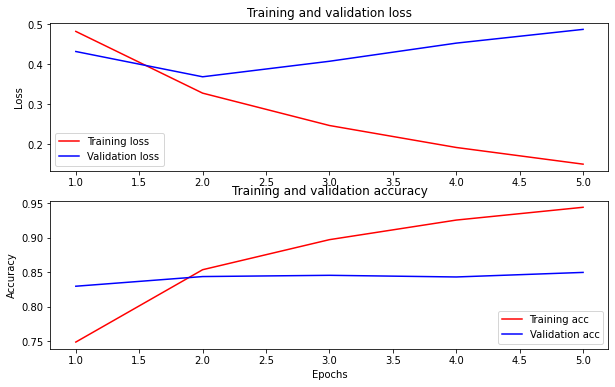

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999455
input: The movie was great!           : score: 0.993913
input: The movie was meh.             : score: 0.944821
input: The movie was okish.           : score: 0.052513
input: The movie was terrible...      : score: 0.001723

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999455
input: The movie was great!           : score: 0.993913
input: The movie was meh.             : score: 0.944821
input: The movie was okish.           : score: 0.052513
input: The movie was terrible...      : score: 0.001723



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999455
input: The movie was great!           : score: 0.993913
input: The movie was meh.             : score: 0.944821
input: The movie was okish.           : score: 0.052513
input: The movie was terrible...      : score: 0.001723



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.